In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Subset

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.models import vgg11

from sklearn.model_selection import KFold

import numpy as np
import matplotlib.pyplot as plt

from lib.models import model
from lib.server import Server
from lib.client import Client
from lib.data_helper import *
from lib.train_helper import *
from lib.plots import plot_loss_epoch

## 1. Prepare the code

In [10]:
# Innitialize the gpu accelearator
if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

In [11]:
# Download train dataset
train_dataset = CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
train_dataset

100%|██████████| 170498071/170498071 [00:02<00:00, 80696625.06it/s]


Extracting data/cifar-10-python.tar.gz to data


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [12]:
# Download test dataset
test_dataset = CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())
test_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [13]:
# Initialize # of clients in Fed learning and classes of dataset
num_clients = 8
num_classes = 10

In [14]:
# split data with alpha=10e8 for iid
proportions = generate_proportions(num_clients,num_classes, alpha=10e8)
proportions

[tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]),
 tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250])]

In [15]:
# Function to run Federated learning algorithm with weights averaging
def run_FedAvg(server,clients,device,train_dataset,valid_dataset,rounds,epochs,batch_size,optimizer,lr,**kwargs):
    
    train_loader = DeviceDataLoader(DataLoader(train_dataset, batch_size, shuffle=True), device)
    valid_loader = DeviceDataLoader(DataLoader(valid_dataset, batch_size, shuffle=True), device)
    history = []

    server.reset_weights()
    for i in range(rounds):
        print(f'>>> Round {i+1} ...')
        server_params = server.net.state_dict()
        clients_params = []
        for client in clients:
            client.train(device,server_params,epochs,batch_size, optimizer,lr,**kwargs)
        server.merge(clients)
        
        train_loss, train_acc = evaluate(server.net,train_loader)
        valid_loss, valid_acc = evaluate(server.net,valid_loader)
        
        print(f'''
Server :
    - training loss = {train_loss:.4f}
    - training accuracy = {train_acc:.4f}
    - validation loss = {valid_loss:.4f}
    - validation accuracy = {valid_acc:.4f}
        ''')
        
        history.append([train_loss, valid_loss, train_acc, valid_acc])
    return history

In [16]:
# function to run cross validation for choosing learning rates
def run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr,**kwargs):
    folds = KFold(n_splits=n_splits,shuffle=True,random_state=42).split(np.arange(len(train_dataset)))

    results = []
    for fold, (train_idx,valid_idx) in enumerate(folds):
        print("="*25)
        print(f"Fold #{fold}")
        print("="*25)

        # create train and validation subsets
        train_subset = Subset(train_dataset, train_idx)
        valid_subset = Subset(train_dataset, valid_idx)

        # split data between users
        partition = partition_by_class(train_subset)
        clients = [Client(i,d,model().to(device)) for i,d in enumerate(split(partition,proportions),start=1)]
        server = Server(model().to(device))
        
        for c in clients:
            print(f"client {c.client_id} : {len(c.dataset)} samples")
        print()
        
        history = run_FedAvg(server,clients,device,train_subset,valid_subset,rounds,epochs,batch_size,optimizer,lr,**kwargs)
        
        plot_loss_epoch(history)
        
        results.append(history[-1][-1])
        
        
    return torch.tensor(results).mean()

## 2. Perform the cross validation for list of leraning rates and betas on IID dataset

### 2.1 Selecting best proper rate, with fixed default betas of (0.9, 0.999). We do it this way(First selecting lr, then adjusting betas) to reduce the number fof needed trainings for different parameters.

Fold #0
client 1 : 5000 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 4999 samples
client 5 : 5002 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 2.1038, Accuracy = 0.1807
client 2 : Loss = 2.0893, Accuracy = 0.1966
client 3 : Loss = 2.1090, Accuracy = 0.1707
client 4 : Loss = 2.1123, Accuracy = 0.1686
client 5 : Loss = 2.1003, Accuracy = 0.2007
client 6 : Loss = 2.1599, Accuracy = 0.1729
client 7 : Loss = 2.0365, Accuracy = 0.1998
client 8 : Loss = 2.1733, Accuracy = 0.1596

Server :
    - training loss = 2.3432
    - training accuracy = 0.0941
    - validation loss = 2.3396
    - validation accuracy = 0.0993
        
>>> Round 2 ...
client 1 : Loss = 2.0827, Accuracy = 0.1748
client 2 : Loss = 2.0845, Accuracy = 0.1653
client 3 : Loss = 2.3129, Accuracy = 0.0912
client 4 : Loss = 2.3101, Accuracy = 0.0979
client 5 : Loss = 2.0963, Accuracy = 0.1605
client 6 : Loss = 2.1522, Accuracy = 0.1643
clie

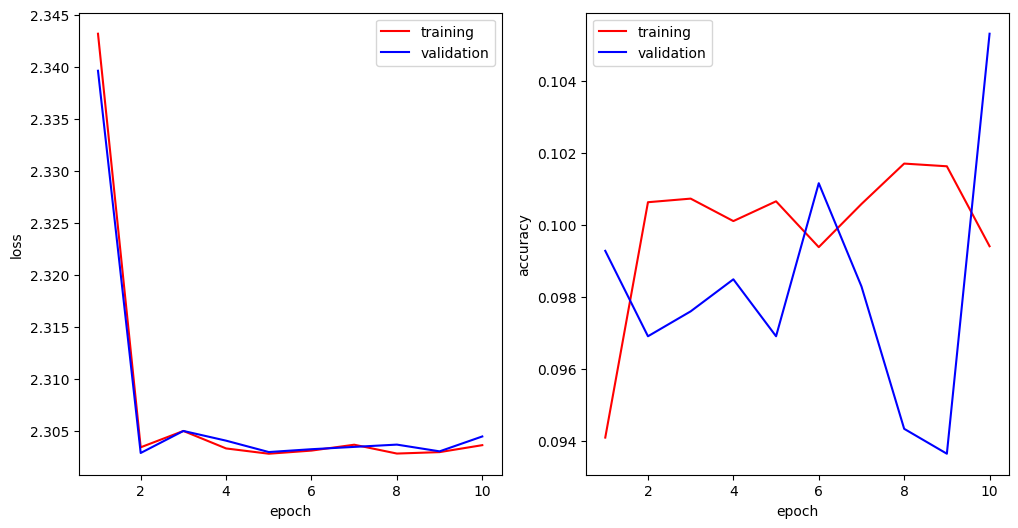

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 4998 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 2.3077, Accuracy = 0.0969
client 2 : Loss = 2.1519, Accuracy = 0.1746
client 3 : Loss = 2.2821, Accuracy = 0.1236
client 4 : Loss = 2.3115, Accuracy = 0.0963
client 5 : Loss = 2.1146, Accuracy = 0.1688
client 6 : Loss = 2.1479, Accuracy = 0.1843
client 7 : Loss = 2.1311, Accuracy = 0.1861
client 8 : Loss = 2.3078, Accuracy = 0.0982

Server :
    - training loss = 2.3244
    - training accuracy = 0.0987
    - validation loss = 2.3245
    - validation accuracy = 0.1031
        
>>> Round 2 ...
client 1 : Loss = 2.3087, Accuracy = 0.1013
client 2 : Loss = 2.1799, Accuracy = 0.1625
client 3 : Loss = 2.1570, Accuracy = 0.1669
client 4 : Loss = 2.0959, Accuracy = 0.1748
client 5 : Loss = 2.3143, Accuracy = 0.0973
client 6 : Loss = 2.3113, Accuracy = 0.0949
clie

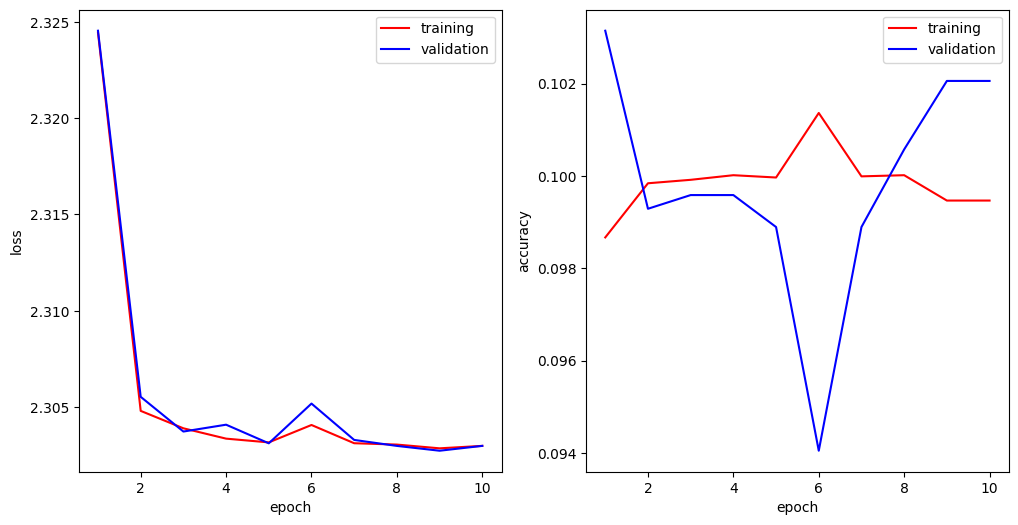

Fold #2
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4997 samples
client 4 : 5002 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 5000 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 2.1732, Accuracy = 0.1726
client 2 : Loss = 2.1720, Accuracy = 0.1681
client 3 : Loss = 2.1686, Accuracy = 0.1652
client 4 : Loss = 2.1713, Accuracy = 0.1661
client 5 : Loss = 2.3049, Accuracy = 0.1002
client 6 : Loss = 2.3114, Accuracy = 0.0893
client 7 : Loss = 2.1624, Accuracy = 0.1738
client 8 : Loss = 2.3145, Accuracy = 0.0934

Server :
    - training loss = 2.3290
    - training accuracy = 0.0998
    - validation loss = 2.3308
    - validation accuracy = 0.0972
        
>>> Round 2 ...
client 1 : Loss = 2.1300, Accuracy = 0.1617
client 2 : Loss = 2.3077, Accuracy = 0.0935
client 3 : Loss = 2.3099, Accuracy = 0.0951
client 4 : Loss = 2.0491, Accuracy = 0.1807
client 5 : Loss = 2.3103, Accuracy = 0.0951
client 6 : Loss = 2.3078, Accuracy = 0.1037
clie

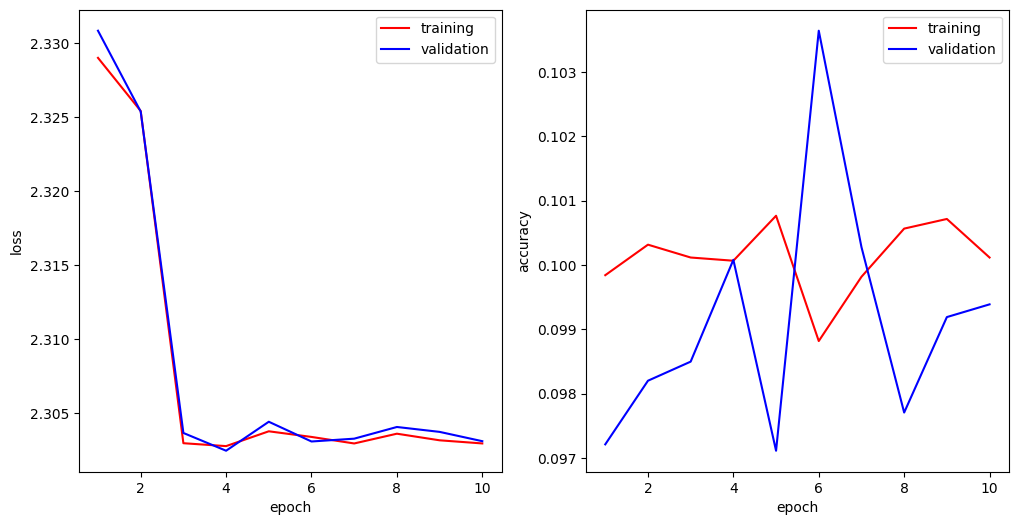

Fold #3
client 1 : 4999 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5001 samples
client 5 : 5000 samples
client 6 : 5000 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 2.1777, Accuracy = 0.1688
client 2 : Loss = 2.0718, Accuracy = 0.1965
client 3 : Loss = 2.3023, Accuracy = 0.1051
client 4 : Loss = 2.3016, Accuracy = 0.1043
client 5 : Loss = 2.2196, Accuracy = 0.1439
client 6 : Loss = 2.3006, Accuracy = 0.1330
client 7 : Loss = 2.0670, Accuracy = 0.1787
client 8 : Loss = 2.3102, Accuracy = 0.0932

Server :
    - training loss = 2.3145
    - training accuracy = 0.0986
    - validation loss = 2.3120
    - validation accuracy = 0.0990
        
>>> Round 2 ...
client 1 : Loss = 2.3093, Accuracy = 0.0948
client 2 : Loss = 2.3079, Accuracy = 0.0982
client 3 : Loss = 2.2560, Accuracy = 0.1328
client 4 : Loss = 2.3098, Accuracy = 0.0987
client 5 : Loss = 2.3116, Accuracy = 0.1000
client 6 : Loss = 2.3111, Accuracy = 0.0951
clie

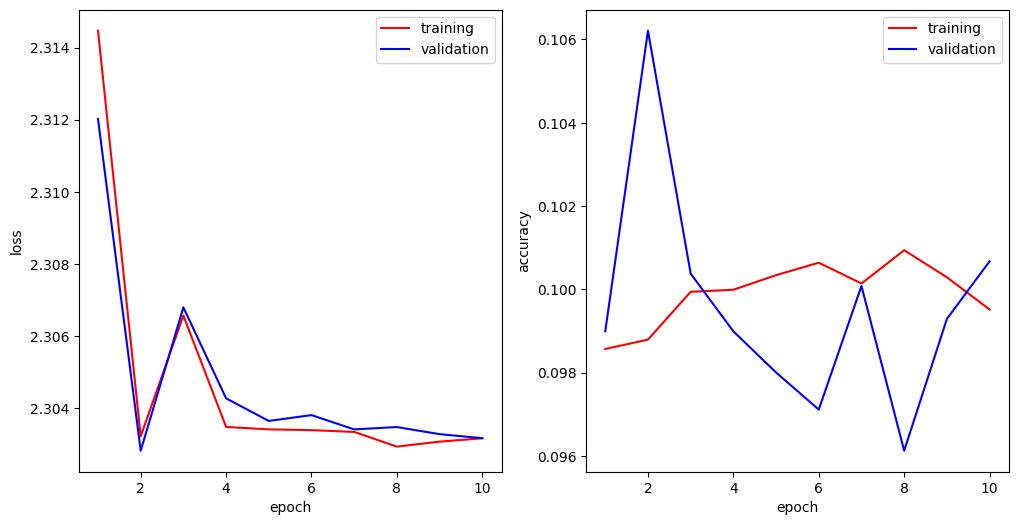

Fold #4
client 1 : 5001 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4998 samples
client 7 : 5000 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 2.0711, Accuracy = 0.1835
client 2 : Loss = 2.3085, Accuracy = 0.1016
client 3 : Loss = 2.3073, Accuracy = 0.1031
client 4 : Loss = 2.1964, Accuracy = 0.1525
client 5 : Loss = 2.3107, Accuracy = 0.0953
client 6 : Loss = 2.2903, Accuracy = 0.1102
client 7 : Loss = 2.1177, Accuracy = 0.1971
client 8 : Loss = 2.1063, Accuracy = 0.1856

Server :
    - training loss = 2.3232
    - training accuracy = 0.1001
    - validation loss = 2.3234
    - validation accuracy = 0.1002
        
>>> Round 2 ...
client 1 : Loss = 2.0866, Accuracy = 0.1681
client 2 : Loss = 2.0601, Accuracy = 0.1645
client 3 : Loss = 2.1173, Accuracy = 0.1697
client 4 : Loss = 2.1127, Accuracy = 0.1652
client 5 : Loss = 2.1046, Accuracy = 0.1533
client 6 : Loss = 2.3093, Accuracy = 0.0969
clie

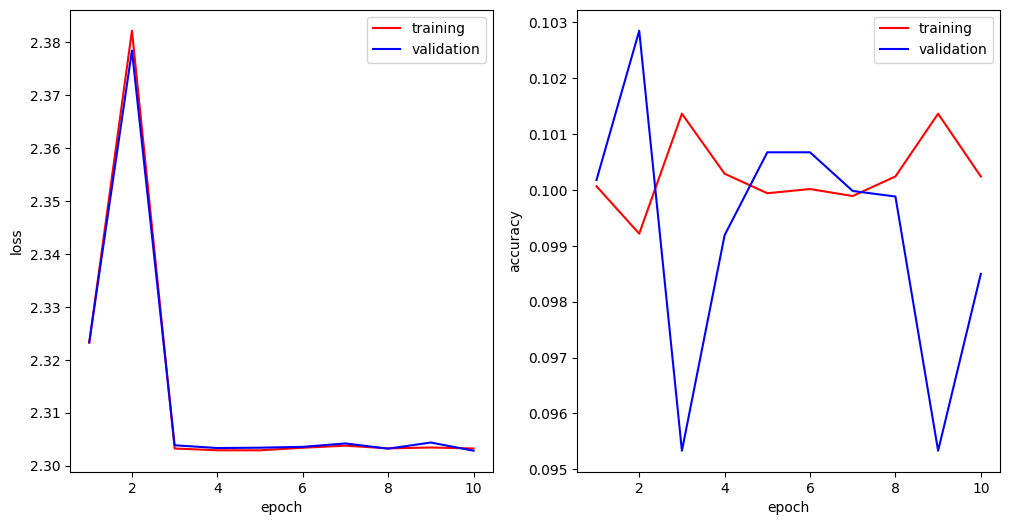

Fold #0
client 1 : 5000 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 4999 samples
client 5 : 5002 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.6256, Accuracy = 0.4201
client 2 : Loss = 1.5791, Accuracy = 0.4525
client 3 : Loss = 1.7105, Accuracy = 0.4127
client 4 : Loss = 1.6645, Accuracy = 0.4228
client 5 : Loss = 1.6891, Accuracy = 0.4236
client 6 : Loss = 1.8299, Accuracy = 0.3867
client 7 : Loss = 1.6795, Accuracy = 0.4019
client 8 : Loss = 1.7129, Accuracy = 0.4032

Server :
    - training loss = 2.0060
    - training accuracy = 0.3037
    - validation loss = 1.9983
    - validation accuracy = 0.2992
        
>>> Round 2 ...
client 1 : Loss = 1.3772, Accuracy = 0.4795
client 2 : Loss = 1.3387, Accuracy = 0.5137
client 3 : Loss = 1.3910, Accuracy = 0.4903
client 4 : Loss = 1.3767, Accuracy = 0.4991
client 5 : Loss = 1.3974, Accuracy = 0.4977
client 6 : Loss = 1.3545, Accuracy = 0.5139
clie

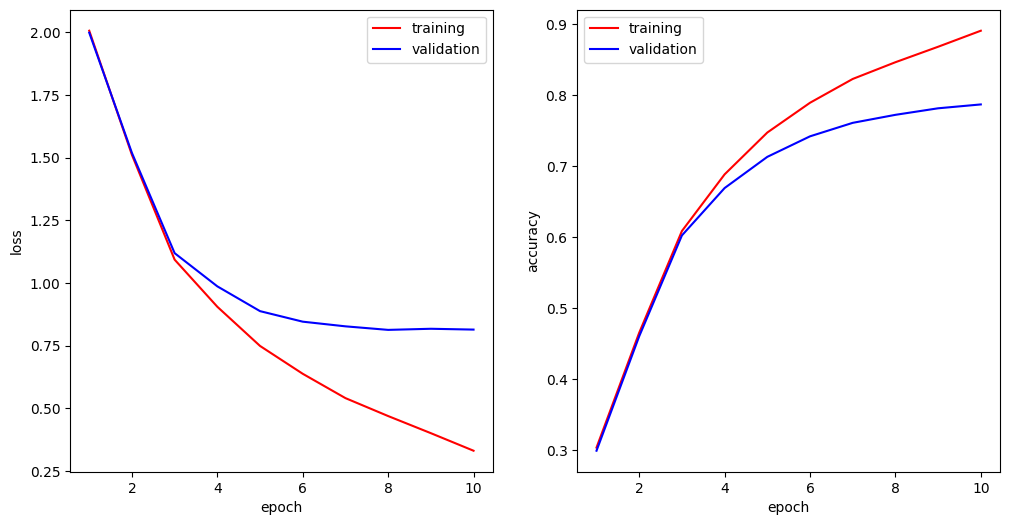

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 4998 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 1.5229, Accuracy = 0.4534
client 2 : Loss = 1.7593, Accuracy = 0.3894
client 3 : Loss = 1.6831, Accuracy = 0.4068
client 4 : Loss = 1.7248, Accuracy = 0.4141
client 5 : Loss = 1.6108, Accuracy = 0.4234
client 6 : Loss = 1.6616, Accuracy = 0.4058
client 7 : Loss = 1.7810, Accuracy = 0.3923
client 8 : Loss = 1.4748, Accuracy = 0.4670

Server :
    - training loss = 1.8506
    - training accuracy = 0.3278
    - validation loss = 1.8525
    - validation accuracy = 0.3258
        
>>> Round 2 ...
client 1 : Loss = 1.2686, Accuracy = 0.5396
client 2 : Loss = 1.5281, Accuracy = 0.4569
client 3 : Loss = 1.3662, Accuracy = 0.4992
client 4 : Loss = 1.2829, Accuracy = 0.5342
client 5 : Loss = 1.3825, Accuracy = 0.5072
client 6 : Loss = 1.3468, Accuracy = 0.5162
clie

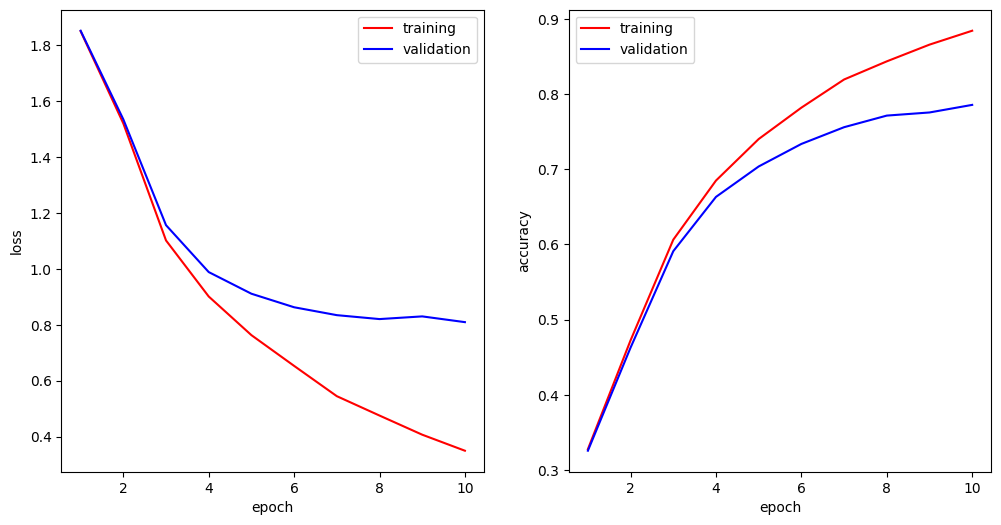

Fold #2
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4997 samples
client 4 : 5002 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 5000 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.6158, Accuracy = 0.4349
client 2 : Loss = 1.5422, Accuracy = 0.4443
client 3 : Loss = 1.7138, Accuracy = 0.3898
client 4 : Loss = 1.6752, Accuracy = 0.4073
client 5 : Loss = 1.7021, Accuracy = 0.4303
client 6 : Loss = 1.8094, Accuracy = 0.3912
client 7 : Loss = 1.8080, Accuracy = 0.3684
client 8 : Loss = 1.6933, Accuracy = 0.4135

Server :
    - training loss = 1.8474
    - training accuracy = 0.3311
    - validation loss = 1.8519
    - validation accuracy = 0.3254
        
>>> Round 2 ...
client 1 : Loss = 1.3244, Accuracy = 0.5172
client 2 : Loss = 1.3326, Accuracy = 0.5273
client 3 : Loss = 1.3691, Accuracy = 0.5036
client 4 : Loss = 1.3354, Accuracy = 0.5056
client 5 : Loss = 1.2516, Accuracy = 0.5406
client 6 : Loss = 1.3108, Accuracy = 0.5142
clie

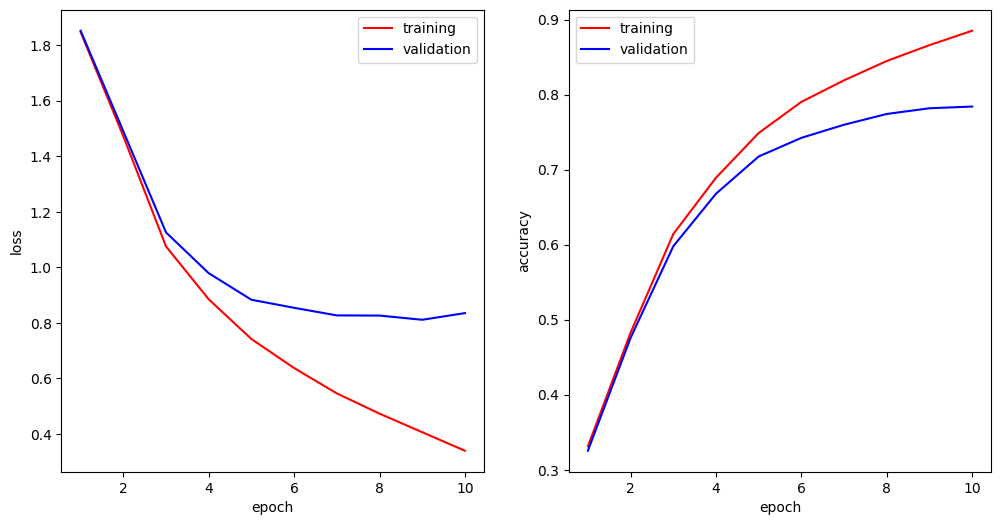

Fold #3
client 1 : 4999 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5001 samples
client 5 : 5000 samples
client 6 : 5000 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.5436, Accuracy = 0.4374
client 2 : Loss = 1.6190, Accuracy = 0.4397
client 3 : Loss = 1.5512, Accuracy = 0.4357
client 4 : Loss = 1.5803, Accuracy = 0.4397
client 5 : Loss = 1.6219, Accuracy = 0.4187
client 6 : Loss = 1.6017, Accuracy = 0.4445
client 7 : Loss = 1.4780, Accuracy = 0.4715
client 8 : Loss = 1.6713, Accuracy = 0.4013

Server :
    - training loss = 1.9591
    - training accuracy = 0.3150
    - validation loss = 1.9605
    - validation accuracy = 0.3087
        
>>> Round 2 ...
client 1 : Loss = 1.3479, Accuracy = 0.5105
client 2 : Loss = 1.3479, Accuracy = 0.5084
client 3 : Loss = 1.3234, Accuracy = 0.5203
client 4 : Loss = 1.2577, Accuracy = 0.5468
client 5 : Loss = 1.2722, Accuracy = 0.5350
client 6 : Loss = 1.2764, Accuracy = 0.5305
clie

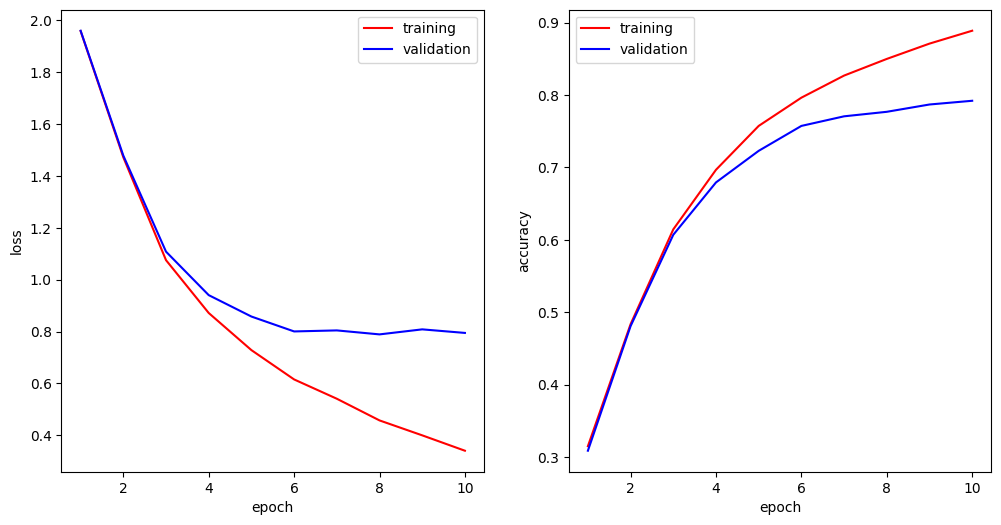

Fold #4
client 1 : 5001 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4998 samples
client 7 : 5000 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.5046, Accuracy = 0.4639
client 2 : Loss = 1.7077, Accuracy = 0.3935
client 3 : Loss = 1.5986, Accuracy = 0.4369
client 4 : Loss = 1.5141, Accuracy = 0.4514
client 5 : Loss = 1.4785, Accuracy = 0.4557
client 6 : Loss = 1.5770, Accuracy = 0.4365
client 7 : Loss = 1.5248, Accuracy = 0.4426
client 8 : Loss = 1.6115, Accuracy = 0.4245

Server :
    - training loss = 1.7359
    - training accuracy = 0.3761
    - validation loss = 1.7423
    - validation accuracy = 0.3735
        
>>> Round 2 ...
client 1 : Loss = 1.2246, Accuracy = 0.5556
client 2 : Loss = 1.2975, Accuracy = 0.5306
client 3 : Loss = 1.3302, Accuracy = 0.5201
client 4 : Loss = 1.3171, Accuracy = 0.5160
client 5 : Loss = 1.3136, Accuracy = 0.5218
client 6 : Loss = 1.3181, Accuracy = 0.5325
clie

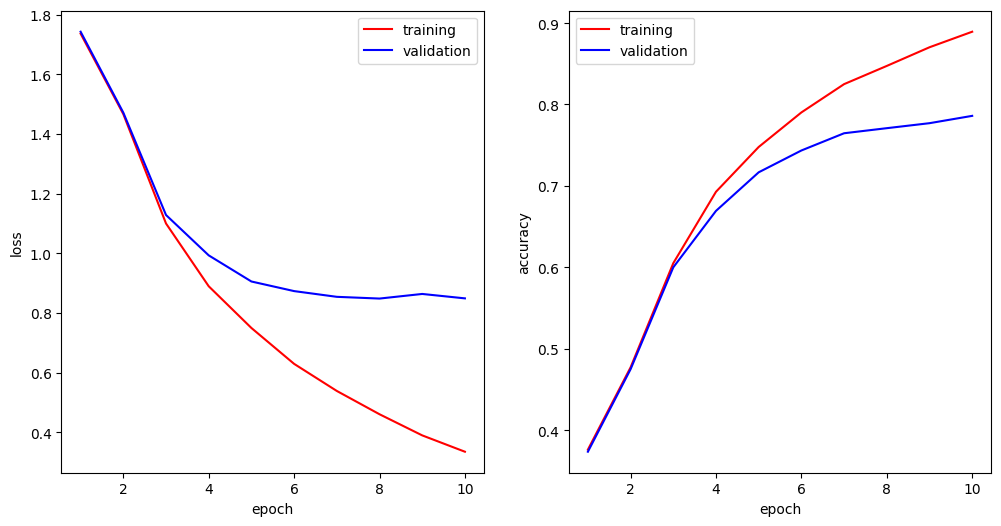

Fold #0
client 1 : 5000 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 4999 samples
client 5 : 5002 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.0022, Accuracy = 0.6492
client 2 : Loss = 1.0015, Accuracy = 0.6476
client 3 : Loss = 1.0524, Accuracy = 0.6330
client 4 : Loss = 1.1908, Accuracy = 0.5828
client 5 : Loss = 1.0008, Accuracy = 0.6461
client 6 : Loss = 1.0345, Accuracy = 0.6325
client 7 : Loss = 1.0201, Accuracy = 0.6338
client 8 : Loss = 1.0149, Accuracy = 0.6451

Server :
    - training loss = 1.2935
    - training accuracy = 0.5542
    - validation loss = 1.3312
    - validation accuracy = 0.5281
        
>>> Round 2 ...
client 1 : Loss = 0.5335, Accuracy = 0.8258
client 2 : Loss = 0.5751, Accuracy = 0.8059
client 3 : Loss = 0.6450, Accuracy = 0.7683
client 4 : Loss = 0.6866, Accuracy = 0.7566
client 5 : Loss = 0.5299, Accuracy = 0.8164
client 6 : Loss = 0.6762, Accuracy = 0.7651
clie

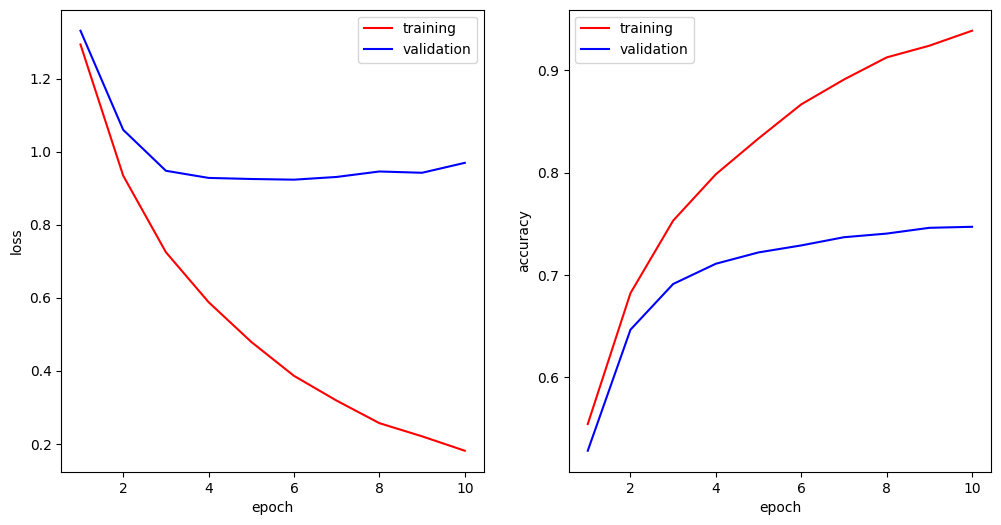

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 4998 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 1.0096, Accuracy = 0.6472
client 2 : Loss = 1.1221, Accuracy = 0.6013
client 3 : Loss = 1.0279, Accuracy = 0.6317
client 4 : Loss = 1.0447, Accuracy = 0.6277
client 5 : Loss = 1.0134, Accuracy = 0.6419
client 6 : Loss = 0.9883, Accuracy = 0.6499
client 7 : Loss = 1.0857, Accuracy = 0.6182
client 8 : Loss = 1.0992, Accuracy = 0.6101

Server :
    - training loss = 1.2853
    - training accuracy = 0.5530
    - validation loss = 1.3564
    - validation accuracy = 0.5368
        
>>> Round 2 ...
client 1 : Loss = 0.5210, Accuracy = 0.8374
client 2 : Loss = 0.6398, Accuracy = 0.7777
client 3 : Loss = 0.6038, Accuracy = 0.7979
client 4 : Loss = 0.6311, Accuracy = 0.7734
client 5 : Loss = 0.5963, Accuracy = 0.8056
client 6 : Loss = 0.6169, Accuracy = 0.7791
clie

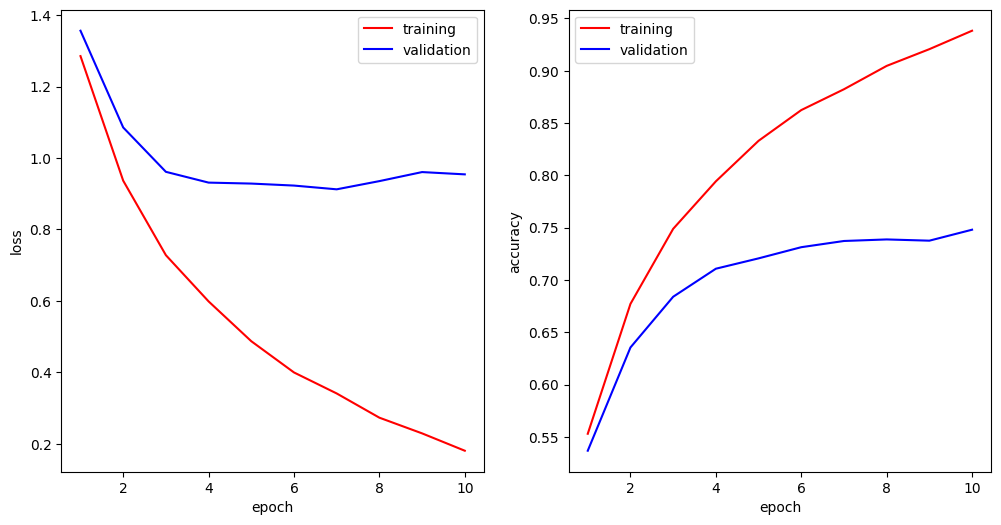

Fold #2
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4997 samples
client 4 : 5002 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 5000 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.0491, Accuracy = 0.6325
client 2 : Loss = 1.0525, Accuracy = 0.6221
client 3 : Loss = 1.0110, Accuracy = 0.6425
client 4 : Loss = 0.9744, Accuracy = 0.6540
client 5 : Loss = 0.9940, Accuracy = 0.6508
client 6 : Loss = 1.0101, Accuracy = 0.6423
client 7 : Loss = 1.0630, Accuracy = 0.6135
client 8 : Loss = 0.9733, Accuracy = 0.6463

Server :
    - training loss = 1.2884
    - training accuracy = 0.5503
    - validation loss = 1.3616
    - validation accuracy = 0.5350
        
>>> Round 2 ...
client 1 : Loss = 0.6989, Accuracy = 0.7535
client 2 : Loss = 0.5361, Accuracy = 0.8216
client 3 : Loss = 0.6549, Accuracy = 0.7739
client 4 : Loss = 0.5334, Accuracy = 0.8262
client 5 : Loss = 0.6320, Accuracy = 0.7857
client 6 : Loss = 0.6016, Accuracy = 0.7987
clie

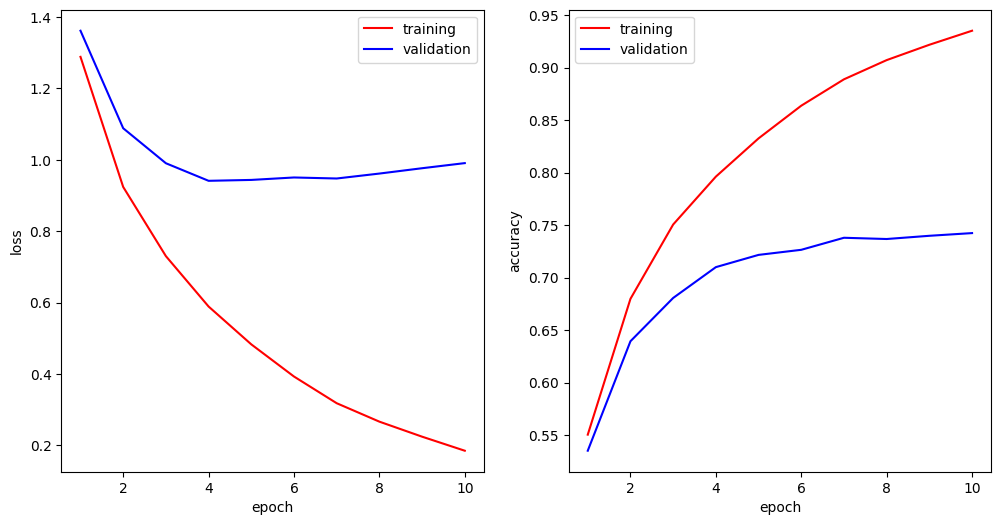

Fold #3
client 1 : 4999 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5001 samples
client 5 : 5000 samples
client 6 : 5000 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.0163, Accuracy = 0.6395
client 2 : Loss = 0.9973, Accuracy = 0.6486
client 3 : Loss = 1.0162, Accuracy = 0.6400
client 4 : Loss = 1.0035, Accuracy = 0.6472
client 5 : Loss = 1.0593, Accuracy = 0.6346
client 6 : Loss = 1.0217, Accuracy = 0.6402
client 7 : Loss = 1.0632, Accuracy = 0.6161
client 8 : Loss = 0.9846, Accuracy = 0.6514

Server :
    - training loss = 1.3012
    - training accuracy = 0.5497
    - validation loss = 1.3394
    - validation accuracy = 0.5399
        
>>> Round 2 ...
client 1 : Loss = 0.6503, Accuracy = 0.7811
client 2 : Loss = 0.5295, Accuracy = 0.8232
client 3 : Loss = 0.6510, Accuracy = 0.7777
client 4 : Loss = 0.5905, Accuracy = 0.7998
client 5 : Loss = 0.6371, Accuracy = 0.7881
client 6 : Loss = 0.6474, Accuracy = 0.7783
clie

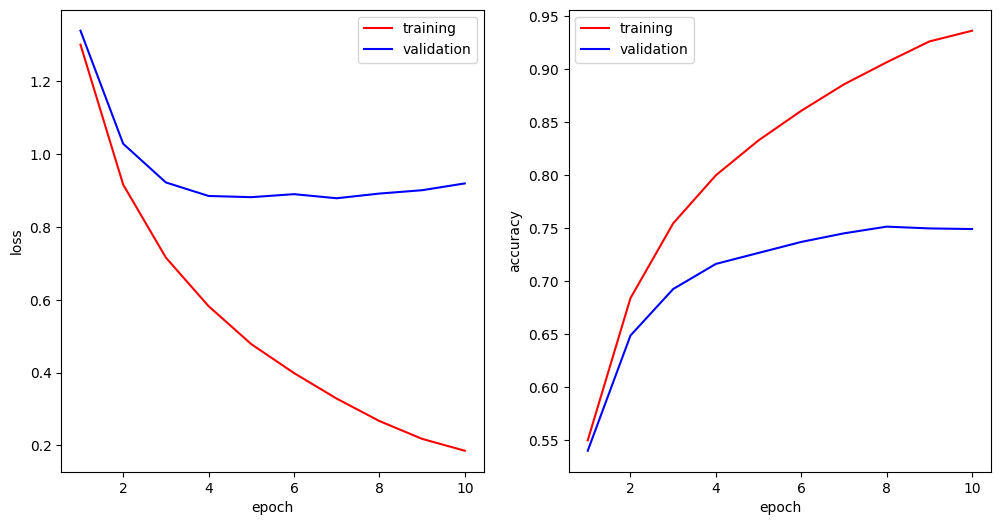

Fold #4
client 1 : 5001 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4998 samples
client 7 : 5000 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.0154, Accuracy = 0.6383
client 2 : Loss = 1.0623, Accuracy = 0.6168
client 3 : Loss = 1.0124, Accuracy = 0.6361
client 4 : Loss = 1.0930, Accuracy = 0.6064
client 5 : Loss = 0.9846, Accuracy = 0.6553
client 6 : Loss = 1.0724, Accuracy = 0.6280
client 7 : Loss = 1.0498, Accuracy = 0.6285
client 8 : Loss = 0.9878, Accuracy = 0.6516

Server :
    - training loss = 1.2888
    - training accuracy = 0.5512
    - validation loss = 1.3652
    - validation accuracy = 0.5312
        
>>> Round 2 ...
client 1 : Loss = 0.5659, Accuracy = 0.8039
client 2 : Loss = 0.5614, Accuracy = 0.8138
client 3 : Loss = 0.6240, Accuracy = 0.7887
client 4 : Loss = 0.6480, Accuracy = 0.7834
client 5 : Loss = 0.5905, Accuracy = 0.7994
client 6 : Loss = 0.6401, Accuracy = 0.7815
clie

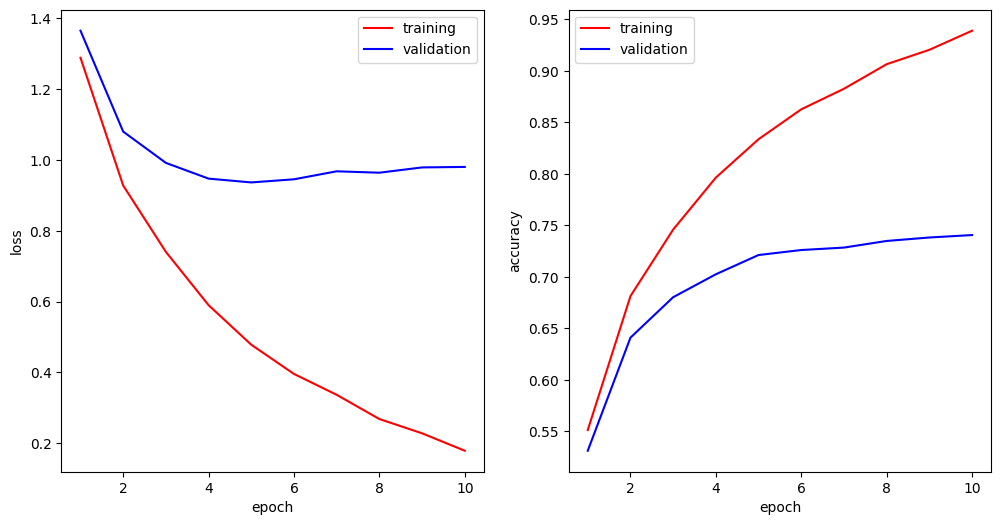

Fold #0
client 1 : 5000 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 4999 samples
client 5 : 5002 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.3535, Accuracy = 0.5215
client 2 : Loss = 1.3680, Accuracy = 0.5210
client 3 : Loss = 1.3707, Accuracy = 0.5140
client 4 : Loss = 1.3579, Accuracy = 0.5298
client 5 : Loss = 1.3314, Accuracy = 0.5316
client 6 : Loss = 1.3792, Accuracy = 0.5147
client 7 : Loss = 1.3732, Accuracy = 0.5184
client 8 : Loss = 1.3990, Accuracy = 0.5117

Server :
    - training loss = 1.4551
    - training accuracy = 0.4805
    - validation loss = 1.5248
    - validation accuracy = 0.4478
        
>>> Round 2 ...
client 1 : Loss = 1.0667, Accuracy = 0.6316
client 2 : Loss = 1.0859, Accuracy = 0.6184
client 3 : Loss = 1.1228, Accuracy = 0.6105
client 4 : Loss = 1.1305, Accuracy = 0.6051
client 5 : Loss = 1.0408, Accuracy = 0.6384
client 6 : Loss = 1.1297, Accuracy = 0.5992
clie

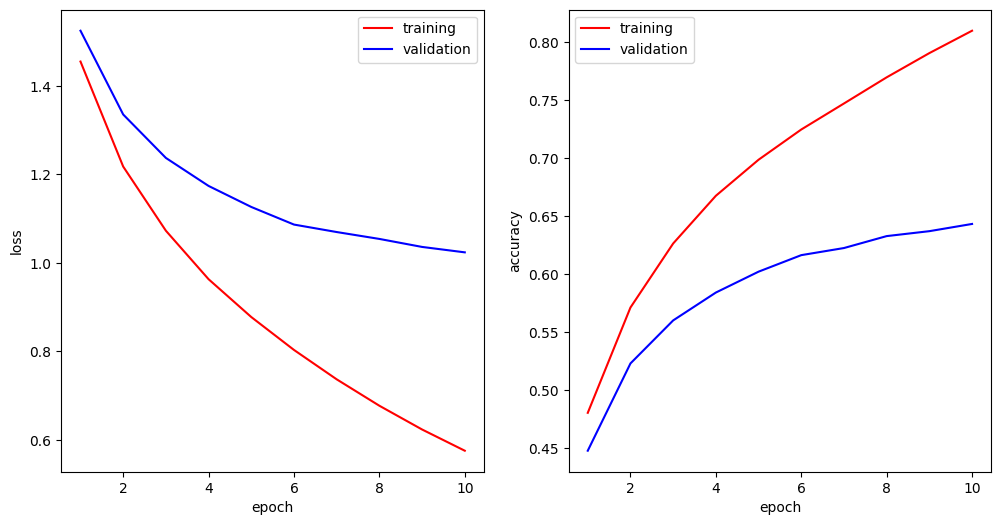

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 4998 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 1.3782, Accuracy = 0.5157
client 2 : Loss = 1.4661, Accuracy = 0.4873
client 3 : Loss = 1.4359, Accuracy = 0.4890
client 4 : Loss = 1.3942, Accuracy = 0.5055
client 5 : Loss = 1.3633, Accuracy = 0.5210
client 6 : Loss = 1.4442, Accuracy = 0.4902
client 7 : Loss = 1.4157, Accuracy = 0.5090
client 8 : Loss = 1.4078, Accuracy = 0.5053

Server :
    - training loss = 1.4822
    - training accuracy = 0.4761
    - validation loss = 1.5646
    - validation accuracy = 0.4462
        
>>> Round 2 ...
client 1 : Loss = 1.1141, Accuracy = 0.6051
client 2 : Loss = 1.1314, Accuracy = 0.5943
client 3 : Loss = 1.1393, Accuracy = 0.6019
client 4 : Loss = 1.1052, Accuracy = 0.6076
client 5 : Loss = 1.1055, Accuracy = 0.6087
client 6 : Loss = 1.1682, Accuracy = 0.5828
clie

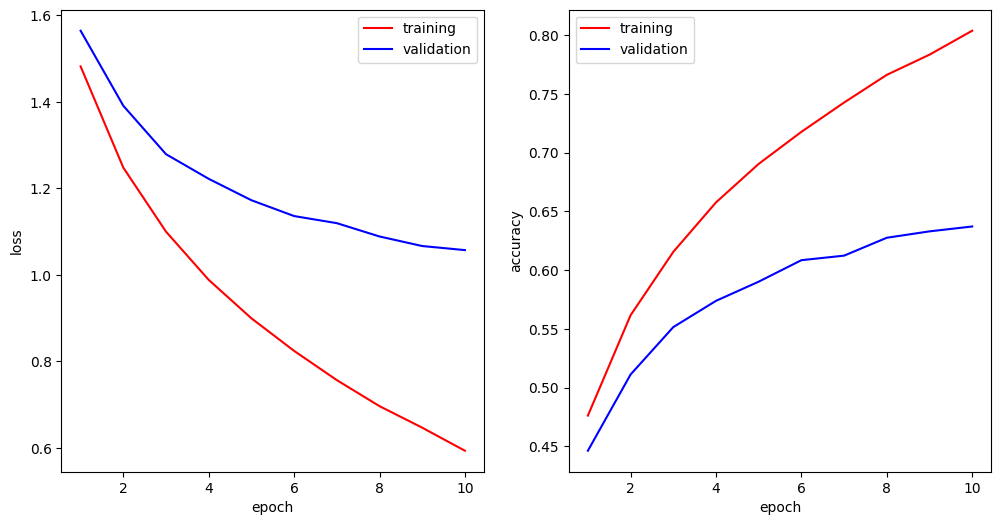

Fold #2
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4997 samples
client 4 : 5002 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 5000 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.4392, Accuracy = 0.4878
client 2 : Loss = 1.3646, Accuracy = 0.5175
client 3 : Loss = 1.4236, Accuracy = 0.5108
client 4 : Loss = 1.4261, Accuracy = 0.5050
client 5 : Loss = 1.4282, Accuracy = 0.4895
client 6 : Loss = 1.3858, Accuracy = 0.5153
client 7 : Loss = 1.4348, Accuracy = 0.4865
client 8 : Loss = 1.4138, Accuracy = 0.5055

Server :
    - training loss = 1.4823
    - training accuracy = 0.4710
    - validation loss = 1.5581
    - validation accuracy = 0.4393
        
>>> Round 2 ...
client 1 : Loss = 1.1179, Accuracy = 0.6048
client 2 : Loss = 1.1287, Accuracy = 0.5993
client 3 : Loss = 1.1678, Accuracy = 0.5885
client 4 : Loss = 1.1508, Accuracy = 0.5968
client 5 : Loss = 1.1604, Accuracy = 0.5818
client 6 : Loss = 1.1481, Accuracy = 0.6053
clie

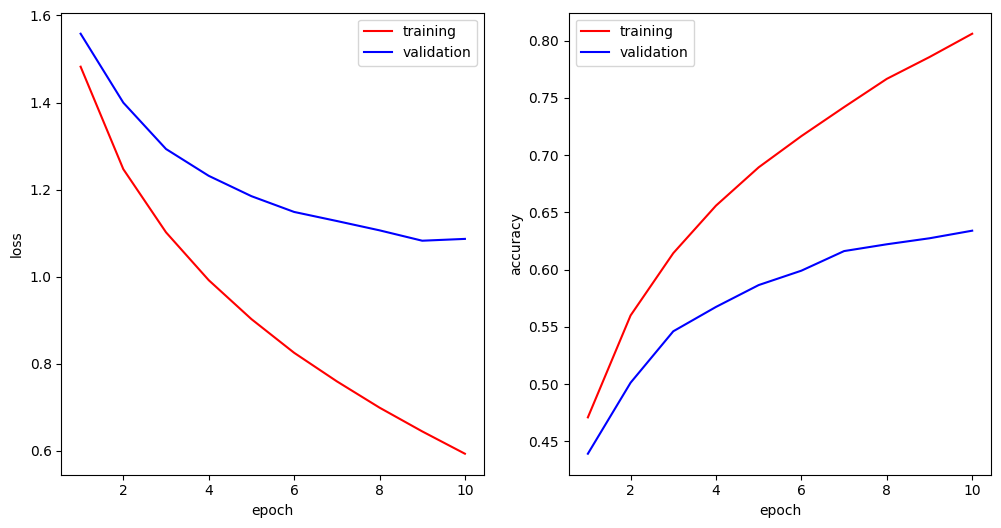

Fold #3
client 1 : 4999 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5001 samples
client 5 : 5000 samples
client 6 : 5000 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.3908, Accuracy = 0.5034
client 2 : Loss = 1.3711, Accuracy = 0.5132
client 3 : Loss = 1.4069, Accuracy = 0.5079
client 4 : Loss = 1.4269, Accuracy = 0.5049
client 5 : Loss = 1.4170, Accuracy = 0.5039
client 6 : Loss = 1.3831, Accuracy = 0.5082
client 7 : Loss = 1.3811, Accuracy = 0.5074
client 8 : Loss = 1.3830, Accuracy = 0.5091

Server :
    - training loss = 1.4849
    - training accuracy = 0.4714
    - validation loss = 1.5683
    - validation accuracy = 0.4449
        
>>> Round 2 ...
client 1 : Loss = 1.1294, Accuracy = 0.6043
client 2 : Loss = 1.1184, Accuracy = 0.6158
client 3 : Loss = 1.1334, Accuracy = 0.6056
client 4 : Loss = 1.1314, Accuracy = 0.6057
client 5 : Loss = 1.1276, Accuracy = 0.5947
client 6 : Loss = 1.1232, Accuracy = 0.6029
clie

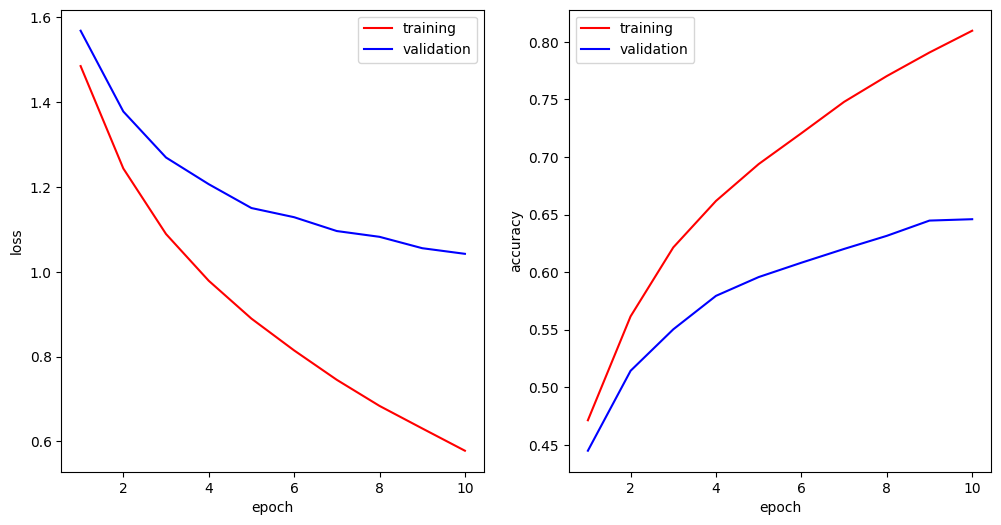

Fold #4
client 1 : 5001 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4998 samples
client 7 : 5000 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.3998, Accuracy = 0.5049
client 2 : Loss = 1.3863, Accuracy = 0.5188
client 3 : Loss = 1.3791, Accuracy = 0.5027
client 4 : Loss = 1.3913, Accuracy = 0.5029
client 5 : Loss = 1.3810, Accuracy = 0.5185
client 6 : Loss = 1.3845, Accuracy = 0.5143
client 7 : Loss = 1.3827, Accuracy = 0.5109
client 8 : Loss = 1.3882, Accuracy = 0.5094

Server :
    - training loss = 1.4752
    - training accuracy = 0.4737
    - validation loss = 1.5575
    - validation accuracy = 0.4411
        
>>> Round 2 ...
client 1 : Loss = 1.1170, Accuracy = 0.6126
client 2 : Loss = 1.1245, Accuracy = 0.6049
client 3 : Loss = 1.1279, Accuracy = 0.6027
client 4 : Loss = 1.1560, Accuracy = 0.6002
client 5 : Loss = 1.1464, Accuracy = 0.5976
client 6 : Loss = 1.1236, Accuracy = 0.6059
clie

In [ ]:
%%time
n_splits = 5
rounds = 10
batch_size = 128
epochs = 5
lrs = [1e-1,1e-2,1e-3,1e-4]
optimizer = optim.Adam

results = []
for lr in lrs:
    res = run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr)
    results.append((lr,res))
    
print("="*25)
print(f"RESULTS")
print("="*25)
for lr,res in results:
    print(f"lr = {lr:.4f} : Accuracy = {res}")
print()


### Comment: It can be seen that best learning rates are 0.001 and 0.01. Let's try to check for value in between these values, 0.005:

Fold #0
client 1 : 5000 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5000 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.8350, Accuracy = 0.3582
client 2 : Loss = 1.6475, Accuracy = 0.4217
client 3 : Loss = 1.7067, Accuracy = 0.4269
client 4 : Loss = 1.8782, Accuracy = 0.3406
client 5 : Loss = 1.7264, Accuracy = 0.4056
client 6 : Loss = 1.7385, Accuracy = 0.3873
client 7 : Loss = 1.7662, Accuracy = 0.3984
client 8 : Loss = 1.7014, Accuracy = 0.4127

Server :
    - training loss = 1.9459
    - training accuracy = 0.3173
    - validation loss = 1.9398
    - validation accuracy = 0.3170
        
>>> Round 2 ...
client 1 : Loss = 1.3619, Accuracy = 0.5084
client 2 : Loss = 1.3395, Accuracy = 0.5252
client 3 : Loss = 1.2889, Accuracy = 0.5289
client 4 : Loss = 1.3441, Accuracy = 0.5086
client 5 : Loss = 1.3879, Accuracy = 0.4951
client 6 : Loss = 1.3600, Accuracy = 0.5027
clie

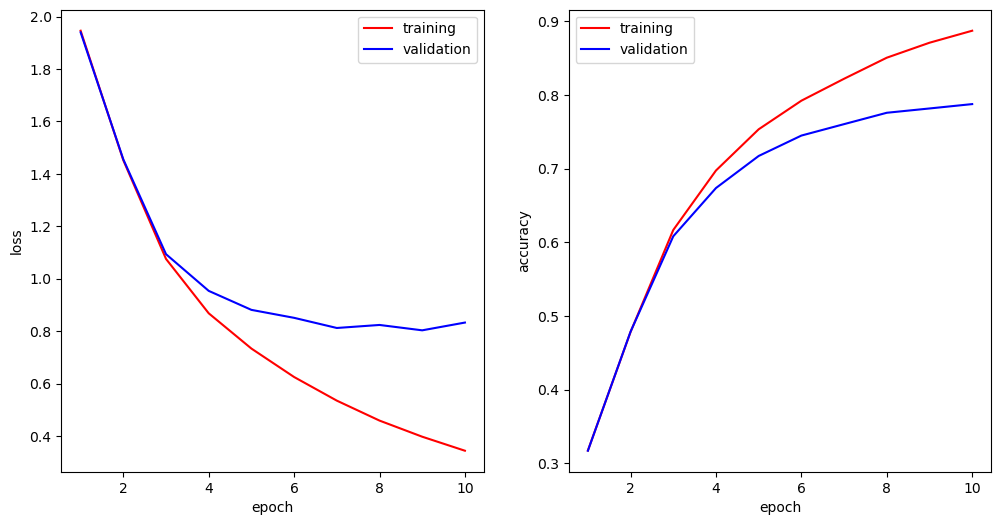

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5001 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 4998 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 1.7053, Accuracy = 0.3982
client 2 : Loss = 1.5561, Accuracy = 0.4476
client 3 : Loss = 1.6214, Accuracy = 0.4354
client 4 : Loss = 1.5516, Accuracy = 0.4300
client 5 : Loss = 1.5313, Accuracy = 0.4430
client 6 : Loss = 1.6400, Accuracy = 0.4194
client 7 : Loss = 1.5292, Accuracy = 0.4593
client 8 : Loss = 1.5588, Accuracy = 0.4523

Server :
    - training loss = 1.8032
    - training accuracy = 0.3720
    - validation loss = 1.8083
    - validation accuracy = 0.3607
        
>>> Round 2 ...
client 1 : Loss = 1.2954, Accuracy = 0.5293
client 2 : Loss = 1.3099, Accuracy = 0.5315
client 3 : Loss = 1.2957, Accuracy = 0.5269
client 4 : Loss = 1.2588, Accuracy = 0.5494
client 5 : Loss = 1.2556, Accuracy = 0.5484
client 6 : Loss = 1.4479, Accuracy = 0.4717
clie

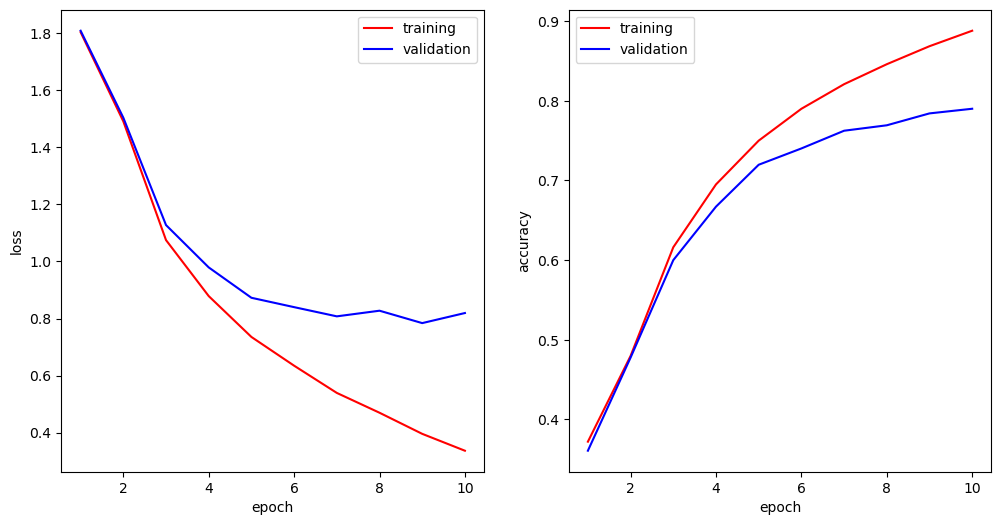

Fold #2
client 1 : 5000 samples
client 2 : 5001 samples
client 3 : 4998 samples
client 4 : 5001 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5000 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.7265, Accuracy = 0.3982
client 2 : Loss = 1.5292, Accuracy = 0.4585
client 3 : Loss = 1.7648, Accuracy = 0.3847
client 4 : Loss = 1.5597, Accuracy = 0.4289
client 5 : Loss = 1.5015, Accuracy = 0.4658
client 6 : Loss = 1.6379, Accuracy = 0.4172
client 7 : Loss = 1.5136, Accuracy = 0.4506
client 8 : Loss = 1.6557, Accuracy = 0.4144

Server :
    - training loss = 1.8422
    - training accuracy = 0.3178
    - validation loss = 1.8408
    - validation accuracy = 0.3093
        
>>> Round 2 ...
client 1 : Loss = 1.3283, Accuracy = 0.5281
client 2 : Loss = 1.3281, Accuracy = 0.5167
client 3 : Loss = 1.3089, Accuracy = 0.5131
client 4 : Loss = 1.3005, Accuracy = 0.5263
client 5 : Loss = 1.2197, Accuracy = 0.5505
client 6 : Loss = 1.2537, Accuracy = 0.5502
clie

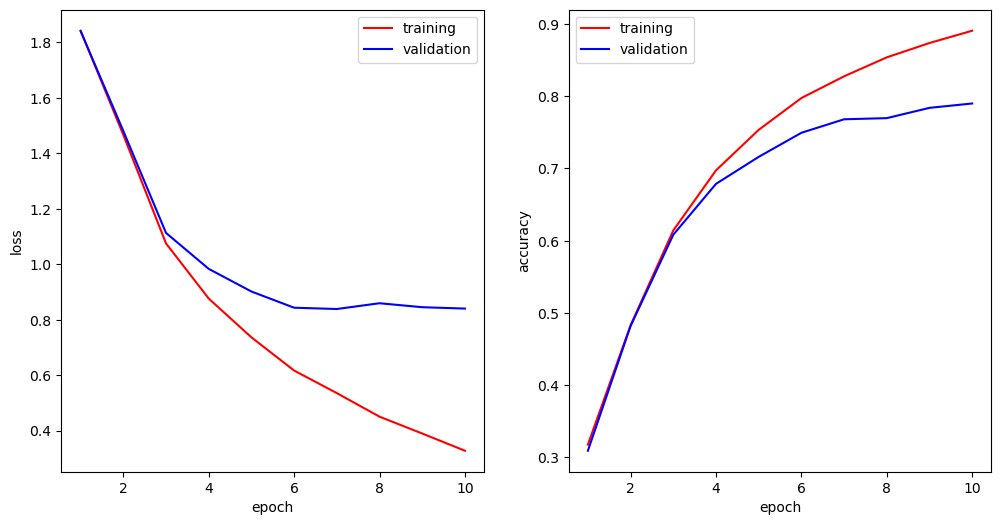

Fold #3
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 5003 samples
client 5 : 4997 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.6682, Accuracy = 0.4172
client 2 : Loss = 1.7348, Accuracy = 0.4064
client 3 : Loss = 1.7309, Accuracy = 0.3842
client 4 : Loss = 1.6638, Accuracy = 0.4040
client 5 : Loss = 1.5953, Accuracy = 0.4385
client 6 : Loss = 1.5678, Accuracy = 0.4329
client 7 : Loss = 1.5298, Accuracy = 0.4565
client 8 : Loss = 1.6576, Accuracy = 0.4133

Server :
    - training loss = 1.8498
    - training accuracy = 0.3500
    - validation loss = 1.8582
    - validation accuracy = 0.3482
        
>>> Round 2 ...
client 1 : Loss = 1.2878, Accuracy = 0.5398
client 2 : Loss = 1.3396, Accuracy = 0.5131
client 3 : Loss = 1.3385, Accuracy = 0.5191
client 4 : Loss = 1.3275, Accuracy = 0.5206
client 5 : Loss = 1.4820, Accuracy = 0.4691
client 6 : Loss = 1.3579, Accuracy = 0.5063
clie

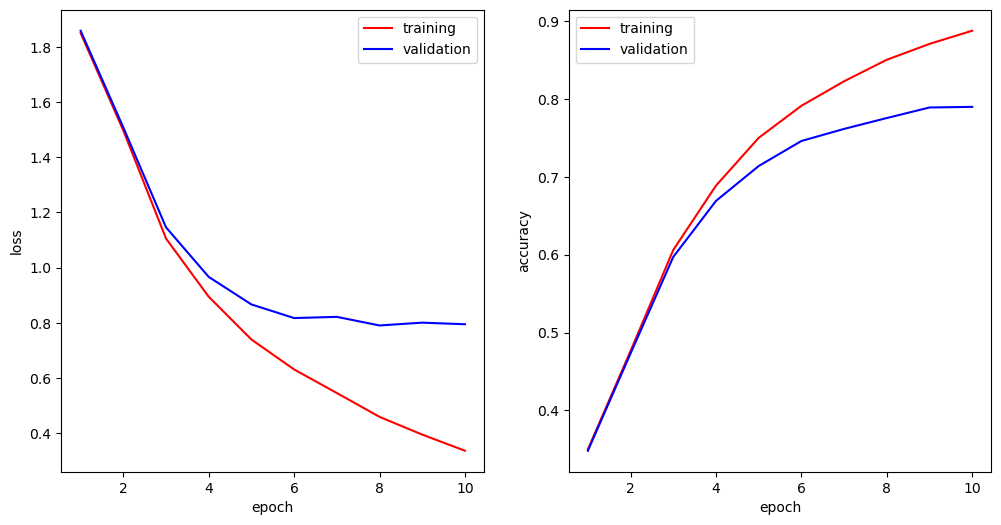

Fold #4
client 1 : 5001 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 5000 samples
client 5 : 4999 samples
client 6 : 5000 samples
client 7 : 4999 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.6154, Accuracy = 0.4234
client 2 : Loss = 1.6258, Accuracy = 0.4201
client 3 : Loss = 1.7441, Accuracy = 0.4021
client 4 : Loss = 1.7919, Accuracy = 0.4109
client 5 : Loss = 1.6416, Accuracy = 0.4230
client 6 : Loss = 1.6402, Accuracy = 0.4068
client 7 : Loss = 1.8319, Accuracy = 0.3607
client 8 : Loss = 1.5916, Accuracy = 0.4275

Server :
    - training loss = 1.8622
    - training accuracy = 0.3236
    - validation loss = 1.8784
    - validation accuracy = 0.3188
        
>>> Round 2 ...
client 1 : Loss = 1.4255, Accuracy = 0.4883
client 2 : Loss = 1.4910, Accuracy = 0.4447
client 3 : Loss = 1.4551, Accuracy = 0.4742
client 4 : Loss = 1.3878, Accuracy = 0.4947
client 5 : Loss = 1.3603, Accuracy = 0.5049
client 6 : Loss = 1.3588, Accuracy = 0.5066
clie

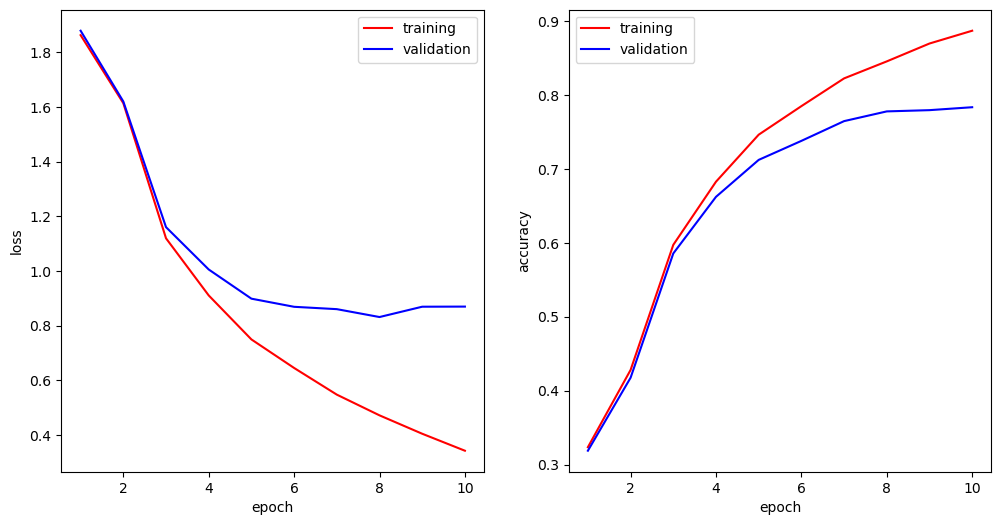

Fold #0
client 1 : 5000 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5000 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.4367, Accuracy = 0.4850
client 2 : Loss = 1.4626, Accuracy = 0.4768
client 3 : Loss = 1.3291, Accuracy = 0.5193
client 4 : Loss = 1.4605, Accuracy = 0.4910
client 5 : Loss = 1.3941, Accuracy = 0.5108
client 6 : Loss = 1.4134, Accuracy = 0.5111
client 7 : Loss = 1.3676, Accuracy = 0.5141
client 8 : Loss = 1.4433, Accuracy = 0.4853

Server :
    - training loss = 1.5740
    - training accuracy = 0.4386
    - validation loss = 1.5880
    - validation accuracy = 0.4308
        
>>> Round 2 ...
client 1 : Loss = 1.0672, Accuracy = 0.6242
client 2 : Loss = 1.0839, Accuracy = 0.6085
client 3 : Loss = 1.0957, Accuracy = 0.6069
client 4 : Loss = 1.0583, Accuracy = 0.6238
client 5 : Loss = 1.1608, Accuracy = 0.5833
client 6 : Loss = 1.1676, Accuracy = 0.5820
clie

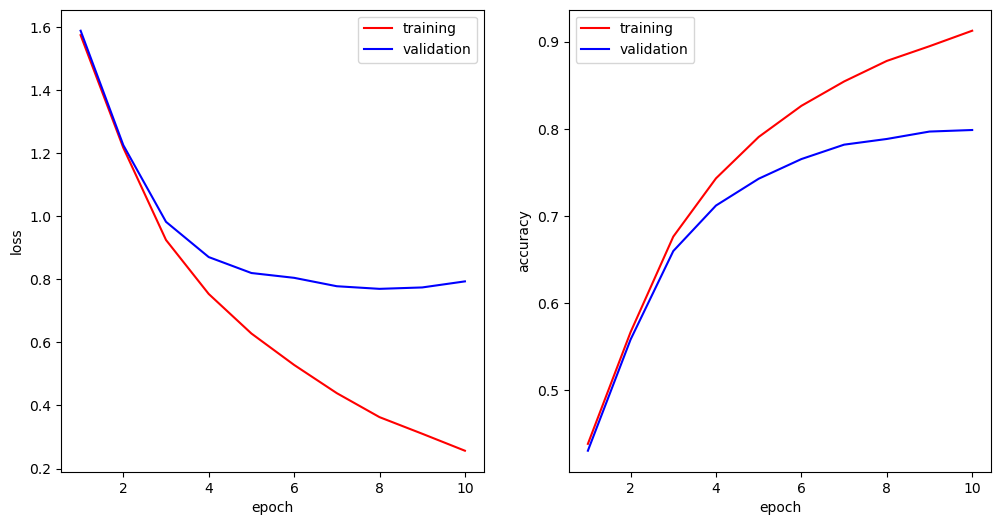

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5001 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 4998 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 1.3891, Accuracy = 0.5094
client 2 : Loss = 1.5263, Accuracy = 0.4612
client 3 : Loss = 1.4186, Accuracy = 0.4947
client 4 : Loss = 1.3196, Accuracy = 0.5296
client 5 : Loss = 1.5152, Accuracy = 0.4680
client 6 : Loss = 1.3471, Accuracy = 0.5285
client 7 : Loss = 1.4974, Accuracy = 0.4775
client 8 : Loss = 1.2946, Accuracy = 0.5353

Server :
    - training loss = 1.4988
    - training accuracy = 0.4609
    - validation loss = 1.5086
    - validation accuracy = 0.4586
        
>>> Round 2 ...
client 1 : Loss = 1.0315, Accuracy = 0.6241
client 2 : Loss = 1.0661, Accuracy = 0.6243
client 3 : Loss = 1.0774, Accuracy = 0.6194
client 4 : Loss = 1.0349, Accuracy = 0.6292
client 5 : Loss = 1.1297, Accuracy = 0.5893
client 6 : Loss = 1.0692, Accuracy = 0.6173
clie

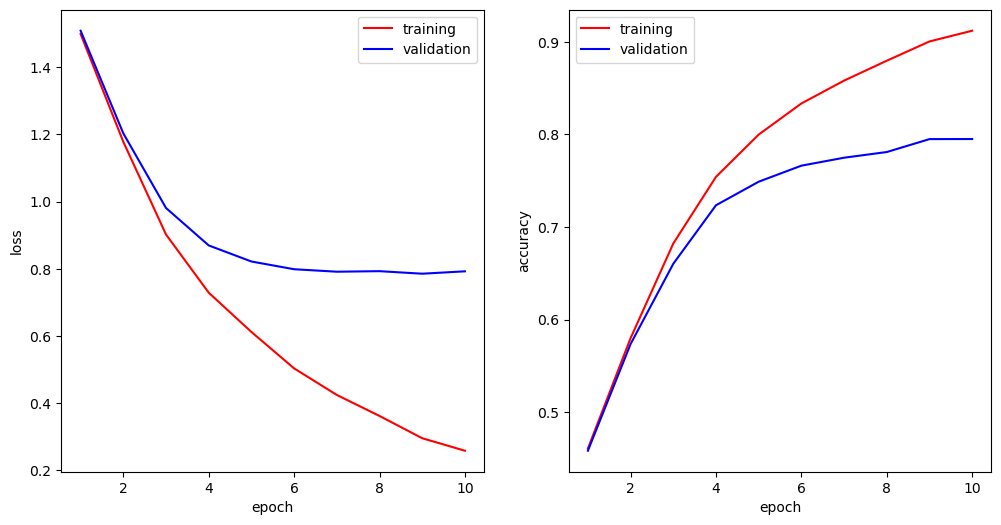

Fold #2
client 1 : 5000 samples
client 2 : 5001 samples
client 3 : 4998 samples
client 4 : 5001 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5000 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.2853, Accuracy = 0.5520
client 2 : Loss = 1.3160, Accuracy = 0.5300
client 3 : Loss = 1.3447, Accuracy = 0.5177
client 4 : Loss = 1.2827, Accuracy = 0.5505
client 5 : Loss = 1.3727, Accuracy = 0.5068
client 6 : Loss = 1.4925, Accuracy = 0.4637
client 7 : Loss = 1.3478, Accuracy = 0.5029
client 8 : Loss = 1.3972, Accuracy = 0.5027

Server :
    - training loss = 1.5730
    - training accuracy = 0.4418
    - validation loss = 1.5871
    - validation accuracy = 0.4382
        
>>> Round 2 ...
client 1 : Loss = 1.1020, Accuracy = 0.6041
client 2 : Loss = 1.0366, Accuracy = 0.6295
client 3 : Loss = 1.0025, Accuracy = 0.6487
client 4 : Loss = 0.9877, Accuracy = 0.6410
client 5 : Loss = 1.0277, Accuracy = 0.6391
client 6 : Loss = 1.0124, Accuracy = 0.6375
clie

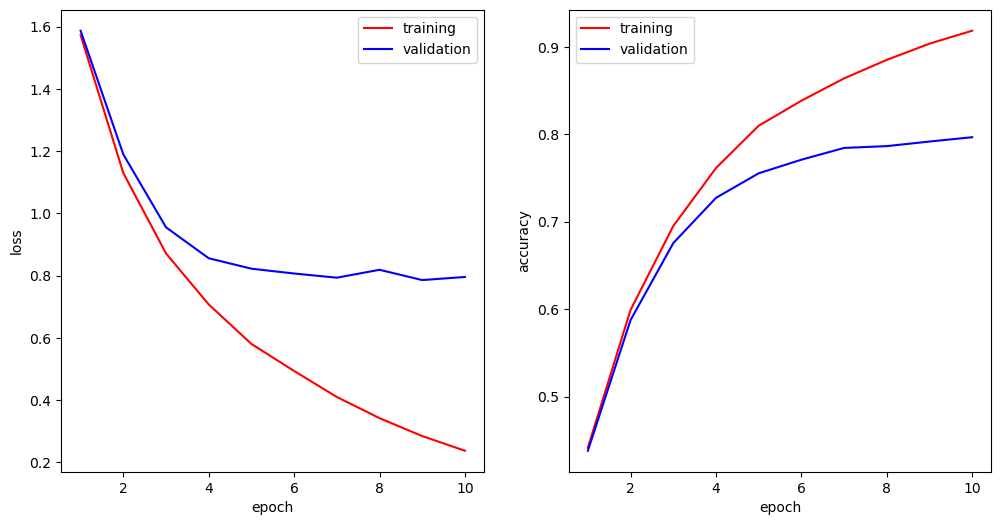

Fold #3
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 5003 samples
client 5 : 4997 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.3949, Accuracy = 0.5180
client 2 : Loss = 1.5194, Accuracy = 0.4820
client 3 : Loss = 1.2541, Accuracy = 0.5486
client 4 : Loss = 1.3032, Accuracy = 0.5403
client 5 : Loss = 1.6975, Accuracy = 0.4176
client 6 : Loss = 1.2746, Accuracy = 0.5496
client 7 : Loss = 1.4357, Accuracy = 0.4972
client 8 : Loss = 1.4175, Accuracy = 0.5049

Server :
    - training loss = 1.5494
    - training accuracy = 0.4537
    - validation loss = 1.5636
    - validation accuracy = 0.4487
        
>>> Round 2 ...
client 1 : Loss = 1.1460, Accuracy = 0.5859
client 2 : Loss = 1.1482, Accuracy = 0.5908
client 3 : Loss = 1.1248, Accuracy = 0.6068
client 4 : Loss = 0.9612, Accuracy = 0.6498
client 5 : Loss = 1.2153, Accuracy = 0.5721
client 6 : Loss = 1.0563, Accuracy = 0.6337
clie

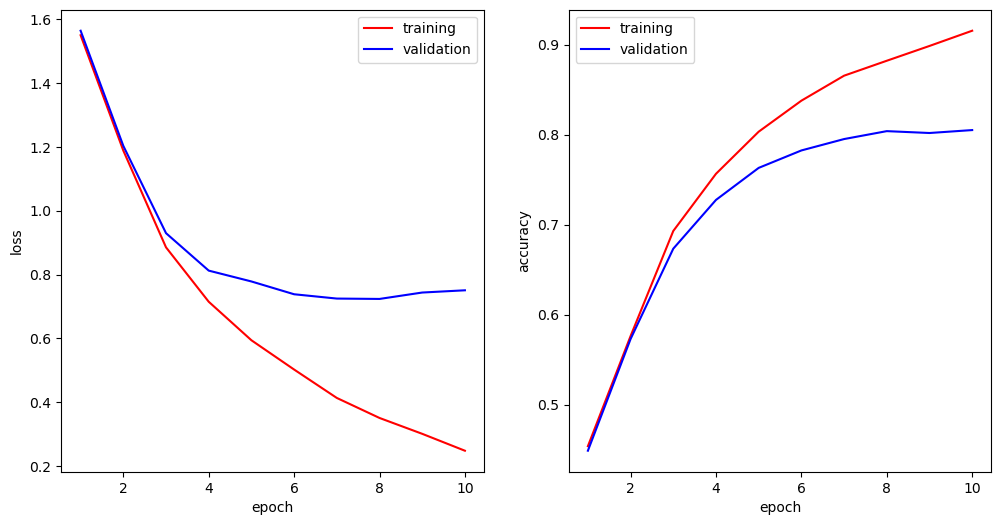

Fold #4
client 1 : 5001 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 5000 samples
client 5 : 4999 samples
client 6 : 5000 samples
client 7 : 4999 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.4346, Accuracy = 0.5013
client 2 : Loss = 1.5546, Accuracy = 0.4584
client 3 : Loss = 1.4859, Accuracy = 0.4664
client 4 : Loss = 1.5234, Accuracy = 0.4520
client 5 : Loss = 1.4218, Accuracy = 0.4947
client 6 : Loss = 1.4615, Accuracy = 0.4871
client 7 : Loss = 1.3323, Accuracy = 0.5116
client 8 : Loss = 1.4080, Accuracy = 0.5051

Server :
    - training loss = 1.5781
    - training accuracy = 0.4325
    - validation loss = 1.6032
    - validation accuracy = 0.4204
        
>>> Round 2 ...
client 1 : Loss = 0.9977, Accuracy = 0.6528
client 2 : Loss = 1.1693, Accuracy = 0.5807
client 3 : Loss = 1.0550, Accuracy = 0.6131
client 4 : Loss = 1.1272, Accuracy = 0.5938
client 5 : Loss = 1.1066, Accuracy = 0.6065
client 6 : Loss = 1.1224, Accuracy = 0.5910
clie

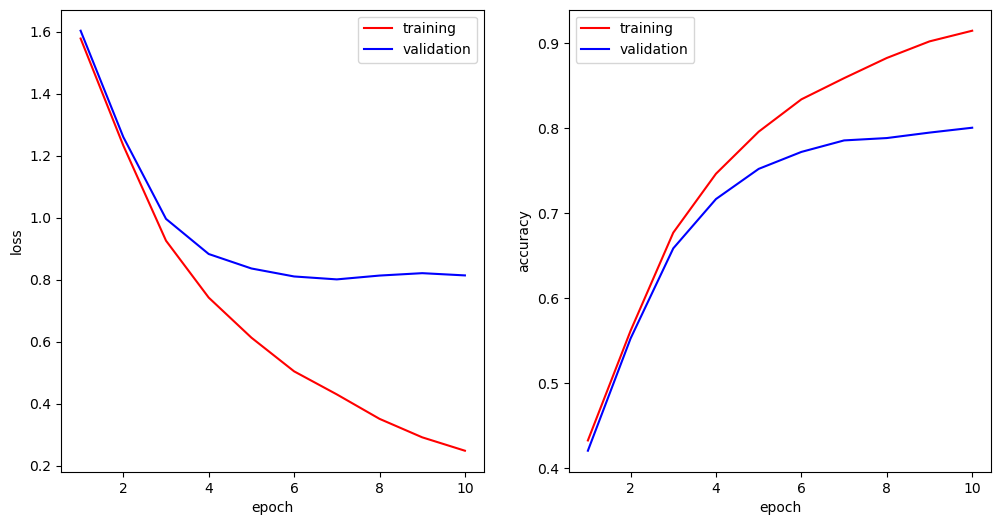

Fold #0
client 1 : 5000 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5000 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.0159, Accuracy = 0.6375
client 2 : Loss = 0.9998, Accuracy = 0.6372
client 3 : Loss = 1.1095, Accuracy = 0.6053
client 4 : Loss = 1.0156, Accuracy = 0.6537
client 5 : Loss = 1.0598, Accuracy = 0.6209
client 6 : Loss = 1.0490, Accuracy = 0.6281
client 7 : Loss = 1.0017, Accuracy = 0.6453
client 8 : Loss = 1.0234, Accuracy = 0.6351

Server :
    - training loss = 1.2802
    - training accuracy = 0.5559
    - validation loss = 1.3240
    - validation accuracy = 0.5387
        
>>> Round 2 ...
client 1 : Loss = 0.6447, Accuracy = 0.7836
client 2 : Loss = 0.5738, Accuracy = 0.8067
client 3 : Loss = 0.6937, Accuracy = 0.7616
client 4 : Loss = 0.6591, Accuracy = 0.7768
client 5 : Loss = 0.6080, Accuracy = 0.7998
client 6 : Loss = 0.5650, Accuracy = 0.8150
clie

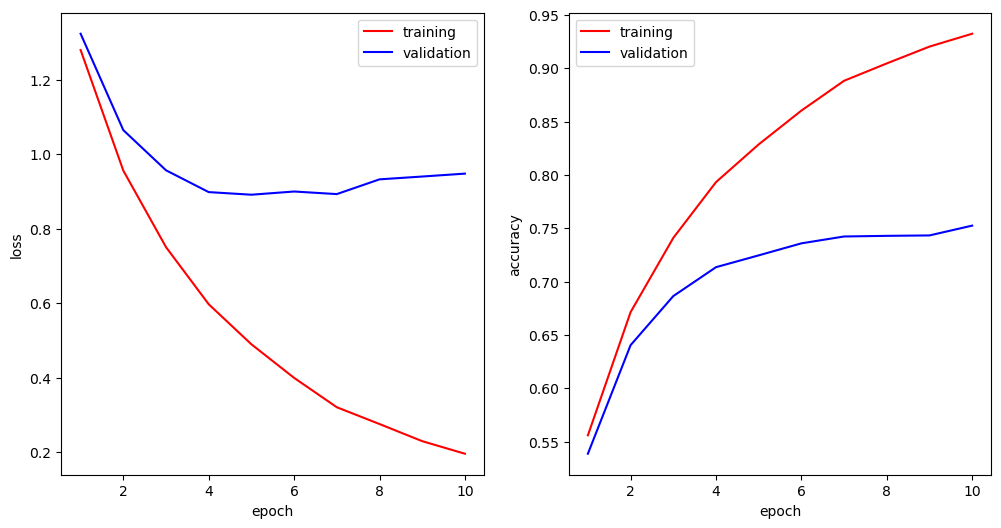

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5001 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 4998 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 0.9804, Accuracy = 0.6506
client 2 : Loss = 1.0832, Accuracy = 0.6149
client 3 : Loss = 1.0329, Accuracy = 0.6406
client 4 : Loss = 1.0137, Accuracy = 0.6391
client 5 : Loss = 1.0884, Accuracy = 0.6088
client 6 : Loss = 1.0377, Accuracy = 0.6315
client 7 : Loss = 1.1701, Accuracy = 0.5820
client 8 : Loss = 1.0057, Accuracy = 0.6466

Server :
    - training loss = 1.2850
    - training accuracy = 0.5506
    - validation loss = 1.3646
    - validation accuracy = 0.5328
        
>>> Round 2 ...
client 1 : Loss = 0.5515, Accuracy = 0.8176
client 2 : Loss = 0.7261, Accuracy = 0.7472
client 3 : Loss = 0.6454, Accuracy = 0.7797
client 4 : Loss = 0.6248, Accuracy = 0.7800
client 5 : Loss = 0.6630, Accuracy = 0.7676
client 6 : Loss = 0.7131, Accuracy = 0.7425
clie

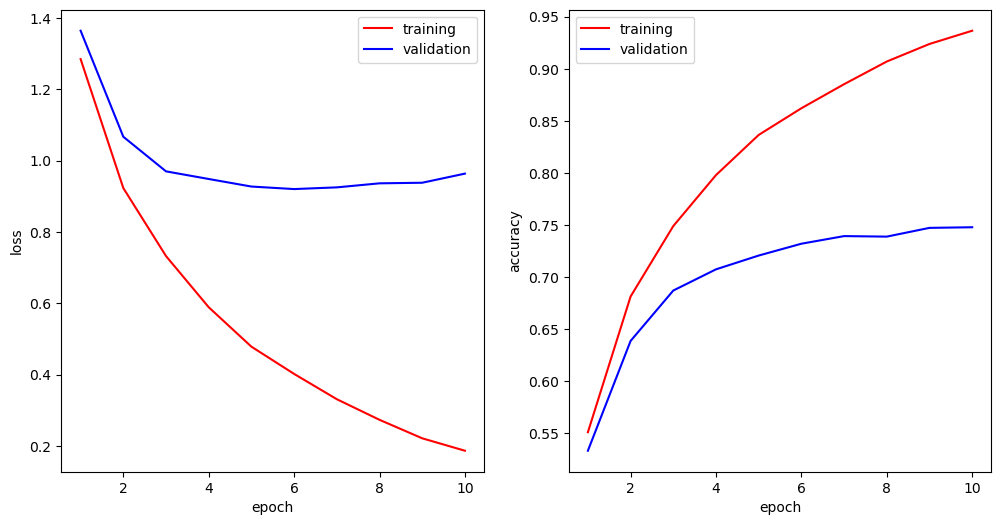

Fold #2
client 1 : 5000 samples
client 2 : 5001 samples
client 3 : 4998 samples
client 4 : 5001 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5000 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 0.9929, Accuracy = 0.6516
client 2 : Loss = 0.9188, Accuracy = 0.6723
client 3 : Loss = 1.0356, Accuracy = 0.6268
client 4 : Loss = 1.0092, Accuracy = 0.6433
client 5 : Loss = 1.0100, Accuracy = 0.6382
client 6 : Loss = 1.0100, Accuracy = 0.6303
client 7 : Loss = 1.0167, Accuracy = 0.6506
client 8 : Loss = 0.9819, Accuracy = 0.6578

Server :
    - training loss = 1.2571
    - training accuracy = 0.5669
    - validation loss = 1.3411
    - validation accuracy = 0.5404
        
>>> Round 2 ...
client 1 : Loss = 0.5015, Accuracy = 0.8340
client 2 : Loss = 0.5833, Accuracy = 0.7990
client 3 : Loss = 0.5803, Accuracy = 0.7946
client 4 : Loss = 0.5894, Accuracy = 0.7955
client 5 : Loss = 0.5724, Accuracy = 0.8032
client 6 : Loss = 0.5460, Accuracy = 0.8195
clie

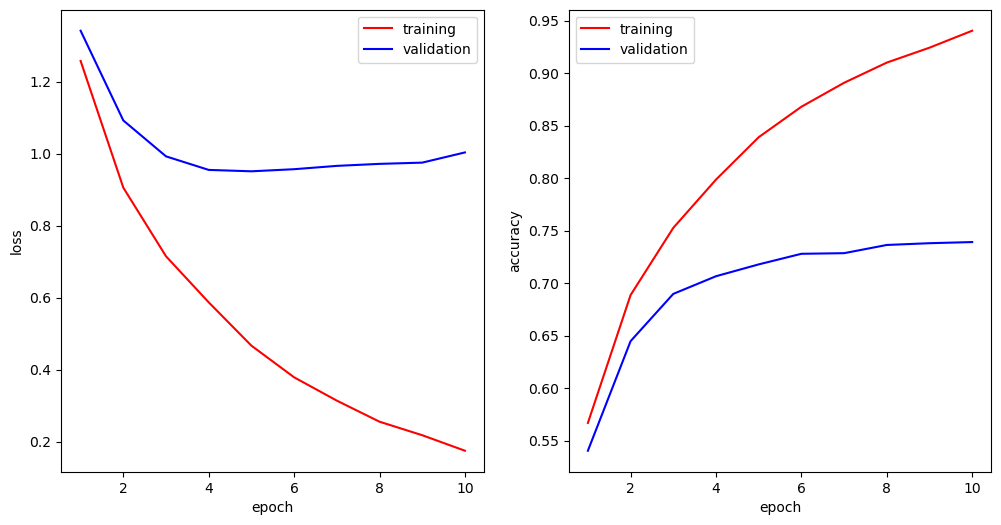

Fold #3
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 5003 samples
client 5 : 4997 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.0471, Accuracy = 0.6334
client 2 : Loss = 1.0648, Accuracy = 0.6225
client 3 : Loss = 1.0231, Accuracy = 0.6412
client 4 : Loss = 1.0687, Accuracy = 0.6194
client 5 : Loss = 1.1547, Accuracy = 0.5986
client 6 : Loss = 1.1114, Accuracy = 0.6042
client 7 : Loss = 1.0056, Accuracy = 0.6451
client 8 : Loss = 1.0556, Accuracy = 0.6232

Server :
    - training loss = 1.3167
    - training accuracy = 0.5451
    - validation loss = 1.3664
    - validation accuracy = 0.5245
        
>>> Round 2 ...
client 1 : Loss = 0.6505, Accuracy = 0.7738
client 2 : Loss = 0.5762, Accuracy = 0.8129
client 3 : Loss = 0.6714, Accuracy = 0.7705
client 4 : Loss = 0.5748, Accuracy = 0.8060
client 5 : Loss = 0.7849, Accuracy = 0.7130
client 6 : Loss = 0.6435, Accuracy = 0.7793
clie

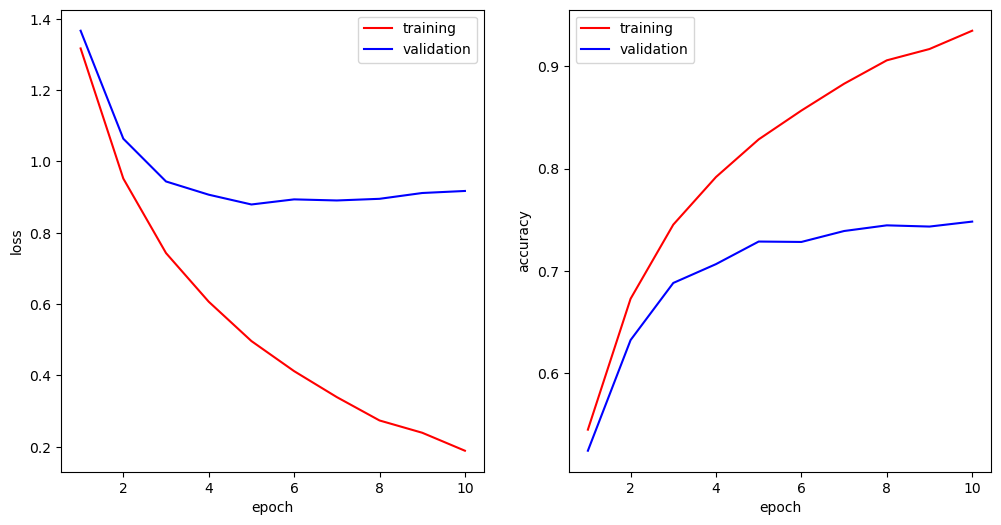

Fold #4
client 1 : 5001 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 5000 samples
client 5 : 4999 samples
client 6 : 5000 samples
client 7 : 4999 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 0.9823, Accuracy = 0.6436
client 2 : Loss = 1.0789, Accuracy = 0.6305
client 3 : Loss = 0.9538, Accuracy = 0.6635
client 4 : Loss = 0.9861, Accuracy = 0.6531
client 5 : Loss = 0.9502, Accuracy = 0.6621
client 6 : Loss = 0.9454, Accuracy = 0.6660
client 7 : Loss = 0.9908, Accuracy = 0.6410
client 8 : Loss = 1.0155, Accuracy = 0.6452

Server :
    - training loss = 1.2362
    - training accuracy = 0.5694
    - validation loss = 1.3047
    - validation accuracy = 0.5525
        
>>> Round 2 ...
client 1 : Loss = 0.5622, Accuracy = 0.8120
client 2 : Loss = 0.5808, Accuracy = 0.8006
client 3 : Loss = 0.6608, Accuracy = 0.7721
client 4 : Loss = 0.5418, Accuracy = 0.8166
client 5 : Loss = 0.5513, Accuracy = 0.8150
client 6 : Loss = 0.5552, Accuracy = 0.8170
clie

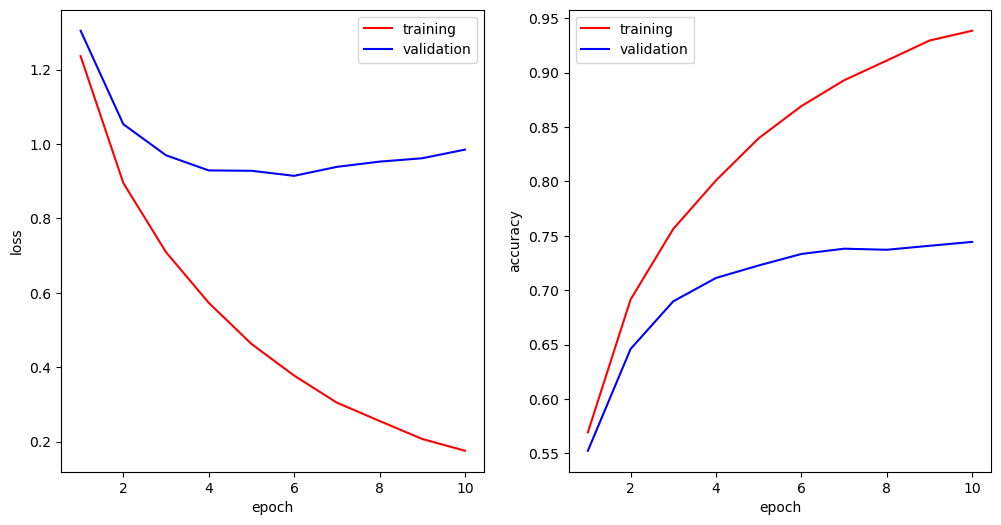

RESULTS
lr = 0.0100 : Accuracy = 0.7881131172180176
lr = 0.0050 : Accuracy = 0.7992286682128906
lr = 0.0010 : Accuracy = 0.7464003562927246

CPU times: user 2h 29min 18s, sys: 21.5 s, total: 2h 29min 40s
Wall time: 2h 30min 19s


In [17]:
%%time
n_splits = 5
rounds = 10
batch_size = 128
epochs = 5
lrs = [1e-2,5e-3,1e-3]#[1e-1,1e-2,1e-3,1e-4]
optimizer = optim.Adam

results = []
for lr in lrs:
    res = run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr)
    results.append((lr,res))
    
print("="*25)
print(f"RESULTS")
print("="*25)
for lr,res in results:
    print(f"lr = {lr:.4f} : Accuracy = {res}")
print()


### Summary: Best result achieved with lr = 0.005

### 2.2 Selecting betas for lr=0.005 

Fold #0
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5003 samples
client 5 : 4998 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.3303, Accuracy = 0.5455
client 2 : Loss = 1.2459, Accuracy = 0.5846
client 3 : Loss = 1.2487, Accuracy = 0.5561
client 4 : Loss = 1.2579, Accuracy = 0.5578
client 5 : Loss = 1.3668, Accuracy = 0.5441
client 6 : Loss = 1.3244, Accuracy = 0.5572
client 7 : Loss = 1.2960, Accuracy = 0.5469
client 8 : Loss = 1.3903, Accuracy = 0.5389

Server :
    - training loss = 1.7033
    - training accuracy = 0.4066
    - validation loss = 1.7030
    - validation accuracy = 0.4057
        
>>> Round 2 ...
client 1 : Loss = 0.8736, Accuracy = 0.6936
client 2 : Loss = 0.8794, Accuracy = 0.6864
client 3 : Loss = 0.9241, Accuracy = 0.6865
client 4 : Loss = 0.8762, Accuracy = 0.6940
client 5 : Loss = 0.8365, Accuracy = 0.7023
client 6 : Loss = 0.9224, Accuracy = 0.6778
clie

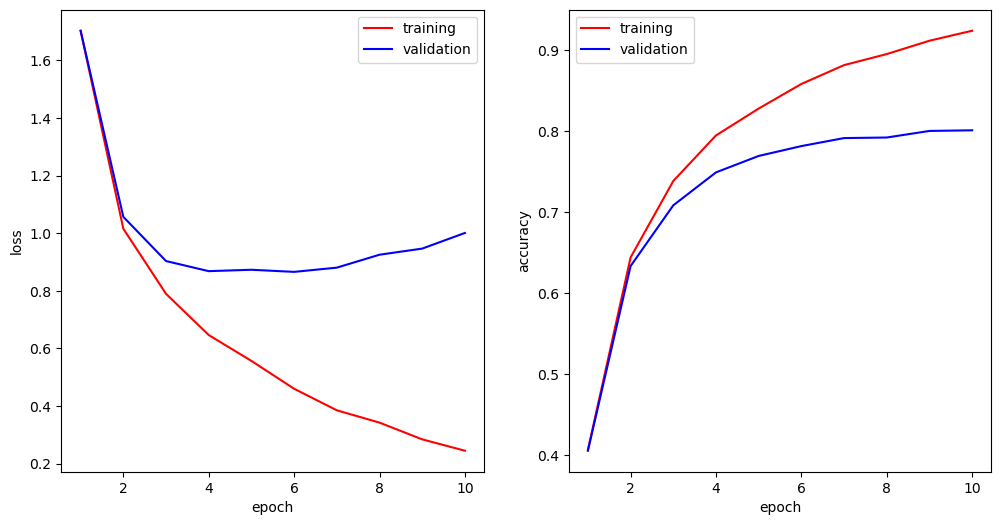

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4997 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.2560, Accuracy = 0.5752
client 2 : Loss = 1.2310, Accuracy = 0.5652
client 3 : Loss = 1.3150, Accuracy = 0.5561
client 4 : Loss = 1.1476, Accuracy = 0.5891
client 5 : Loss = 1.3096, Accuracy = 0.5486
client 6 : Loss = 1.2398, Accuracy = 0.5733
client 7 : Loss = 1.3657, Accuracy = 0.5455
client 8 : Loss = 1.3381, Accuracy = 0.5424

Server :
    - training loss = 1.5442
    - training accuracy = 0.4551
    - validation loss = 1.5515
    - validation accuracy = 0.4473
        
>>> Round 2 ...
client 1 : Loss = 0.9124, Accuracy = 0.6732
client 2 : Loss = 0.8889, Accuracy = 0.6884
client 3 : Loss = 0.9142, Accuracy = 0.6777
client 4 : Loss = 0.8582, Accuracy = 0.6922
client 5 : Loss = 0.9385, Accuracy = 0.6707
client 6 : Loss = 0.8736, Accuracy = 0.6915
clie

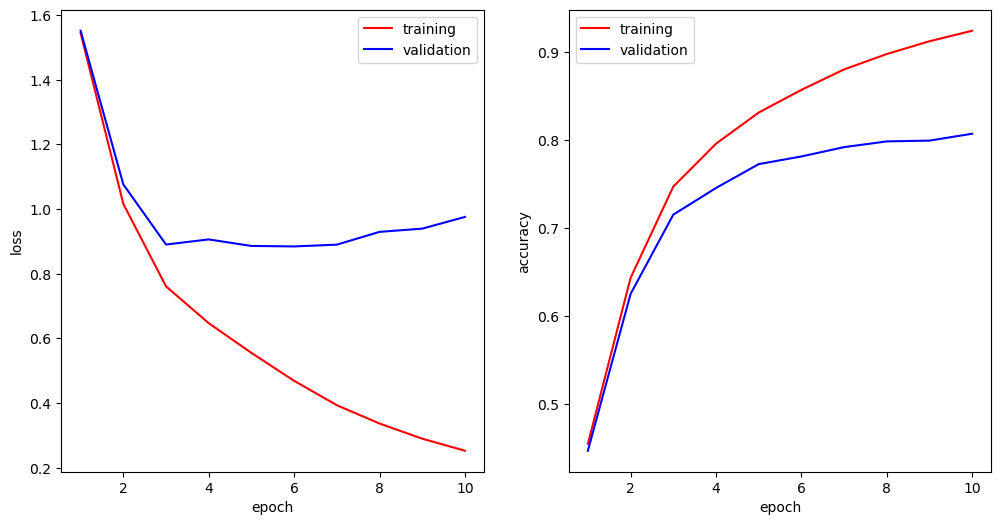

Fold #2
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 4999 samples
client 4 : 5002 samples
client 5 : 5001 samples
client 6 : 4998 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.3566, Accuracy = 0.5330
client 2 : Loss = 1.2109, Accuracy = 0.5826
client 3 : Loss = 1.2734, Accuracy = 0.5402
client 4 : Loss = 1.3153, Accuracy = 0.5572
client 5 : Loss = 1.2818, Accuracy = 0.5688
client 6 : Loss = 1.2854, Accuracy = 0.5495
client 7 : Loss = 1.2746, Accuracy = 0.5558
client 8 : Loss = 1.3303, Accuracy = 0.5431

Server :
    - training loss = 1.5770
    - training accuracy = 0.4322
    - validation loss = 1.5941
    - validation accuracy = 0.4313
        
>>> Round 2 ...
client 1 : Loss = 0.9055, Accuracy = 0.6861
client 2 : Loss = 0.8650, Accuracy = 0.6848
client 3 : Loss = 0.9036, Accuracy = 0.6743
client 4 : Loss = 0.9345, Accuracy = 0.6711
client 5 : Loss = 0.9162, Accuracy = 0.6733
client 6 : Loss = 0.8857, Accuracy = 0.6874
clie

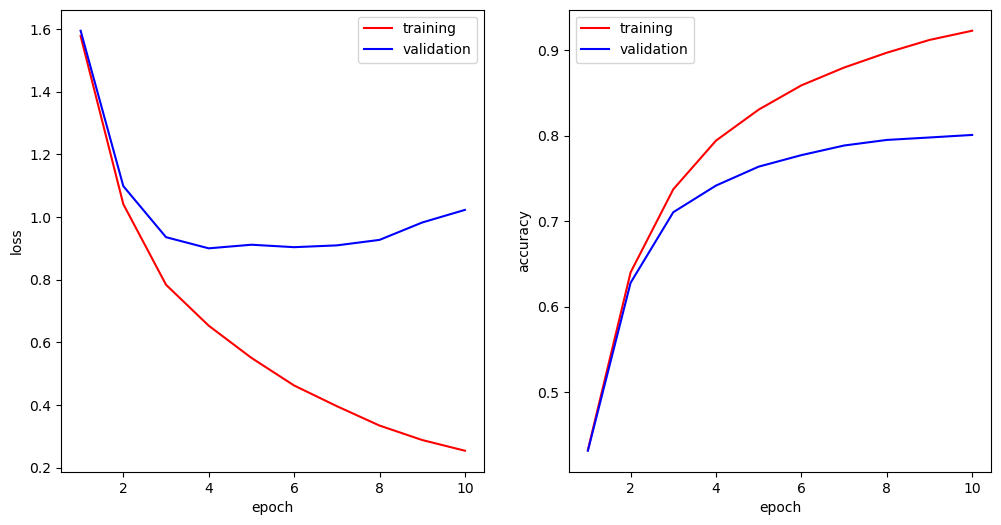

Fold #3
client 1 : 4999 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5002 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.2059, Accuracy = 0.5709
client 2 : Loss = 1.4108, Accuracy = 0.5306
client 3 : Loss = 1.2784, Accuracy = 0.5501
client 4 : Loss = 1.3084, Accuracy = 0.5447
client 5 : Loss = 1.2740, Accuracy = 0.5557
client 6 : Loss = 1.2607, Accuracy = 0.5549
client 7 : Loss = 1.2911, Accuracy = 0.5635
client 8 : Loss = 1.2735, Accuracy = 0.5509

Server :
    - training loss = 1.5286
    - training accuracy = 0.4468
    - validation loss = 1.5382
    - validation accuracy = 0.4448
        
>>> Round 2 ...
client 1 : Loss = 0.9443, Accuracy = 0.6694
client 2 : Loss = 0.9376, Accuracy = 0.6700
client 3 : Loss = 0.9010, Accuracy = 0.6738
client 4 : Loss = 0.8979, Accuracy = 0.6808
client 5 : Loss = 0.8699, Accuracy = 0.6922
client 6 : Loss = 0.8926, Accuracy = 0.6840
clie

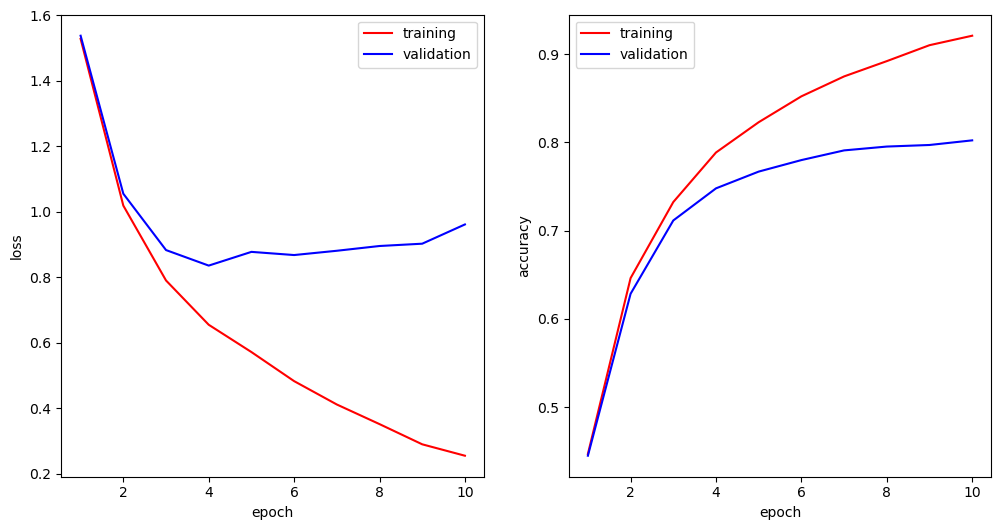

Fold #4
client 1 : 5001 samples
client 2 : 4998 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 5000 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.2468, Accuracy = 0.5686
client 2 : Loss = 1.3289, Accuracy = 0.5443
client 3 : Loss = 1.1887, Accuracy = 0.5821
client 4 : Loss = 1.3686, Accuracy = 0.5521
client 5 : Loss = 1.3004, Accuracy = 0.5508
client 6 : Loss = 1.2525, Accuracy = 0.5642
client 7 : Loss = 1.3428, Accuracy = 0.5271
client 8 : Loss = 1.2160, Accuracy = 0.5703

Server :
    - training loss = 1.6795
    - training accuracy = 0.3905
    - validation loss = 1.7045
    - validation accuracy = 0.3809
        
>>> Round 2 ...
client 1 : Loss = 0.9331, Accuracy = 0.6728
client 2 : Loss = 0.9454, Accuracy = 0.6715
client 3 : Loss = 0.9106, Accuracy = 0.6800
client 4 : Loss = 0.8981, Accuracy = 0.6779
client 5 : Loss = 0.9220, Accuracy = 0.6756
client 6 : Loss = 0.9588, Accuracy = 0.6614
clie

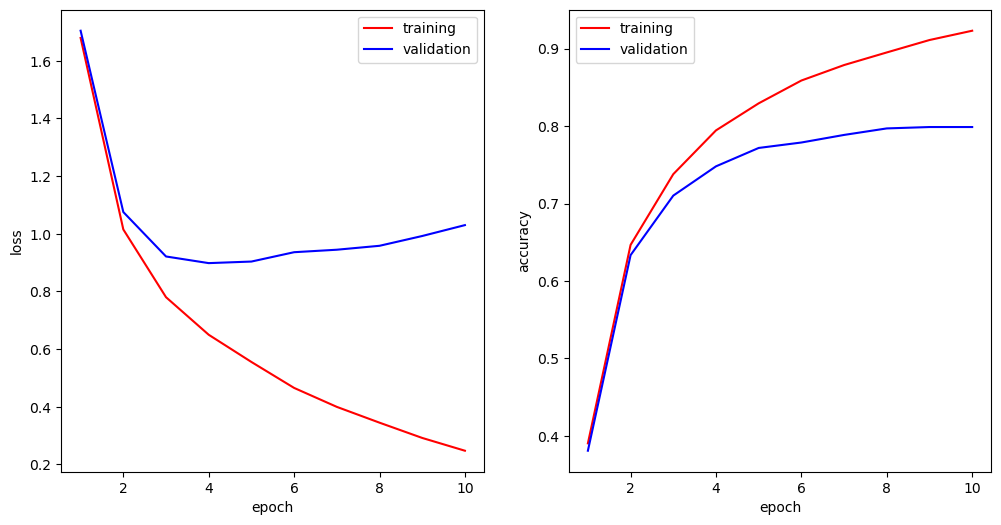

Fold #0
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5003 samples
client 5 : 4998 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.4111, Accuracy = 0.5070
client 2 : Loss = 1.3285, Accuracy = 0.5432
client 3 : Loss = 1.3513, Accuracy = 0.5230
client 4 : Loss = 1.3255, Accuracy = 0.5290
client 5 : Loss = 1.4185, Accuracy = 0.4993
client 6 : Loss = 1.3551, Accuracy = 0.5324
client 7 : Loss = 1.3502, Accuracy = 0.5253
client 8 : Loss = 1.2893, Accuracy = 0.5492

Server :
    - training loss = 1.5486
    - training accuracy = 0.4410
    - validation loss = 1.5592
    - validation accuracy = 0.4431
        
>>> Round 2 ...
client 1 : Loss = 0.8761, Accuracy = 0.6744
client 2 : Loss = 0.9288, Accuracy = 0.6746
client 3 : Loss = 0.9096, Accuracy = 0.6744
client 4 : Loss = 0.9160, Accuracy = 0.6720
client 5 : Loss = 0.9681, Accuracy = 0.6523
client 6 : Loss = 0.8856, Accuracy = 0.6854
clie

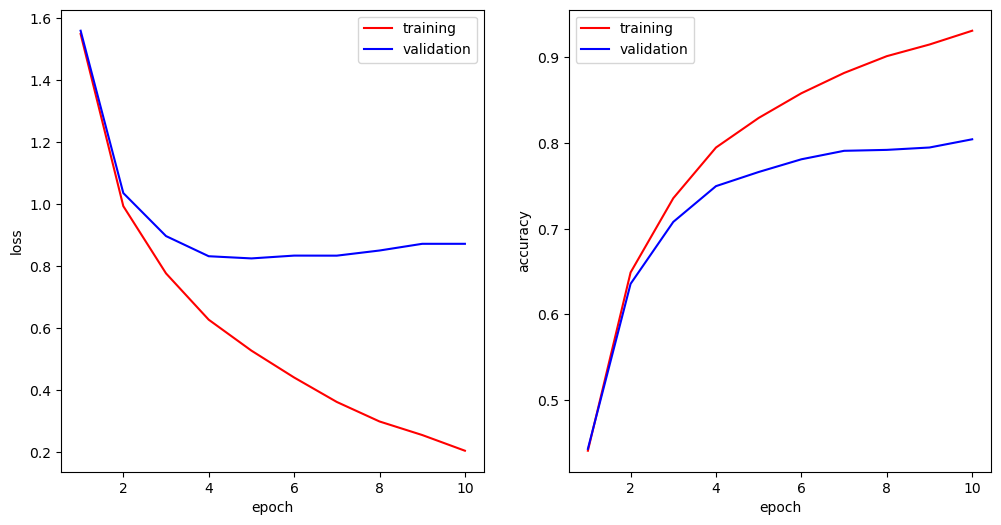

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4997 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.3282, Accuracy = 0.5330
client 2 : Loss = 1.3141, Accuracy = 0.5385
client 3 : Loss = 1.4303, Accuracy = 0.4946
client 4 : Loss = 1.3676, Accuracy = 0.5178
client 5 : Loss = 1.4003, Accuracy = 0.5060
client 6 : Loss = 1.2965, Accuracy = 0.5379
client 7 : Loss = 1.4359, Accuracy = 0.5064
client 8 : Loss = 1.3254, Accuracy = 0.5324

Server :
    - training loss = 1.4443
    - training accuracy = 0.4788
    - validation loss = 1.4528
    - validation accuracy = 0.4825
        
>>> Round 2 ...
client 1 : Loss = 0.9343, Accuracy = 0.6615
client 2 : Loss = 0.9442, Accuracy = 0.6583
client 3 : Loss = 0.9153, Accuracy = 0.6689
client 4 : Loss = 0.9033, Accuracy = 0.6826
client 5 : Loss = 0.9155, Accuracy = 0.6714
client 6 : Loss = 0.8684, Accuracy = 0.6886
clie

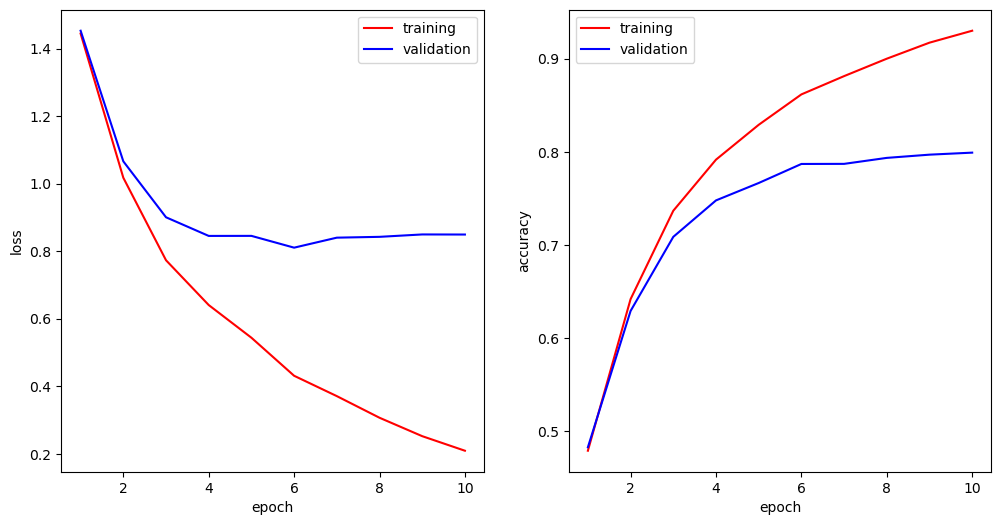

Fold #2
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 4999 samples
client 4 : 5002 samples
client 5 : 5001 samples
client 6 : 4998 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.4667, Accuracy = 0.4982
client 2 : Loss = 1.3634, Accuracy = 0.5232
client 3 : Loss = 1.4131, Accuracy = 0.5081
client 4 : Loss = 1.3411, Accuracy = 0.5224
client 5 : Loss = 1.3076, Accuracy = 0.5401
client 6 : Loss = 1.4421, Accuracy = 0.4905
client 7 : Loss = 1.4085, Accuracy = 0.5141
client 8 : Loss = 1.4834, Accuracy = 0.4888

Server :
    - training loss = 1.4952
    - training accuracy = 0.4572
    - validation loss = 1.5109
    - validation accuracy = 0.4495
        
>>> Round 2 ...
client 1 : Loss = 0.9537, Accuracy = 0.6576
client 2 : Loss = 0.9626, Accuracy = 0.6666
client 3 : Loss = 0.9404, Accuracy = 0.6602
client 4 : Loss = 0.9436, Accuracy = 0.6638
client 5 : Loss = 0.9297, Accuracy = 0.6559
client 6 : Loss = 0.9431, Accuracy = 0.6609
clie

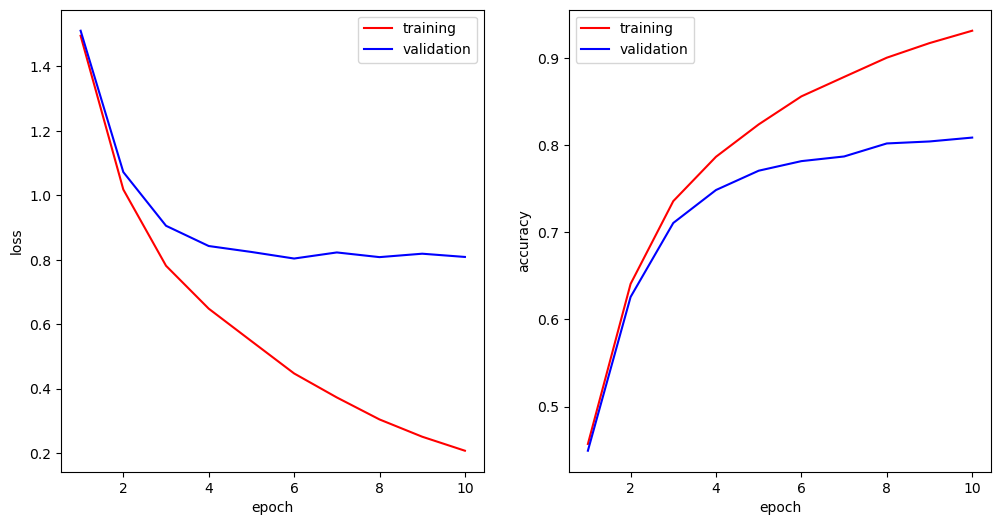

Fold #3
client 1 : 4999 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5002 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.4185, Accuracy = 0.5180
client 2 : Loss = 1.2813, Accuracy = 0.5563
client 3 : Loss = 1.2949, Accuracy = 0.5424
client 4 : Loss = 1.3472, Accuracy = 0.5311
client 5 : Loss = 1.4369, Accuracy = 0.4961
client 6 : Loss = 1.3235, Accuracy = 0.5343
client 7 : Loss = 1.3897, Accuracy = 0.5023
client 8 : Loss = 1.3735, Accuracy = 0.5273

Server :
    - training loss = 1.4795
    - training accuracy = 0.4805
    - validation loss = 1.4847
    - validation accuracy = 0.4837
        
>>> Round 2 ...
client 1 : Loss = 0.8981, Accuracy = 0.6838
client 2 : Loss = 0.8875, Accuracy = 0.6913
client 3 : Loss = 0.8809, Accuracy = 0.6799
client 4 : Loss = 0.8464, Accuracy = 0.6942
client 5 : Loss = 0.9255, Accuracy = 0.6646
client 6 : Loss = 0.9178, Accuracy = 0.6657
clie

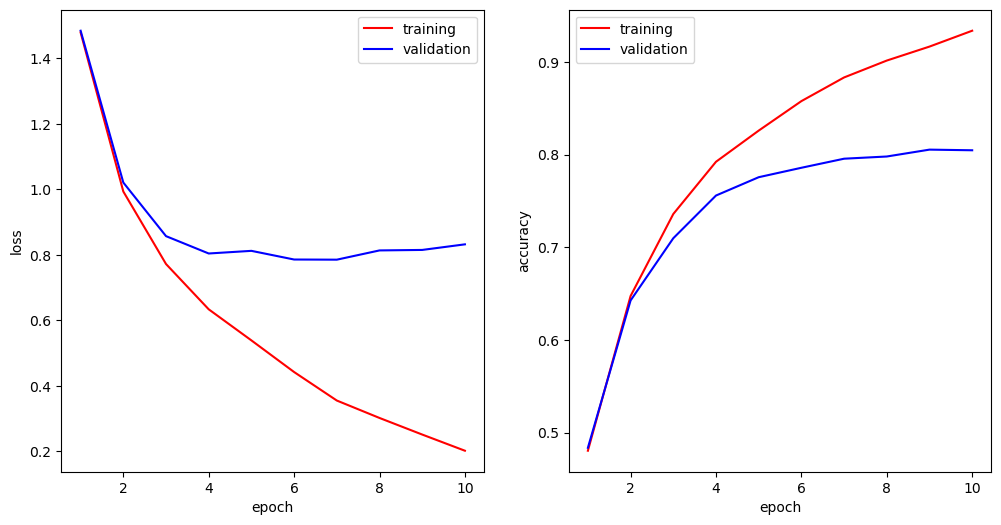

Fold #4
client 1 : 5001 samples
client 2 : 4998 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 5000 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.3533, Accuracy = 0.5263
client 2 : Loss = 1.3568, Accuracy = 0.5240
client 3 : Loss = 1.2473, Accuracy = 0.5662
client 4 : Loss = 1.3421, Accuracy = 0.5201
client 5 : Loss = 1.2842, Accuracy = 0.5436
client 6 : Loss = 1.3773, Accuracy = 0.5192
client 7 : Loss = 1.3015, Accuracy = 0.5437
client 8 : Loss = 1.3016, Accuracy = 0.5410

Server :
    - training loss = 1.4790
    - training accuracy = 0.4739
    - validation loss = 1.5070
    - validation accuracy = 0.4674
        
>>> Round 2 ...
client 1 : Loss = 0.8694, Accuracy = 0.6970
client 2 : Loss = 0.9067, Accuracy = 0.6859
client 3 : Loss = 0.8431, Accuracy = 0.7014
client 4 : Loss = 0.8969, Accuracy = 0.6760
client 5 : Loss = 0.8987, Accuracy = 0.6748
client 6 : Loss = 0.8924, Accuracy = 0.6876
clie

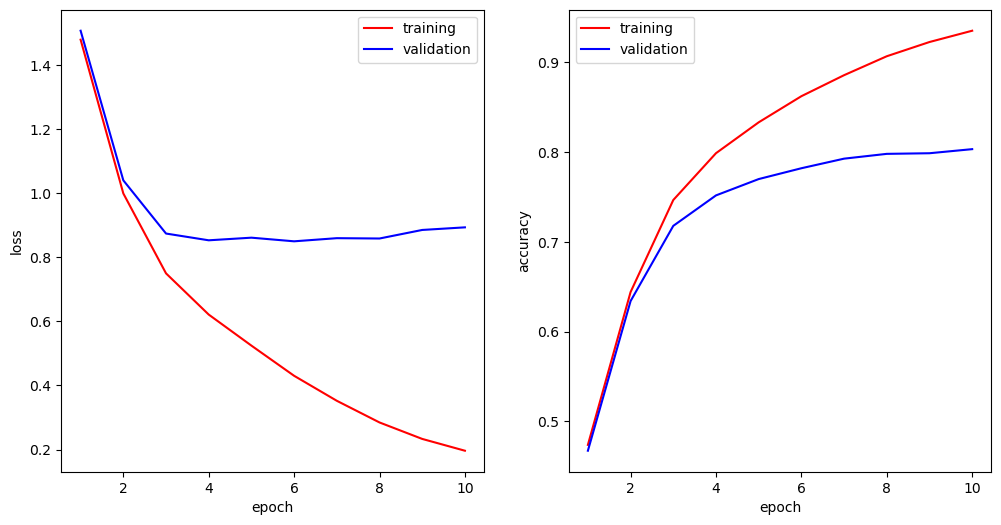

Fold #0
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5003 samples
client 5 : 4998 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.4973, Accuracy = 0.4805
client 2 : Loss = 1.3428, Accuracy = 0.5336
client 3 : Loss = 1.3332, Accuracy = 0.5301
client 4 : Loss = 1.3211, Accuracy = 0.5343
client 5 : Loss = 1.4564, Accuracy = 0.4855
client 6 : Loss = 1.4232, Accuracy = 0.5141
client 7 : Loss = 1.2981, Accuracy = 0.5462
client 8 : Loss = 1.5288, Accuracy = 0.4637

Server :
    - training loss = 1.4741
    - training accuracy = 0.4766
    - validation loss = 1.4691
    - validation accuracy = 0.4706
        
>>> Round 2 ...
client 1 : Loss = 0.9349, Accuracy = 0.6686
client 2 : Loss = 1.0404, Accuracy = 0.6329
client 3 : Loss = 1.0144, Accuracy = 0.6373
client 4 : Loss = 0.8867, Accuracy = 0.6907
client 5 : Loss = 1.0000, Accuracy = 0.6421
client 6 : Loss = 0.9049, Accuracy = 0.6751
clie

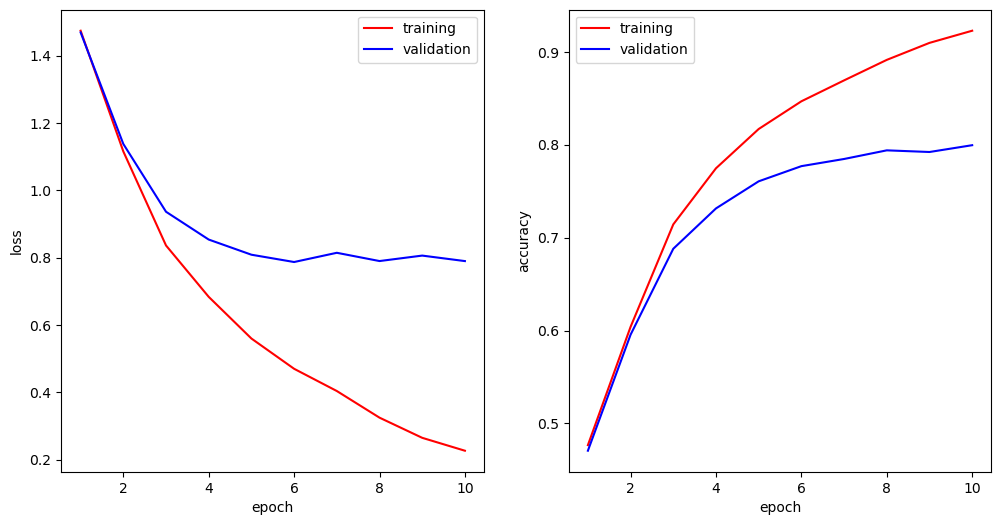

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4997 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.3478, Accuracy = 0.5248
client 2 : Loss = 1.4299, Accuracy = 0.4860
client 3 : Loss = 1.4353, Accuracy = 0.4963
client 4 : Loss = 1.5877, Accuracy = 0.4445
client 5 : Loss = 1.3424, Accuracy = 0.5313
client 6 : Loss = 1.3358, Accuracy = 0.5383
client 7 : Loss = 1.6448, Accuracy = 0.4423
client 8 : Loss = 1.3511, Accuracy = 0.5316

Server :
    - training loss = 1.4630
    - training accuracy = 0.4652
    - validation loss = 1.4796
    - validation accuracy = 0.4642
        
>>> Round 2 ...
client 1 : Loss = 0.9846, Accuracy = 0.6522
client 2 : Loss = 1.0803, Accuracy = 0.6195
client 3 : Loss = 1.0359, Accuracy = 0.6299
client 4 : Loss = 0.9819, Accuracy = 0.6480
client 5 : Loss = 0.9785, Accuracy = 0.6493
client 6 : Loss = 0.9744, Accuracy = 0.6571
clie

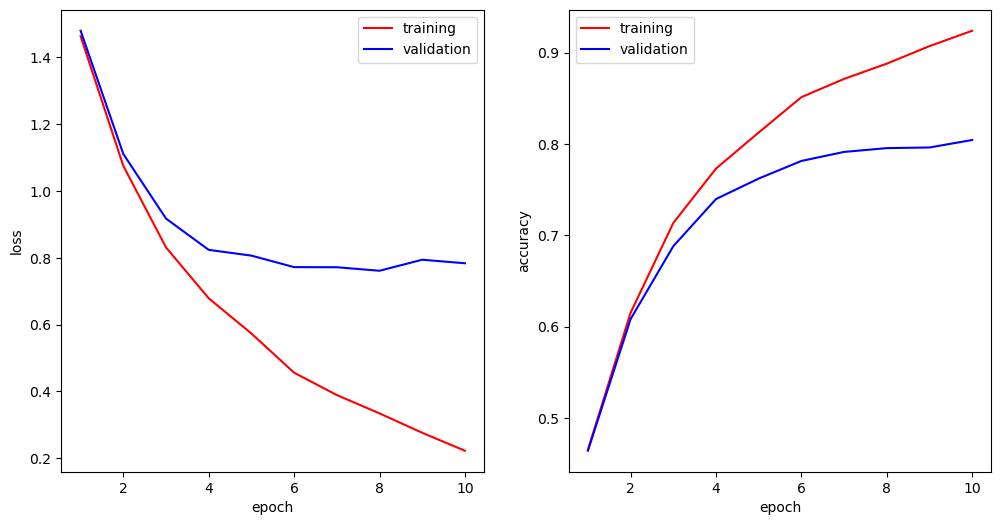

Fold #2
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 4999 samples
client 4 : 5002 samples
client 5 : 5001 samples
client 6 : 4998 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.4228, Accuracy = 0.4988
client 2 : Loss = 1.4241, Accuracy = 0.5064
client 3 : Loss = 1.4479, Accuracy = 0.4979
client 4 : Loss = 1.4202, Accuracy = 0.5095
client 5 : Loss = 1.4076, Accuracy = 0.5033
client 6 : Loss = 1.4648, Accuracy = 0.4765
client 7 : Loss = 1.3423, Accuracy = 0.5267
client 8 : Loss = 1.4655, Accuracy = 0.4956

Server :
    - training loss = 1.5148
    - training accuracy = 0.4514
    - validation loss = 1.5351
    - validation accuracy = 0.4411
        
>>> Round 2 ...
client 1 : Loss = 1.0257, Accuracy = 0.6350
client 2 : Loss = 1.0254, Accuracy = 0.6334
client 3 : Loss = 1.0617, Accuracy = 0.6079
client 4 : Loss = 0.9119, Accuracy = 0.6684
client 5 : Loss = 0.9973, Accuracy = 0.6461
client 6 : Loss = 1.1162, Accuracy = 0.6010
clie

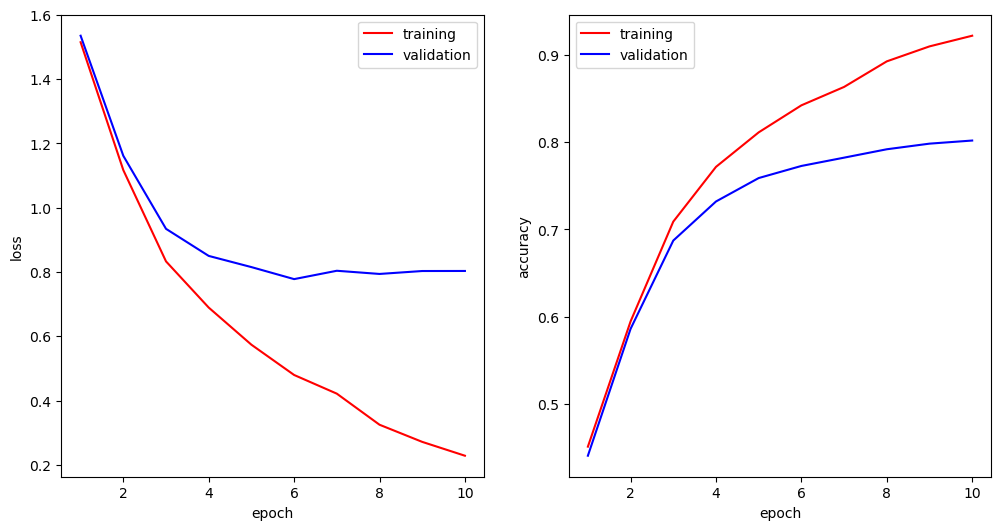

Fold #3
client 1 : 4999 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5002 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.4570, Accuracy = 0.4890
client 2 : Loss = 1.3778, Accuracy = 0.5134
client 3 : Loss = 1.4919, Accuracy = 0.4683
client 4 : Loss = 1.3256, Accuracy = 0.5330
client 5 : Loss = 1.3980, Accuracy = 0.5090
client 6 : Loss = 1.2315, Accuracy = 0.5604
client 7 : Loss = 1.3085, Accuracy = 0.5407
client 8 : Loss = 1.2547, Accuracy = 0.5590

Server :
    - training loss = 1.4547
    - training accuracy = 0.4840
    - validation loss = 1.4639
    - validation accuracy = 0.4812
        
>>> Round 2 ...
client 1 : Loss = 0.9974, Accuracy = 0.6395
client 2 : Loss = 0.9956, Accuracy = 0.6505
client 3 : Loss = 1.1026, Accuracy = 0.6101
client 4 : Loss = 0.8682, Accuracy = 0.6951
client 5 : Loss = 1.0188, Accuracy = 0.6471
client 6 : Loss = 0.9678, Accuracy = 0.6623
clie

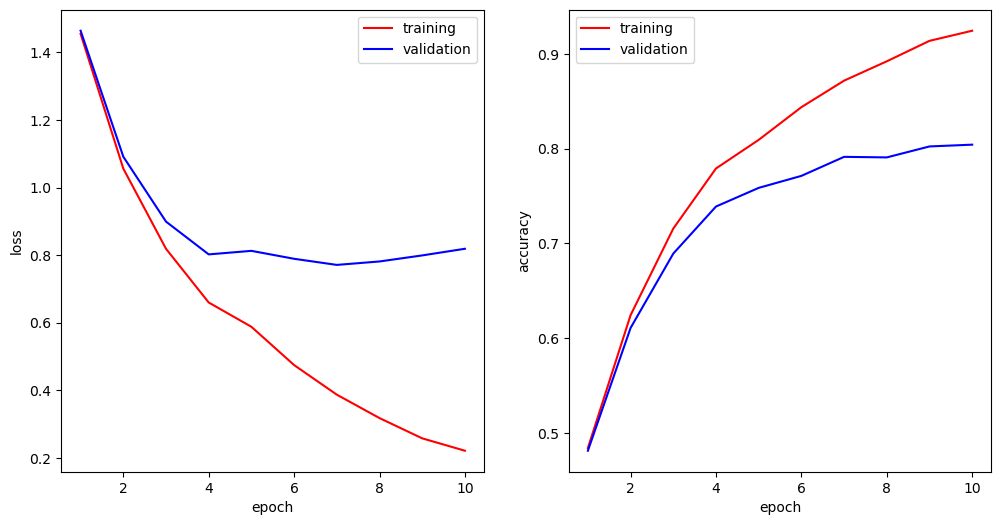

Fold #4
client 1 : 5001 samples
client 2 : 4998 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 5000 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.3706, Accuracy = 0.5101
client 2 : Loss = 1.6054, Accuracy = 0.4548
client 3 : Loss = 1.3113, Accuracy = 0.5422
client 4 : Loss = 1.3706, Accuracy = 0.5191
client 5 : Loss = 1.3689, Accuracy = 0.5135
client 6 : Loss = 1.4965, Accuracy = 0.4694
client 7 : Loss = 1.3276, Accuracy = 0.5291
client 8 : Loss = 1.2690, Accuracy = 0.5492

Server :
    - training loss = 1.4282
    - training accuracy = 0.4809
    - validation loss = 1.4560
    - validation accuracy = 0.4733
        
>>> Round 2 ...
client 1 : Loss = 0.9759, Accuracy = 0.6564
client 2 : Loss = 1.0599, Accuracy = 0.6148
client 3 : Loss = 0.9803, Accuracy = 0.6534
client 4 : Loss = 1.0503, Accuracy = 0.6309
client 5 : Loss = 1.0595, Accuracy = 0.6285
client 6 : Loss = 0.9745, Accuracy = 0.6489
clie

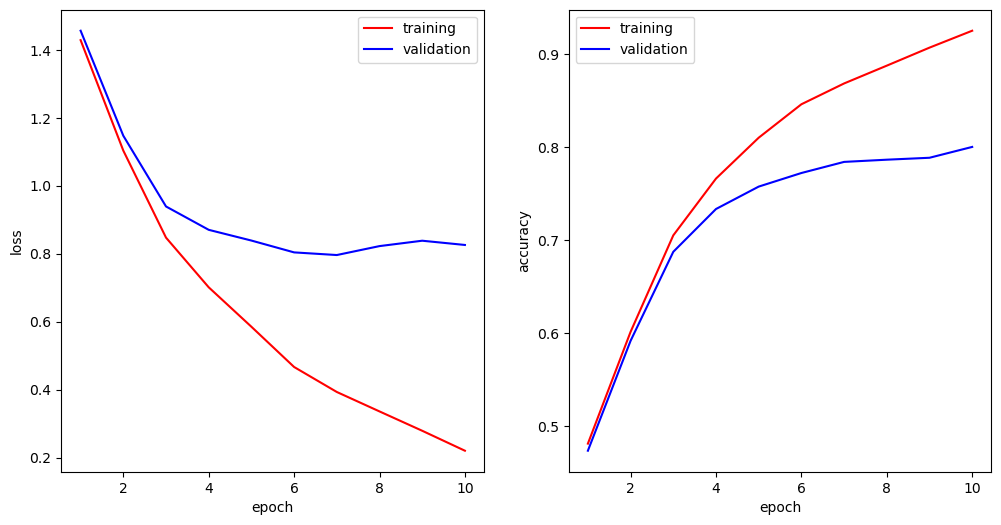

Fold #0
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5003 samples
client 5 : 4998 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 2798480.7500, Accuracy = 0.1930
client 2 : Loss = 4228217.5000, Accuracy = 0.2532
client 3 : Loss = 33441702.0000, Accuracy = 0.1316
client 4 : Loss = 41711392.0000, Accuracy = 0.1607
client 5 : Loss = 43126724.0000, Accuracy = 0.1939
client 6 : Loss = 59567.5938, Accuracy = 0.2147
client 7 : Loss = 3395662.5000, Accuracy = 0.1857
client 8 : Loss = 11685567.0000, Accuracy = 0.1422

Server :
    - training loss = 56900420.0000
    - training accuracy = 0.0972
    - validation loss = 71825744.0000
    - validation accuracy = 0.1004
        
>>> Round 2 ...
client 1 : Loss = 350694244352.0000, Accuracy = 0.1045
client 2 : Loss = 354200649728.0000, Accuracy = 0.0986
client 3 : Loss = 916431241216.0000, Accuracy = 0.1027
client 4 : Loss = 176946741248.0000, Ac

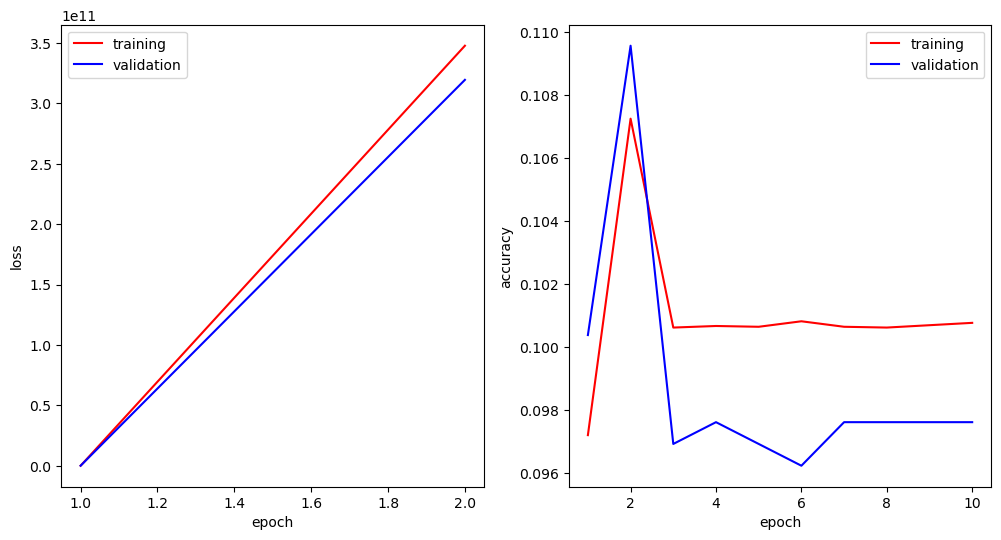

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4997 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 89139.8906, Accuracy = 0.2220
client 2 : Loss = 936005.0000, Accuracy = 0.2398
client 3 : Loss = 68281.2812, Accuracy = 0.1361
client 4 : Loss = 120096.6797, Accuracy = 0.2008
client 5 : Loss = 322.9431, Accuracy = 0.2323
client 6 : Loss = 187.9078, Accuracy = 0.2261
client 7 : Loss = 516.4965, Accuracy = 0.1518
client 8 : Loss = 294891.0625, Accuracy = 0.1742

Server :
    - training loss = 2479127.5000
    - training accuracy = 0.1024
    - validation loss = 2750908.7500
    - validation accuracy = 0.1037
        
>>> Round 2 ...
client 1 : Loss = 14698945536.0000, Accuracy = 0.0986
client 2 : Loss = 9878968320.0000, Accuracy = 0.1016
client 3 : Loss = 5724441600.0000, Accuracy = 0.1034
client 4 : Loss = 58457280512.0000, Accuracy = 0.0977
client 5 : Lo

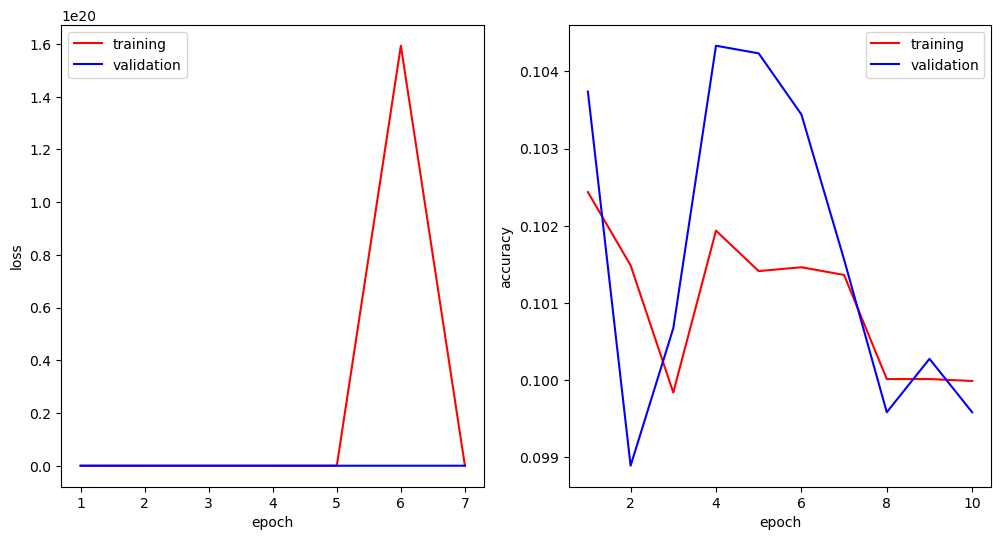

Fold #2
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 4999 samples
client 4 : 5002 samples
client 5 : 5001 samples
client 6 : 4998 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 11464055.0000, Accuracy = 0.1664
client 2 : Loss = 219521.5000, Accuracy = 0.1801
client 3 : Loss = 2503.3408, Accuracy = 0.2924
client 4 : Loss = 3719654.7500, Accuracy = 0.1605
client 5 : Loss = 232898416.0000, Accuracy = 0.2093
client 6 : Loss = 9926318.0000, Accuracy = 0.1016
client 7 : Loss = 5055175.0000, Accuracy = 0.1559
client 8 : Loss = 119932.3906, Accuracy = 0.1852

Server :
    - training loss = 31949834.0000
    - training accuracy = 0.0995
    - validation loss = 32905126.0000
    - validation accuracy = 0.0989
        
>>> Round 2 ...
client 1 : Loss = 582896910336.0000, Accuracy = 0.1027
client 2 : Loss = 691175620608.0000, Accuracy = 0.0941
client 3 : Loss = 390930464768.0000, Accuracy = 0.0920
client 4 : Loss = 476177203200.0000, Accura

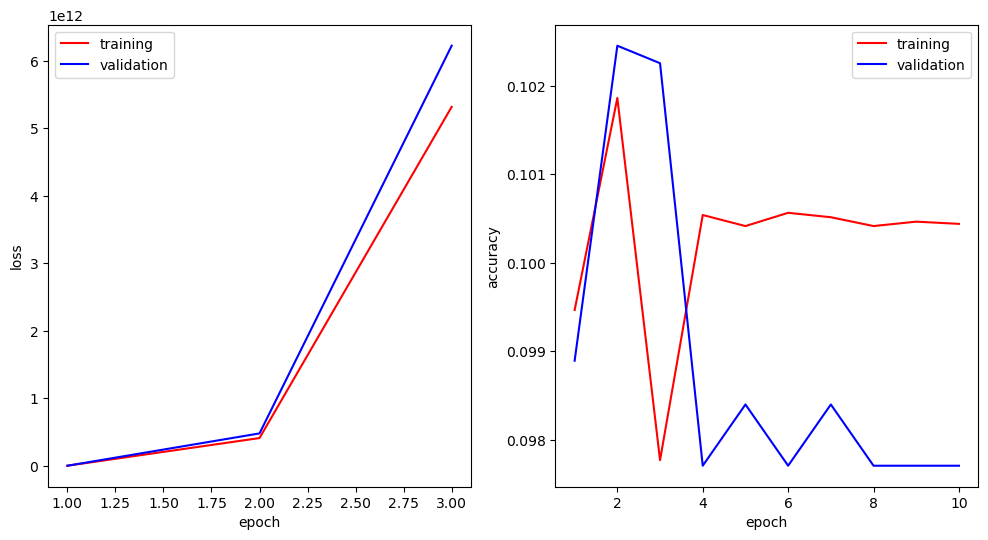

Fold #3
client 1 : 4999 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5002 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 12804059.0000, Accuracy = 0.2155
client 2 : Loss = 7501826.5000, Accuracy = 0.1273
client 3 : Loss = 714501.3125, Accuracy = 0.2590
client 4 : Loss = 87895872.0000, Accuracy = 0.1956
client 5 : Loss = 40760356.0000, Accuracy = 0.1695
client 6 : Loss = 904888.4375, Accuracy = 0.2354
client 7 : Loss = 399278.8750, Accuracy = 0.1840
client 8 : Loss = 30438614.0000, Accuracy = 0.1289

Server :
    - training loss = 544444544.0000
    - training accuracy = 0.0999
    - validation loss = 546290624.0000
    - validation accuracy = 0.0986
        
>>> Round 2 ...
client 1 : Loss = 681453748224.0000, Accuracy = 0.0961
client 2 : Loss = 1504275584.0000, Accuracy = 0.1020
client 3 : Loss = 480491601920.0000, Accuracy = 0.1077
client 4 : Loss = 146807603200.0000, Acc

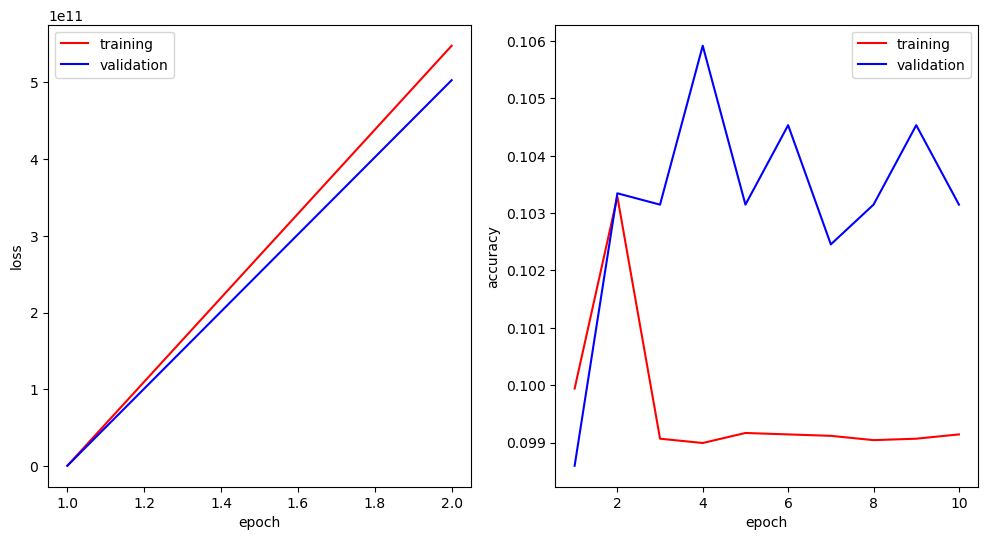

Fold #4
client 1 : 5001 samples
client 2 : 4998 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 5000 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 14.6658, Accuracy = 0.1850
client 2 : Loss = 81802.2344, Accuracy = 0.2673
client 3 : Loss = 1123704.1250, Accuracy = 0.2186
client 4 : Loss = 792117952.0000, Accuracy = 0.1107
client 5 : Loss = 4779469.0000, Accuracy = 0.1568
client 6 : Loss = 77698584.0000, Accuracy = 0.1518
client 7 : Loss = 1345.7129, Accuracy = 0.2111
client 8 : Loss = 604674.0000, Accuracy = 0.1984

Server :
    - training loss = 19552972.0000
    - training accuracy = 0.1012
    - validation loss = 20744898.0000
    - validation accuracy = 0.0941
        
>>> Round 2 ...
client 1 : Loss = 529285087232.0000, Accuracy = 0.1018
client 2 : Loss = 2053734662144.0000, Accuracy = 0.0940
client 3 : Loss = 1403370471424.0000, Accuracy = 0.0961
client 4 : Loss = 445048160256.0000, Accuracy =

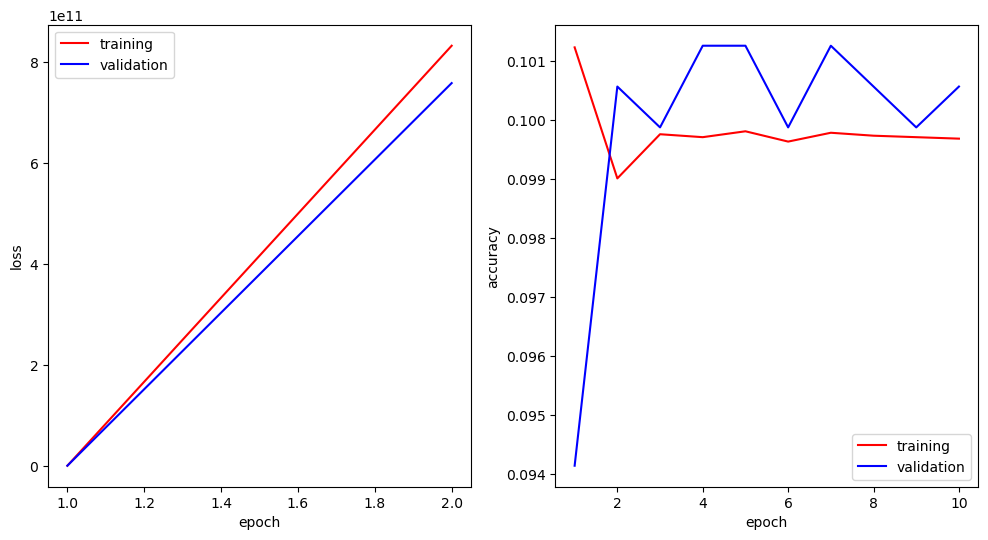

Fold #0
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5003 samples
client 5 : 4998 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.5354, Accuracy = 0.4668
client 2 : Loss = 1.5409, Accuracy = 0.4705
client 3 : Loss = 1.5037, Accuracy = 0.4699
client 4 : Loss = 1.5138, Accuracy = 0.4654
client 5 : Loss = 1.6200, Accuracy = 0.4282
client 6 : Loss = 1.5637, Accuracy = 0.4489
client 7 : Loss = 1.5026, Accuracy = 0.4701
client 8 : Loss = 1.5161, Accuracy = 0.4729

Server :
    - training loss = 1.7364
    - training accuracy = 0.3821
    - validation loss = 1.7291
    - validation accuracy = 0.3814
        
>>> Round 2 ...
client 1 : Loss = 1.2165, Accuracy = 0.5625
client 2 : Loss = 1.3022, Accuracy = 0.5372
client 3 : Loss = 1.1417, Accuracy = 0.5926
client 4 : Loss = 1.1912, Accuracy = 0.5709
client 5 : Loss = 1.1557, Accuracy = 0.5798
client 6 : Loss = 1.1982, Accuracy = 0.5793
clie

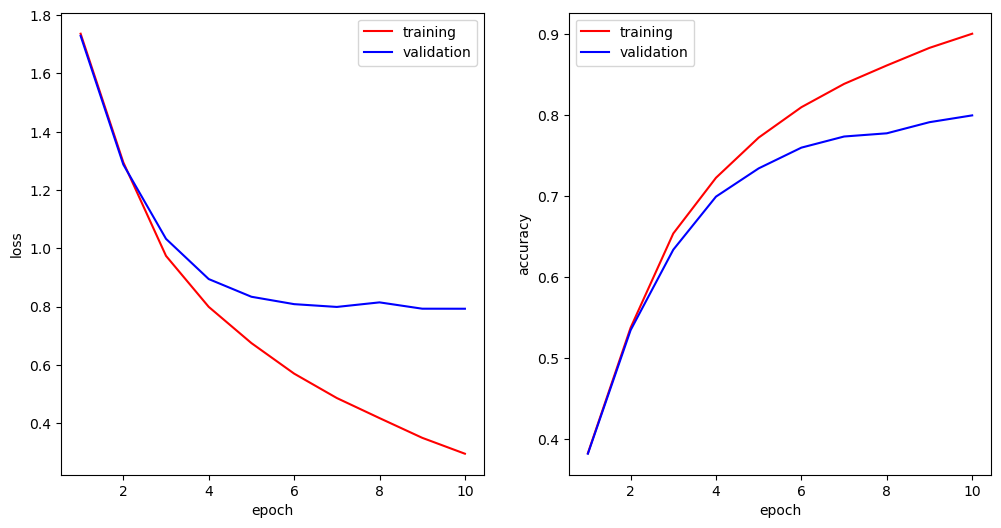

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4997 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.2571, Accuracy = 0.5572
client 2 : Loss = 1.2531, Accuracy = 0.5421
client 3 : Loss = 1.3712, Accuracy = 0.5106
client 4 : Loss = 1.3340, Accuracy = 0.5246
client 5 : Loss = 1.3262, Accuracy = 0.5114
client 6 : Loss = 1.2710, Accuracy = 0.5493
client 7 : Loss = 1.4257, Accuracy = 0.4911
client 8 : Loss = 1.4348, Accuracy = 0.4994

Server :
    - training loss = 1.5885
    - training accuracy = 0.4374
    - validation loss = 1.6030
    - validation accuracy = 0.4384
        
>>> Round 2 ...
client 1 : Loss = 0.9440, Accuracy = 0.6592
client 2 : Loss = 1.0157, Accuracy = 0.6407
client 3 : Loss = 0.9309, Accuracy = 0.6686
client 4 : Loss = 0.9695, Accuracy = 0.6455
client 5 : Loss = 0.9639, Accuracy = 0.6488
client 6 : Loss = 0.9856, Accuracy = 0.6502
clie

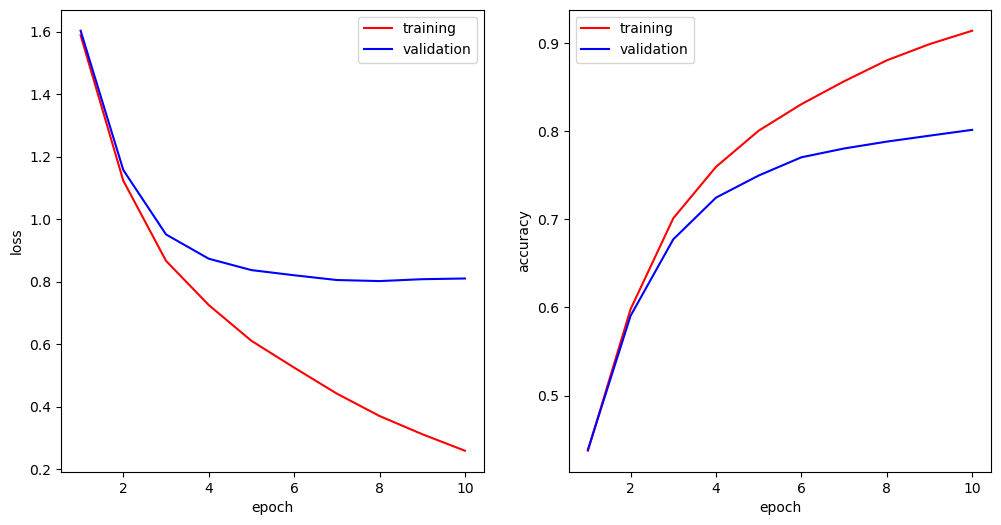

Fold #2
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 4999 samples
client 4 : 5002 samples
client 5 : 5001 samples
client 6 : 4998 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.3476, Accuracy = 0.5154
client 2 : Loss = 1.4543, Accuracy = 0.4914
client 3 : Loss = 1.4535, Accuracy = 0.4895
client 4 : Loss = 1.4411, Accuracy = 0.4846
client 5 : Loss = 1.3574, Accuracy = 0.5060
client 6 : Loss = 1.3607, Accuracy = 0.5102
client 7 : Loss = 1.4168, Accuracy = 0.5013
client 8 : Loss = 1.5177, Accuracy = 0.4629

Server :
    - training loss = 1.7098
    - training accuracy = 0.4059
    - validation loss = 1.7229
    - validation accuracy = 0.3963
        
>>> Round 2 ...
client 1 : Loss = 1.0929, Accuracy = 0.6080
client 2 : Loss = 1.0469, Accuracy = 0.6289
client 3 : Loss = 1.1299, Accuracy = 0.6025
client 4 : Loss = 1.1326, Accuracy = 0.5920
client 5 : Loss = 1.0867, Accuracy = 0.6070
client 6 : Loss = 1.0895, Accuracy = 0.6087
clie

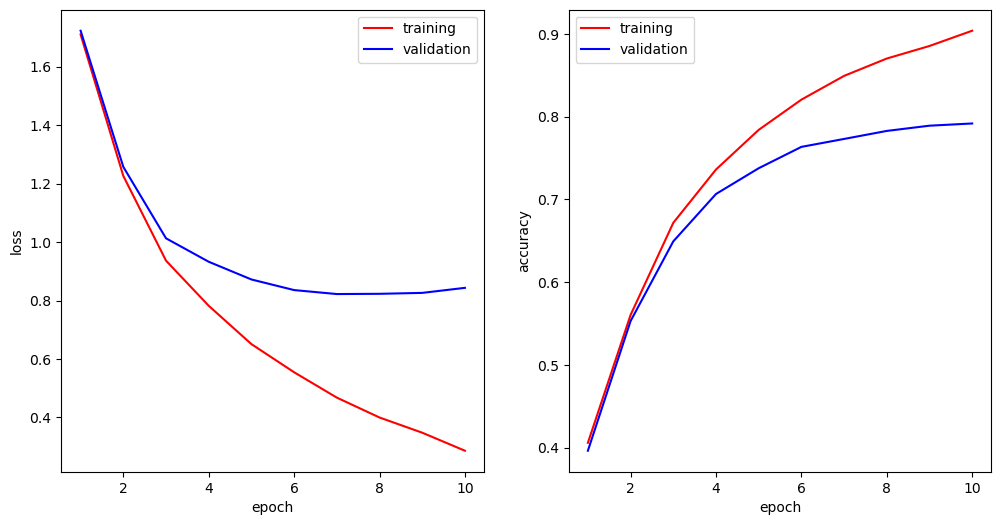

Fold #3
client 1 : 4999 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5002 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.5346, Accuracy = 0.4621
client 2 : Loss = 1.3533, Accuracy = 0.5345
client 3 : Loss = 1.4855, Accuracy = 0.4753
client 4 : Loss = 1.4562, Accuracy = 0.4739
client 5 : Loss = 1.3596, Accuracy = 0.5105
client 6 : Loss = 1.4450, Accuracy = 0.4855
client 7 : Loss = 1.4332, Accuracy = 0.4965
client 8 : Loss = 1.4404, Accuracy = 0.4966

Server :
    - training loss = 1.6777
    - training accuracy = 0.3928
    - validation loss = 1.6909
    - validation accuracy = 0.3922
        
>>> Round 2 ...
client 1 : Loss = 1.1555, Accuracy = 0.5767
client 2 : Loss = 1.0892, Accuracy = 0.6038
client 3 : Loss = 1.1088, Accuracy = 0.5912
client 4 : Loss = 1.1139, Accuracy = 0.6075
client 5 : Loss = 1.0423, Accuracy = 0.6184
client 6 : Loss = 1.0451, Accuracy = 0.6169
clie

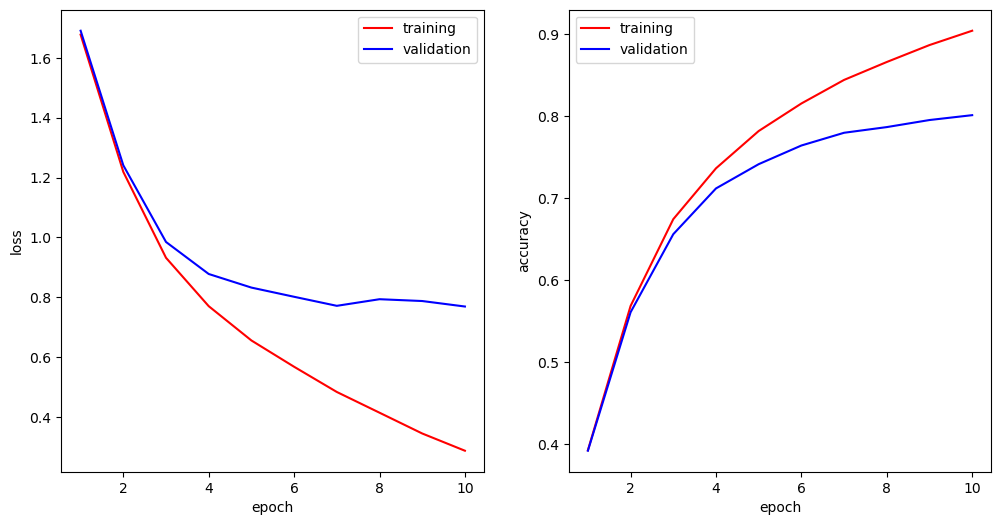

Fold #4
client 1 : 5001 samples
client 2 : 4998 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 5000 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.4279, Accuracy = 0.5035
client 2 : Loss = 1.5528, Accuracy = 0.4630
client 3 : Loss = 1.3974, Accuracy = 0.5076
client 4 : Loss = 1.4311, Accuracy = 0.4898
client 5 : Loss = 1.3943, Accuracy = 0.5023
client 6 : Loss = 1.3665, Accuracy = 0.4978
client 7 : Loss = 1.6230, Accuracy = 0.4641
client 8 : Loss = 1.3062, Accuracy = 0.5252

Server :
    - training loss = 1.7172
    - training accuracy = 0.3980
    - validation loss = 1.7463
    - validation accuracy = 0.3874
        
>>> Round 2 ...
client 1 : Loss = 1.0667, Accuracy = 0.6172
client 2 : Loss = 1.1289, Accuracy = 0.5902
client 3 : Loss = 1.1434, Accuracy = 0.5934
client 4 : Loss = 1.0555, Accuracy = 0.6176
client 5 : Loss = 1.0757, Accuracy = 0.6131
client 6 : Loss = 1.1155, Accuracy = 0.5995
clie

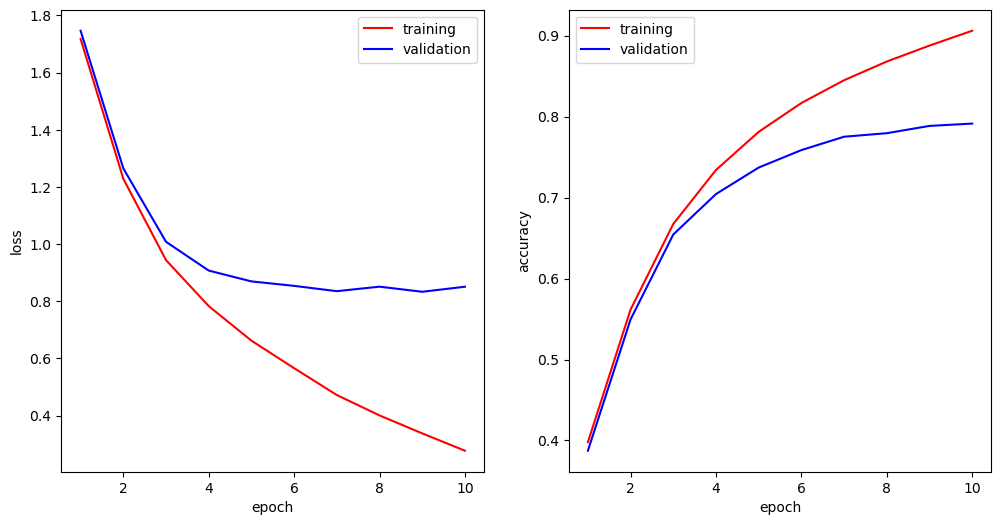

Fold #0
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5003 samples
client 5 : 4998 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.5264, Accuracy = 0.4596
client 2 : Loss = 1.6365, Accuracy = 0.4323
client 3 : Loss = 1.3959, Accuracy = 0.5023
client 4 : Loss = 1.4927, Accuracy = 0.4670
client 5 : Loss = 1.5739, Accuracy = 0.4439
client 6 : Loss = 1.6481, Accuracy = 0.4133
client 7 : Loss = 1.3623, Accuracy = 0.5132
client 8 : Loss = 1.4087, Accuracy = 0.4996

Server :
    - training loss = 1.7528
    - training accuracy = 0.3827
    - validation loss = 1.7579
    - validation accuracy = 0.3764
        
>>> Round 2 ...
client 1 : Loss = 1.0932, Accuracy = 0.6053
client 2 : Loss = 1.1505, Accuracy = 0.5969
client 3 : Loss = 1.1388, Accuracy = 0.5947
client 4 : Loss = 1.2139, Accuracy = 0.5688
client 5 : Loss = 1.2189, Accuracy = 0.5598
client 6 : Loss = 1.2446, Accuracy = 0.5547
clie

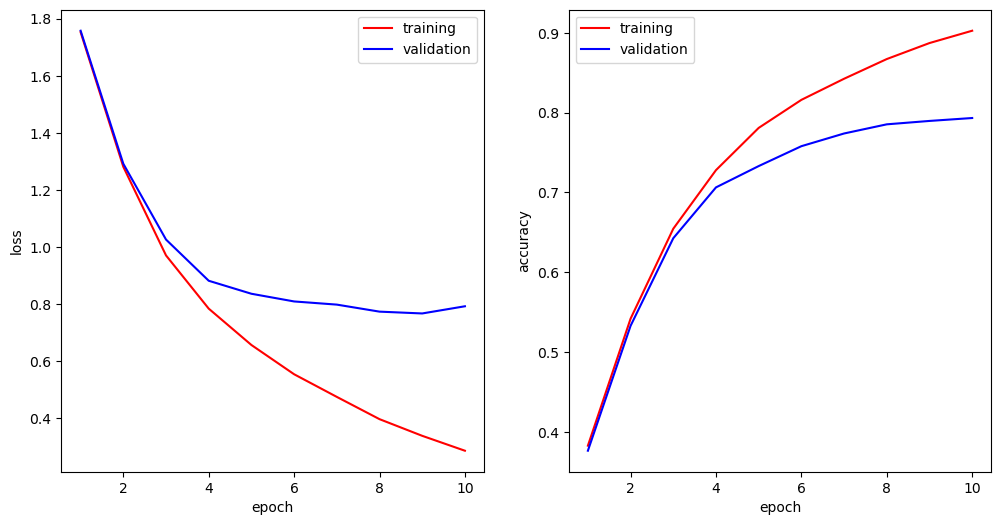

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4997 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.4203, Accuracy = 0.5059
client 2 : Loss = 1.4975, Accuracy = 0.4680
client 3 : Loss = 1.3212, Accuracy = 0.5251
client 4 : Loss = 1.3470, Accuracy = 0.5166
client 5 : Loss = 1.2903, Accuracy = 0.5422
client 6 : Loss = 1.4163, Accuracy = 0.5043
client 7 : Loss = 1.4821, Accuracy = 0.4782
client 8 : Loss = 1.3323, Accuracy = 0.5220

Server :
    - training loss = 1.6400
    - training accuracy = 0.4127
    - validation loss = 1.6378
    - validation accuracy = 0.4118
        
>>> Round 2 ...
client 1 : Loss = 1.1108, Accuracy = 0.6034
client 2 : Loss = 1.1312, Accuracy = 0.6009
client 3 : Loss = 1.0691, Accuracy = 0.6145
client 4 : Loss = 1.1313, Accuracy = 0.5914
client 5 : Loss = 1.0765, Accuracy = 0.6074
client 6 : Loss = 1.0553, Accuracy = 0.6118
clie

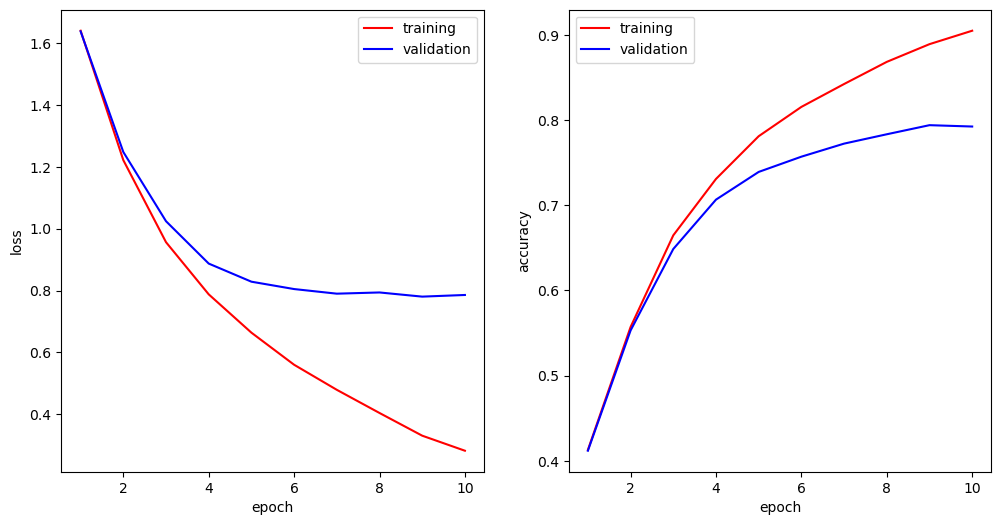

Fold #2
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 4999 samples
client 4 : 5002 samples
client 5 : 5001 samples
client 6 : 4998 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.4412, Accuracy = 0.4871
client 2 : Loss = 1.3362, Accuracy = 0.5213
client 3 : Loss = 1.5677, Accuracy = 0.4534
client 4 : Loss = 1.3491, Accuracy = 0.5137
client 5 : Loss = 1.4373, Accuracy = 0.4904
client 6 : Loss = 1.5615, Accuracy = 0.4652
client 7 : Loss = 1.4388, Accuracy = 0.4845
client 8 : Loss = 1.3159, Accuracy = 0.5277

Server :
    - training loss = 1.6326
    - training accuracy = 0.4159
    - validation loss = 1.6595
    - validation accuracy = 0.4076
        
>>> Round 2 ...
client 1 : Loss = 1.1118, Accuracy = 0.5967
client 2 : Loss = 1.1412, Accuracy = 0.5898
client 3 : Loss = 1.1570, Accuracy = 0.5898
client 4 : Loss = 1.1056, Accuracy = 0.6020
client 5 : Loss = 1.1671, Accuracy = 0.5891
client 6 : Loss = 1.0904, Accuracy = 0.5939
clie

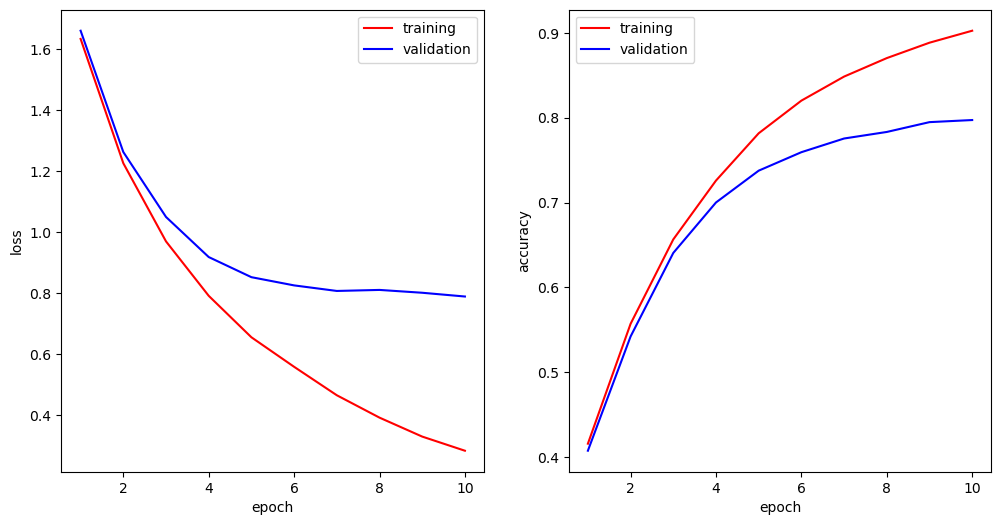

Fold #3
client 1 : 4999 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5002 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.5524, Accuracy = 0.4595
client 2 : Loss = 1.4764, Accuracy = 0.4613
client 3 : Loss = 1.5331, Accuracy = 0.4413
client 4 : Loss = 1.4622, Accuracy = 0.4881
client 5 : Loss = 1.6132, Accuracy = 0.4443
client 6 : Loss = 1.4986, Accuracy = 0.4684
client 7 : Loss = 1.6188, Accuracy = 0.4195
client 8 : Loss = 1.4002, Accuracy = 0.4956

Server :
    - training loss = 1.6622
    - training accuracy = 0.4128
    - validation loss = 1.6847
    - validation accuracy = 0.4100
        
>>> Round 2 ...
client 1 : Loss = 1.2335, Accuracy = 0.5561
client 2 : Loss = 1.1231, Accuracy = 0.6069
client 3 : Loss = 1.1865, Accuracy = 0.5714
client 4 : Loss = 1.1007, Accuracy = 0.6092
client 5 : Loss = 1.1766, Accuracy = 0.5881
client 6 : Loss = 1.2505, Accuracy = 0.5590
clie

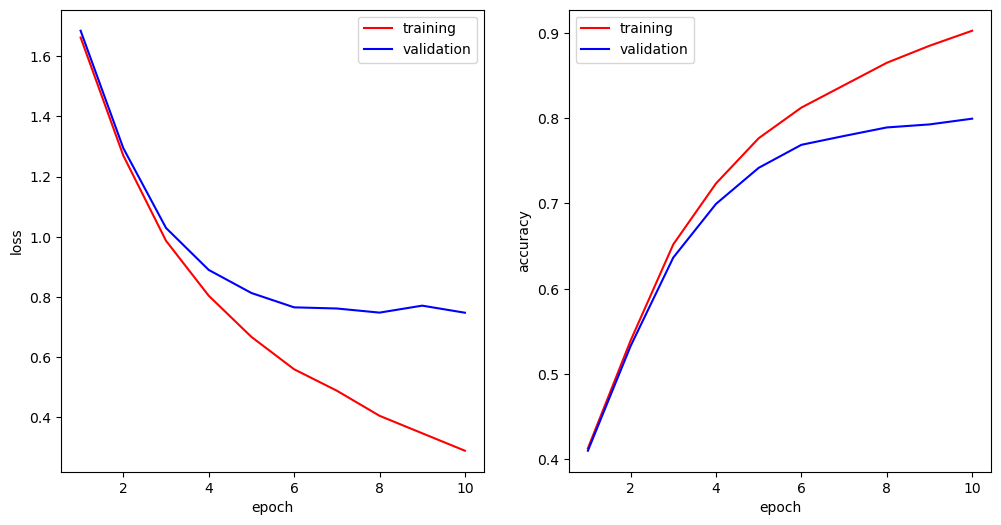

Fold #4
client 1 : 5001 samples
client 2 : 4998 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 5000 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.4818, Accuracy = 0.4681
client 2 : Loss = 1.4829, Accuracy = 0.4757
client 3 : Loss = 1.5942, Accuracy = 0.4563
client 4 : Loss = 1.5383, Accuracy = 0.4545
client 5 : Loss = 1.5421, Accuracy = 0.4490
client 6 : Loss = 1.5483, Accuracy = 0.4599
client 7 : Loss = 1.4623, Accuracy = 0.4752
client 8 : Loss = 1.4772, Accuracy = 0.4725

Server :
    - training loss = 1.6935
    - training accuracy = 0.3968
    - validation loss = 1.7204
    - validation accuracy = 0.3882
        
>>> Round 2 ...
client 1 : Loss = 1.1878, Accuracy = 0.5759
client 2 : Loss = 1.2563, Accuracy = 0.5456
client 3 : Loss = 1.1791, Accuracy = 0.5804
client 4 : Loss = 1.1878, Accuracy = 0.5689
client 5 : Loss = 1.2452, Accuracy = 0.5475
client 6 : Loss = 1.2582, Accuracy = 0.5565
clie

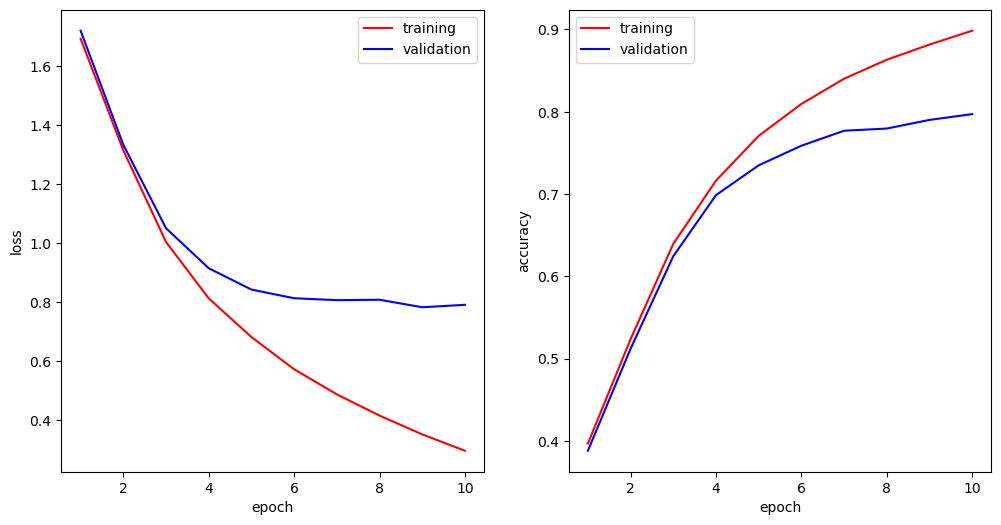

Fold #0
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5003 samples
client 5 : 4998 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 170.2297, Accuracy = 0.1893
client 2 : Loss = 1480557.0000, Accuracy = 0.1941
client 3 : Loss = 253.6445, Accuracy = 0.2148
client 4 : Loss = 230878.7031, Accuracy = 0.1898
client 5 : Loss = 1376430.3750, Accuracy = 0.2296
client 6 : Loss = 791.1754, Accuracy = 0.2431
client 7 : Loss = 6255.6128, Accuracy = 0.1879
client 8 : Loss = 235.9148, Accuracy = 0.2455

Server :
    - training loss = 4498621952.0000
    - training accuracy = 0.1210
    - validation loss = 4507641344.0000
    - validation accuracy = 0.1189
        
>>> Round 2 ...
client 1 : Loss = nan, Accuracy = 0.1074
client 2 : Loss = nan, Accuracy = 0.1018
client 3 : Loss = 3557255391739904.0000, Accuracy = 0.1080
client 4 : Loss = nan, Accuracy = 0.1011
client 5 : Loss = nan, Accuracy = 0.1068

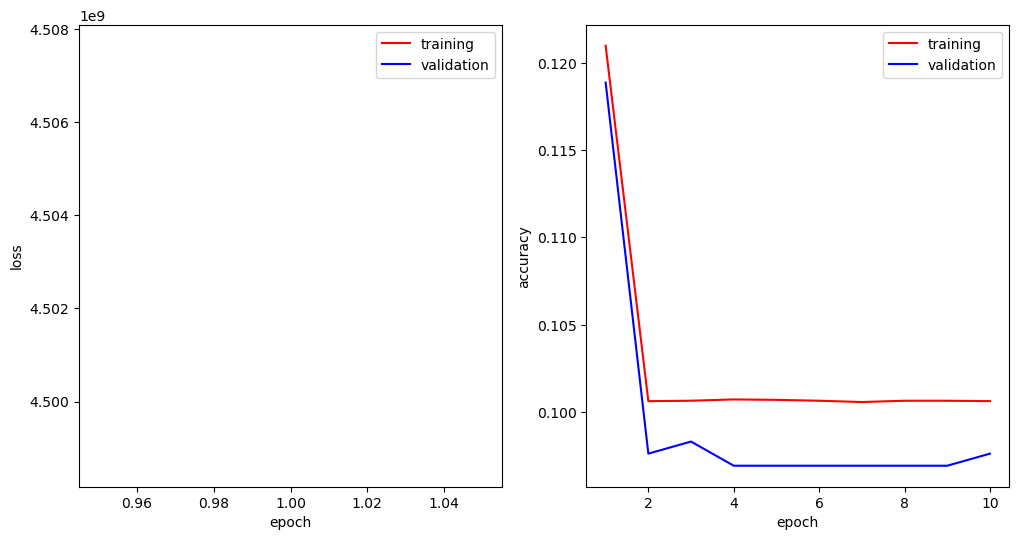

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4997 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 2847489792.0000, Accuracy = 0.1629
client 2 : Loss = 2679.8281, Accuracy = 0.2041
client 3 : Loss = 5065.3247, Accuracy = 0.1937
client 4 : Loss = 43130.4648, Accuracy = 0.1809
client 5 : Loss = 458.8309, Accuracy = 0.1909
client 6 : Loss = 13898282.0000, Accuracy = 0.1268
client 7 : Loss = 24266.5234, Accuracy = 0.1556
client 8 : Loss = 1375.8553, Accuracy = 0.2008

Server :
    - training loss = 10447718400.0000
    - training accuracy = 0.1066
    - validation loss = 10607455232.0000
    - validation accuracy = 0.1029
        
>>> Round 2 ...
client 1 : Loss = 501623088480256.0000, Accuracy = 0.1133
client 2 : Loss = 1921470523506688.0000, Accuracy = 0.1102
client 3 : Loss = 428587974918144.0000, Accuracy = 0.1037
client 4 : Loss = 676583849328640.0000

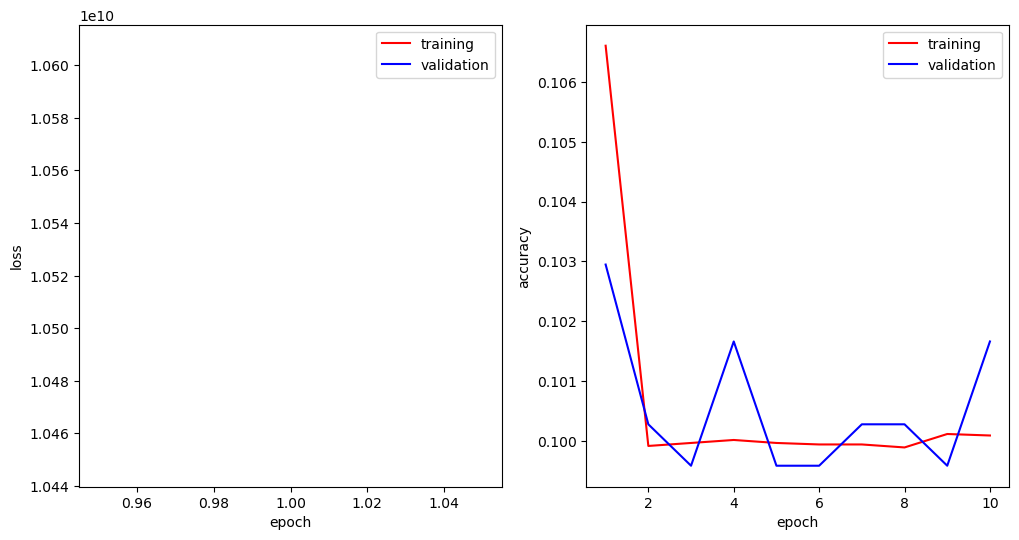

Fold #2
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 4999 samples
client 4 : 5002 samples
client 5 : 5001 samples
client 6 : 4998 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 27831076.0000, Accuracy = 0.1943
client 2 : Loss = 376530208.0000, Accuracy = 0.1822
client 3 : Loss = 88830.4453, Accuracy = 0.1346
client 4 : Loss = 1067.5392, Accuracy = 0.2146
client 5 : Loss = 802.5956, Accuracy = 0.2399
client 6 : Loss = 1333.8969, Accuracy = 0.2087
client 7 : Loss = 8282817.5000, Accuracy = 0.1668
client 8 : Loss = 1764063616.0000, Accuracy = 0.2133

Server :
    - training loss = 3353770496.0000
    - training accuracy = 0.0857
    - validation loss = 3339039488.0000
    - validation accuracy = 0.0850
        
>>> Round 2 ...
client 1 : Loss = 287316601995264.0000, Accuracy = 0.1143
client 2 : Loss = 491048878997504.0000, Accuracy = 0.1012
client 3 : Loss = nan, Accuracy = 0.1014
client 4 : Loss = 76120242257920.0000, Accuracy = 0

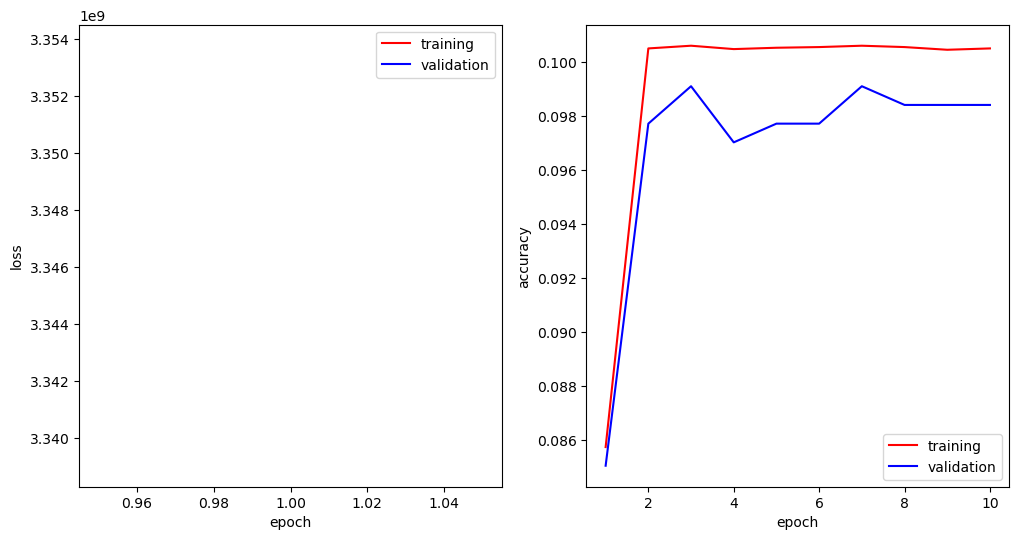

Fold #3
client 1 : 4999 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5002 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 889818560.0000, Accuracy = 0.2074
client 2 : Loss = 479962080.0000, Accuracy = 0.1190
client 3 : Loss = 825.4827, Accuracy = 0.2117
client 4 : Loss = 337190752.0000, Accuracy = 0.1716
client 5 : Loss = 558734208.0000, Accuracy = 0.1707
client 6 : Loss = 8850433024.0000, Accuracy = 0.1827
client 7 : Loss = 270883.6875, Accuracy = 0.1733
client 8 : Loss = 503.0030, Accuracy = 0.1745

Server :
    - training loss = 2154776320.0000
    - training accuracy = 0.1069
    - validation loss = 2313053440.0000
    - validation accuracy = 0.1047
        
>>> Round 2 ...
client 1 : Loss = nan, Accuracy = 0.1001
client 2 : Loss = nan, Accuracy = 0.1034
client 3 : Loss = nan, Accuracy = 0.1039
client 4 : Loss = nan, Accuracy = 0.0974
client 5 : Loss = nan, Accuracy = 0.

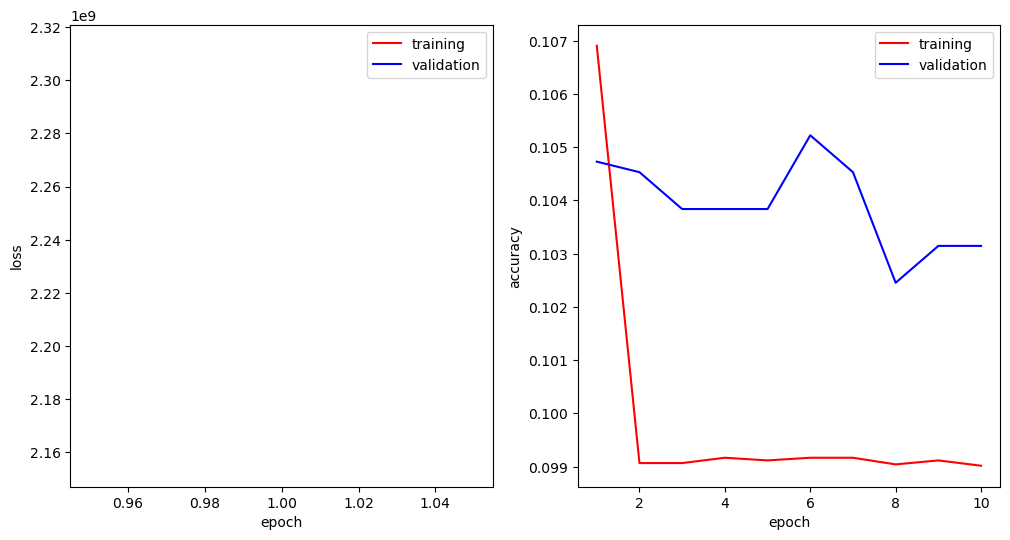

Fold #4
client 1 : 5001 samples
client 2 : 4998 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 5000 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 590.7335, Accuracy = 0.1947
client 2 : Loss = 780.9104, Accuracy = 0.2020
client 3 : Loss = 3442.8113, Accuracy = 0.2194
client 4 : Loss = 522.0573, Accuracy = 0.2504
client 5 : Loss = 305.4410, Accuracy = 0.2359
client 6 : Loss = 2690687.2500, Accuracy = 0.1889
client 7 : Loss = 77038.0547, Accuracy = 0.1928
client 8 : Loss = 3014.5764, Accuracy = 0.2141

Server :
    - training loss = 53838628.0000
    - training accuracy = 0.1039
    - validation loss = 54537932.0000
    - validation accuracy = 0.1054
        
>>> Round 2 ...
client 1 : Loss = nan, Accuracy = 0.0975
client 2 : Loss = nan, Accuracy = 0.1012
client 3 : Loss = nan, Accuracy = 0.0975
client 4 : Loss = nan, Accuracy = 0.1033
client 5 : Loss = nan, Accuracy = 0.0975
client 6 : Loss = nan, Ac

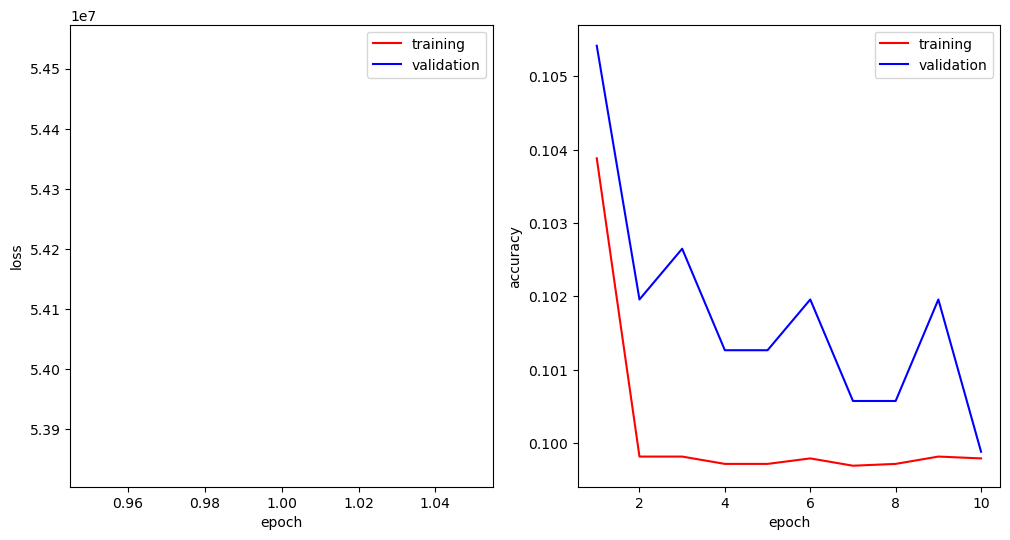

Fold #0
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5003 samples
client 5 : 4998 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.8942, Accuracy = 0.3592
client 2 : Loss = 1.8160, Accuracy = 0.3737
client 3 : Loss = 1.8179, Accuracy = 0.3701
client 4 : Loss = 1.9247, Accuracy = 0.3638
client 5 : Loss = 1.8444, Accuracy = 0.3784
client 6 : Loss = 1.7654, Accuracy = 0.4172
client 7 : Loss = 1.7323, Accuracy = 0.4113
client 8 : Loss = 1.6615, Accuracy = 0.4121

Server :
    - training loss = 2.3752
    - training accuracy = 0.2713
    - validation loss = 2.3560
    - validation accuracy = 0.2776
        
>>> Round 2 ...
client 1 : Loss = 1.4949, Accuracy = 0.4559
client 2 : Loss = 1.4907, Accuracy = 0.4493
client 3 : Loss = 1.5414, Accuracy = 0.4377
client 4 : Loss = 1.4901, Accuracy = 0.4618
client 5 : Loss = 1.5223, Accuracy = 0.4493
client 6 : Loss = 1.5329, Accuracy = 0.4540
clie

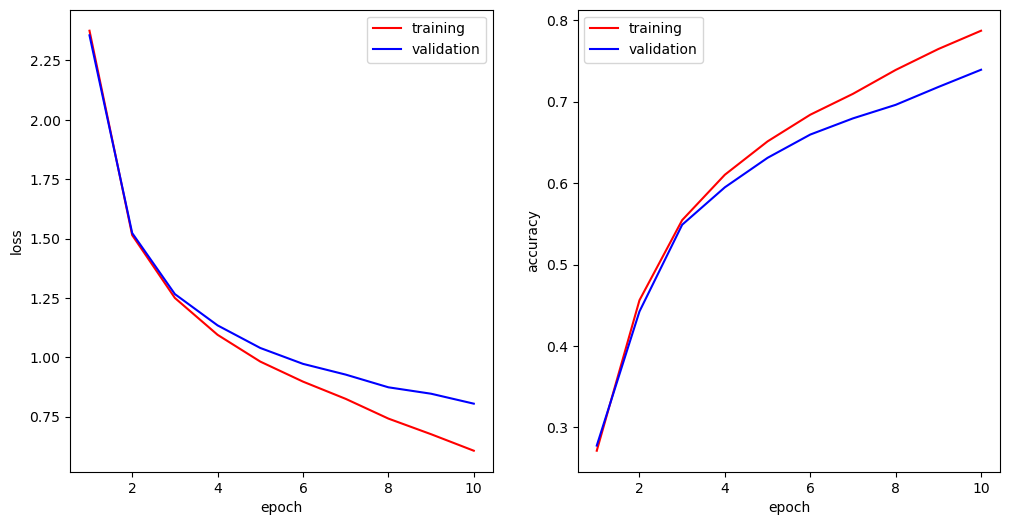

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4997 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.7739, Accuracy = 0.4117
client 2 : Loss = 1.7365, Accuracy = 0.3778
client 3 : Loss = 1.8817, Accuracy = 0.3636
client 4 : Loss = 2.0275, Accuracy = 0.3506
client 5 : Loss = 1.7672, Accuracy = 0.3944
client 6 : Loss = 1.7622, Accuracy = 0.3956
client 7 : Loss = 1.8614, Accuracy = 0.3667
client 8 : Loss = 1.8198, Accuracy = 0.3711

Server :
    - training loss = 2.2317
    - training accuracy = 0.2703
    - validation loss = 2.2487
    - validation accuracy = 0.2670
        
>>> Round 2 ...
client 1 : Loss = 1.4832, Accuracy = 0.4576
client 2 : Loss = 1.5980, Accuracy = 0.4335
client 3 : Loss = 1.5041, Accuracy = 0.4539
client 4 : Loss = 1.5478, Accuracy = 0.4344
client 5 : Loss = 1.4902, Accuracy = 0.4473
client 6 : Loss = 1.5087, Accuracy = 0.4390
clie

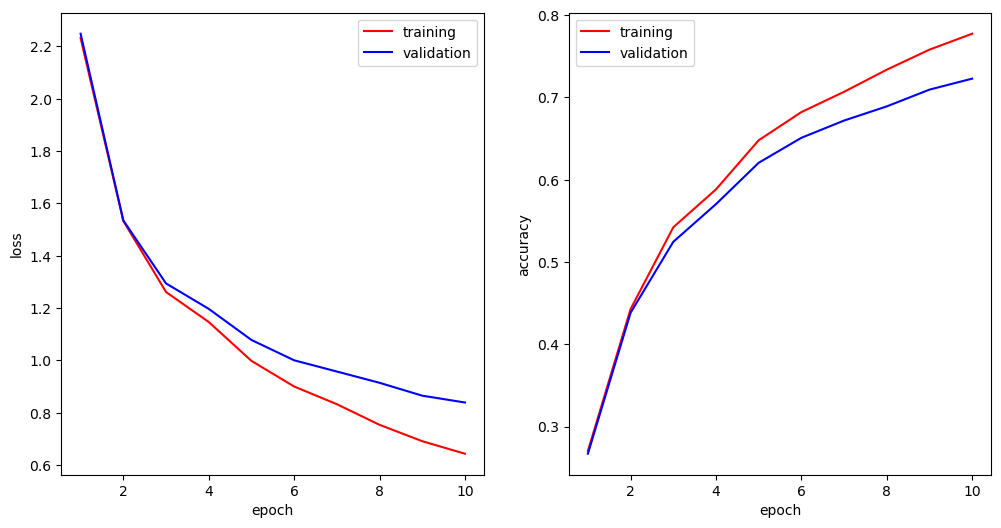

Fold #2
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 4999 samples
client 4 : 5002 samples
client 5 : 5001 samples
client 6 : 4998 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.7354, Accuracy = 0.4055
client 2 : Loss = 1.8148, Accuracy = 0.3709
client 3 : Loss = 1.6724, Accuracy = 0.4154
client 4 : Loss = 1.7683, Accuracy = 0.3791
client 5 : Loss = 1.8228, Accuracy = 0.3996
client 6 : Loss = 1.8828, Accuracy = 0.3807
client 7 : Loss = 1.8447, Accuracy = 0.3847
client 8 : Loss = 1.7723, Accuracy = 0.3687

Server :
    - training loss = 2.3854
    - training accuracy = 0.2222
    - validation loss = 2.3373
    - validation accuracy = 0.2309
        
>>> Round 2 ...
client 1 : Loss = 1.5168, Accuracy = 0.4465
client 2 : Loss = 1.5239, Accuracy = 0.4387
client 3 : Loss = 1.5914, Accuracy = 0.4306
client 4 : Loss = 1.5143, Accuracy = 0.4522
client 5 : Loss = 1.5456, Accuracy = 0.4257
client 6 : Loss = 1.5541, Accuracy = 0.4510
clie

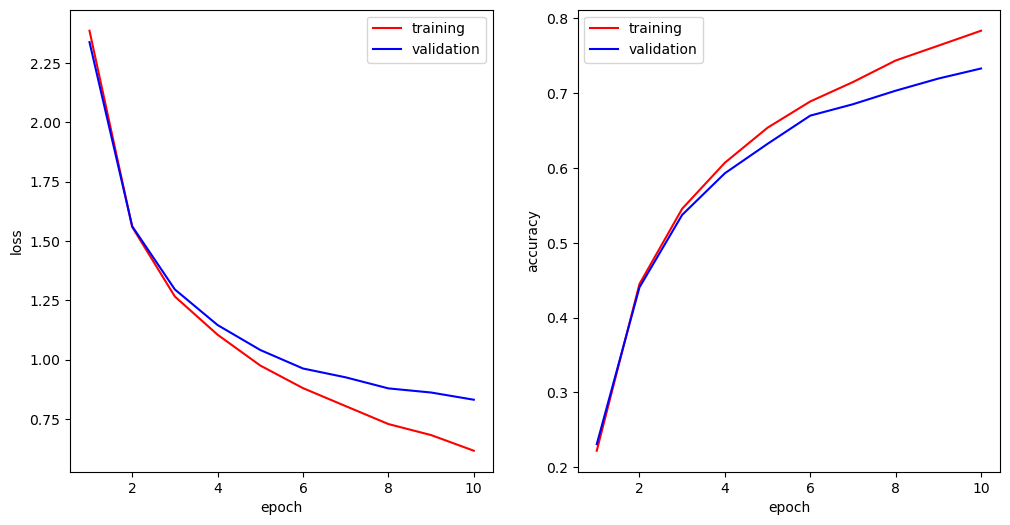

Fold #3
client 1 : 4999 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5002 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.8418, Accuracy = 0.3795
client 2 : Loss = 1.7607, Accuracy = 0.3901
client 3 : Loss = 1.7664, Accuracy = 0.3838
client 4 : Loss = 1.9145, Accuracy = 0.3796
client 5 : Loss = 1.8960, Accuracy = 0.3918
client 6 : Loss = 1.8496, Accuracy = 0.3800
client 7 : Loss = 1.7758, Accuracy = 0.3808
client 8 : Loss = 1.7637, Accuracy = 0.3948

Server :
    - training loss = 2.3834
    - training accuracy = 0.2465
    - validation loss = 2.4316
    - validation accuracy = 0.2456
        
>>> Round 2 ...
client 1 : Loss = 1.5121, Accuracy = 0.4479
client 2 : Loss = 1.4728, Accuracy = 0.4645
client 3 : Loss = 1.4979, Accuracy = 0.4600
client 4 : Loss = 1.4911, Accuracy = 0.4580
client 5 : Loss = 1.4894, Accuracy = 0.4436
client 6 : Loss = 1.5211, Accuracy = 0.4349
clie

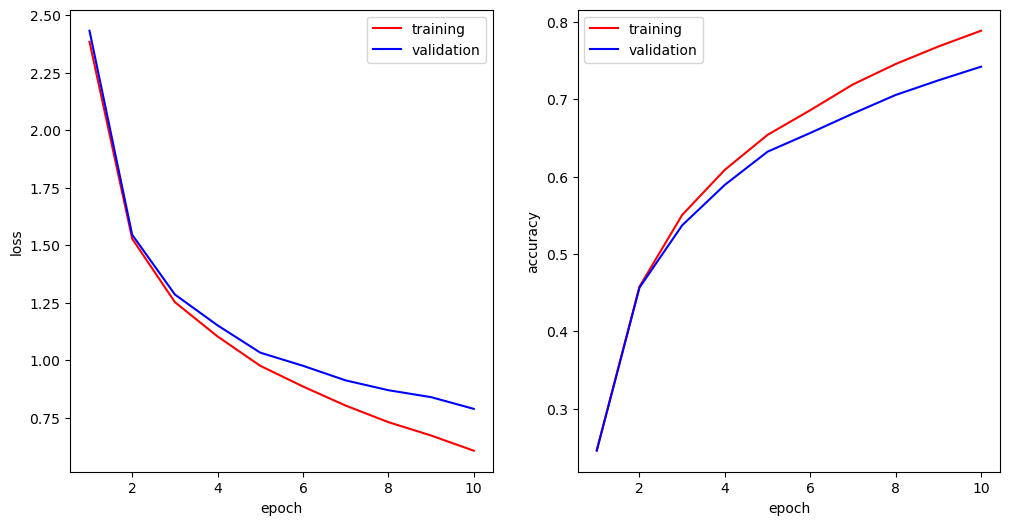

Fold #4
client 1 : 5001 samples
client 2 : 4998 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 5000 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 2.0062, Accuracy = 0.3517
client 2 : Loss = 1.7251, Accuracy = 0.3971
client 3 : Loss = 1.8101, Accuracy = 0.3850
client 4 : Loss = 1.7517, Accuracy = 0.3863
client 5 : Loss = 1.8238, Accuracy = 0.3666
client 6 : Loss = 1.7187, Accuracy = 0.3912
client 7 : Loss = 1.7922, Accuracy = 0.4062
client 8 : Loss = 1.7079, Accuracy = 0.3869

Server :
    - training loss = 2.1833
    - training accuracy = 0.2053
    - validation loss = 2.2082
    - validation accuracy = 0.2011
        
>>> Round 2 ...
client 1 : Loss = 1.4831, Accuracy = 0.4452
client 2 : Loss = 1.5223, Accuracy = 0.4503
client 3 : Loss = 1.5024, Accuracy = 0.4498
client 4 : Loss = 1.5286, Accuracy = 0.4342
client 5 : Loss = 1.4950, Accuracy = 0.4578
client 6 : Loss = 1.4804, Accuracy = 0.4653
clie

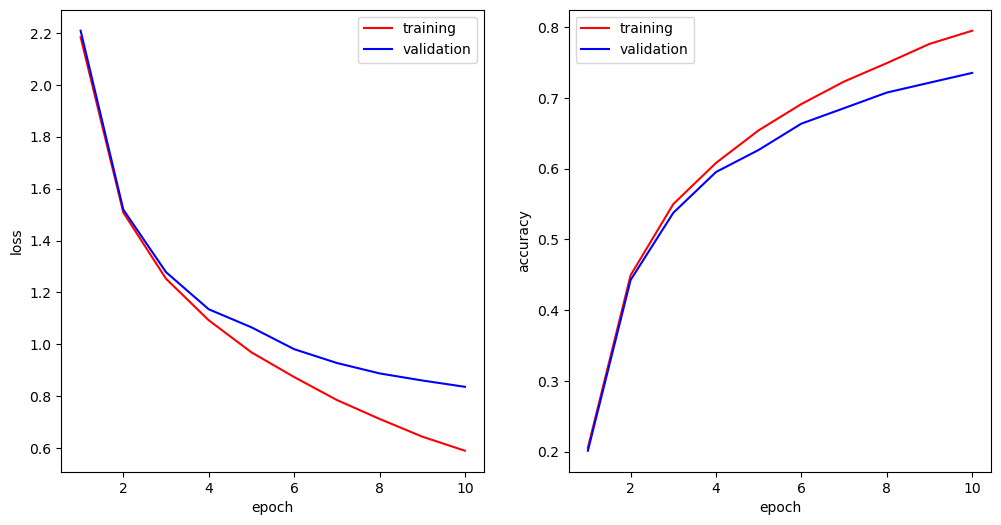

Fold #0
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5003 samples
client 5 : 4998 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.6877, Accuracy = 0.3965
client 2 : Loss = 1.7041, Accuracy = 0.4071
client 3 : Loss = 1.7722, Accuracy = 0.3879
client 4 : Loss = 1.6911, Accuracy = 0.4042
client 5 : Loss = 1.8170, Accuracy = 0.3648
client 6 : Loss = 1.7185, Accuracy = 0.4021
client 7 : Loss = 1.7787, Accuracy = 0.3869
client 8 : Loss = 1.6907, Accuracy = 0.4133

Server :
    - training loss = 1.8562
    - training accuracy = 0.3150
    - validation loss = 1.8442
    - validation accuracy = 0.3234
        
>>> Round 2 ...
client 1 : Loss = 1.5049, Accuracy = 0.4662
client 2 : Loss = 1.4565, Accuracy = 0.4667
client 3 : Loss = 1.4341, Accuracy = 0.4768
client 4 : Loss = 1.4398, Accuracy = 0.4798
client 5 : Loss = 1.4269, Accuracy = 0.4659
client 6 : Loss = 1.4568, Accuracy = 0.4612
clie

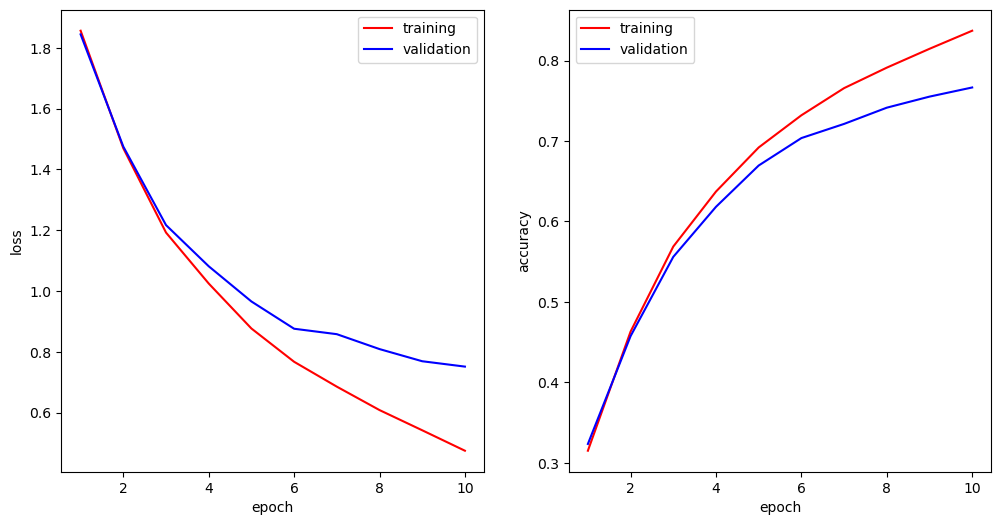

Fold #1
client 1 : 5002 samples
client 2 : 4997 samples
client 3 : 5001 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4997 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.8530, Accuracy = 0.3618
client 2 : Loss = 1.8379, Accuracy = 0.3762
client 3 : Loss = 1.7012, Accuracy = 0.4169
client 4 : Loss = 1.8480, Accuracy = 0.3701
client 5 : Loss = 1.7147, Accuracy = 0.4051
client 6 : Loss = 1.6632, Accuracy = 0.4023
client 7 : Loss = 1.8790, Accuracy = 0.3640
client 8 : Loss = 1.7224, Accuracy = 0.4005

Server :
    - training loss = 1.8709
    - training accuracy = 0.3211
    - validation loss = 1.8784
    - validation accuracy = 0.3186
        
>>> Round 2 ...
client 1 : Loss = 1.4093, Accuracy = 0.4930
client 2 : Loss = 1.5325, Accuracy = 0.4402
client 3 : Loss = 1.4056, Accuracy = 0.4809
client 4 : Loss = 1.4694, Accuracy = 0.4695
client 5 : Loss = 1.3814, Accuracy = 0.4931
client 6 : Loss = 1.4103, Accuracy = 0.4885
clie

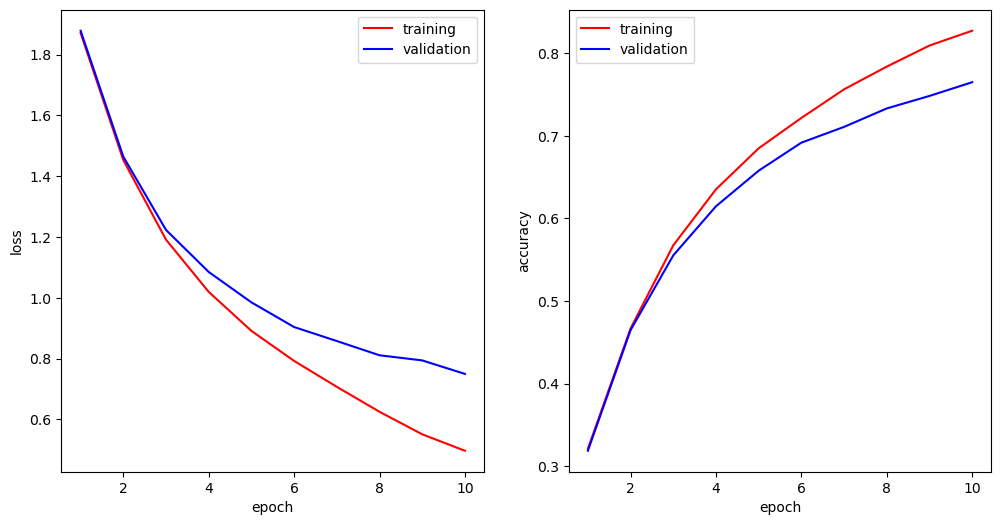

Fold #2
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 4999 samples
client 4 : 5002 samples
client 5 : 5001 samples
client 6 : 4998 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.7035, Accuracy = 0.4074
client 2 : Loss = 1.6119, Accuracy = 0.4236
client 3 : Loss = 1.7423, Accuracy = 0.3980
client 4 : Loss = 1.6676, Accuracy = 0.4196
client 5 : Loss = 1.7075, Accuracy = 0.3902
client 6 : Loss = 1.7470, Accuracy = 0.3794
client 7 : Loss = 1.7774, Accuracy = 0.3740
client 8 : Loss = 1.7465, Accuracy = 0.3965

Server :
    - training loss = 1.8277
    - training accuracy = 0.3254
    - validation loss = 1.8397
    - validation accuracy = 0.3215
        
>>> Round 2 ...
client 1 : Loss = 1.4552, Accuracy = 0.4746
client 2 : Loss = 1.3718, Accuracy = 0.5021
client 3 : Loss = 1.3887, Accuracy = 0.4945
client 4 : Loss = 1.3415, Accuracy = 0.5197
client 5 : Loss = 1.3711, Accuracy = 0.5014
client 6 : Loss = 1.3690, Accuracy = 0.5079
clie

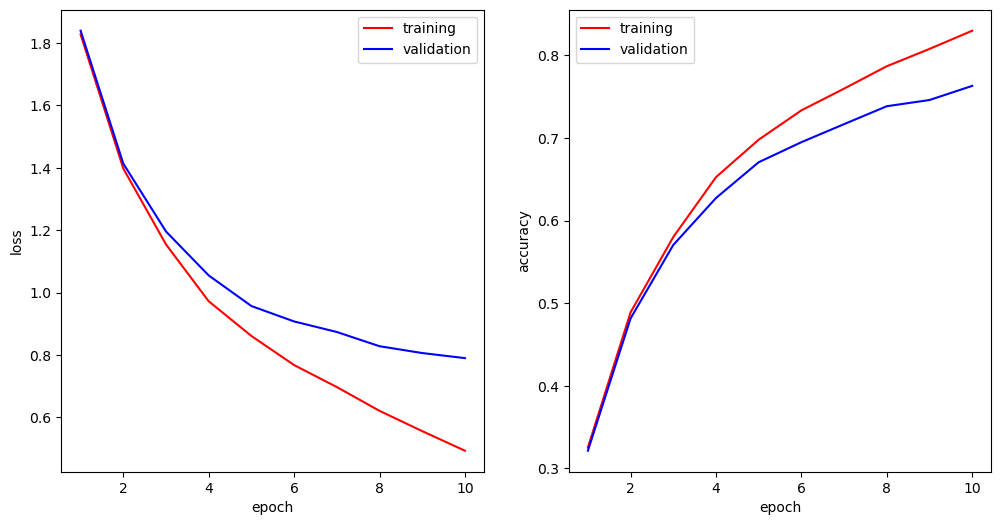

Fold #3
client 1 : 4999 samples
client 2 : 5001 samples
client 3 : 4999 samples
client 4 : 5002 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.6923, Accuracy = 0.4086
client 2 : Loss = 1.6780, Accuracy = 0.3883
client 3 : Loss = 1.7946, Accuracy = 0.3908
client 4 : Loss = 1.6634, Accuracy = 0.4162
client 5 : Loss = 1.7099, Accuracy = 0.3914
client 6 : Loss = 1.7525, Accuracy = 0.3871
client 7 : Loss = 1.6693, Accuracy = 0.3992
client 8 : Loss = 1.7875, Accuracy = 0.3729

Server :
    - training loss = 1.8751
    - training accuracy = 0.3236
    - validation loss = 1.8923
    - validation accuracy = 0.3187
        
>>> Round 2 ...
client 1 : Loss = 1.3233, Accuracy = 0.5119
client 2 : Loss = 1.3860, Accuracy = 0.4928
client 3 : Loss = 1.3912, Accuracy = 0.4965
client 4 : Loss = 1.3620, Accuracy = 0.5011
client 5 : Loss = 1.3050, Accuracy = 0.5211
client 6 : Loss = 1.4114, Accuracy = 0.4824
clie

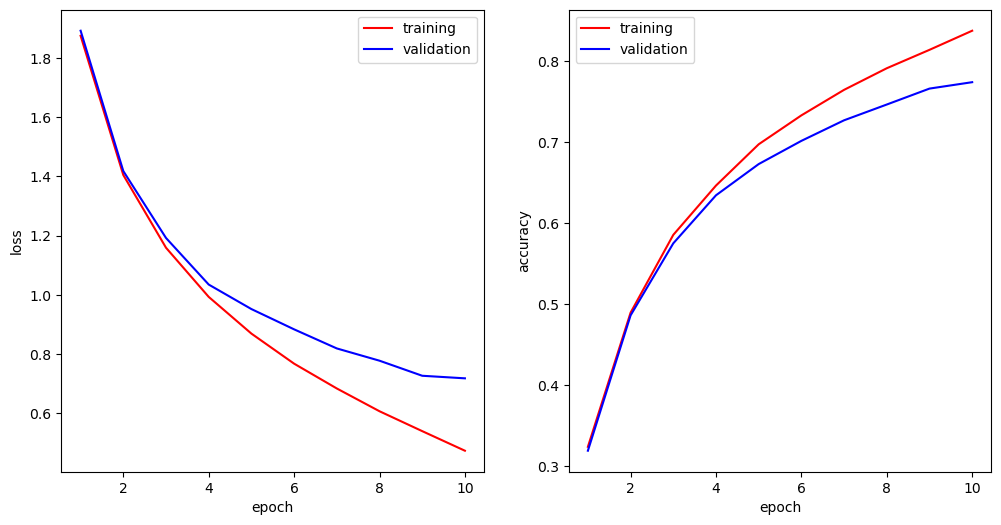

Fold #4
client 1 : 5001 samples
client 2 : 4998 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5000 samples
client 6 : 4999 samples
client 7 : 5000 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.6931, Accuracy = 0.3945
client 2 : Loss = 1.8484, Accuracy = 0.3608
client 3 : Loss = 1.7940, Accuracy = 0.3813
client 4 : Loss = 1.7845, Accuracy = 0.3762
client 5 : Loss = 1.8078, Accuracy = 0.3908
client 6 : Loss = 1.7908, Accuracy = 0.3873
client 7 : Loss = 1.8166, Accuracy = 0.3797
client 8 : Loss = 1.7793, Accuracy = 0.3926

Server :
    - training loss = 1.9219
    - training accuracy = 0.2985
    - validation loss = 1.9366
    - validation accuracy = 0.2942
        
>>> Round 2 ...
client 1 : Loss = 1.5050, Accuracy = 0.4508
client 2 : Loss = 1.4537, Accuracy = 0.4727
client 3 : Loss = 1.4705, Accuracy = 0.4634
client 4 : Loss = 1.3229, Accuracy = 0.5090
client 5 : Loss = 1.4750, Accuracy = 0.4602
client 6 : Loss = 1.3913, Accuracy = 0.5024
clie

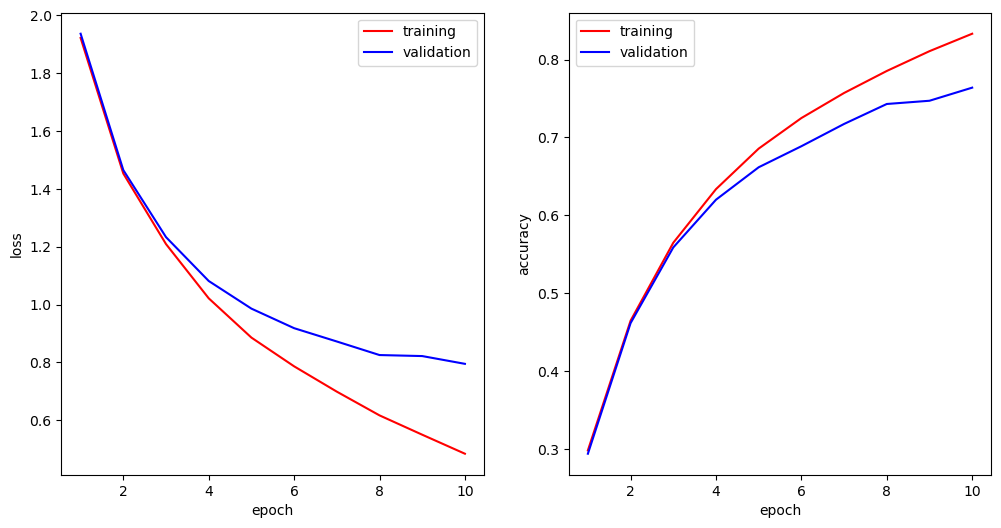

RESULTS


ValueError: too many values to unpack (expected 2)

In [ ]:
%%time
n_splits = 5
rounds = 10
batch_size = 128
epochs = 5
lr = 5e-3
optimizer = optim.Adam
#In the original setting, it was already B1=0.9, B2=0.999
betas_1 = [0.5, 0.95, 0.999]
betas_2 = [0.5, 0.95, 0.999]

results = []
for beta_1 in betas_1:
    for beta_2 in betas_2:
        res = run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr, betas=(beta_1, beta_2))
        results.append((beta_1, beta_2 ,res))
    
print("="*25)
print(f"RESULTS")
print("="*25)
for beta_1, beta_2,res in results:
    print(f"beta 1 = {beta_1:.3f}, beta 2 = {beta_2:.3f} : Accuracy = {res}")
print()


### Summary: Unfortunately, there was an error in result printing, however, it can be seen from Fold results that the best results are achieved with beta_1 = 0.5, beta_2 = 0.95, that as well outperformed the default values of 0.9, 0.999.

### In the end, best parameters are lr=0.005, betas = (0.5, 0.95)

## 3. Perform the cross validation for list of leraning rates and betas on Non-IID dataset.

### 3.1 Selecting lr

In [18]:
#Split the data in a non-iid way
proportions = generate_proportions(num_clients,num_classes, alpha=0.1)
proportions

[tensor([5.8258e-06, 1.3418e-02, 3.8577e-08, 9.2780e-01, 1.1994e-20, 5.0109e-07,
         5.8774e-02, 1.9820e-10]),
 tensor([7.1835e-02, 1.8115e-04, 1.2239e-02, 5.5099e-01, 1.2617e-29, 3.4115e-01,
         1.9799e-02, 3.8050e-03]),
 tensor([1.4787e-06, 8.3814e-01, 6.9813e-02, 8.8582e-07, 1.7929e-05, 8.2981e-03,
         8.2993e-02, 7.3801e-04]),
 tensor([5.3422e-08, 4.9903e-06, 3.6989e-02, 7.9815e-07, 8.4715e-03, 6.0040e-12,
         8.7382e-17, 9.5453e-01]),
 tensor([1.6736e-04, 1.6850e-13, 2.9363e-13, 5.5581e-01, 6.5501e-02, 1.0191e-01,
         2.3462e-02, 2.5316e-01]),
 tensor([1.2231e-19, 2.5063e-06, 2.1891e-07, 1.8516e-03, 1.4949e-01, 2.9673e-05,
         6.6019e-02, 7.8261e-01]),
 tensor([1.0577e-04, 4.8049e-06, 9.2850e-01, 1.1537e-04, 7.2822e-10, 7.0181e-02,
         1.0942e-03, 4.4152e-07]),
 tensor([6.9712e-07, 7.0154e-10, 5.9266e-03, 7.2205e-04, 4.1283e-04, 4.8942e-09,
         6.3553e-01, 3.5741e-01]),
 tensor([9.1626e-13, 9.6479e-02, 7.4254e-01, 1.3696e-01, 2.5235e-23, 9.8

Fold #0
client 1 : 6914 samples
client 2 : 4322 samples
client 3 : 2887 samples
client 4 : 8071 samples
client 5 : 2047 samples
client 6 : 1624 samples
client 7 : 4006 samples
client 8 : 10129 samples

>>> Round 1 ...
client 1 : Loss = 1.2103, Accuracy = 0.4798
client 2 : Loss = 0.5715, Accuracy = 0.7650
client 3 : Loss = 0.8836, Accuracy = 0.6856
client 4 : Loss = 1.0327, Accuracy = 0.4782
client 5 : Loss = 1.0392, Accuracy = 0.5188
client 6 : Loss = 0.4837, Accuracy = 0.8771
client 7 : Loss = 1.3795, Accuracy = 0.4968
client 8 : Loss = 1.1358, Accuracy = 0.3828

Server :
    - training loss = 2.3892
    - training accuracy = 0.0993
    - validation loss = 2.3873
    - validation accuracy = 0.1019
        
>>> Round 2 ...
client 1 : Loss = 1.2109, Accuracy = 0.4841
client 2 : Loss = 0.5630, Accuracy = 0.7645
client 3 : Loss = 0.8768, Accuracy = 0.6867
client 4 : Loss = 1.0315, Accuracy = 0.4854
client 5 : Loss = 1.0355, Accuracy = 0.5217
client 6 : Loss = 0.4839, Accuracy = 0.8757
cli

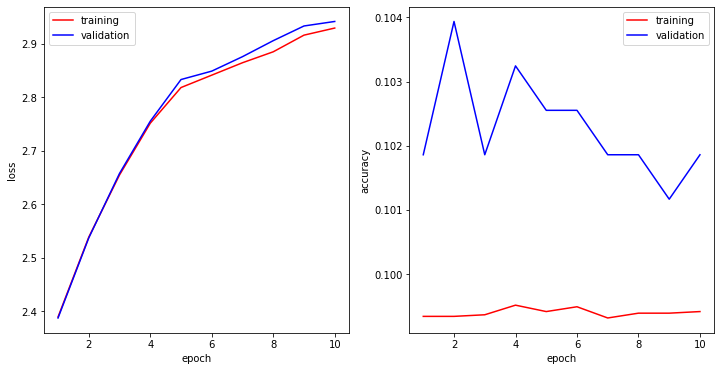

Fold #1
client 1 : 6882 samples
client 2 : 4378 samples
client 3 : 2843 samples
client 4 : 8089 samples
client 5 : 2054 samples
client 6 : 1642 samples
client 7 : 4005 samples
client 8 : 10107 samples

>>> Round 1 ...
client 1 : Loss = 0.9734, Accuracy = 0.6065
client 2 : Loss = 0.4802, Accuracy = 0.7927
client 3 : Loss = 0.6297, Accuracy = 0.7886
client 4 : Loss = 0.8702, Accuracy = 0.6484
client 5 : Loss = 0.6679, Accuracy = 0.7466
client 6 : Loss = 0.4027, Accuracy = 0.8766
client 7 : Loss = 0.9612, Accuracy = 0.6459
client 8 : Loss = 0.7289, Accuracy = 0.6426

Server :
    - training loss = 2.4195
    - training accuracy = 0.0996
    - validation loss = 2.4140
    - validation accuracy = 0.1008
        
>>> Round 2 ...
client 1 : Loss = 1.1532, Accuracy = 0.5013
client 2 : Loss = 0.3705, Accuracy = 0.8487
client 3 : Loss = 0.6008, Accuracy = 0.7981
client 4 : Loss = 1.0268, Accuracy = 0.4850
client 5 : Loss = 0.7792, Accuracy = 0.7057
client 6 : Loss = 0.3908, Accuracy = 0.8769
cli

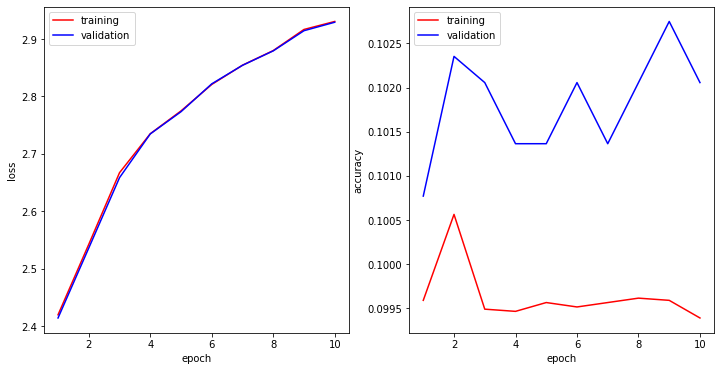

Fold #2
client 1 : 6886 samples
client 2 : 4304 samples
client 3 : 2854 samples
client 4 : 8071 samples
client 5 : 2057 samples
client 6 : 1632 samples
client 7 : 4034 samples
client 8 : 10162 samples

>>> Round 1 ...
client 1 : Loss = 1.2023, Accuracy = 0.4893
client 2 : Loss = 0.5685, Accuracy = 0.7619
client 3 : Loss = 0.8861, Accuracy = 0.6844
client 4 : Loss = 1.0306, Accuracy = 0.4873
client 5 : Loss = 1.0486, Accuracy = 0.5258
client 6 : Loss = 0.4877, Accuracy = 0.8780
client 7 : Loss = 1.3749, Accuracy = 0.5005
client 8 : Loss = 1.1360, Accuracy = 0.3855

Server :
    - training loss = 2.4200
    - training accuracy = 0.1002
    - validation loss = 2.4173
    - validation accuracy = 0.1008
        
>>> Round 2 ...
client 1 : Loss = 1.1942, Accuracy = 0.4934
client 2 : Loss = 0.5675, Accuracy = 0.7620
client 3 : Loss = 0.8811, Accuracy = 0.6828
client 4 : Loss = 1.0351, Accuracy = 0.4971
client 5 : Loss = 1.0422, Accuracy = 0.5211
client 6 : Loss = 0.4834, Accuracy = 0.8782
cli

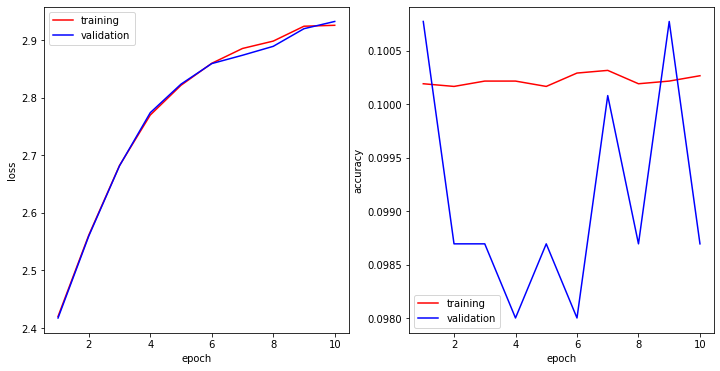

Fold #3
client 1 : 6882 samples
client 2 : 4328 samples
client 3 : 2824 samples
client 4 : 8095 samples
client 5 : 2058 samples
client 6 : 1636 samples
client 7 : 4032 samples
client 8 : 10145 samples

>>> Round 1 ...
client 1 : Loss = 0.9262, Accuracy = 0.6163
client 2 : Loss = 0.4875, Accuracy = 0.7891
client 3 : Loss = 0.6050, Accuracy = 0.8003
client 4 : Loss = 0.8255, Accuracy = 0.6493
client 5 : Loss = 0.7104, Accuracy = 0.7497
client 6 : Loss = 0.4407, Accuracy = 0.8760
client 7 : Loss = 1.0683, Accuracy = 0.6189
client 8 : Loss = 0.6998, Accuracy = 0.6623

Server :
    - training loss = 2.4893
    - training accuracy = 0.1003
    - validation loss = 2.4905
    - validation accuracy = 0.0991
        
>>> Round 2 ...
client 1 : Loss = 1.1975, Accuracy = 0.4954
client 2 : Loss = 0.4940, Accuracy = 0.7693
client 3 : Loss = 0.8932, Accuracy = 0.6807
client 4 : Loss = 1.0294, Accuracy = 0.4913
client 5 : Loss = 0.6708, Accuracy = 0.7402
client 6 : Loss = 0.4164, Accuracy = 0.8750
cli

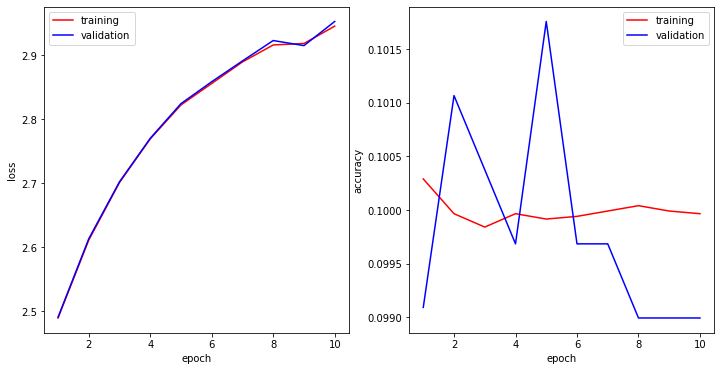

Fold #4
client 1 : 6839 samples
client 2 : 4301 samples
client 3 : 2843 samples
client 4 : 8164 samples
client 5 : 2042 samples
client 6 : 1635 samples
client 7 : 4024 samples
client 8 : 10152 samples

>>> Round 1 ...
client 1 : Loss = 1.0574, Accuracy = 0.5769
client 2 : Loss = 0.4619, Accuracy = 0.8060
client 3 : Loss = 0.6135, Accuracy = 0.7884
client 4 : Loss = 0.7500, Accuracy = 0.7058
client 5 : Loss = 0.6091, Accuracy = 0.7776
client 6 : Loss = 0.4029, Accuracy = 0.8793
client 7 : Loss = 1.0243, Accuracy = 0.6273
client 8 : Loss = 0.7108, Accuracy = 0.6546

Server :
    - training loss = 2.3794
    - training accuracy = 0.1008
    - validation loss = 2.3867
    - validation accuracy = 0.0956
        
>>> Round 2 ...
client 1 : Loss = 1.0528, Accuracy = 0.5785
client 2 : Loss = 0.4917, Accuracy = 0.7626
client 3 : Loss = 0.8042, Accuracy = 0.7286
client 4 : Loss = 0.9222, Accuracy = 0.6333
client 5 : Loss = 1.0344, Accuracy = 0.5248
client 6 : Loss = 0.3998, Accuracy = 0.8758
cli

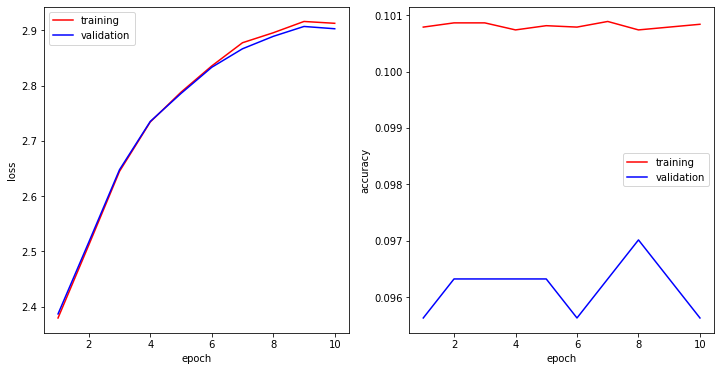

Fold #0
client 1 : 6914 samples
client 2 : 4322 samples
client 3 : 2887 samples
client 4 : 8071 samples
client 5 : 2047 samples
client 6 : 1624 samples
client 7 : 4006 samples
client 8 : 10129 samples

>>> Round 1 ...
client 1 : Loss = 0.7165, Accuracy = 0.7077
client 2 : Loss = 0.3815, Accuracy = 0.8587
client 3 : Loss = 0.6006, Accuracy = 0.8037
client 4 : Loss = 0.5987, Accuracy = 0.7878
client 5 : Loss = 0.3846, Accuracy = 0.8686
client 6 : Loss = 0.3793, Accuracy = 0.8922
client 7 : Loss = 0.7400, Accuracy = 0.7291
client 8 : Loss = 0.5760, Accuracy = 0.7504

Server :
    - training loss = 3.3525
    - training accuracy = 0.2039
    - validation loss = 3.3406
    - validation accuracy = 0.2104
        
>>> Round 2 ...
client 1 : Loss = 0.6649, Accuracy = 0.7332
client 2 : Loss = 0.2422, Accuracy = 0.9030
client 3 : Loss = 0.4647, Accuracy = 0.8336
client 4 : Loss = 0.3683, Accuracy = 0.8680
client 5 : Loss = 0.2093, Accuracy = 0.9262
client 6 : Loss = 0.2944, Accuracy = 0.9061
cli

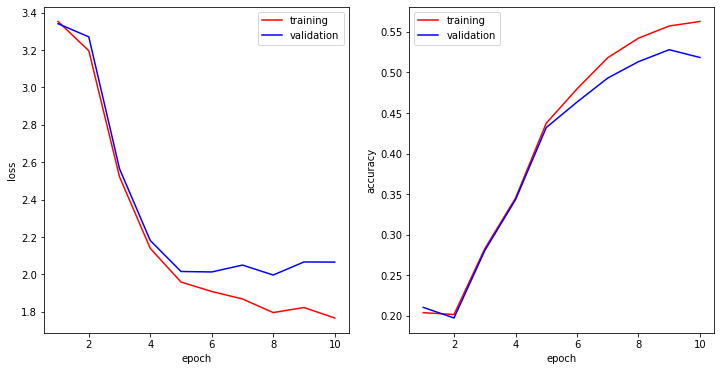

Fold #1
client 1 : 6882 samples
client 2 : 4378 samples
client 3 : 2843 samples
client 4 : 8089 samples
client 5 : 2054 samples
client 6 : 1642 samples
client 7 : 4005 samples
client 8 : 10107 samples

>>> Round 1 ...
client 1 : Loss = 0.6590, Accuracy = 0.7482
client 2 : Loss = 0.3318, Accuracy = 0.8628
client 3 : Loss = 0.5635, Accuracy = 0.8173
client 4 : Loss = 0.4057, Accuracy = 0.8520
client 5 : Loss = 0.4247, Accuracy = 0.8493
client 6 : Loss = 0.3576, Accuracy = 0.8860
client 7 : Loss = 0.7026, Accuracy = 0.7456
client 8 : Loss = 0.5467, Accuracy = 0.7681

Server :
    - training loss = 2.9930
    - training accuracy = 0.1546
    - validation loss = 3.0084
    - validation accuracy = 0.1527
        
>>> Round 2 ...
client 1 : Loss = 0.5546, Accuracy = 0.7804
client 2 : Loss = 0.2890, Accuracy = 0.8854
client 3 : Loss = 0.4275, Accuracy = 0.8467
client 4 : Loss = 0.3040, Accuracy = 0.8871
client 5 : Loss = 0.2984, Accuracy = 0.8951
client 6 : Loss = 0.2800, Accuracy = 0.9059
cli

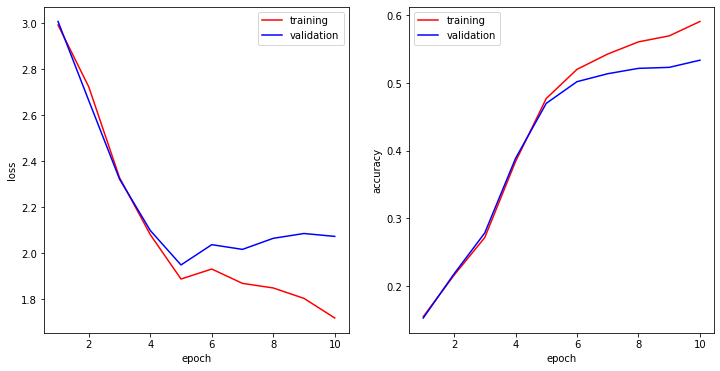

Fold #2
client 1 : 6886 samples
client 2 : 4304 samples
client 3 : 2854 samples
client 4 : 8071 samples
client 5 : 2057 samples
client 6 : 1632 samples
client 7 : 4034 samples
client 8 : 10162 samples

>>> Round 1 ...
client 1 : Loss = 0.6237, Accuracy = 0.7592
client 2 : Loss = 0.3071, Accuracy = 0.8779
client 3 : Loss = 0.5353, Accuracy = 0.8166
client 4 : Loss = 0.5930, Accuracy = 0.7850
client 5 : Loss = 0.5136, Accuracy = 0.8090
client 6 : Loss = 0.3210, Accuracy = 0.8938
client 7 : Loss = 0.6464, Accuracy = 0.7685
client 8 : Loss = 0.5343, Accuracy = 0.7646

Server :
    - training loss = 3.4422
    - training accuracy = 0.1461
    - validation loss = 3.4683
    - validation accuracy = 0.1477
        
>>> Round 2 ...
client 1 : Loss = 0.5337, Accuracy = 0.7974
client 2 : Loss = 0.2536, Accuracy = 0.9022
client 3 : Loss = 0.4415, Accuracy = 0.8432
client 4 : Loss = 0.3476, Accuracy = 0.8744
client 5 : Loss = 0.2957, Accuracy = 0.8951
client 6 : Loss = 0.2744, Accuracy = 0.9038
cli

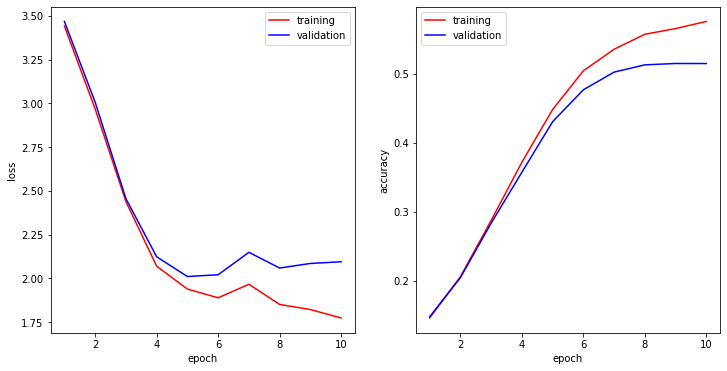

Fold #3
client 1 : 6882 samples
client 2 : 4328 samples
client 3 : 2824 samples
client 4 : 8095 samples
client 5 : 2058 samples
client 6 : 1636 samples
client 7 : 4032 samples
client 8 : 10145 samples

>>> Round 1 ...
client 1 : Loss = 0.6141, Accuracy = 0.7598
client 2 : Loss = 0.3849, Accuracy = 0.8514
client 3 : Loss = 0.6897, Accuracy = 0.7609
client 4 : Loss = 0.4189, Accuracy = 0.8444
client 5 : Loss = 0.4221, Accuracy = 0.8637
client 6 : Loss = 0.3236, Accuracy = 0.8993
client 7 : Loss = 0.6922, Accuracy = 0.7466
client 8 : Loss = 0.5623, Accuracy = 0.7551

Server :
    - training loss = 3.1632
    - training accuracy = 0.1641
    - validation loss = 3.1613
    - validation accuracy = 0.1675
        
>>> Round 2 ...
client 1 : Loss = 0.5317, Accuracy = 0.7973
client 2 : Loss = 0.2863, Accuracy = 0.8878
client 3 : Loss = 0.4198, Accuracy = 0.8488
client 4 : Loss = 0.3103, Accuracy = 0.8876
client 5 : Loss = 0.2827, Accuracy = 0.9151
client 6 : Loss = 0.2326, Accuracy = 0.9169
cli

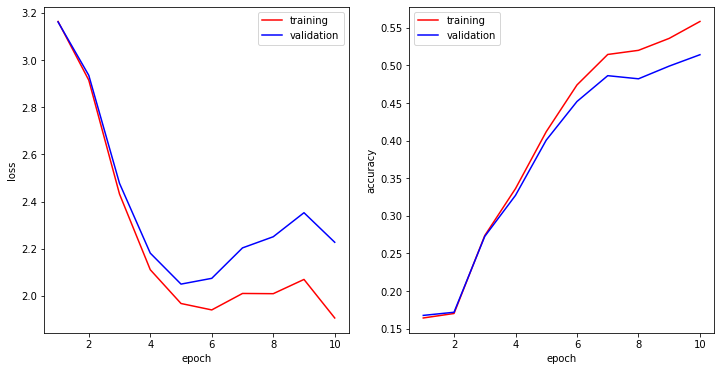

Fold #4
client 1 : 6839 samples
client 2 : 4301 samples
client 3 : 2843 samples
client 4 : 8164 samples
client 5 : 2042 samples
client 6 : 1635 samples
client 7 : 4024 samples
client 8 : 10152 samples

>>> Round 1 ...
client 1 : Loss = 0.6462, Accuracy = 0.7476
client 2 : Loss = 0.2978, Accuracy = 0.8782
client 3 : Loss = 0.5841, Accuracy = 0.8059
client 4 : Loss = 0.4302, Accuracy = 0.8394
client 5 : Loss = 0.3723, Accuracy = 0.8766
client 6 : Loss = 0.4190, Accuracy = 0.8785
client 7 : Loss = 0.6599, Accuracy = 0.7620
client 8 : Loss = 0.5514, Accuracy = 0.7589

Server :
    - training loss = 2.9533
    - training accuracy = 0.1780
    - validation loss = 2.9373
    - validation accuracy = 0.1740
        
>>> Round 2 ...
client 1 : Loss = 0.5722, Accuracy = 0.7784
client 2 : Loss = 0.2687, Accuracy = 0.8869
client 3 : Loss = 0.4133, Accuracy = 0.8489
client 4 : Loss = 0.3125, Accuracy = 0.8848
client 5 : Loss = 0.2591, Accuracy = 0.9123
client 6 : Loss = 0.2811, Accuracy = 0.9001
cli

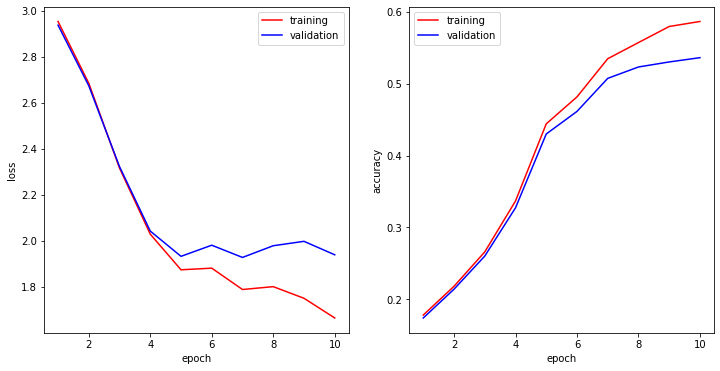

Fold #0
client 1 : 6914 samples
client 2 : 4322 samples
client 3 : 2887 samples
client 4 : 8071 samples
client 5 : 2047 samples
client 6 : 1624 samples
client 7 : 4006 samples
client 8 : 10129 samples

>>> Round 1 ...
client 1 : Loss = 0.5449, Accuracy = 0.8013
client 2 : Loss = 0.1393, Accuracy = 0.9450
client 3 : Loss = 0.1812, Accuracy = 0.9329
client 4 : Loss = 0.2641, Accuracy = 0.9016
client 5 : Loss = 0.1258, Accuracy = 0.9541
client 6 : Loss = 0.0668, Accuracy = 0.9796
client 7 : Loss = 0.3582, Accuracy = 0.8769
client 8 : Loss = 0.4428, Accuracy = 0.8075

Server :
    - training loss = 2.0615
    - training accuracy = 0.3042
    - validation loss = 2.1204
    - validation accuracy = 0.2954
        
>>> Round 2 ...
client 1 : Loss = 0.5459, Accuracy = 0.7928
client 2 : Loss = 0.0785, Accuracy = 0.9711
client 3 : Loss = 0.1068, Accuracy = 0.9649
client 4 : Loss = 0.1730, Accuracy = 0.9381
client 5 : Loss = 0.0500, Accuracy = 0.9858
client 6 : Loss = 0.0638, Accuracy = 0.9766
cli

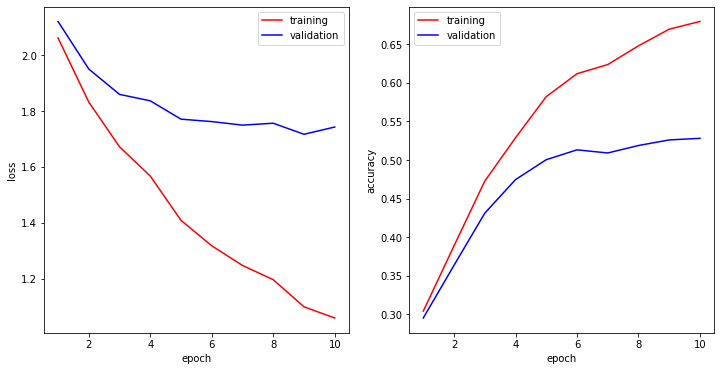

Fold #1
client 1 : 6882 samples
client 2 : 4378 samples
client 3 : 2843 samples
client 4 : 8089 samples
client 5 : 2054 samples
client 6 : 1642 samples
client 7 : 4005 samples
client 8 : 10107 samples

>>> Round 1 ...
client 1 : Loss = 0.3462, Accuracy = 0.8736
client 2 : Loss = 0.1462, Accuracy = 0.9471
client 3 : Loss = 0.2477, Accuracy = 0.9092
client 4 : Loss = 0.2223, Accuracy = 0.9189
client 5 : Loss = 0.1959, Accuracy = 0.9308
client 6 : Loss = 0.1073, Accuracy = 0.9648
client 7 : Loss = 0.3235, Accuracy = 0.8893
client 8 : Loss = 0.3909, Accuracy = 0.8359

Server :
    - training loss = 2.1334
    - training accuracy = 0.3003
    - validation loss = 2.1767
    - validation accuracy = 0.2944
        
>>> Round 2 ...
client 1 : Loss = 0.1819, Accuracy = 0.9360
client 2 : Loss = 0.0625, Accuracy = 0.9801
client 3 : Loss = 0.1037, Accuracy = 0.9688
client 4 : Loss = 0.1180, Accuracy = 0.9588
client 5 : Loss = 0.1730, Accuracy = 0.9418
client 6 : Loss = 0.0381, Accuracy = 0.9889
cli

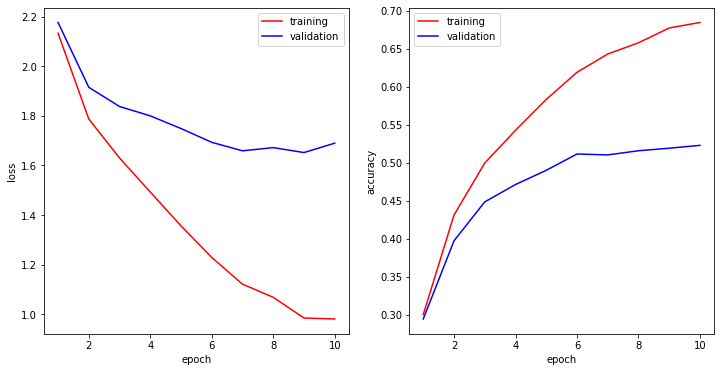

Fold #2
client 1 : 6886 samples
client 2 : 4304 samples
client 3 : 2854 samples
client 4 : 8071 samples
client 5 : 2057 samples
client 6 : 1632 samples
client 7 : 4034 samples
client 8 : 10162 samples

>>> Round 1 ...
client 1 : Loss = 0.3550, Accuracy = 0.8663
client 2 : Loss = 0.1120, Accuracy = 0.9573
client 3 : Loss = 0.1890, Accuracy = 0.9294
client 4 : Loss = 0.2075, Accuracy = 0.9220
client 5 : Loss = 0.1643, Accuracy = 0.9458
client 6 : Loss = 0.0731, Accuracy = 0.9806
client 7 : Loss = 0.3099, Accuracy = 0.8936
client 8 : Loss = 0.4048, Accuracy = 0.8310

Server :
    - training loss = 1.9527
    - training accuracy = 0.3194
    - validation loss = 2.0132
    - validation accuracy = 0.3029
        
>>> Round 2 ...
client 1 : Loss = 0.1925, Accuracy = 0.9347
client 2 : Loss = 0.0685, Accuracy = 0.9776
client 3 : Loss = 0.1030, Accuracy = 0.9671
client 4 : Loss = 0.1997, Accuracy = 0.9263
client 5 : Loss = 0.1125, Accuracy = 0.9595
client 6 : Loss = 0.0342, Accuracy = 0.9928
cli

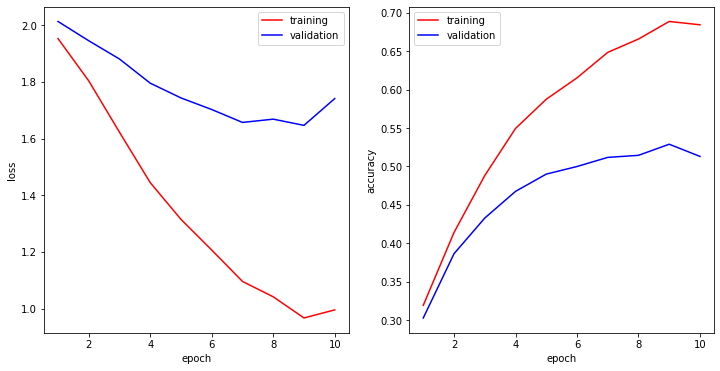

Fold #3
client 1 : 6882 samples
client 2 : 4328 samples
client 3 : 2824 samples
client 4 : 8095 samples
client 5 : 2058 samples
client 6 : 1636 samples
client 7 : 4032 samples
client 8 : 10145 samples

>>> Round 1 ...
client 1 : Loss = 0.3562, Accuracy = 0.8676
client 2 : Loss = 0.1216, Accuracy = 0.9513
client 3 : Loss = 0.3315, Accuracy = 0.8804
client 4 : Loss = 0.2299, Accuracy = 0.9167
client 5 : Loss = 0.1210, Accuracy = 0.9573
client 6 : Loss = 0.0897, Accuracy = 0.9700
client 7 : Loss = 0.3152, Accuracy = 0.8894
client 8 : Loss = 0.4325, Accuracy = 0.8149

Server :
    - training loss = 2.0674
    - training accuracy = 0.3113
    - validation loss = 2.1235
    - validation accuracy = 0.2990
        
>>> Round 2 ...
client 1 : Loss = 0.2082, Accuracy = 0.9259
client 2 : Loss = 0.0610, Accuracy = 0.9809
client 3 : Loss = 0.1725, Accuracy = 0.9416
client 4 : Loss = 0.1288, Accuracy = 0.9559
client 5 : Loss = 0.0839, Accuracy = 0.9670
client 6 : Loss = 0.0452, Accuracy = 0.9834
cli

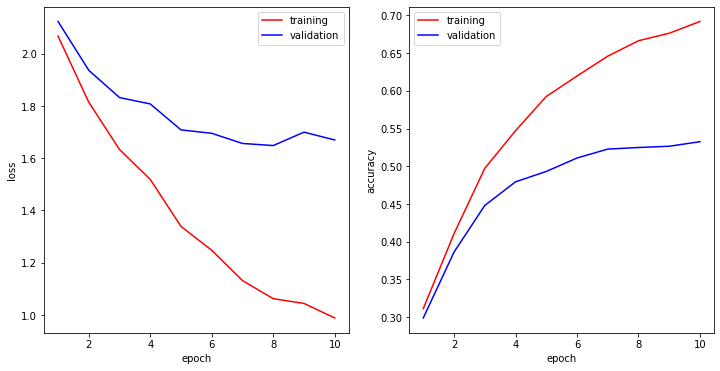

Fold #4
client 1 : 6839 samples
client 2 : 4301 samples
client 3 : 2843 samples
client 4 : 8164 samples
client 5 : 2042 samples
client 6 : 1635 samples
client 7 : 4024 samples
client 8 : 10152 samples

>>> Round 1 ...
client 1 : Loss = 0.3782, Accuracy = 0.8551
client 2 : Loss = 0.1334, Accuracy = 0.9481
client 3 : Loss = 0.2390, Accuracy = 0.9166
client 4 : Loss = 0.2325, Accuracy = 0.9117
client 5 : Loss = 0.0962, Accuracy = 0.9687
client 6 : Loss = 0.0868, Accuracy = 0.9712
client 7 : Loss = 0.2889, Accuracy = 0.8939
client 8 : Loss = 0.4198, Accuracy = 0.8216

Server :
    - training loss = 1.9954
    - training accuracy = 0.3097
    - validation loss = 2.0545
    - validation accuracy = 0.2944
        
>>> Round 2 ...
client 1 : Loss = 0.2247, Accuracy = 0.9204
client 2 : Loss = 0.0698, Accuracy = 0.9764
client 3 : Loss = 0.1069, Accuracy = 0.9631
client 4 : Loss = 0.1101, Accuracy = 0.9608
client 5 : Loss = 0.0397, Accuracy = 0.9897
client 6 : Loss = 0.0475, Accuracy = 0.9872
cli

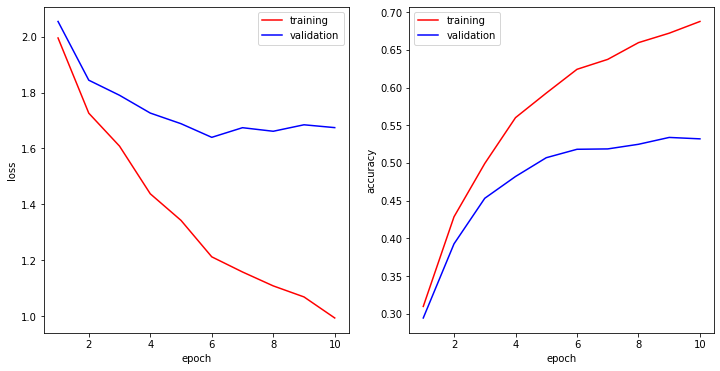

Fold #0
client 1 : 6914 samples
client 2 : 4322 samples
client 3 : 2887 samples
client 4 : 8071 samples
client 5 : 2047 samples
client 6 : 1624 samples
client 7 : 4006 samples
client 8 : 10129 samples

>>> Round 1 ...
client 1 : Loss = 0.6640, Accuracy = 0.7467
client 2 : Loss = 0.2200, Accuracy = 0.9224
client 3 : Loss = 0.3739, Accuracy = 0.8845
client 4 : Loss = 0.4633, Accuracy = 0.8300
client 5 : Loss = 0.2865, Accuracy = 0.9150
client 6 : Loss = 0.3536, Accuracy = 0.9134
client 7 : Loss = 0.5667, Accuracy = 0.8041
client 8 : Loss = 0.5260, Accuracy = 0.7816

Server :
    - training loss = 1.9833
    - training accuracy = 0.2901
    - validation loss = 2.0350
    - validation accuracy = 0.2753
        
>>> Round 2 ...
client 1 : Loss = 0.5758, Accuracy = 0.7783
client 2 : Loss = 0.2045, Accuracy = 0.9271
client 3 : Loss = 0.3397, Accuracy = 0.8976
client 4 : Loss = 0.3695, Accuracy = 0.8650
client 5 : Loss = 0.2449, Accuracy = 0.9311
client 6 : Loss = 0.2799, Accuracy = 0.9318
cli

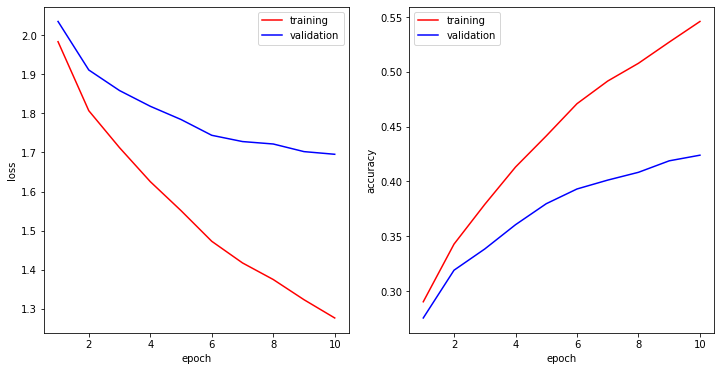

Fold #1
client 1 : 6882 samples
client 2 : 4378 samples
client 3 : 2843 samples
client 4 : 8089 samples
client 5 : 2054 samples
client 6 : 1642 samples
client 7 : 4005 samples
client 8 : 10107 samples

>>> Round 1 ...
client 1 : Loss = 0.5614, Accuracy = 0.7882
client 2 : Loss = 0.2193, Accuracy = 0.9196
client 3 : Loss = 0.4093, Accuracy = 0.8718
client 4 : Loss = 0.4361, Accuracy = 0.8409
client 5 : Loss = 0.3791, Accuracy = 0.8909
client 6 : Loss = 0.3107, Accuracy = 0.9271
client 7 : Loss = 0.5969, Accuracy = 0.7962
client 8 : Loss = 0.4926, Accuracy = 0.8000

Server :
    - training loss = 1.9932
    - training accuracy = 0.2832
    - validation loss = 2.0543
    - validation accuracy = 0.2579
        
>>> Round 2 ...
client 1 : Loss = 0.4762, Accuracy = 0.8254
client 2 : Loss = 0.2080, Accuracy = 0.9261
client 3 : Loss = 0.3564, Accuracy = 0.8862
client 4 : Loss = 0.3401, Accuracy = 0.8743
client 5 : Loss = 0.2679, Accuracy = 0.9311
client 6 : Loss = 0.2667, Accuracy = 0.9292
cli

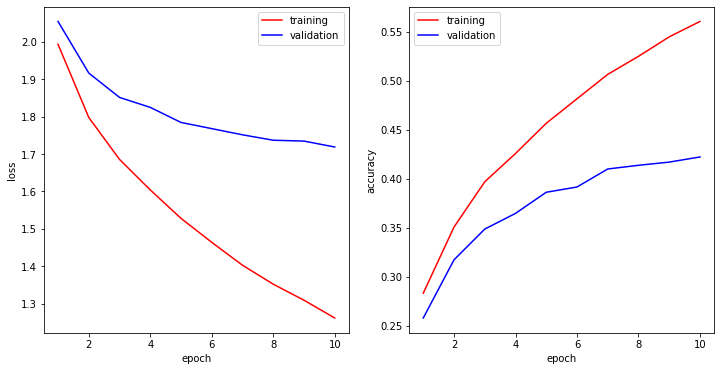

Fold #2
client 1 : 6886 samples
client 2 : 4304 samples
client 3 : 2854 samples
client 4 : 8071 samples
client 5 : 2057 samples
client 6 : 1632 samples
client 7 : 4034 samples
client 8 : 10162 samples

>>> Round 1 ...
client 1 : Loss = 2.0399, Accuracy = 0.4894
client 2 : Loss = 2.1335, Accuracy = 0.7630
client 3 : Loss = 2.2136, Accuracy = 0.6844
client 4 : Loss = 1.9002, Accuracy = 0.4892
client 5 : Loss = 2.2493, Accuracy = 0.5183
client 6 : Loss = 2.2519, Accuracy = 0.8772
client 7 : Loss = 2.2127, Accuracy = 0.5014
client 8 : Loss = 1.6790, Accuracy = 0.3391

Server :
    - training loss = 2.3040
    - training accuracy = 0.1002
    - validation loss = 2.3045
    - validation accuracy = 0.0980
        
>>> Round 2 ...
client 1 : Loss = 1.5119, Accuracy = 0.4933
client 2 : Loss = 1.6894, Accuracy = 0.7622
client 3 : Loss = 1.9609, Accuracy = 0.4923
client 4 : Loss = 1.2793, Accuracy = 0.4993
client 5 : Loss = 2.1168, Accuracy = 0.5379
client 6 : Loss = 2.1554, Accuracy = 0.8676
cli

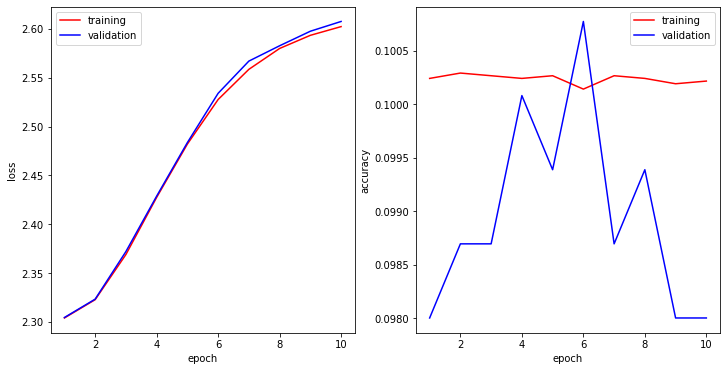

Fold #3
client 1 : 6882 samples
client 2 : 4328 samples
client 3 : 2824 samples
client 4 : 8095 samples
client 5 : 2058 samples
client 6 : 1636 samples
client 7 : 4032 samples
client 8 : 10145 samples

>>> Round 1 ...
client 1 : Loss = 2.0496, Accuracy = 0.4574
client 2 : Loss = 2.1483, Accuracy = 0.7628
client 3 : Loss = 2.2151, Accuracy = 0.6912
client 4 : Loss = 1.7619, Accuracy = 0.4420
client 5 : Loss = 2.2588, Accuracy = 0.5221
client 6 : Loss = 2.2548, Accuracy = 0.8793
client 7 : Loss = 2.2182, Accuracy = 0.4973
client 8 : Loss = 1.6709, Accuracy = 0.3874

Server :
    - training loss = 2.3050
    - training accuracy = 0.0999
    - validation loss = 2.3048
    - validation accuracy = 0.1011
        
>>> Round 2 ...
client 1 : Loss = 1.5563, Accuracy = 0.4942
client 2 : Loss = 1.7618, Accuracy = 0.7629
client 3 : Loss = 1.9519, Accuracy = 0.5044
client 4 : Loss = 1.2209, Accuracy = 0.4917
client 5 : Loss = 2.1566, Accuracy = 0.5176
client 6 : Loss = 2.1513, Accuracy = 0.8569
cli

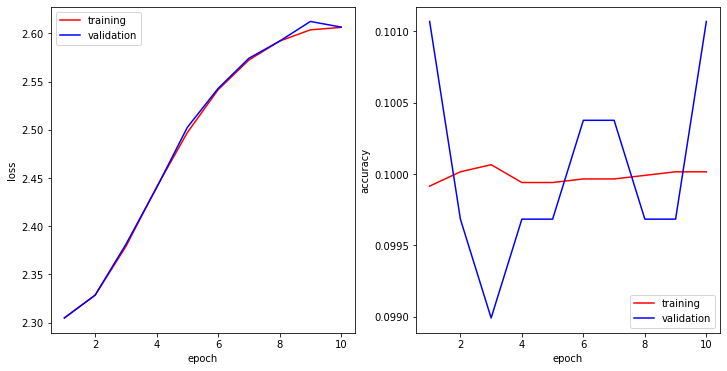

Fold #4
client 1 : 6839 samples
client 2 : 4301 samples
client 3 : 2843 samples
client 4 : 8164 samples
client 5 : 2042 samples
client 6 : 1635 samples
client 7 : 4024 samples
client 8 : 10152 samples

>>> Round 1 ...
client 1 : Loss = 0.5733, Accuracy = 0.7777
client 2 : Loss = 0.2263, Accuracy = 0.9210
client 3 : Loss = 0.3816, Accuracy = 0.8744
client 4 : Loss = 0.4139, Accuracy = 0.8448
client 5 : Loss = 0.2824, Accuracy = 0.9135
client 6 : Loss = 0.4260, Accuracy = 0.9003
client 7 : Loss = 0.5838, Accuracy = 0.7970
client 8 : Loss = 0.4959, Accuracy = 0.7965

Server :
    - training loss = 1.9547
    - training accuracy = 0.2992
    - validation loss = 2.0330
    - validation accuracy = 0.2678
        
>>> Round 2 ...
client 1 : Loss = 0.4887, Accuracy = 0.8160
client 2 : Loss = 0.2053, Accuracy = 0.9298
client 3 : Loss = 0.3142, Accuracy = 0.9005
client 4 : Loss = 0.3147, Accuracy = 0.8875
client 5 : Loss = 0.2694, Accuracy = 0.9212
client 6 : Loss = 0.2950, Accuracy = 0.9310
cli

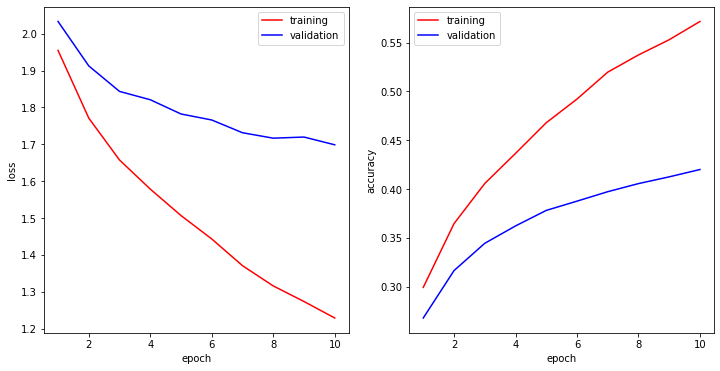

RESULTS
lr = 0.1000 : Accuracy = 0.09944620728492737
lr = 0.0100 : Accuracy = 0.5234177112579346
lr = 0.0010 : Accuracy = 0.5257120132446289
lr = 0.0001 : Accuracy = 0.2930379807949066

CPU times: user 1h 27min 45s, sys: 18min 1s, total: 1h 45min 46s
Wall time: 6h 34min 26s


In [ ]:
%%time
n_splits = 5
rounds = 10
batch_size = 128
epochs = 5
lrs = [1e-1,1e-2,1e-3,1e-4]
optimizer = optim.Adam

results = []
for lr in lrs:
    res = run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr)
    results.append((lr,res))
    
print("="*25)
print(f"RESULTS")
print("="*25)
for lr,res in results:
    print(f"lr = {lr:.4f} : Accuracy = {res}")
print()


### Comment: It can be seen that best learning rates are 0.001 and 0.01. Let's try to check for value in between these values, 0.005:

Fold #0
client 1 : 2564 samples
client 2 : 3766 samples
client 3 : 7174 samples
client 4 : 8820 samples
client 5 : 899 samples
client 6 : 2104 samples
client 7 : 3564 samples
client 8 : 11109 samples

>>> Round 1 ...
client 1 : Loss = 0.4913, Accuracy = 0.8527
client 2 : Loss = 0.1858, Accuracy = 0.9363
client 3 : Loss = 0.5031, Accuracy = 0.8621
client 4 : Loss = 0.4690, Accuracy = 0.8324
client 5 : Loss = 0.7845, Accuracy = 0.6517
client 6 : Loss = 0.4993, Accuracy = 0.8031
client 7 : Loss = 0.6696, Accuracy = 0.7815
client 8 : Loss = 0.8082, Accuracy = 0.6845

Server :
    - training loss = 2.7085
    - training accuracy = 0.2466
    - validation loss = 2.7145
    - validation accuracy = 0.2396
        
>>> Round 2 ...
client 1 : Loss = 0.2712, Accuracy = 0.9059
client 2 : Loss = 0.1662, Accuracy = 0.9426
client 3 : Loss = 0.3535, Accuracy = 0.8955
client 4 : Loss = 0.3653, Accuracy = 0.8650
client 5 : Loss = 0.7235, Accuracy = 0.7669
client 6 : Loss = 0.3916, Accuracy = 0.8571
clie

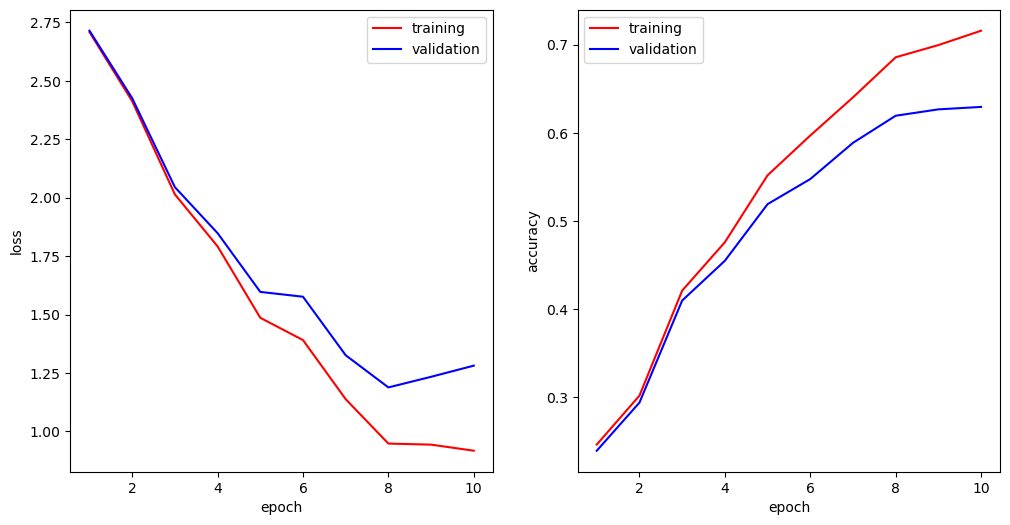

Fold #1
client 1 : 2584 samples
client 2 : 3808 samples
client 3 : 7217 samples
client 4 : 8740 samples
client 5 : 892 samples
client 6 : 2094 samples
client 7 : 3562 samples
client 8 : 11103 samples

>>> Round 1 ...
client 1 : Loss = 0.3311, Accuracy = 0.8821
client 2 : Loss = 0.2046, Accuracy = 0.9331
client 3 : Loss = 0.3669, Accuracy = 0.8951
client 4 : Loss = 0.4902, Accuracy = 0.8333
client 5 : Loss = 0.6474, Accuracy = 0.7199
client 6 : Loss = 0.4873, Accuracy = 0.7989
client 7 : Loss = 0.6993, Accuracy = 0.7695
client 8 : Loss = 0.8548, Accuracy = 0.6655

Server :
    - training loss = 2.8612
    - training accuracy = 0.2329
    - validation loss = 2.8667
    - validation accuracy = 0.2379
        
>>> Round 2 ...
client 1 : Loss = 0.2435, Accuracy = 0.8924
client 2 : Loss = 0.1861, Accuracy = 0.9380
client 3 : Loss = 0.3213, Accuracy = 0.9013
client 4 : Loss = 0.3698, Accuracy = 0.8690
client 5 : Loss = 0.4060, Accuracy = 0.8272
client 6 : Loss = 0.3556, Accuracy = 0.8634
clie

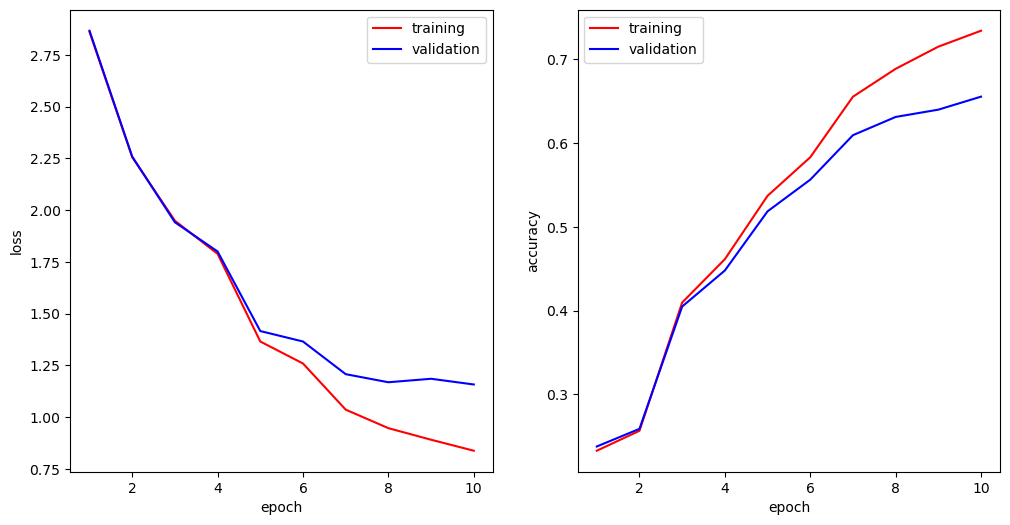

Fold #2
client 1 : 2585 samples
client 2 : 3791 samples
client 3 : 7182 samples
client 4 : 8745 samples
client 5 : 898 samples
client 6 : 2073 samples
client 7 : 3568 samples
client 8 : 11158 samples

>>> Round 1 ...
client 1 : Loss = 0.2591, Accuracy = 0.8977
client 2 : Loss = 0.2182, Accuracy = 0.9243
client 3 : Loss = 0.3804, Accuracy = 0.8848
client 4 : Loss = 0.5486, Accuracy = 0.8080
client 5 : Loss = 1.1479, Accuracy = 0.6318
client 6 : Loss = 0.4762, Accuracy = 0.8273
client 7 : Loss = 0.6778, Accuracy = 0.7746
client 8 : Loss = 0.8770, Accuracy = 0.6532

Server :
    - training loss = 2.5948
    - training accuracy = 0.2386
    - validation loss = 2.5691
    - validation accuracy = 0.2355
        
>>> Round 2 ...
client 1 : Loss = 0.2244, Accuracy = 0.9035
client 2 : Loss = 0.1849, Accuracy = 0.9372
client 3 : Loss = 0.3515, Accuracy = 0.8939
client 4 : Loss = 0.3802, Accuracy = 0.8635
client 5 : Loss = 0.5691, Accuracy = 0.7617
client 6 : Loss = 0.3766, Accuracy = 0.8758
clie

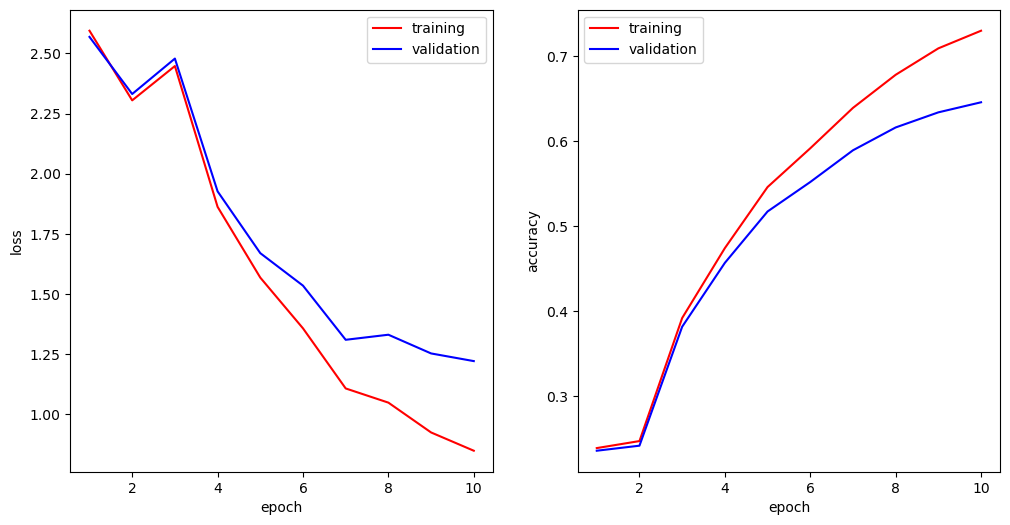

Fold #3
client 1 : 2576 samples
client 2 : 3802 samples
client 3 : 7197 samples
client 4 : 8701 samples
client 5 : 899 samples
client 6 : 2091 samples
client 7 : 3577 samples
client 8 : 11157 samples

>>> Round 1 ...
client 1 : Loss = 0.3750, Accuracy = 0.8824
client 2 : Loss = 0.2011, Accuracy = 0.9317
client 3 : Loss = 0.3757, Accuracy = 0.8939
client 4 : Loss = 0.5246, Accuracy = 0.8165
client 5 : Loss = 0.8230, Accuracy = 0.6888
client 6 : Loss = 0.4788, Accuracy = 0.8126
client 7 : Loss = 0.6536, Accuracy = 0.7781
client 8 : Loss = 0.8292, Accuracy = 0.6686

Server :
    - training loss = 3.1428
    - training accuracy = 0.2481
    - validation loss = 3.1811
    - validation accuracy = 0.2468
        
>>> Round 2 ...
client 1 : Loss = 0.2943, Accuracy = 0.8929
client 2 : Loss = 0.1823, Accuracy = 0.9373
client 3 : Loss = 0.3514, Accuracy = 0.8937
client 4 : Loss = 0.3606, Accuracy = 0.8716
client 5 : Loss = 0.6241, Accuracy = 0.7093
client 6 : Loss = 0.3396, Accuracy = 0.8801
clie

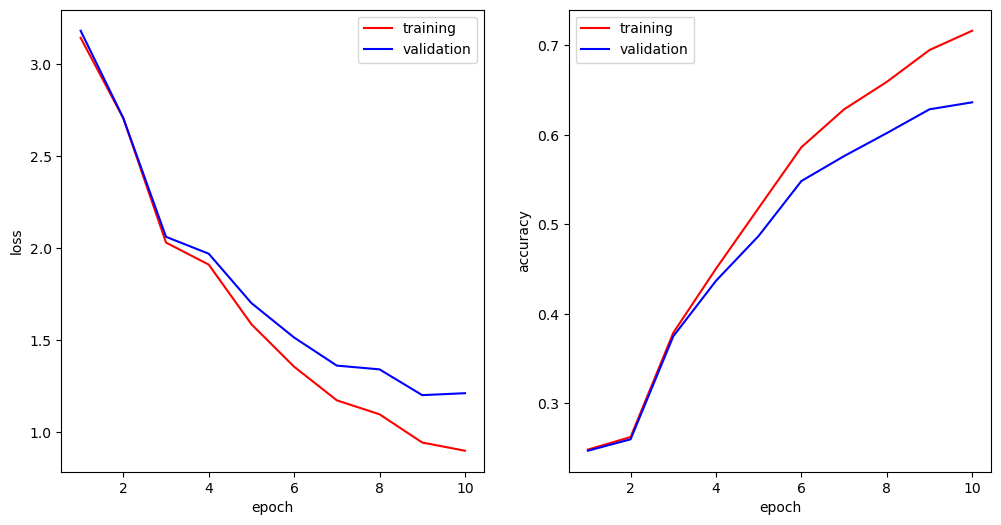

Fold #4
client 1 : 2619 samples
client 2 : 3799 samples
client 3 : 7152 samples
client 4 : 8739 samples
client 5 : 896 samples
client 6 : 2091 samples
client 7 : 3532 samples
client 8 : 11172 samples

>>> Round 1 ...
client 1 : Loss = 0.3130, Accuracy = 0.8954
client 2 : Loss = 0.1961, Accuracy = 0.9421
client 3 : Loss = 0.3607, Accuracy = 0.8917
client 4 : Loss = 0.4114, Accuracy = 0.8548
client 5 : Loss = 0.6533, Accuracy = 0.7478
client 6 : Loss = 0.4894, Accuracy = 0.7842
client 7 : Loss = 0.6311, Accuracy = 0.7820
client 8 : Loss = 0.8115, Accuracy = 0.6772

Server :
    - training loss = 2.9139
    - training accuracy = 0.2586
    - validation loss = 2.9525
    - validation accuracy = 0.2590
        
>>> Round 2 ...
client 1 : Loss = 0.1921, Accuracy = 0.9260
client 2 : Loss = 0.1827, Accuracy = 0.9365
client 3 : Loss = 0.2988, Accuracy = 0.9066
client 4 : Loss = 0.3238, Accuracy = 0.8835
client 5 : Loss = 0.4206, Accuracy = 0.8438
client 6 : Loss = 0.4049, Accuracy = 0.8410
clie

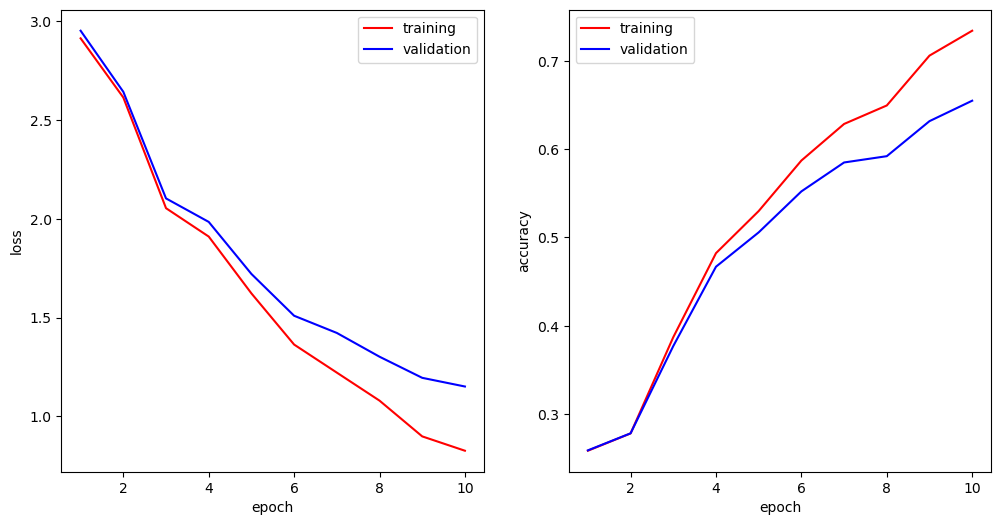

Fold #0
client 1 : 2564 samples
client 2 : 3766 samples
client 3 : 7174 samples
client 4 : 8820 samples
client 5 : 899 samples
client 6 : 2104 samples
client 7 : 3564 samples
client 8 : 11109 samples

>>> Round 1 ...
client 1 : Loss = 0.2974, Accuracy = 0.8839
client 2 : Loss = 0.2032, Accuracy = 0.9352
client 3 : Loss = 0.3307, Accuracy = 0.8975
client 4 : Loss = 0.3861, Accuracy = 0.8596
client 5 : Loss = 0.7475, Accuracy = 0.7181
client 6 : Loss = 0.4035, Accuracy = 0.8545
client 7 : Loss = 0.5832, Accuracy = 0.7973
client 8 : Loss = 0.6852, Accuracy = 0.7342

Server :
    - training loss = 2.3840
    - training accuracy = 0.3021
    - validation loss = 2.3953
    - validation accuracy = 0.2929
        
>>> Round 2 ...
client 1 : Loss = 0.3097, Accuracy = 0.9096
client 2 : Loss = 0.1341, Accuracy = 0.9573
client 3 : Loss = 0.3327, Accuracy = 0.9027
client 4 : Loss = 0.2510, Accuracy = 0.9074
client 5 : Loss = 0.4009, Accuracy = 0.8226
client 6 : Loss = 0.2843, Accuracy = 0.8990
clie

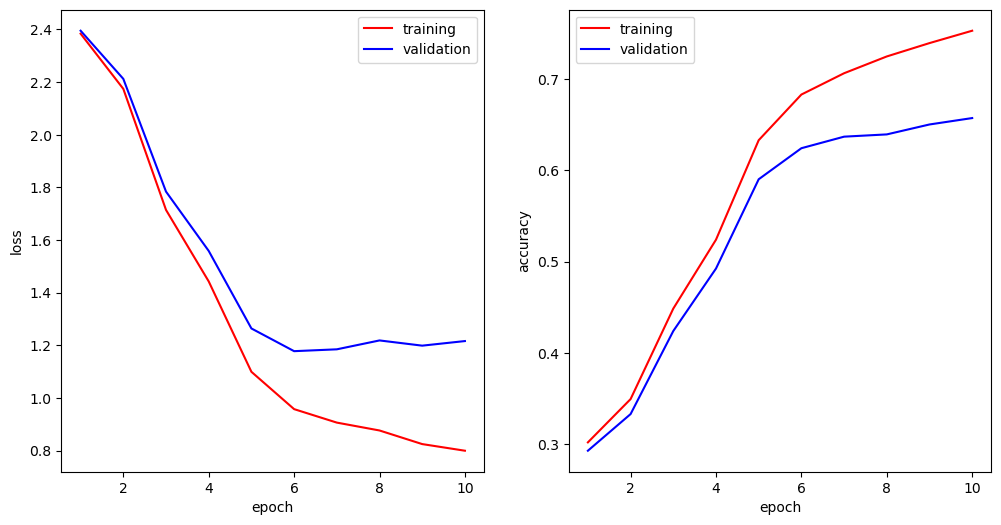

Fold #1
client 1 : 2584 samples
client 2 : 3808 samples
client 3 : 7217 samples
client 4 : 8740 samples
client 5 : 892 samples
client 6 : 2094 samples
client 7 : 3562 samples
client 8 : 11103 samples

>>> Round 1 ...
client 1 : Loss = 0.2098, Accuracy = 0.9196
client 2 : Loss = 0.1891, Accuracy = 0.9382
client 3 : Loss = 0.3181, Accuracy = 0.9000
client 4 : Loss = 0.3912, Accuracy = 0.8587
client 5 : Loss = 0.5866, Accuracy = 0.7635
client 6 : Loss = 0.3900, Accuracy = 0.8441
client 7 : Loss = 0.5530, Accuracy = 0.8146
client 8 : Loss = 0.6998, Accuracy = 0.7269

Server :
    - training loss = 2.4870
    - training accuracy = 0.3202
    - validation loss = 2.4931
    - validation accuracy = 0.3222
        
>>> Round 2 ...
client 1 : Loss = 0.1904, Accuracy = 0.9283
client 2 : Loss = 0.1585, Accuracy = 0.9420
client 3 : Loss = 0.2289, Accuracy = 0.9234
client 4 : Loss = 0.2676, Accuracy = 0.9049
client 5 : Loss = 0.3133, Accuracy = 0.8746
client 6 : Loss = 0.2734, Accuracy = 0.9038
clie

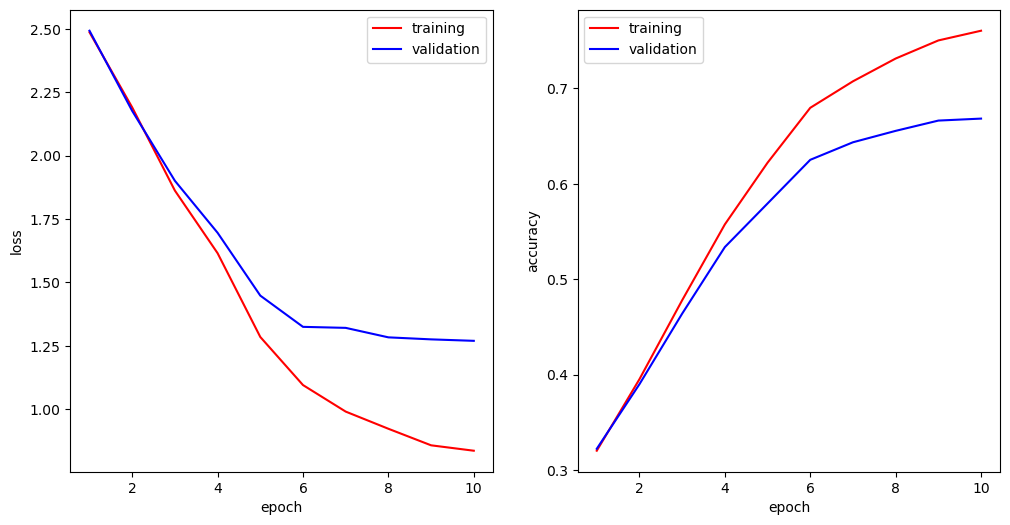

Fold #2
client 1 : 2585 samples
client 2 : 3791 samples
client 3 : 7182 samples
client 4 : 8745 samples
client 5 : 898 samples
client 6 : 2073 samples
client 7 : 3568 samples
client 8 : 11158 samples

>>> Round 1 ...
client 1 : Loss = 0.2110, Accuracy = 0.9214
client 2 : Loss = 0.1770, Accuracy = 0.9408
client 3 : Loss = 0.3037, Accuracy = 0.9053
client 4 : Loss = 0.4002, Accuracy = 0.8600
client 5 : Loss = 0.7702, Accuracy = 0.7129
client 6 : Loss = 0.4209, Accuracy = 0.8376
client 7 : Loss = 0.5662, Accuracy = 0.7968
client 8 : Loss = 0.7146, Accuracy = 0.7216

Server :
    - training loss = 2.5423
    - training accuracy = 0.2999
    - validation loss = 2.5542
    - validation accuracy = 0.3028
        
>>> Round 2 ...
client 1 : Loss = 0.1781, Accuracy = 0.9329
client 2 : Loss = 0.1309, Accuracy = 0.9578
client 3 : Loss = 0.2481, Accuracy = 0.9181
client 4 : Loss = 0.2490, Accuracy = 0.9147
client 5 : Loss = 0.7427, Accuracy = 0.6982
client 6 : Loss = 0.3700, Accuracy = 0.8585
clie

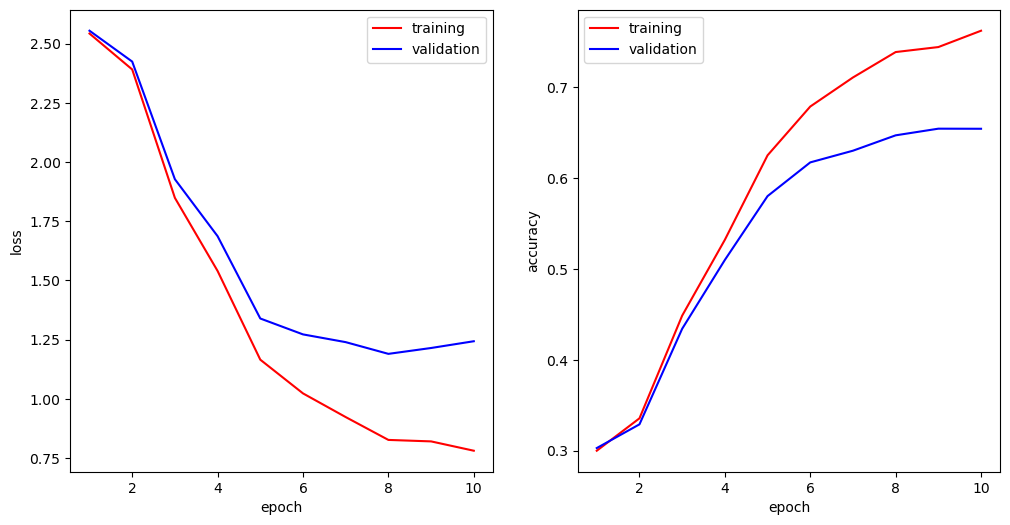

Fold #3
client 1 : 2576 samples
client 2 : 3802 samples
client 3 : 7197 samples
client 4 : 8701 samples
client 5 : 899 samples
client 6 : 2091 samples
client 7 : 3577 samples
client 8 : 11157 samples

>>> Round 1 ...
client 1 : Loss = 0.2303, Accuracy = 0.9118
client 2 : Loss = 0.1830, Accuracy = 0.9432
client 3 : Loss = 0.3289, Accuracy = 0.9028
client 4 : Loss = 0.4054, Accuracy = 0.8507
client 5 : Loss = 0.6331, Accuracy = 0.7627
client 6 : Loss = 0.3846, Accuracy = 0.8549
client 7 : Loss = 0.5439, Accuracy = 0.8041
client 8 : Loss = 0.7212, Accuracy = 0.7178

Server :
    - training loss = 2.6795
    - training accuracy = 0.3166
    - validation loss = 2.6966
    - validation accuracy = 0.3065
        
>>> Round 2 ...
client 1 : Loss = 0.2106, Accuracy = 0.9129
client 2 : Loss = 0.1569, Accuracy = 0.9461
client 3 : Loss = 0.2815, Accuracy = 0.9102
client 4 : Loss = 0.2688, Accuracy = 0.9032
client 5 : Loss = 0.5247, Accuracy = 0.7832
client 6 : Loss = 0.2703, Accuracy = 0.8985
clie

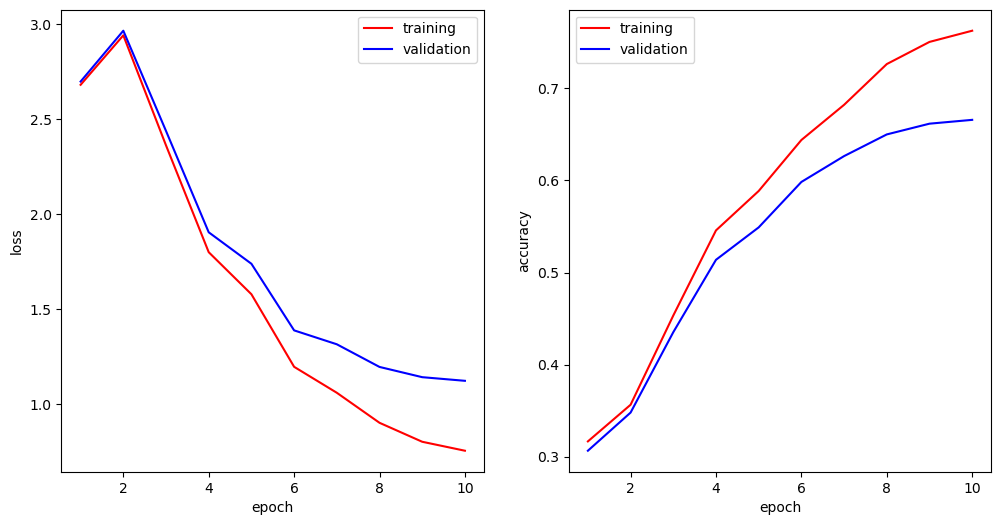

Fold #4
client 1 : 2619 samples
client 2 : 3799 samples
client 3 : 7152 samples
client 4 : 8739 samples
client 5 : 896 samples
client 6 : 2091 samples
client 7 : 3532 samples
client 8 : 11172 samples

>>> Round 1 ...
client 1 : Loss = 0.2226, Accuracy = 0.9093
client 2 : Loss = 0.1582, Accuracy = 0.9477
client 3 : Loss = 0.2724, Accuracy = 0.9137
client 4 : Loss = 0.3545, Accuracy = 0.8774
client 5 : Loss = 0.5724, Accuracy = 0.7723
client 6 : Loss = 0.4246, Accuracy = 0.8498
client 7 : Loss = 0.5597, Accuracy = 0.8051
client 8 : Loss = 0.7443, Accuracy = 0.7090

Server :
    - training loss = 2.5124
    - training accuracy = 0.3301
    - validation loss = 2.5445
    - validation accuracy = 0.3300
        
>>> Round 2 ...
client 1 : Loss = 0.1494, Accuracy = 0.9366
client 2 : Loss = 0.1296, Accuracy = 0.9534
client 3 : Loss = 0.2435, Accuracy = 0.9222
client 4 : Loss = 0.2379, Accuracy = 0.9140
client 5 : Loss = 0.3506, Accuracy = 0.8638
client 6 : Loss = 0.2913, Accuracy = 0.8980
clie

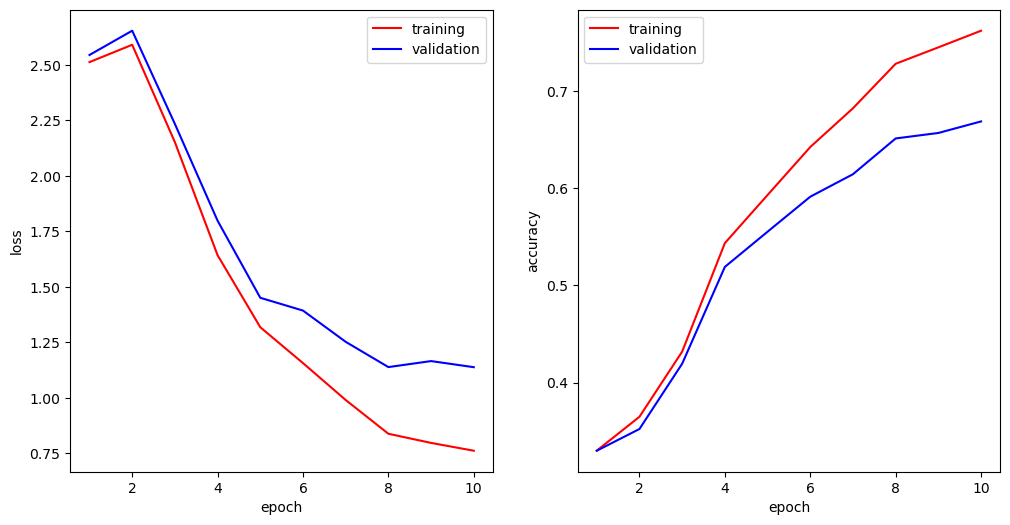

Fold #0
client 1 : 2564 samples
client 2 : 3766 samples
client 3 : 7174 samples
client 4 : 8820 samples
client 5 : 899 samples
client 6 : 2104 samples
client 7 : 3564 samples
client 8 : 11109 samples

>>> Round 1 ...
client 1 : Loss = 0.1672, Accuracy = 0.9315
client 2 : Loss = 0.0728, Accuracy = 0.9738
client 3 : Loss = 0.2098, Accuracy = 0.9280
client 4 : Loss = 0.2445, Accuracy = 0.9151
client 5 : Loss = 0.5183, Accuracy = 0.7757
client 6 : Loss = 0.1468, Accuracy = 0.9518
client 7 : Loss = 0.2824, Accuracy = 0.9027
client 8 : Loss = 0.5684, Accuracy = 0.7766

Server :
    - training loss = 1.9743
    - training accuracy = 0.3506
    - validation loss = 2.0408
    - validation accuracy = 0.3294
        
>>> Round 2 ...
client 1 : Loss = 0.1265, Accuracy = 0.9516
client 2 : Loss = 0.0310, Accuracy = 0.9909
client 3 : Loss = 0.1484, Accuracy = 0.9552
client 4 : Loss = 0.1272, Accuracy = 0.9564
client 5 : Loss = 0.1066, Accuracy = 0.9639
client 6 : Loss = 0.0682, Accuracy = 0.9823
clie

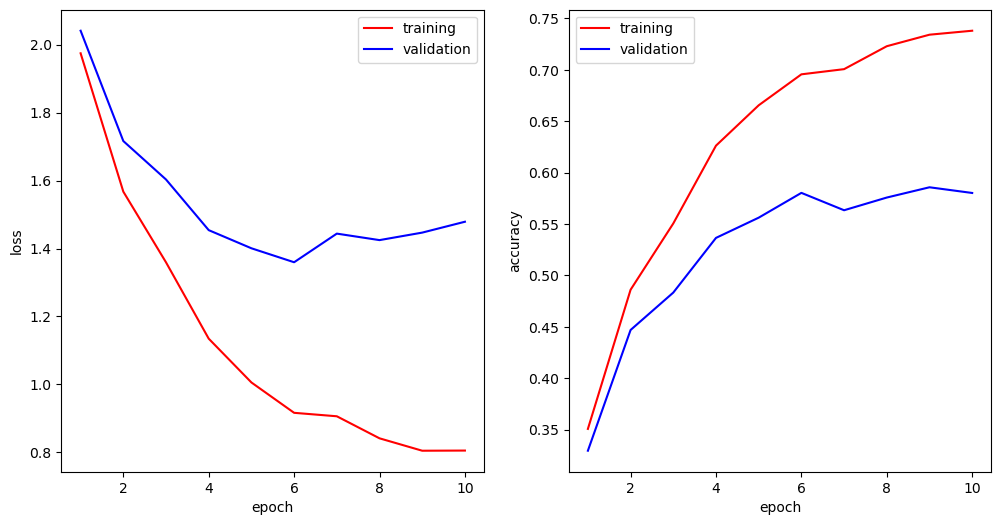

Fold #1
client 1 : 2584 samples
client 2 : 3808 samples
client 3 : 7217 samples
client 4 : 8740 samples
client 5 : 892 samples
client 6 : 2094 samples
client 7 : 3562 samples
client 8 : 11103 samples

>>> Round 1 ...
client 1 : Loss = 0.0652, Accuracy = 0.9781
client 2 : Loss = 0.0765, Accuracy = 0.9713
client 3 : Loss = 0.1793, Accuracy = 0.9429
client 4 : Loss = 0.2425, Accuracy = 0.9126
client 5 : Loss = 0.1248, Accuracy = 0.9675
client 6 : Loss = 0.1744, Accuracy = 0.9372
client 7 : Loss = 0.2879, Accuracy = 0.9066
client 8 : Loss = 0.5732, Accuracy = 0.7785

Server :
    - training loss = 1.8894
    - training accuracy = 0.3735
    - validation loss = 1.9429
    - validation accuracy = 0.3662
        
>>> Round 2 ...
client 1 : Loss = 0.0419, Accuracy = 0.9870
client 2 : Loss = 0.0292, Accuracy = 0.9911
client 3 : Loss = 0.1026, Accuracy = 0.9665
client 4 : Loss = 0.1294, Accuracy = 0.9565
client 5 : Loss = 0.0579, Accuracy = 0.9843
client 6 : Loss = 0.0594, Accuracy = 0.9803
clie

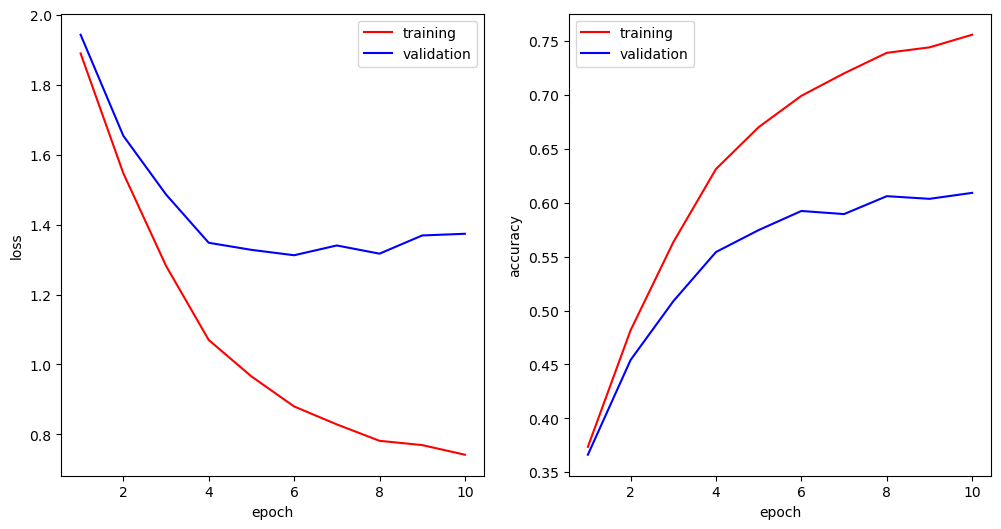

Fold #2
client 1 : 2585 samples
client 2 : 3791 samples
client 3 : 7182 samples
client 4 : 8745 samples
client 5 : 898 samples
client 6 : 2073 samples
client 7 : 3568 samples
client 8 : 11158 samples

>>> Round 1 ...
client 1 : Loss = 0.0810, Accuracy = 0.9699
client 2 : Loss = 0.0667, Accuracy = 0.9774
client 3 : Loss = 0.2013, Accuracy = 0.9326
client 4 : Loss = 0.2403, Accuracy = 0.9145
client 5 : Loss = 0.3645, Accuracy = 0.8564
client 6 : Loss = 0.2298, Accuracy = 0.9181
client 7 : Loss = 0.2979, Accuracy = 0.8973
client 8 : Loss = 0.5913, Accuracy = 0.7707

Server :
    - training loss = 1.9542
    - training accuracy = 0.3980
    - validation loss = 2.0391
    - validation accuracy = 0.3802
        
>>> Round 2 ...
client 1 : Loss = 0.0318, Accuracy = 0.9922
client 2 : Loss = 0.0314, Accuracy = 0.9911
client 3 : Loss = 0.1153, Accuracy = 0.9598
client 4 : Loss = 0.1398, Accuracy = 0.9515
client 5 : Loss = 0.1951, Accuracy = 0.9492
client 6 : Loss = 0.0537, Accuracy = 0.9858
clie

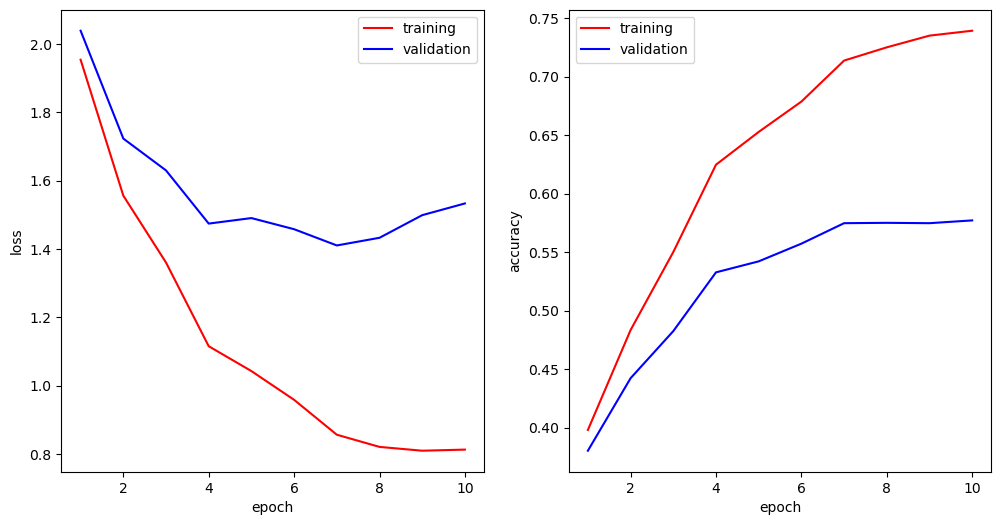

Fold #3
client 1 : 2576 samples
client 2 : 3802 samples
client 3 : 7197 samples
client 4 : 8701 samples
client 5 : 899 samples
client 6 : 2091 samples
client 7 : 3577 samples
client 8 : 11157 samples

>>> Round 1 ...
client 1 : Loss = 0.1173, Accuracy = 0.9602
client 2 : Loss = 0.0611, Accuracy = 0.9783
client 3 : Loss = 0.1744, Accuracy = 0.9408
client 4 : Loss = 0.2250, Accuracy = 0.9201
client 5 : Loss = 0.3967, Accuracy = 0.8525
client 6 : Loss = 0.1584, Accuracy = 0.9439
client 7 : Loss = 0.2748, Accuracy = 0.9060
client 8 : Loss = 0.5875, Accuracy = 0.7761

Server :
    - training loss = 1.8494
    - training accuracy = 0.3992
    - validation loss = 1.9206
    - validation accuracy = 0.3767
        
>>> Round 2 ...
client 1 : Loss = 0.0569, Accuracy = 0.9810
client 2 : Loss = 0.0355, Accuracy = 0.9887
client 3 : Loss = 0.0873, Accuracy = 0.9707
client 4 : Loss = 0.1170, Accuracy = 0.9594
client 5 : Loss = 0.4291, Accuracy = 0.8568
client 6 : Loss = 0.0647, Accuracy = 0.9830
clie

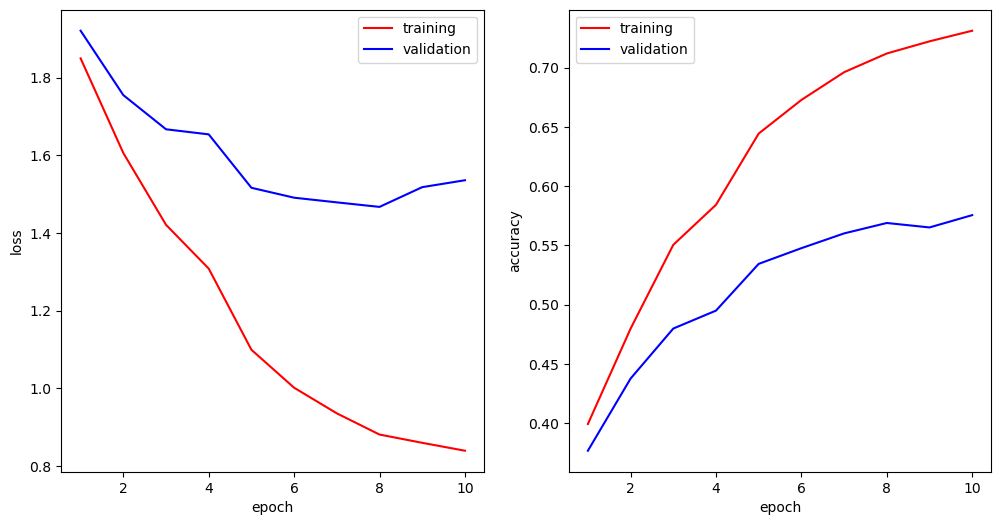

Fold #4
client 1 : 2619 samples
client 2 : 3799 samples
client 3 : 7152 samples
client 4 : 8739 samples
client 5 : 896 samples
client 6 : 2091 samples
client 7 : 3532 samples
client 8 : 11172 samples

>>> Round 1 ...
client 1 : Loss = 0.0947, Accuracy = 0.9635
client 2 : Loss = 0.0732, Accuracy = 0.9728
client 3 : Loss = 0.1756, Accuracy = 0.9407
client 4 : Loss = 0.2414, Accuracy = 0.9143
client 5 : Loss = 0.1336, Accuracy = 0.9587
client 6 : Loss = 0.1913, Accuracy = 0.9334
client 7 : Loss = 0.2876, Accuracy = 0.8995
client 8 : Loss = 0.5879, Accuracy = 0.7701

Server :
    - training loss = 2.0783
    - training accuracy = 0.3654
    - validation loss = 2.1517
    - validation accuracy = 0.3521
        
>>> Round 2 ...
client 1 : Loss = 0.0324, Accuracy = 0.9925
client 2 : Loss = 0.0403, Accuracy = 0.9862
client 3 : Loss = 0.1326, Accuracy = 0.9569
client 4 : Loss = 0.1291, Accuracy = 0.9560
client 5 : Loss = 0.0711, Accuracy = 0.9855
client 6 : Loss = 0.0879, Accuracy = 0.9729
clie

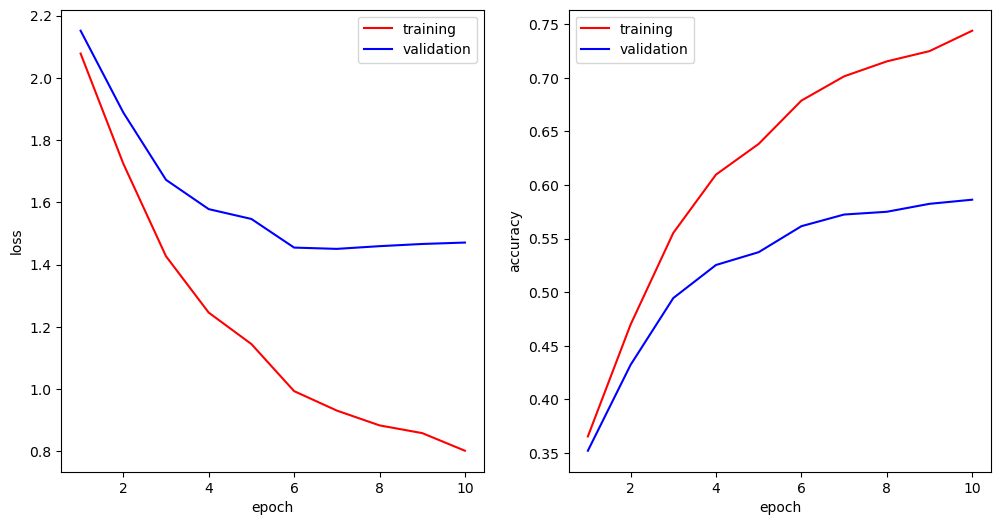

RESULTS
lr = 0.0100 : Accuracy = 0.6444026827812195
lr = 0.0050 : Accuracy = 0.662875771522522
lr = 0.0010 : Accuracy = 0.5856606364250183

CPU times: user 2h 29min 47s, sys: 18.2 s, total: 2h 30min 5s
Wall time: 2h 30min 39s


In [19]:
%%time
n_splits = 5
rounds = 10
batch_size = 128
epochs = 5
lrs = [1e-2,5e-3,1e-3]#[1e-1,1e-2,1e-3,1e-4]
optimizer = optim.Adam

results = []
for lr in lrs:
    res = run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr)
    results.append((lr,res))
    
print("="*25)
print(f"RESULTS")
print("="*25)
for lr,res in results:
    print(f"lr = {lr:.4f} : Accuracy = {res}")
print()


### Summary: Best result achieved with 0.005 learning rate

### 3.2 Selecting betas (few codes reruns due to code interruptions in kaggle)

Fold #0
client 1 : 7643 samples
client 2 : 6028 samples
client 3 : 6037 samples
client 4 : 3417 samples
client 5 : 10074 samples
client 6 : 881 samples
client 7 : 2053 samples
client 8 : 3867 samples

>>> Round 1 ...
client 1 : Loss = 0.5347, Accuracy = 0.8124
client 2 : Loss = 0.4166, Accuracy = 0.8747
client 3 : Loss = 0.3539, Accuracy = 0.8869
client 4 : Loss = 0.3172, Accuracy = 0.9061
client 5 : Loss = 0.5078, Accuracy = 0.8419
client 6 : Loss = 0.4560, Accuracy = 0.8426
client 7 : Loss = 0.5558, Accuracy = 0.8435
client 8 : Loss = 0.0419, Accuracy = 0.9990

Server :
    - training loss = 16.8094
    - training accuracy = 0.1012
    - validation loss = 16.5865
    - validation accuracy = 0.1033
        
>>> Round 2 ...
client 1 : Loss = 0.4658, Accuracy = 0.8380
client 2 : Loss = 0.3820, Accuracy = 0.8794
client 3 : Loss = 0.3085, Accuracy = 0.9025
client 4 : Loss = 0.2819, Accuracy = 0.9188
client 5 : Loss = 0.3469, Accuracy = 0.8866
client 6 : Loss = 0.4607, Accuracy = 0.8258
cl

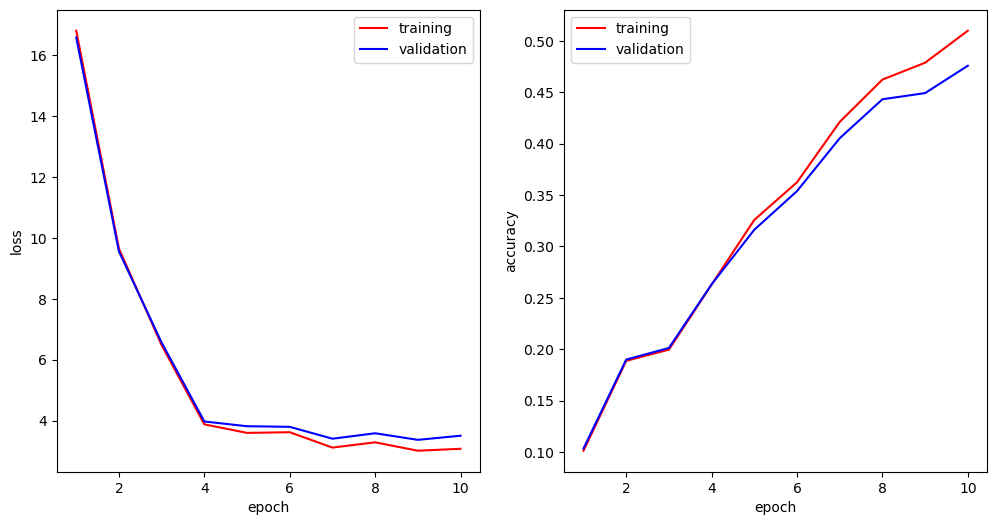

Fold #1
client 1 : 7727 samples
client 2 : 6023 samples
client 3 : 6024 samples
client 4 : 3417 samples
client 5 : 10051 samples
client 6 : 876 samples
client 7 : 2020 samples
client 8 : 3862 samples

>>> Round 1 ...
client 1 : Loss = 0.5526, Accuracy = 0.8071
client 2 : Loss = 0.5212, Accuracy = 0.8584
client 3 : Loss = 0.3440, Accuracy = 0.8892
client 4 : Loss = 0.3148, Accuracy = 0.9198
client 5 : Loss = 0.4443, Accuracy = 0.8540
client 6 : Loss = 0.4349, Accuracy = 0.8370
client 7 : Loss = 0.4786, Accuracy = 0.8482
client 8 : Loss = 0.0332, Accuracy = 0.9990

Server :
    - training loss = 12.6232
    - training accuracy = 0.1658
    - validation loss = 12.7233
    - validation accuracy = 0.1643
        
>>> Round 2 ...
client 1 : Loss = 0.4523, Accuracy = 0.8412
client 2 : Loss = 0.3593, Accuracy = 0.8826
client 3 : Loss = 0.3756, Accuracy = 0.9027
client 4 : Loss = 0.2790, Accuracy = 0.9305
client 5 : Loss = 0.3254, Accuracy = 0.8965
client 6 : Loss = 0.4010, Accuracy = 0.8578
cl

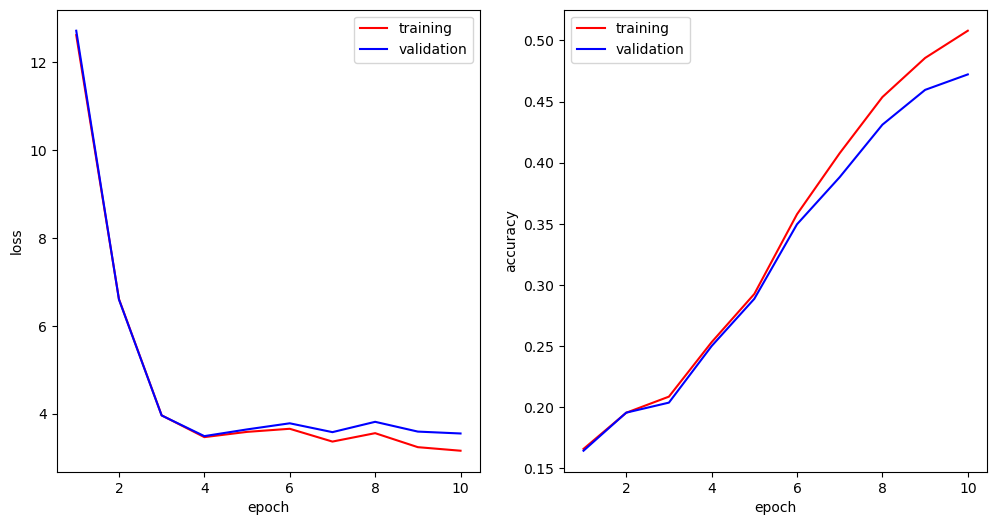

Fold #2
client 1 : 7646 samples
client 2 : 6034 samples
client 3 : 6092 samples
client 4 : 3403 samples
client 5 : 10044 samples
client 6 : 879 samples
client 7 : 2028 samples
client 8 : 3874 samples

>>> Round 1 ...
client 1 : Loss = 0.5418, Accuracy = 0.8115
client 2 : Loss = 0.4185, Accuracy = 0.8711
client 3 : Loss = 0.3658, Accuracy = 0.8844
client 4 : Loss = 0.3041, Accuracy = 0.9201
client 5 : Loss = 0.4475, Accuracy = 0.8599
client 6 : Loss = 0.4772, Accuracy = 0.8463
client 7 : Loss = 0.4631, Accuracy = 0.8414
client 8 : Loss = 0.0318, Accuracy = 0.9990

Server :
    - training loss = 17.6004
    - training accuracy = 0.1001
    - validation loss = 17.3316
    - validation accuracy = 0.0995
        
>>> Round 2 ...
client 1 : Loss = 0.4497, Accuracy = 0.8360
client 2 : Loss = 0.3813, Accuracy = 0.8808
client 3 : Loss = 0.2942, Accuracy = 0.9078
client 4 : Loss = 0.2563, Accuracy = 0.9249
client 5 : Loss = 0.3354, Accuracy = 0.8935
client 6 : Loss = 0.4552, Accuracy = 0.8607
cl

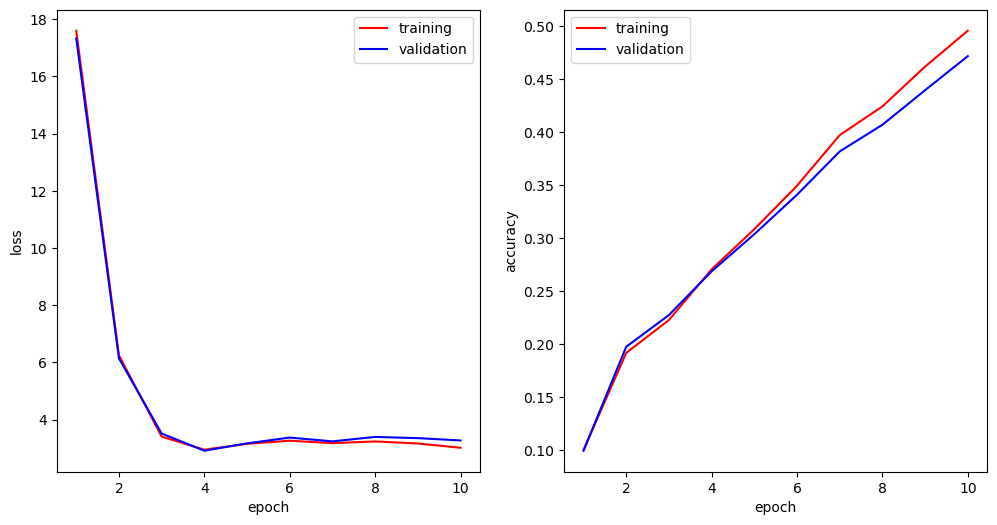

Fold #3
client 1 : 7684 samples
client 2 : 6053 samples
client 3 : 6080 samples
client 4 : 3381 samples
client 5 : 10040 samples
client 6 : 873 samples
client 7 : 2004 samples
client 8 : 3885 samples

>>> Round 1 ...
client 1 : Loss = 0.5835, Accuracy = 0.8038
client 2 : Loss = 0.4020, Accuracy = 0.8749
client 3 : Loss = 0.3477, Accuracy = 0.8914
client 4 : Loss = 0.3211, Accuracy = 0.9156
client 5 : Loss = 0.4454, Accuracy = 0.8558
client 6 : Loss = 0.4709, Accuracy = 0.8350
client 7 : Loss = 0.4880, Accuracy = 0.8575
client 8 : Loss = 0.0443, Accuracy = 0.9990

Server :
    - training loss = 12.6546
    - training accuracy = 0.1345
    - validation loss = 12.8130
    - validation accuracy = 0.1263
        
>>> Round 2 ...
client 1 : Loss = 0.4238, Accuracy = 0.8431
client 2 : Loss = 0.3445, Accuracy = 0.8888
client 3 : Loss = 0.2938, Accuracy = 0.9093
client 4 : Loss = 0.2685, Accuracy = 0.9268
client 5 : Loss = 0.3226, Accuracy = 0.8946
client 6 : Loss = 0.4114, Accuracy = 0.8660
cl

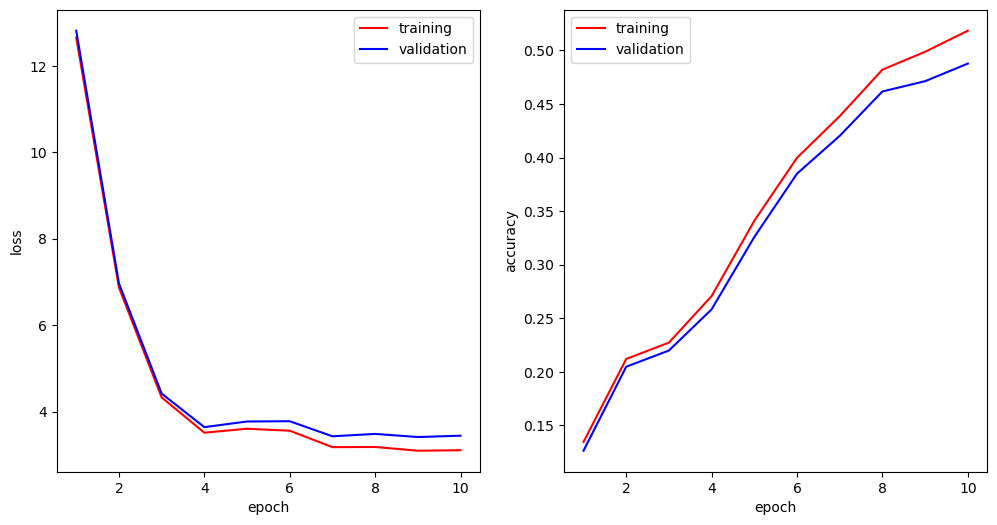

Fold #4
client 1 : 7653 samples
client 2 : 6080 samples
client 3 : 6048 samples
client 4 : 3389 samples
client 5 : 10122 samples
client 6 : 871 samples
client 7 : 2020 samples
client 8 : 3817 samples

>>> Round 1 ...
client 1 : Loss = 0.5081, Accuracy = 0.8141
client 2 : Loss = 0.3901, Accuracy = 0.8773
client 3 : Loss = 0.3644, Accuracy = 0.8800
client 4 : Loss = 0.3439, Accuracy = 0.9142
client 5 : Loss = 0.4879, Accuracy = 0.8457
client 6 : Loss = 0.4512, Accuracy = 0.8428
client 7 : Loss = 0.3977, Accuracy = 0.8616
client 8 : Loss = 0.0217, Accuracy = 0.9990

Server :
    - training loss = 14.4454
    - training accuracy = 0.1142
    - validation loss = 14.4553
    - validation accuracy = 0.1162
        
>>> Round 2 ...
client 1 : Loss = 0.4470, Accuracy = 0.8384
client 2 : Loss = 0.3290, Accuracy = 0.8952
client 3 : Loss = 0.2979, Accuracy = 0.9113
client 4 : Loss = 0.2632, Accuracy = 0.9254
client 5 : Loss = 0.3663, Accuracy = 0.8927
client 6 : Loss = 0.4801, Accuracy = 0.8366
cl

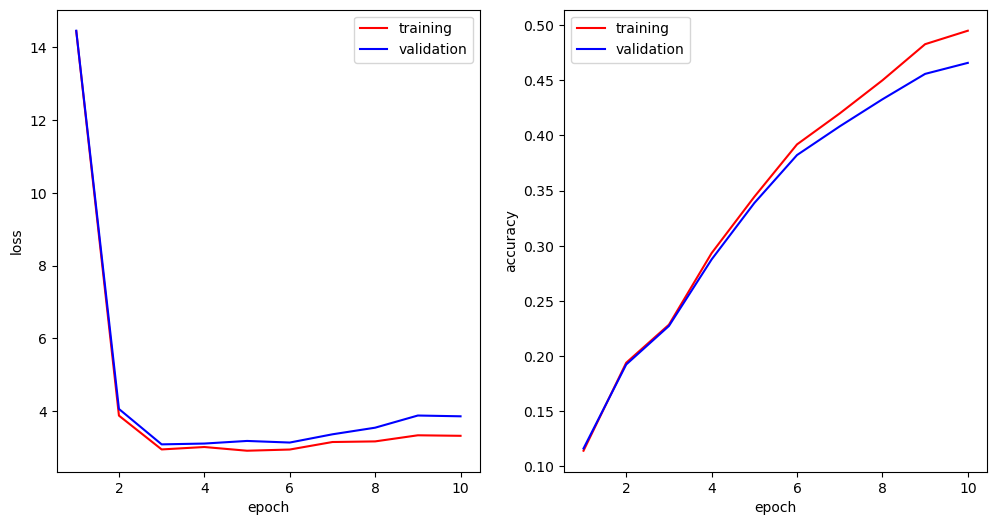

Fold #0
client 1 : 7643 samples
client 2 : 6028 samples
client 3 : 6037 samples
client 4 : 3417 samples
client 5 : 10074 samples
client 6 : 881 samples
client 7 : 2053 samples
client 8 : 3867 samples

>>> Round 1 ...
client 1 : Loss = 0.4725, Accuracy = 0.8249
client 2 : Loss = 0.4378, Accuracy = 0.8678
client 3 : Loss = 0.3444, Accuracy = 0.8825
client 4 : Loss = 0.3335, Accuracy = 0.9074
client 5 : Loss = 0.4204, Accuracy = 0.8530
client 6 : Loss = 0.2893, Accuracy = 0.8908
client 7 : Loss = 0.6129, Accuracy = 0.8133
client 8 : Loss = 0.0121, Accuracy = 0.9990

Server :
    - training loss = 5.1243
    - training accuracy = 0.1920
    - validation loss = 5.1229
    - validation accuracy = 0.1925
        
>>> Round 2 ...
client 1 : Loss = 0.3260, Accuracy = 0.8783
client 2 : Loss = 0.2831, Accuracy = 0.8993
client 3 : Loss = 0.2054, Accuracy = 0.9293
client 4 : Loss = 0.1958, Accuracy = 0.9370
client 5 : Loss = 0.2451, Accuracy = 0.9172
client 6 : Loss = 0.1844, Accuracy = 0.9401
clie

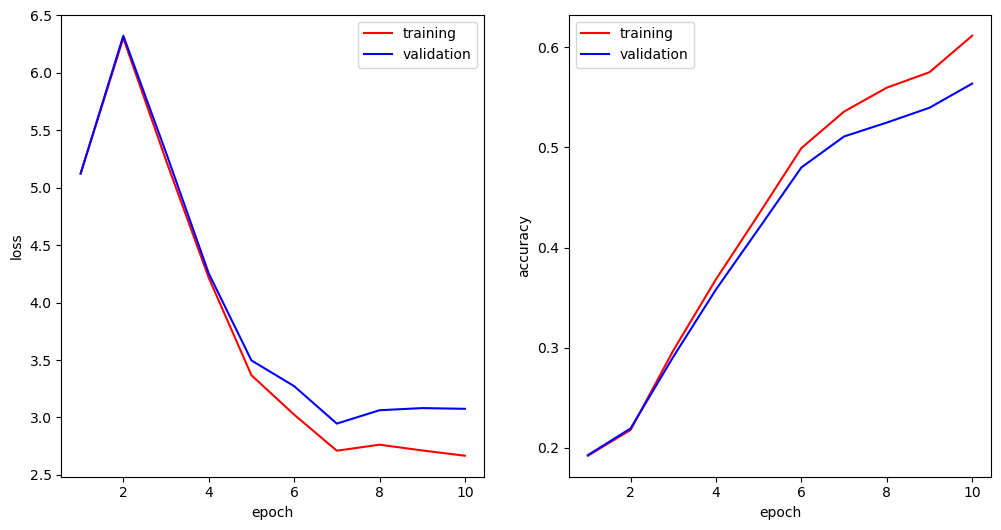

Fold #1
client 1 : 7727 samples
client 2 : 6023 samples
client 3 : 6024 samples
client 4 : 3417 samples
client 5 : 10051 samples
client 6 : 876 samples
client 7 : 2020 samples
client 8 : 3862 samples

>>> Round 1 ...
client 1 : Loss = 0.4794, Accuracy = 0.8170
client 2 : Loss = 0.4661, Accuracy = 0.8591
client 3 : Loss = 0.4089, Accuracy = 0.8722
client 4 : Loss = 0.2793, Accuracy = 0.9145
client 5 : Loss = 0.4084, Accuracy = 0.8594
client 6 : Loss = 0.2729, Accuracy = 0.9051
client 7 : Loss = 0.4428, Accuracy = 0.8497
client 8 : Loss = 0.0125, Accuracy = 0.9990

Server :
    - training loss = 5.9278
    - training accuracy = 0.1931
    - validation loss = 5.9596
    - validation accuracy = 0.1934
        
>>> Round 2 ...
client 1 : Loss = 0.3266, Accuracy = 0.8788
client 2 : Loss = 0.3554, Accuracy = 0.8839
client 3 : Loss = 0.2693, Accuracy = 0.9087
client 4 : Loss = 0.1810, Accuracy = 0.9427
client 5 : Loss = 0.2424, Accuracy = 0.9145
client 6 : Loss = 0.1510, Accuracy = 0.9536
clie

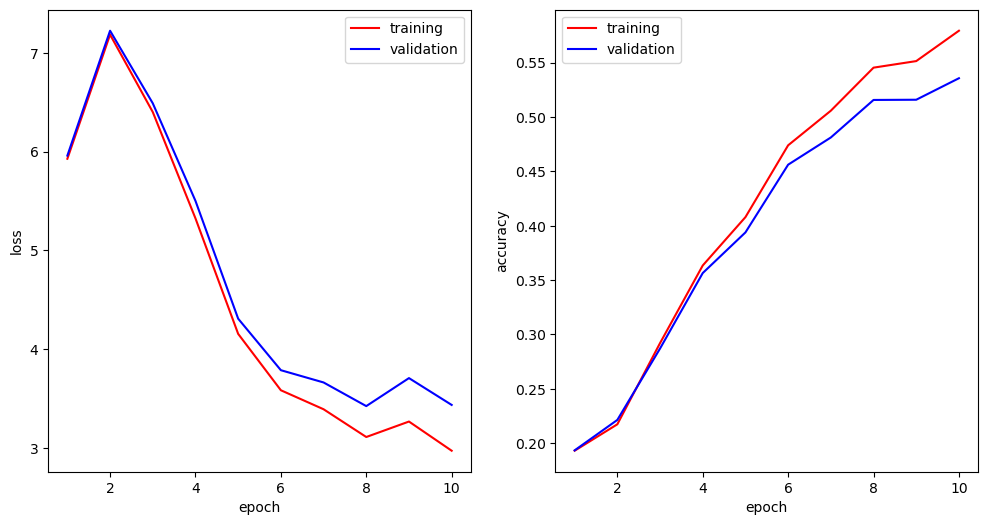

Fold #2
client 1 : 7646 samples
client 2 : 6034 samples
client 3 : 6092 samples
client 4 : 3403 samples
client 5 : 10044 samples
client 6 : 879 samples
client 7 : 2028 samples
client 8 : 3874 samples

>>> Round 1 ...
client 1 : Loss = 0.5145, Accuracy = 0.8108
client 2 : Loss = 0.3976, Accuracy = 0.8666
client 3 : Loss = 0.3386, Accuracy = 0.8856
client 4 : Loss = 0.2689, Accuracy = 0.9221
client 5 : Loss = 0.4123, Accuracy = 0.8582
client 6 : Loss = 0.3639, Accuracy = 0.8615
client 7 : Loss = 0.4708, Accuracy = 0.8541
client 8 : Loss = 0.0158, Accuracy = 0.9987

Server :
    - training loss = 6.0686
    - training accuracy = 0.2010
    - validation loss = 6.0480
    - validation accuracy = 0.2011
        
>>> Round 2 ...
client 1 : Loss = 0.3451, Accuracy = 0.8719
client 2 : Loss = 0.3068, Accuracy = 0.8974
client 3 : Loss = 0.2088, Accuracy = 0.9282
client 4 : Loss = 0.1750, Accuracy = 0.9450
client 5 : Loss = 0.2451, Accuracy = 0.9146
client 6 : Loss = 0.1478, Accuracy = 0.9452
clie

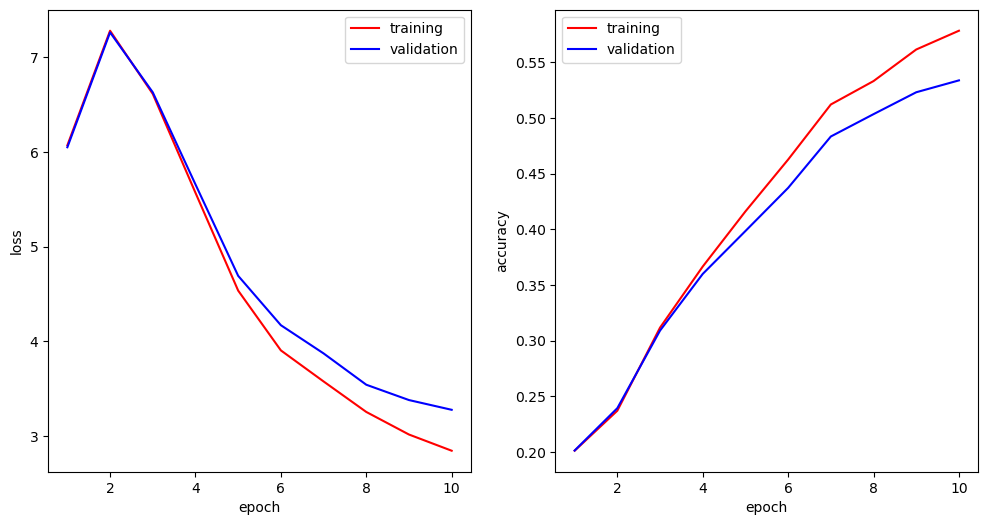

Fold #3
client 1 : 7684 samples
client 2 : 6053 samples
client 3 : 6080 samples
client 4 : 3381 samples
client 5 : 10040 samples
client 6 : 873 samples
client 7 : 2004 samples
client 8 : 3885 samples

>>> Round 1 ...
client 1 : Loss = 0.5872, Accuracy = 0.7846
client 2 : Loss = 0.3989, Accuracy = 0.8714
client 3 : Loss = 0.3146, Accuracy = 0.8926
client 4 : Loss = 0.2792, Accuracy = 0.9156
client 5 : Loss = 0.4174, Accuracy = 0.8569
client 6 : Loss = 0.2812, Accuracy = 0.9062
client 7 : Loss = 0.4295, Accuracy = 0.8541
client 8 : Loss = 0.0165, Accuracy = 0.9987

Server :
    - training loss = 5.7147
    - training accuracy = 0.2007
    - validation loss = 5.7024
    - validation accuracy = 0.1931
        
>>> Round 2 ...
client 1 : Loss = 0.3780, Accuracy = 0.8545
client 2 : Loss = 0.2888, Accuracy = 0.9000
client 3 : Loss = 0.2359, Accuracy = 0.9157
client 4 : Loss = 0.1965, Accuracy = 0.9345
client 5 : Loss = 0.2456, Accuracy = 0.9136
client 6 : Loss = 0.3050, Accuracy = 0.9053
clie

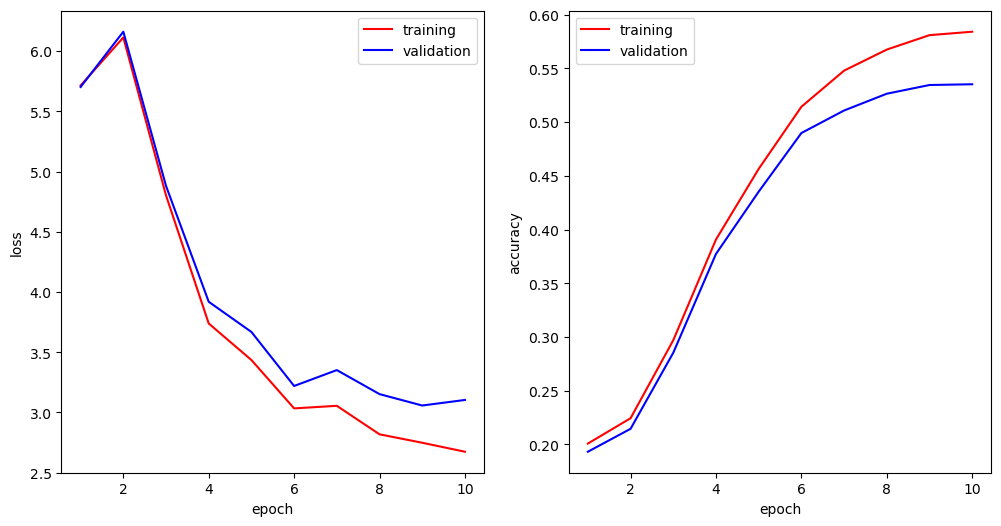

Fold #4
client 1 : 7653 samples
client 2 : 6080 samples
client 3 : 6048 samples
client 4 : 3389 samples
client 5 : 10122 samples
client 6 : 871 samples
client 7 : 2020 samples
client 8 : 3817 samples

>>> Round 1 ...
client 1 : Loss = 0.4767, Accuracy = 0.8196
client 2 : Loss = 0.4029, Accuracy = 0.8714
client 3 : Loss = 0.3284, Accuracy = 0.8908
client 4 : Loss = 0.2959, Accuracy = 0.9121
client 5 : Loss = 0.4034, Accuracy = 0.8629
client 6 : Loss = 0.3275, Accuracy = 0.8815
client 7 : Loss = 0.5307, Accuracy = 0.8406
client 8 : Loss = 0.0124, Accuracy = 0.9990

Server :
    - training loss = 5.8030
    - training accuracy = 0.1894
    - validation loss = 5.9136
    - validation accuracy = 0.1876
        
>>> Round 2 ...
client 1 : Loss = 0.3327, Accuracy = 0.8753
client 2 : Loss = 0.2788, Accuracy = 0.9077
client 3 : Loss = 0.2271, Accuracy = 0.9178
client 4 : Loss = 0.1703, Accuracy = 0.9407
client 5 : Loss = 0.2487, Accuracy = 0.9159
client 6 : Loss = 0.1469, Accuracy = 0.9493
clie

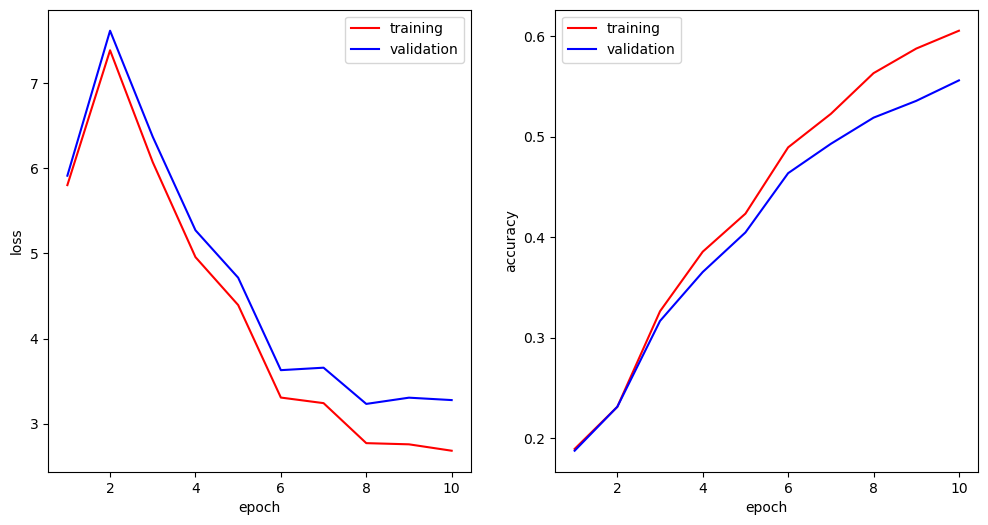

Fold #0
client 1 : 7643 samples
client 2 : 6028 samples
client 3 : 6037 samples
client 4 : 3417 samples
client 5 : 10074 samples
client 6 : 881 samples
client 7 : 2053 samples
client 8 : 3867 samples

>>> Round 1 ...
client 1 : Loss = 0.4511, Accuracy = 0.8286
client 2 : Loss = 0.4035, Accuracy = 0.8651
client 3 : Loss = 0.3057, Accuracy = 0.8952
client 4 : Loss = 0.2178, Accuracy = 0.9299
client 5 : Loss = 0.3690, Accuracy = 0.8732
client 6 : Loss = 0.2925, Accuracy = 0.8868
client 7 : Loss = 0.4945, Accuracy = 0.8476
client 8 : Loss = 0.0052, Accuracy = 0.9992

Server :
    - training loss = 3.1351
    - training accuracy = 0.2522
    - validation loss = 3.1630
    - validation accuracy = 0.2505
        
>>> Round 2 ...
client 1 : Loss = 0.3428, Accuracy = 0.8700
client 2 : Loss = 0.4522, Accuracy = 0.8609
client 3 : Loss = 0.2044, Accuracy = 0.9279
client 4 : Loss = 0.1337, Accuracy = 0.9533
client 5 : Loss = 0.2161, Accuracy = 0.9252
client 6 : Loss = 0.1095, Accuracy = 0.9662
clie

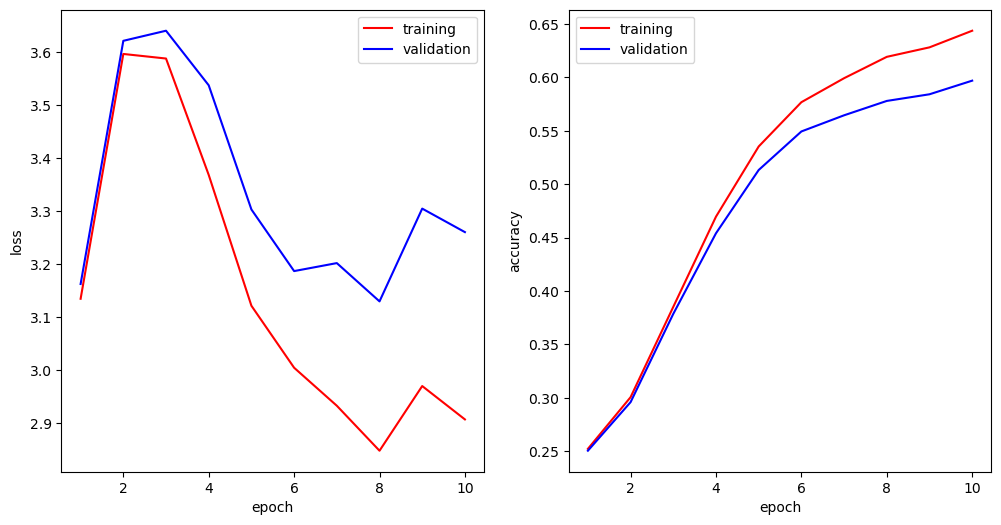

Fold #1
client 1 : 7727 samples
client 2 : 6023 samples
client 3 : 6024 samples
client 4 : 3417 samples
client 5 : 10051 samples
client 6 : 876 samples
client 7 : 2020 samples
client 8 : 3862 samples

>>> Round 1 ...
client 1 : Loss = 0.4237, Accuracy = 0.8423
client 2 : Loss = 0.3968, Accuracy = 0.8717
client 3 : Loss = 0.4548, Accuracy = 0.8514
client 4 : Loss = 0.2477, Accuracy = 0.9249
client 5 : Loss = 0.3737, Accuracy = 0.8698
client 6 : Loss = 0.3052, Accuracy = 0.8839
client 7 : Loss = 0.4364, Accuracy = 0.8626
client 8 : Loss = 0.0054, Accuracy = 0.9990

Server :
    - training loss = 2.8674
    - training accuracy = 0.2666
    - validation loss = 2.9086
    - validation accuracy = 0.2549
        
>>> Round 2 ...
client 1 : Loss = 0.3380, Accuracy = 0.8750
client 2 : Loss = 0.3453, Accuracy = 0.8860
client 3 : Loss = 0.3243, Accuracy = 0.8940
client 4 : Loss = 0.1386, Accuracy = 0.9546
client 5 : Loss = 0.2323, Accuracy = 0.9204
client 6 : Loss = 0.2093, Accuracy = 0.9199
clie

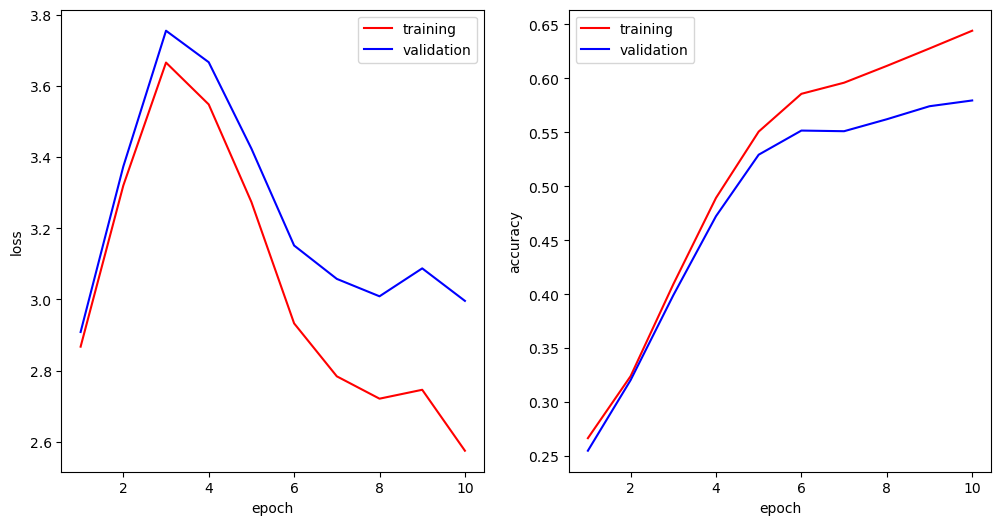

Fold #2
client 1 : 7646 samples
client 2 : 6034 samples
client 3 : 6092 samples
client 4 : 3403 samples
client 5 : 10044 samples
client 6 : 879 samples
client 7 : 2028 samples
client 8 : 3874 samples

>>> Round 1 ...
client 1 : Loss = 0.4659, Accuracy = 0.8257
client 2 : Loss = 0.3631, Accuracy = 0.8739
client 3 : Loss = 0.2797, Accuracy = 0.9061
client 4 : Loss = 0.2423, Accuracy = 0.9259
client 5 : Loss = 0.3619, Accuracy = 0.8727
client 6 : Loss = 0.3927, Accuracy = 0.8693
client 7 : Loss = 0.3969, Accuracy = 0.8663
client 8 : Loss = 0.0049, Accuracy = 0.9987

Server :
    - training loss = 3.2812
    - training accuracy = 0.2289
    - validation loss = 3.2595
    - validation accuracy = 0.2309
        
>>> Round 2 ...
client 1 : Loss = 0.3314, Accuracy = 0.8775
client 2 : Loss = 0.3030, Accuracy = 0.8930
client 3 : Loss = 0.2091, Accuracy = 0.9276
client 4 : Loss = 0.1494, Accuracy = 0.9514
client 5 : Loss = 0.2229, Accuracy = 0.9236
client 6 : Loss = 0.1431, Accuracy = 0.9539
clie

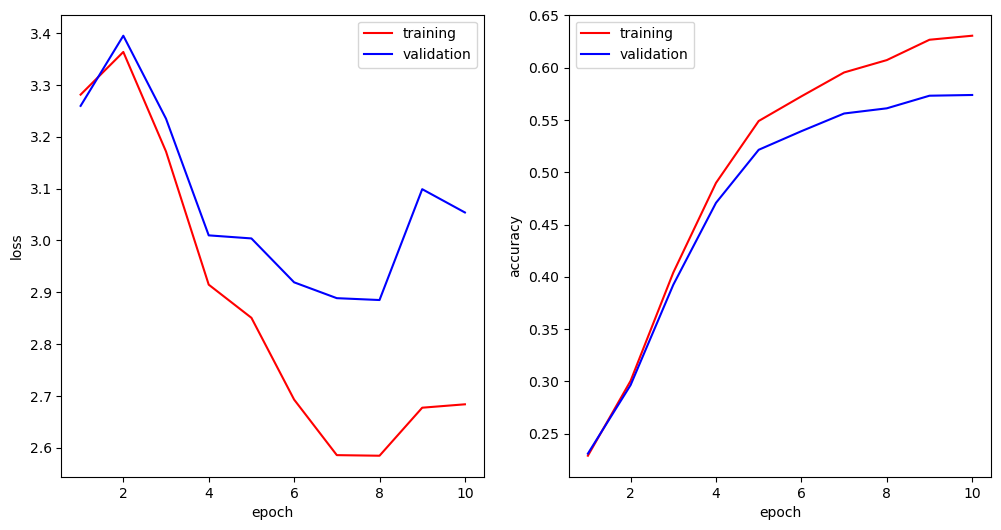

Fold #3
client 1 : 7684 samples
client 2 : 6053 samples
client 3 : 6080 samples
client 4 : 3381 samples
client 5 : 10040 samples
client 6 : 873 samples
client 7 : 2004 samples
client 8 : 3885 samples

>>> Round 1 ...
client 1 : Loss = 0.4992, Accuracy = 0.8143
client 2 : Loss = 0.3720, Accuracy = 0.8755
client 3 : Loss = 0.2722, Accuracy = 0.9053
client 4 : Loss = 0.2261, Accuracy = 0.9288
client 5 : Loss = 0.3922, Accuracy = 0.8643
client 6 : Loss = 0.2768, Accuracy = 0.8986
client 7 : Loss = 0.3618, Accuracy = 0.8715
client 8 : Loss = 0.0053, Accuracy = 0.9990

Server :
    - training loss = 3.1554
    - training accuracy = 0.2216
    - validation loss = 3.1490
    - validation accuracy = 0.2202
        
>>> Round 2 ...
client 1 : Loss = 0.4476, Accuracy = 0.8306
client 2 : Loss = 0.3038, Accuracy = 0.8938
client 3 : Loss = 0.2078, Accuracy = 0.9290
client 4 : Loss = 0.1675, Accuracy = 0.9440
client 5 : Loss = 0.2308, Accuracy = 0.9196
client 6 : Loss = 0.1618, Accuracy = 0.9477
clie

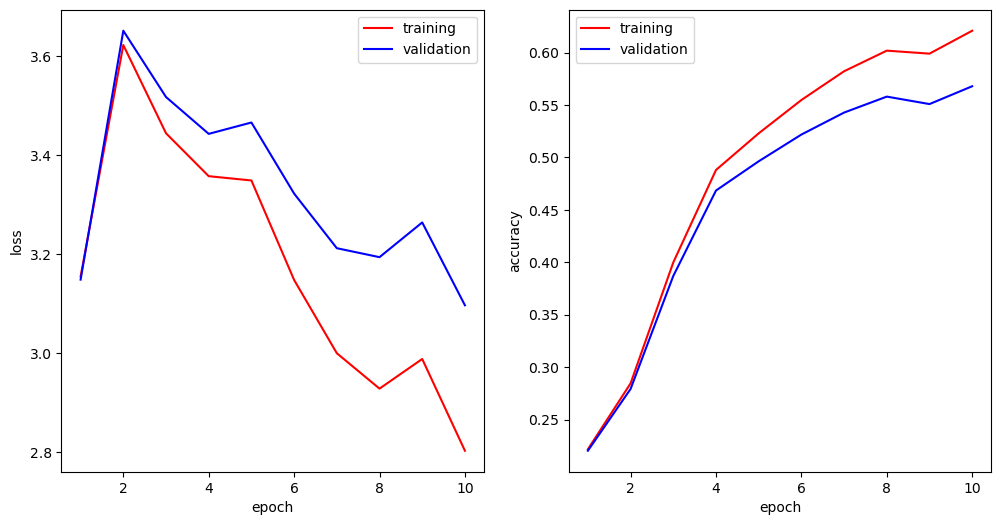

Fold #4
client 1 : 7653 samples
client 2 : 6080 samples
client 3 : 6048 samples
client 4 : 3389 samples
client 5 : 10122 samples
client 6 : 871 samples
client 7 : 2020 samples
client 8 : 3817 samples

>>> Round 1 ...
client 1 : Loss = 0.4401, Accuracy = 0.8284
client 2 : Loss = 0.3503, Accuracy = 0.8844
client 3 : Loss = 0.3041, Accuracy = 0.8926
client 4 : Loss = 0.2438, Accuracy = 0.9275
client 5 : Loss = 0.4237, Accuracy = 0.8515
client 6 : Loss = 0.2919, Accuracy = 0.8924
client 7 : Loss = 0.3727, Accuracy = 0.8832
client 8 : Loss = 0.0028, Accuracy = 0.9995

Server :
    - training loss = 2.8883
    - training accuracy = 0.2761
    - validation loss = 2.9300
    - validation accuracy = 0.2743
        
>>> Round 2 ...
client 1 : Loss = 0.3486, Accuracy = 0.8662
client 2 : Loss = 0.2704, Accuracy = 0.9066
client 3 : Loss = 0.2062, Accuracy = 0.9300
client 4 : Loss = 0.1591, Accuracy = 0.9429
client 5 : Loss = 0.3101, Accuracy = 0.8934
client 6 : Loss = 0.1998, Accuracy = 0.9359
clie

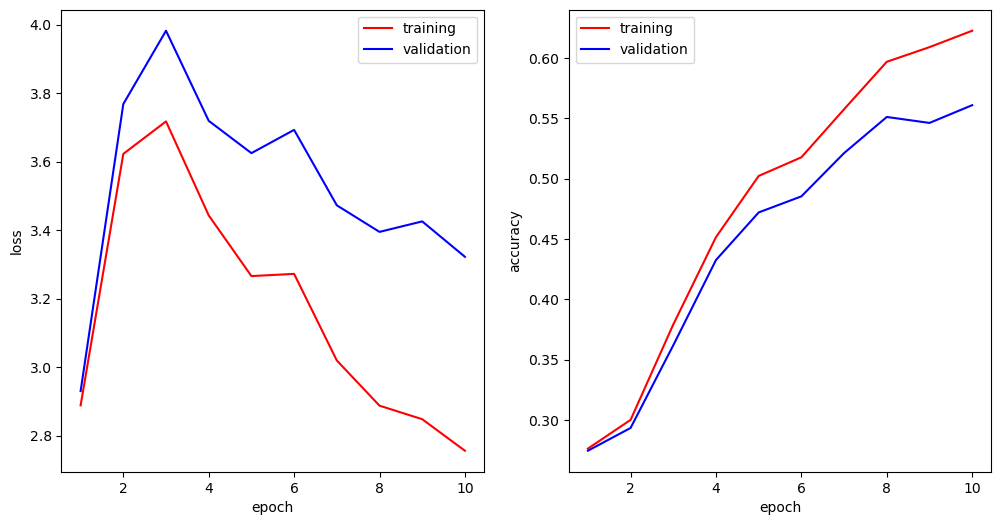

Fold #0
client 1 : 7643 samples
client 2 : 6028 samples
client 3 : 6037 samples
client 4 : 3417 samples
client 5 : 10074 samples
client 6 : 881 samples
client 7 : 2053 samples
client 8 : 3867 samples

>>> Round 1 ...
client 1 : Loss = 5805611008.0000, Accuracy = 0.3280
client 2 : Loss = 6937630208.0000, Accuracy = 0.6022
client 3 : Loss = 21781182464.0000, Accuracy = 0.5154
client 4 : Loss = 627.3596, Accuracy = 0.5846
client 5 : Loss = nan, Accuracy = 0.2571
client 6 : Loss = 0.9984, Accuracy = 0.7700
client 7 : Loss = 0.9194, Accuracy = 0.8069
client 8 : Loss = 2619668.7500, Accuracy = 0.9123

Server :
    - training loss = nan
    - training accuracy = 0.1006
    - validation loss = nan
    - validation accuracy = 0.0962
        
>>> Round 2 ...
client 1 : Loss = nan, Accuracy = 0.0217
client 2 : Loss = nan, Accuracy = 0.0000
client 3 : Loss = nan, Accuracy = 0.0954
client 4 : Loss = nan, Accuracy = 0.6556
client 5 : Loss = nan, Accuracy = 0.0001
client 6 : Loss = nan, Accuracy = 0.

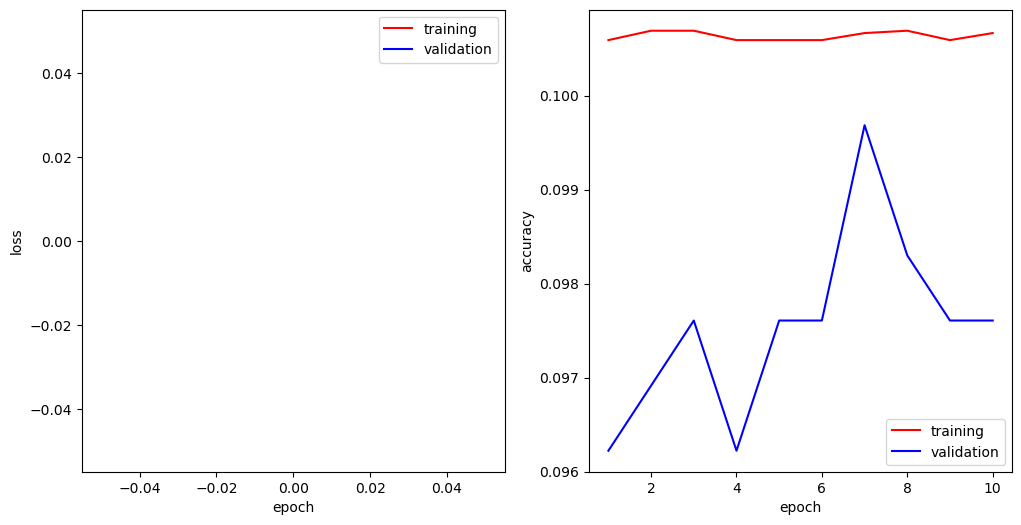

Fold #1
client 1 : 7727 samples
client 2 : 6023 samples
client 3 : 6024 samples
client 4 : 3417 samples
client 5 : 10051 samples
client 6 : 876 samples
client 7 : 2020 samples
client 8 : 3862 samples

>>> Round 1 ...
client 1 : Loss = 492373639168.0000, Accuracy = 0.2776
client 2 : Loss = 8176410624.0000, Accuracy = 0.5854
client 3 : Loss = 871872448.0000, Accuracy = 0.4414
client 4 : Loss = 2533630.5000, Accuracy = 0.6414
client 5 : Loss = 9793531019264.0000, Accuracy = 0.2988
client 6 : Loss = 2.2200, Accuracy = 0.8238
client 7 : Loss = 4.5286, Accuracy = 0.7740
client 8 : Loss = 646262208.0000, Accuracy = 0.9796

Server :
    - training loss = 1276726607872.0000
    - training accuracy = 0.1001
    - validation loss = 1198603501568.0000
    - validation accuracy = 0.1013
        
>>> Round 2 ...
client 1 : Loss = nan, Accuracy = 0.0209
client 2 : Loss = nan, Accuracy = 0.0000
client 3 : Loss = nan, Accuracy = 0.0941
client 4 : Loss = nan, Accuracy = 0.6524
client 5 : Loss = nan, Acc

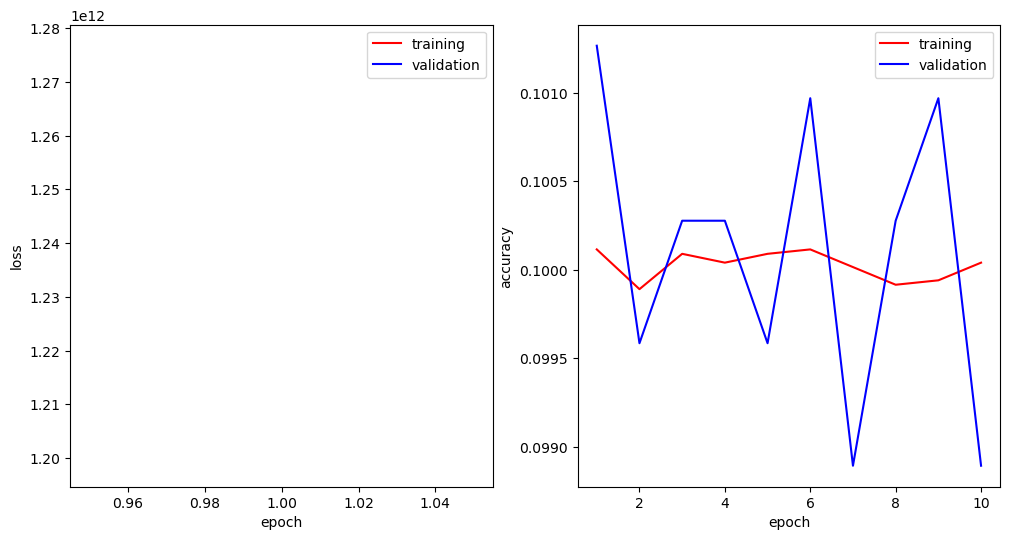

Fold #2
client 1 : 7646 samples
client 2 : 6034 samples
client 3 : 6092 samples
client 4 : 3403 samples
client 5 : 10044 samples
client 6 : 879 samples
client 7 : 2028 samples
client 8 : 3874 samples

>>> Round 1 ...
client 1 : Loss = 6708107776.0000, Accuracy = 0.3843
client 2 : Loss = 4320843264.0000, Accuracy = 0.3972
client 3 : Loss = 809334145024.0000, Accuracy = 0.5675
client 4 : Loss = 30897.0371, Accuracy = 0.4585
client 5 : Loss = 24652724305920.0000, Accuracy = 0.2657
client 6 : Loss = 2.2677, Accuracy = 0.7903
client 7 : Loss = 12.1186, Accuracy = 0.8031
client 8 : Loss = 269777952.0000, Accuracy = 0.9965

Server :
    - training loss = 1825870446592.0000
    - training accuracy = 0.0962
    - validation loss = 2150284001280.0000
    - validation accuracy = 0.1018
        
>>> Round 2 ...
client 1 : Loss = 3406476607488.0000, Accuracy = 0.3021
client 2 : Loss = 1614044463104.0000, Accuracy = 0.3021
client 3 : Loss = 13269568847872.0000, Accuracy = 0.1031
client 4 : Loss = 26

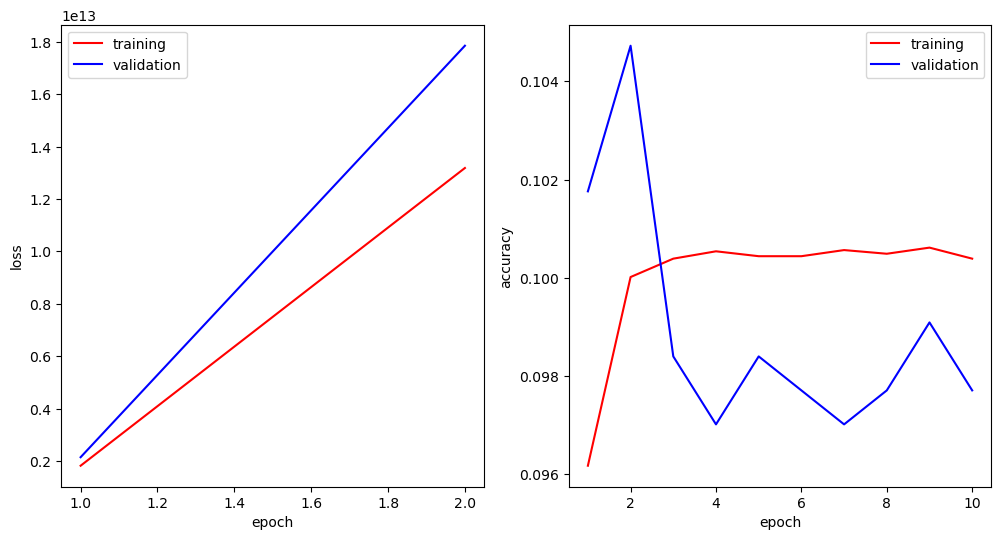

Fold #3
client 1 : 7684 samples
client 2 : 6053 samples
client 3 : 6080 samples
client 4 : 3381 samples
client 5 : 10040 samples
client 6 : 873 samples
client 7 : 2004 samples
client 8 : 3885 samples

>>> Round 1 ...
client 1 : Loss = 3122088448.0000, Accuracy = 0.3723
client 2 : Loss = 136834400.0000, Accuracy = 0.4963
client 3 : Loss = 10970982400.0000, Accuracy = 0.5070
client 4 : Loss = 179818.0781, Accuracy = 0.7296
client 5 : Loss = 128110796800.0000, Accuracy = 0.2419
client 6 : Loss = 4.4860, Accuracy = 0.7926
client 7 : Loss = 7.7976, Accuracy = 0.7781
client 8 : Loss = 170461568.0000, Accuracy = 0.7455

Server :
    - training loss = 447222644736.0000
    - training accuracy = 0.0991
    - validation loss = 338504450048.0000
    - validation accuracy = 0.1028
        
>>> Round 2 ...
client 1 : Loss = nan, Accuracy = 0.0207
client 2 : Loss = nan, Accuracy = 0.0000
client 3 : Loss = 7816452505600.0000, Accuracy = 0.0983
client 4 : Loss = 2114193063936.0000, Accuracy = 0.3527
c

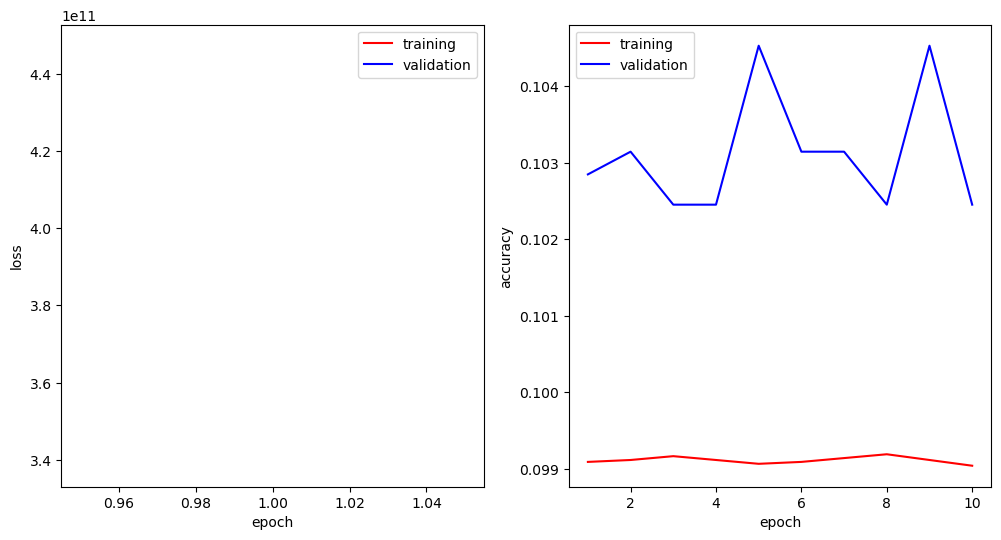

Fold #4
client 1 : 7653 samples
client 2 : 6080 samples
client 3 : 6048 samples
client 4 : 3389 samples
client 5 : 10122 samples
client 6 : 871 samples
client 7 : 2020 samples
client 8 : 3817 samples

>>> Round 1 ...
client 1 : Loss = 14699895717888.0000, Accuracy = 0.3902
client 2 : Loss = 45258268672.0000, Accuracy = 0.4635
client 3 : Loss = 884822656.0000, Accuracy = 0.4912
client 4 : Loss = 250995.3750, Accuracy = 0.5912
client 5 : Loss = nan, Accuracy = 0.2754
client 6 : Loss = 1.2503, Accuracy = 0.7812
client 7 : Loss = 4.6577, Accuracy = 0.7989
client 8 : Loss = 32183038.0000, Accuracy = 0.9542

Server :
    - training loss = nan
    - training accuracy = 0.0997
    - validation loss = nan
    - validation accuracy = 0.1013
        
>>> Round 2 ...
client 1 : Loss = nan, Accuracy = 0.0213
client 2 : Loss = nan, Accuracy = 0.0000
client 3 : Loss = nan, Accuracy = 0.0942
client 4 : Loss = nan, Accuracy = 0.6516
client 5 : Loss = nan, Accuracy = 0.0001
client 6 : Loss = nan, Accura

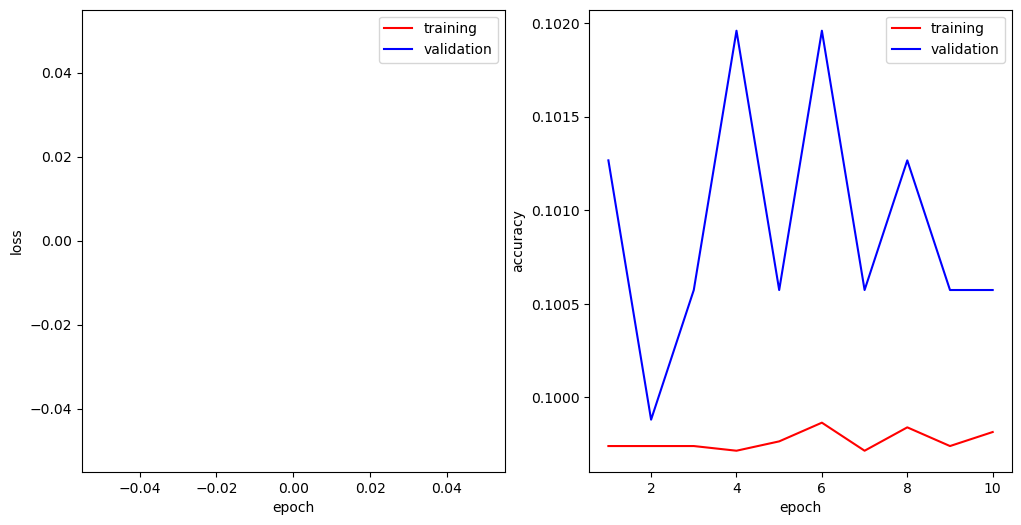

Fold #0
client 1 : 7643 samples
client 2 : 6028 samples
client 3 : 6037 samples
client 4 : 3417 samples
client 5 : 10074 samples
client 6 : 881 samples
client 7 : 2053 samples
client 8 : 3867 samples

>>> Round 1 ...
client 1 : Loss = 0.5474, Accuracy = 0.8028
client 2 : Loss = 0.4062, Accuracy = 0.8694
client 3 : Loss = 0.3458, Accuracy = 0.8831
client 4 : Loss = 0.3179, Accuracy = 0.9052
client 5 : Loss = 0.4388, Accuracy = 0.8505
client 6 : Loss = 0.4620, Accuracy = 0.8432
client 7 : Loss = 0.4867, Accuracy = 0.8467
client 8 : Loss = 0.0089, Accuracy = 0.9990

Server :
    - training loss = 6.9178
    - training accuracy = 0.1856
    - validation loss = 6.8857
    - validation accuracy = 0.1821
        
>>> Round 2 ...
client 1 : Loss = 0.4354, Accuracy = 0.8340
client 2 : Loss = 0.3719, Accuracy = 0.8749
client 3 : Loss = 0.2763, Accuracy = 0.9036
client 4 : Loss = 0.2548, Accuracy = 0.9274
client 5 : Loss = 0.3328, Accuracy = 0.8875
client 6 : Loss = 0.3860, Accuracy = 0.8664
clie

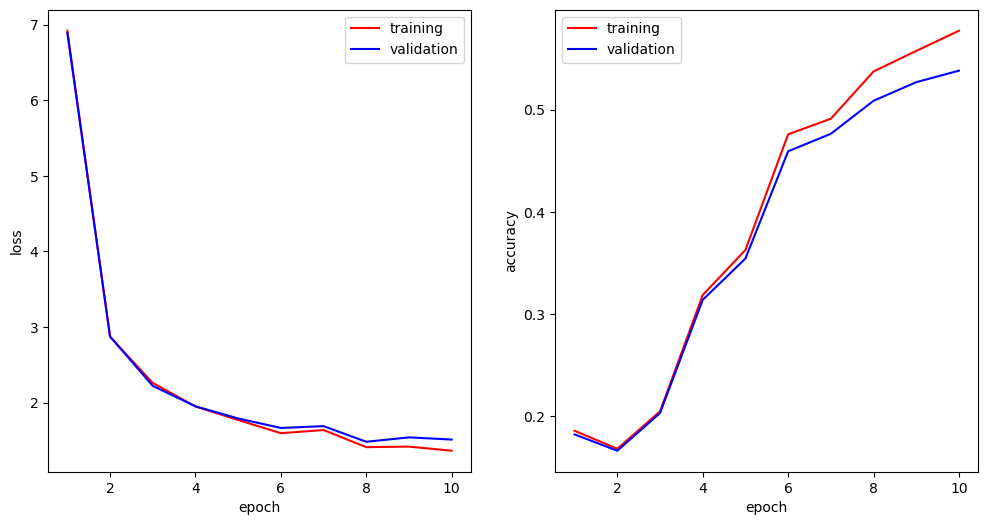

Fold #1
client 1 : 7727 samples
client 2 : 6023 samples
client 3 : 6024 samples
client 4 : 3417 samples
client 5 : 10051 samples
client 6 : 876 samples
client 7 : 2020 samples
client 8 : 3862 samples

>>> Round 1 ...
client 1 : Loss = 0.5457, Accuracy = 0.7998
client 2 : Loss = 0.4150, Accuracy = 0.8647
client 3 : Loss = 0.3286, Accuracy = 0.8861
client 4 : Loss = 0.3129, Accuracy = 0.9109
client 5 : Loss = 0.4434, Accuracy = 0.8493
client 6 : Loss = 0.4410, Accuracy = 0.8365
client 7 : Loss = 0.4340, Accuracy = 0.8547
client 8 : Loss = 0.0088, Accuracy = 0.9990

Server :
    - training loss = 7.6244
    - training accuracy = 0.1862
    - validation loss = 7.6948
    - validation accuracy = 0.1834
        
>>> Round 2 ...
client 1 : Loss = 0.4749, Accuracy = 0.8242
client 2 : Loss = 0.3755, Accuracy = 0.8756
client 3 : Loss = 0.3450, Accuracy = 0.8882
client 4 : Loss = 0.2935, Accuracy = 0.9167
client 5 : Loss = 0.3446, Accuracy = 0.8819
client 6 : Loss = 0.4609, Accuracy = 0.8500
clie

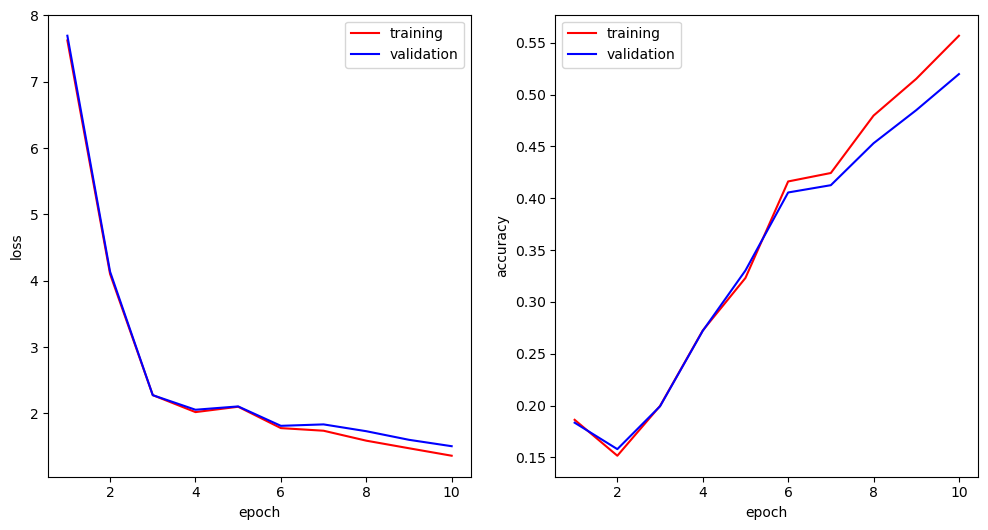

Fold #2
client 1 : 7646 samples
client 2 : 6034 samples
client 3 : 6092 samples
client 4 : 3403 samples
client 5 : 10044 samples
client 6 : 879 samples
client 7 : 2028 samples
client 8 : 3874 samples

>>> Round 1 ...
client 1 : Loss = 0.5345, Accuracy = 0.8006
client 2 : Loss = 0.4166, Accuracy = 0.8613
client 3 : Loss = 0.3500, Accuracy = 0.8804
client 4 : Loss = 0.3015, Accuracy = 0.9099
client 5 : Loss = 0.4665, Accuracy = 0.8442
client 6 : Loss = 0.4170, Accuracy = 0.8524
client 7 : Loss = 0.4964, Accuracy = 0.8404
client 8 : Loss = 0.0096, Accuracy = 0.9990

Server :
    - training loss = 6.1718
    - training accuracy = 0.1764
    - validation loss = 5.9979
    - validation accuracy = 0.1798
        
>>> Round 2 ...
client 1 : Loss = 0.4671, Accuracy = 0.8294
client 2 : Loss = 0.3650, Accuracy = 0.8766
client 3 : Loss = 0.2827, Accuracy = 0.9022
client 4 : Loss = 0.3040, Accuracy = 0.9168
client 5 : Loss = 0.3206, Accuracy = 0.8868
client 6 : Loss = 0.5423, Accuracy = 0.8382
clie

In [ ]:
%%time
n_splits = 5
rounds = 10
batch_size = 128
epochs = 5
lr = 5e-3
optimizer = optim.Adam
#In the original setting, it was already B1=0.9, B2=0.999
betas_1 = [0.5, 0.95, 0.999]
betas_2 = [0.5, 0.95, 0.999]

results = []
for beta_1 in betas_1:
    for beta_2 in betas_2:
        res = run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr, betas=(beta_1, beta_2))
        results.append((beta_1, beta_2 ,res))
    
print("="*25)
print(f"RESULTS")
print("="*25)
for lr,res in results:
    print(f"beta 1 = {beta_1:.3f}, beta 2 = {beta_2:.3f} : Accuracy = {res}")
print()


### Comment: It can be seen, that none of the tried combinations in interrupted CV outperform default values of (0.9, 0.999). Continue the process...

Fold #0
client 1 : 3410 samples
client 2 : 8248 samples
client 3 : 1181 samples
client 4 : 3201 samples
client 5 : 8605 samples
client 6 : 9096 samples
client 7 : 816 samples
client 8 : 5443 samples

>>> Round 1 ...
client 1 : Loss = 0.1941, Accuracy = 0.9324
client 2 : Loss = 0.6059, Accuracy = 0.7893
client 3 : Loss = 0.5414, Accuracy = 0.8106
client 4 : Loss = 1.1254, Accuracy = 0.5925
client 5 : Loss = 0.3999, Accuracy = 0.8501
client 6 : Loss = 0.5107, Accuracy = 0.8318
client 7 : Loss = 0.2195, Accuracy = 0.9156
client 8 : Loss = 0.3945, Accuracy = 0.8758

Server :
    - training loss = 3.2210
    - training accuracy = 0.2556
    - validation loss = 3.2547
    - validation accuracy = 0.2501
        
>>> Round 2 ...
client 1 : Loss = 0.2237, Accuracy = 0.9280
client 2 : Loss = 0.4074, Accuracy = 0.8558
client 3 : Loss = 0.3965, Accuracy = 0.8687
client 4 : Loss = 0.8067, Accuracy = 0.7148
client 5 : Loss = 0.2863, Accuracy = 0.8975
client 6 : Loss = 0.4376, Accuracy = 0.8553
clien

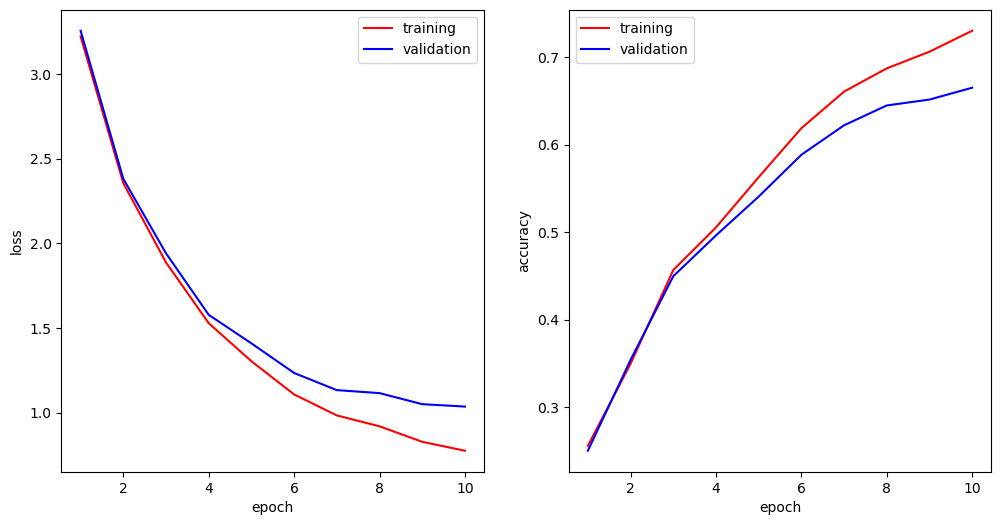

Fold #1
client 1 : 3414 samples
client 2 : 8246 samples
client 3 : 1196 samples
client 4 : 3199 samples
client 5 : 8548 samples
client 6 : 9153 samples
client 7 : 812 samples
client 8 : 5432 samples

>>> Round 1 ...
client 1 : Loss = 0.2000, Accuracy = 0.9267
client 2 : Loss = 0.5858, Accuracy = 0.7933
client 3 : Loss = 0.5383, Accuracy = 0.8188
client 4 : Loss = 0.6922, Accuracy = 0.7587
client 5 : Loss = 0.4048, Accuracy = 0.8543
client 6 : Loss = 0.4770, Accuracy = 0.8359
client 7 : Loss = 0.1764, Accuracy = 0.9366
client 8 : Loss = 0.4226, Accuracy = 0.8676

Server :
    - training loss = 3.0835
    - training accuracy = 0.2316
    - validation loss = 3.1053
    - validation accuracy = 0.2278
        
>>> Round 2 ...
client 1 : Loss = 0.1743, Accuracy = 0.9372
client 2 : Loss = 0.4087, Accuracy = 0.8568
client 3 : Loss = 0.4116, Accuracy = 0.8631
client 4 : Loss = 0.4989, Accuracy = 0.8243
client 5 : Loss = 0.3052, Accuracy = 0.8869
client 6 : Loss = 0.3834, Accuracy = 0.8663
clien

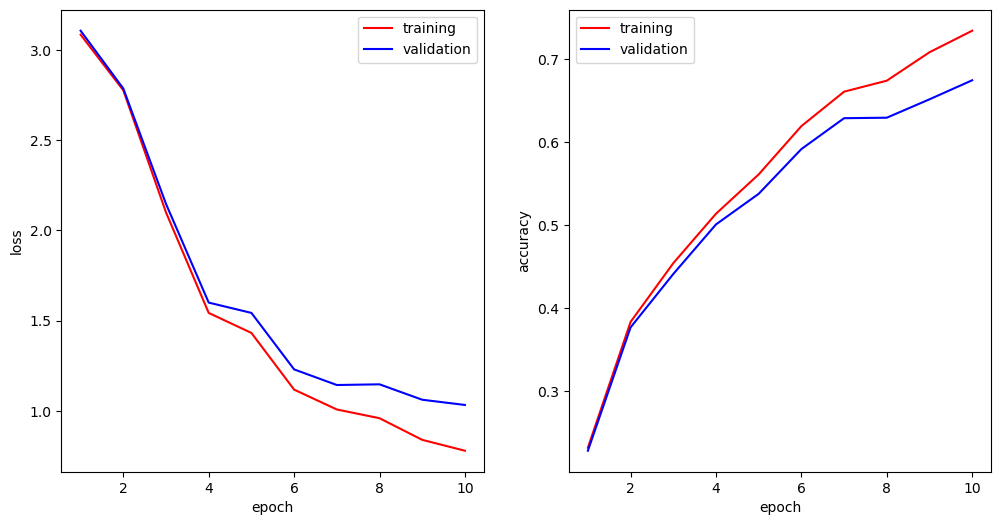

Fold #2
client 1 : 3419 samples
client 2 : 8222 samples
client 3 : 1193 samples
client 4 : 3194 samples
client 5 : 8546 samples
client 6 : 9157 samples
client 7 : 803 samples
client 8 : 5466 samples

>>> Round 1 ...
client 1 : Loss = 0.1971, Accuracy = 0.9316
client 2 : Loss = 0.6158, Accuracy = 0.7812
client 3 : Loss = 0.5816, Accuracy = 0.8023
client 4 : Loss = 0.6325, Accuracy = 0.7602
client 5 : Loss = 0.3898, Accuracy = 0.8538
client 6 : Loss = 0.4927, Accuracy = 0.8334
client 7 : Loss = 0.2339, Accuracy = 0.9171
client 8 : Loss = 0.3881, Accuracy = 0.8783

Server :
    - training loss = 3.2359
    - training accuracy = 0.2334
    - validation loss = 3.2448
    - validation accuracy = 0.2298
        
>>> Round 2 ...
client 1 : Loss = 0.1818, Accuracy = 0.9358
client 2 : Loss = 0.4497, Accuracy = 0.8431
client 3 : Loss = 0.3644, Accuracy = 0.8793
client 4 : Loss = 0.5227, Accuracy = 0.8043
client 5 : Loss = 0.3166, Accuracy = 0.8846
client 6 : Loss = 0.3968, Accuracy = 0.8671
clien

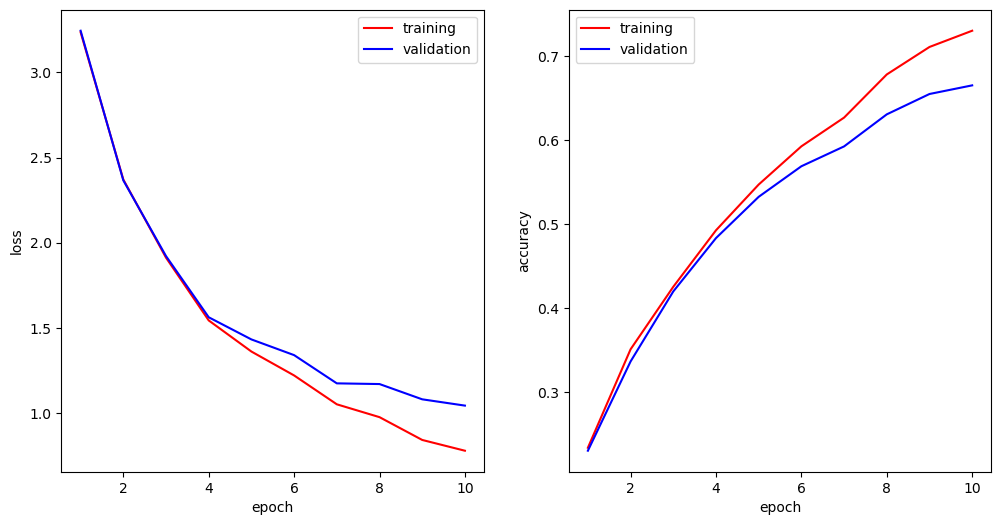

Fold #3
client 1 : 3446 samples
client 2 : 8197 samples
client 3 : 1190 samples
client 4 : 3197 samples
client 5 : 8565 samples
client 6 : 9160 samples
client 7 : 815 samples
client 8 : 5430 samples

>>> Round 1 ...
client 1 : Loss = 0.2362, Accuracy = 0.9177
client 2 : Loss = 0.7500, Accuracy = 0.7396
client 3 : Loss = 0.5653, Accuracy = 0.8282
client 4 : Loss = 0.6727, Accuracy = 0.7404
client 5 : Loss = 0.3767, Accuracy = 0.8586
client 6 : Loss = 0.4724, Accuracy = 0.8335
client 7 : Loss = 0.2263, Accuracy = 0.9190
client 8 : Loss = 0.3723, Accuracy = 0.8773

Server :
    - training loss = 3.2894
    - training accuracy = 0.2303
    - validation loss = 3.2747
    - validation accuracy = 0.2375
        
>>> Round 2 ...
client 1 : Loss = 0.1775, Accuracy = 0.9416
client 2 : Loss = 0.5557, Accuracy = 0.8101
client 3 : Loss = 0.3837, Accuracy = 0.8782
client 4 : Loss = 0.4986, Accuracy = 0.8248
client 5 : Loss = 0.2973, Accuracy = 0.8896
client 6 : Loss = 0.3829, Accuracy = 0.8705
clien

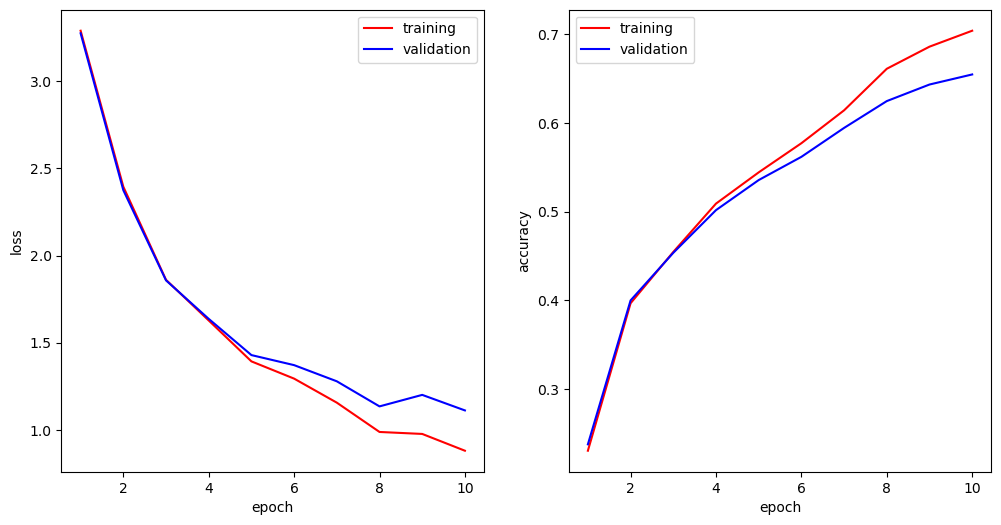

Fold #4
client 1 : 3414 samples
client 2 : 8227 samples
client 3 : 1200 samples
client 4 : 3223 samples
client 5 : 8508 samples
client 6 : 9145 samples
client 7 : 814 samples
client 8 : 5469 samples

>>> Round 1 ...
client 1 : Loss = 0.2030, Accuracy = 0.9254
client 2 : Loss = 0.5959, Accuracy = 0.7908
client 3 : Loss = 0.5744, Accuracy = 0.8169
client 4 : Loss = 0.6645, Accuracy = 0.7463
client 5 : Loss = 0.3756, Accuracy = 0.8568
client 6 : Loss = 0.4818, Accuracy = 0.8348
client 7 : Loss = 0.2473, Accuracy = 0.9144
client 8 : Loss = 0.3928, Accuracy = 0.8749

Server :
    - training loss = 3.0240
    - training accuracy = 0.2448
    - validation loss = 3.0567
    - validation accuracy = 0.2427
        
>>> Round 2 ...
client 1 : Loss = 0.1844, Accuracy = 0.9280
client 2 : Loss = 0.4337, Accuracy = 0.8499
client 3 : Loss = 0.3429, Accuracy = 0.8911
client 4 : Loss = 0.4610, Accuracy = 0.8377
client 5 : Loss = 0.3125, Accuracy = 0.8792
client 6 : Loss = 0.4195, Accuracy = 0.8567
clien

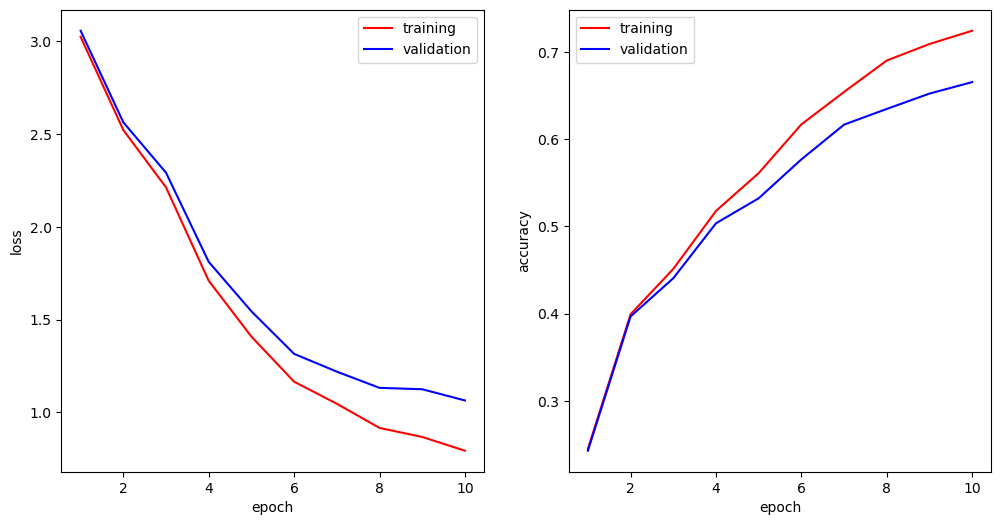

NameError: name 'beta_2' is not defined

In [ ]:
%%time
#Continue interrupted process
n_splits = 5
rounds = 10
batch_size = 128
epochs = 5
lr = 5e-3
optimizer = optim.Adam
#In the original setting, it was already B1=0.9, B2=0.999
betas_1 = [0.95, 0.999]
betas_2 = [0.5, 0.95, 0.999]

results = []
for beta_1 in betas_1:
    if beta_1 == 0.95:
        res = run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr, betas=(beta_1, 0.999))
        results.append((beta_1, beta_2 ,res))
    else:
        for beta_2 in betas_2:
            res = run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr, betas=(beta_1, beta_2))
            results.append((beta_1, beta_2 ,res))
    
print("="*25)
print(f"RESULTS")
print("="*25)
for beta_1, beta_2 ,res in results:
    print(f"beta 1 = {beta_1:.3f}, beta 2 = {beta_2:.3f} : Accuracy = {res}")
print()


### Comment: Values of (0.95, 0.999) are close, but doesn't outperform the default ones. Continue the interrupted process ...

Fold #0
client 1 : 8643 samples
client 2 : 4261 samples
client 3 : 290 samples
client 4 : 1696 samples
client 5 : 5220 samples
client 6 : 8142 samples
client 7 : 11467 samples
client 8 : 281 samples

>>> Round 1 ...
client 1 : Loss = 849979061043200.0000, Accuracy = 0.2486
client 2 : Loss = 5848560128.0000, Accuracy = 0.6108
client 3 : Loss = 0.2206, Accuracy = 0.9740
client 4 : Loss = 17.8041, Accuracy = 0.7126
client 5 : Loss = 869060352.0000, Accuracy = 0.5125
client 6 : Loss = 276239210250240.0000, Accuracy = 0.1171
client 7 : Loss = 4306712420941824.0000, Accuracy = 0.2915
client 8 : Loss = 0.5738, Accuracy = 0.8041

Server :
    - training loss = 8436054503718912.0000
    - training accuracy = 0.0989
    - validation loss = 8839676202844160.0000
    - validation accuracy = 0.0956
        
>>> Round 2 ...
client 1 : Loss = nan, Accuracy = 0.2058
client 2 : Loss = nan, Accuracy = 0.0662
client 3 : Loss = nan, Accuracy = 0.0130
client 4 : Loss = 17629170007801856.0000, Accuracy = 0.

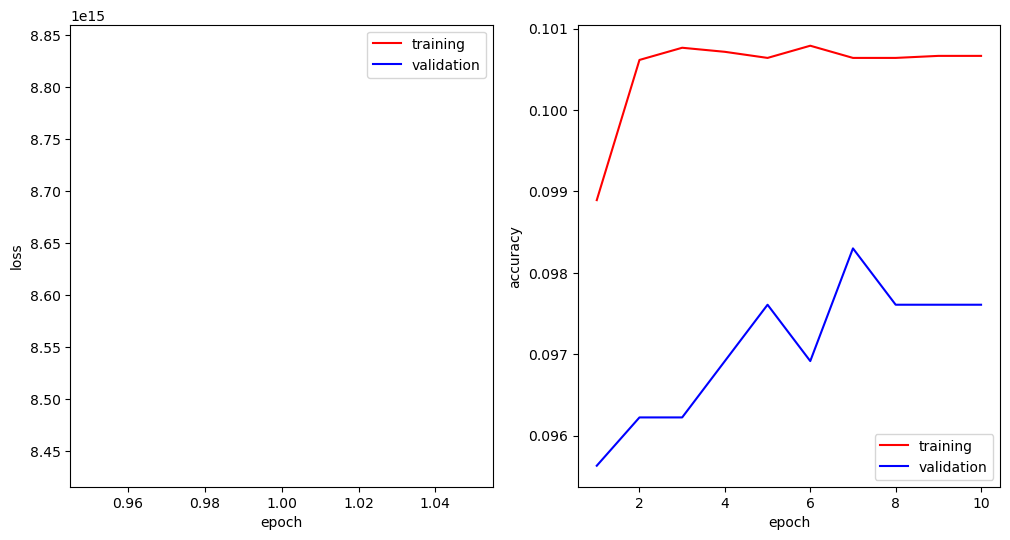

Fold #1
client 1 : 8709 samples
client 2 : 4275 samples
client 3 : 294 samples
client 4 : 1696 samples
client 5 : 5200 samples
client 6 : 8069 samples
client 7 : 11474 samples
client 8 : 283 samples

>>> Round 1 ...
client 1 : Loss = 1910686397497344.0000, Accuracy = 0.3174
client 2 : Loss = 3523310592.0000, Accuracy = 0.6420
client 3 : Loss = 0.2209, Accuracy = 0.9740
client 4 : Loss = 407.9965, Accuracy = 0.6635
client 5 : Loss = 414265081856.0000, Accuracy = 0.4511
client 6 : Loss = nan, Accuracy = 0.2711
client 7 : Loss = 15872371737690636288.0000, Accuracy = 0.2551
client 8 : Loss = 1.0807, Accuracy = 0.7242

Server :
    - training loss = nan
    - training accuracy = 0.1000
    - validation loss = nan
    - validation accuracy = 0.1010
        
>>> Round 2 ...
client 1 : Loss = nan, Accuracy = 0.2000
client 2 : Loss = nan, Accuracy = 0.0653
client 3 : Loss = nan, Accuracy = 0.0254
client 4 : Loss = nan, Accuracy = 0.0022
client 5 : Loss = nan, Accuracy = 0.0041
client 6 : Loss =

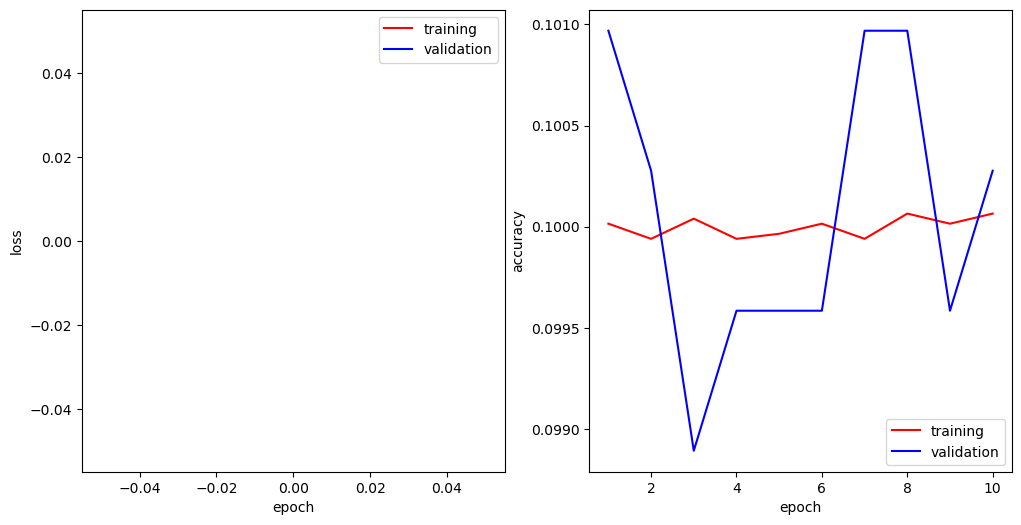

Fold #2
client 1 : 8637 samples
client 2 : 4278 samples
client 3 : 288 samples
client 4 : 1691 samples
client 5 : 5173 samples
client 6 : 8094 samples
client 7 : 11556 samples
client 8 : 283 samples

>>> Round 1 ...
client 1 : Loss = 298945259503616.0000, Accuracy = 0.2079
client 2 : Loss = 1858749824.0000, Accuracy = 0.7008
client 3 : Loss = 0.2298, Accuracy = 0.9661
client 4 : Loss = 257.0927, Accuracy = 0.5734
client 5 : Loss = 241916493824.0000, Accuracy = 0.4927
client 6 : Loss = 17295059451904.0000, Accuracy = 0.2710
client 7 : Loss = 8422689639235584.0000, Accuracy = 0.2884
client 8 : Loss = 0.4784, Accuracy = 0.8322

Server :
    - training loss = 137172837298339840.0000
    - training accuracy = 0.0982
    - validation loss = 120818211720527872.0000
    - validation accuracy = 0.0963
        
>>> Round 2 ...
client 1 : Loss = nan, Accuracy = 0.2056
client 2 : Loss = 261320705235222528.0000, Accuracy = 0.1530
client 3 : Loss = 146435758905884672.0000, Accuracy = 0.0156
client 4

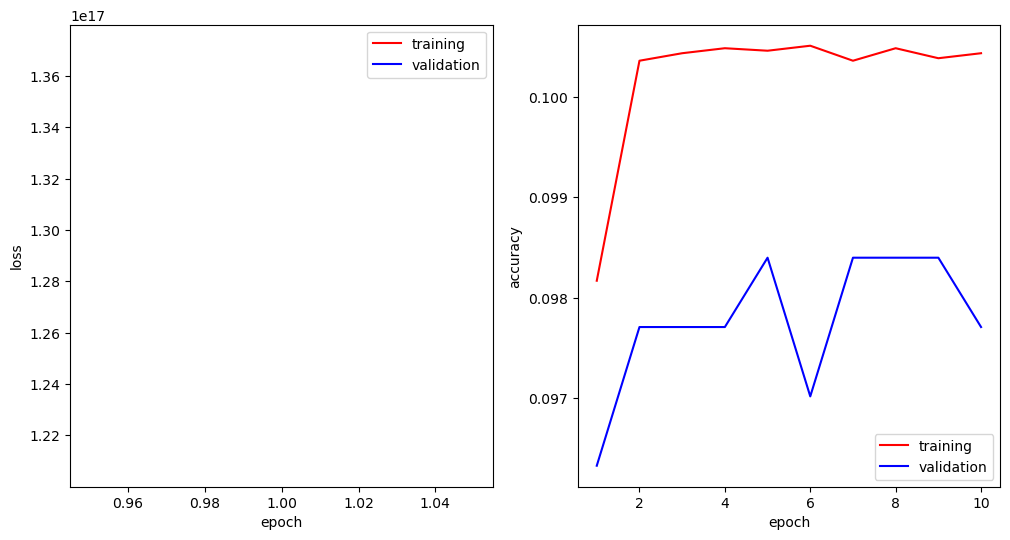

Fold #3
client 1 : 8642 samples
client 2 : 4271 samples
client 3 : 291 samples
client 4 : 1700 samples
client 5 : 5231 samples
client 6 : 8044 samples
client 7 : 11538 samples
client 8 : 283 samples

>>> Round 1 ...
client 1 : Loss = 2410657232191488.0000, Accuracy = 0.3239
client 2 : Loss = 2469801472.0000, Accuracy = 0.5829
client 3 : Loss = 0.3306, Accuracy = 0.9644
client 4 : Loss = 29.9902, Accuracy = 0.6895
client 5 : Loss = 11138502656.0000, Accuracy = 0.5573
client 6 : Loss = 1117032812642304.0000, Accuracy = 0.3995
client 7 : Loss = nan, Accuracy = 0.1164
client 8 : Loss = 0.5406, Accuracy = 0.7768

Server :
    - training loss = nan
    - training accuracy = 0.0990
    - validation loss = nan
    - validation accuracy = 0.1038
        
>>> Round 2 ...
client 1 : Loss = nan, Accuracy = 0.2028
client 2 : Loss = nan, Accuracy = 0.0647
client 3 : Loss = nan, Accuracy = 0.0156
client 4 : Loss = nan, Accuracy = 0.0022
client 5 : Loss = nan, Accuracy = 0.0040
client 6 : Loss = nan, 

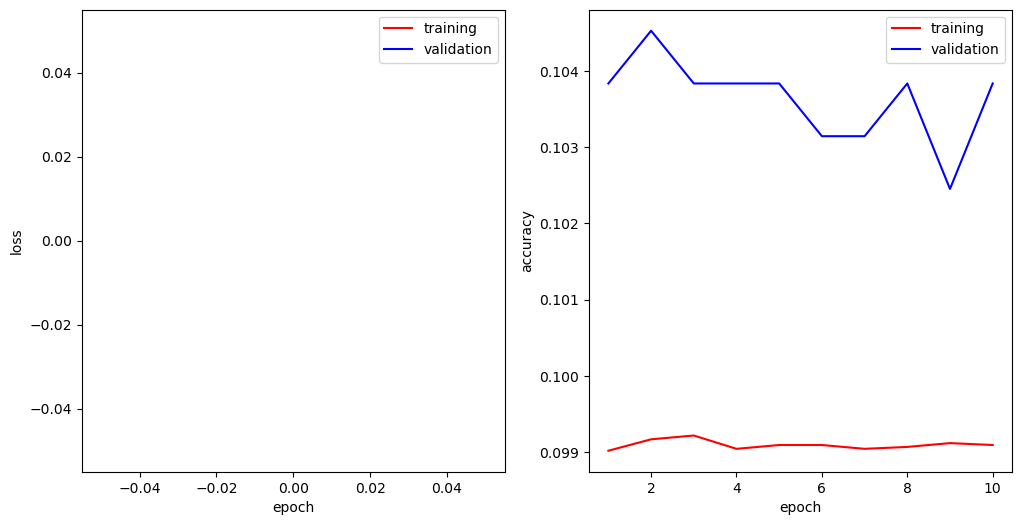

Fold #4
client 1 : 8631 samples
client 2 : 4294 samples
client 3 : 288 samples
client 4 : 1705 samples
client 5 : 5204 samples
client 6 : 8043 samples
client 7 : 11550 samples
client 8 : 285 samples

>>> Round 1 ...
client 1 : Loss = 9372186649296896.0000, Accuracy = 0.3308
client 2 : Loss = 26672312320.0000, Accuracy = 0.4711
client 3 : Loss = 0.2798, Accuracy = 0.9583
client 4 : Loss = 44.8172, Accuracy = 0.6999
client 5 : Loss = 131771328.0000, Accuracy = 0.4437
client 6 : Loss = nan, Accuracy = 0.2423
client 7 : Loss = 48233028194926592.0000, Accuracy = 0.3063
client 8 : Loss = 0.4624, Accuracy = 0.8165

Server :
    - training loss = nan
    - training accuracy = 0.0998
    - validation loss = nan
    - validation accuracy = 0.1013
        
>>> Round 2 ...
client 1 : Loss = nan, Accuracy = 0.2043
client 2 : Loss = nan, Accuracy = 0.0657
client 3 : Loss = nan, Accuracy = 0.0208
client 4 : Loss = nan, Accuracy = 0.0022
client 5 : Loss = nan, Accuracy = 0.0040
client 6 : Loss = nan, 

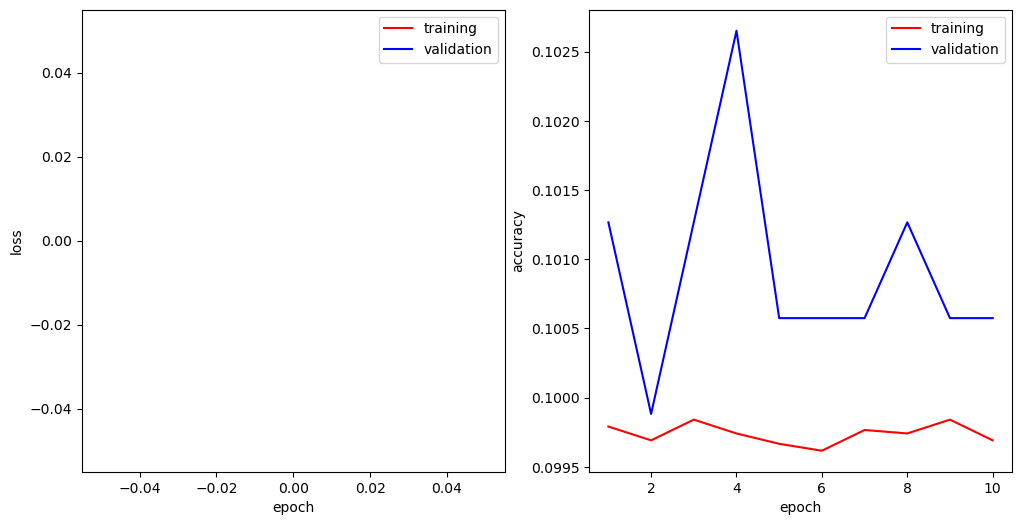

Fold #0
client 1 : 8643 samples
client 2 : 4261 samples
client 3 : 290 samples
client 4 : 1696 samples
client 5 : 5220 samples
client 6 : 8142 samples
client 7 : 11467 samples
client 8 : 281 samples

>>> Round 1 ...
client 1 : Loss = 0.8279, Accuracy = 0.7275
client 2 : Loss = 0.5334, Accuracy = 0.8131
client 3 : Loss = 0.0675, Accuracy = 0.9824
client 4 : Loss = 0.3963, Accuracy = 0.8655
client 5 : Loss = 0.5681, Accuracy = 0.8057
client 6 : Loss = 0.7506, Accuracy = 0.7186
client 7 : Loss = 0.9098, Accuracy = 0.7344
client 8 : Loss = 0.3236, Accuracy = 0.8610

Server :
    - training loss = 1640.1945
    - training accuracy = 0.1007
    - validation loss = 1643.0083
    - validation accuracy = 0.0983
        
>>> Round 2 ...
client 1 : Loss = 49.1251, Accuracy = 0.0062
client 2 : Loss = 19.8454, Accuracy = 0.0011
client 3 : Loss = 1973.1890, Accuracy = 0.0202
client 4 : Loss = 127.0098, Accuracy = 0.0022
client 5 : Loss = 48.3701, Accuracy = 0.0907
client 6 : Loss = 49.1663, Accuracy

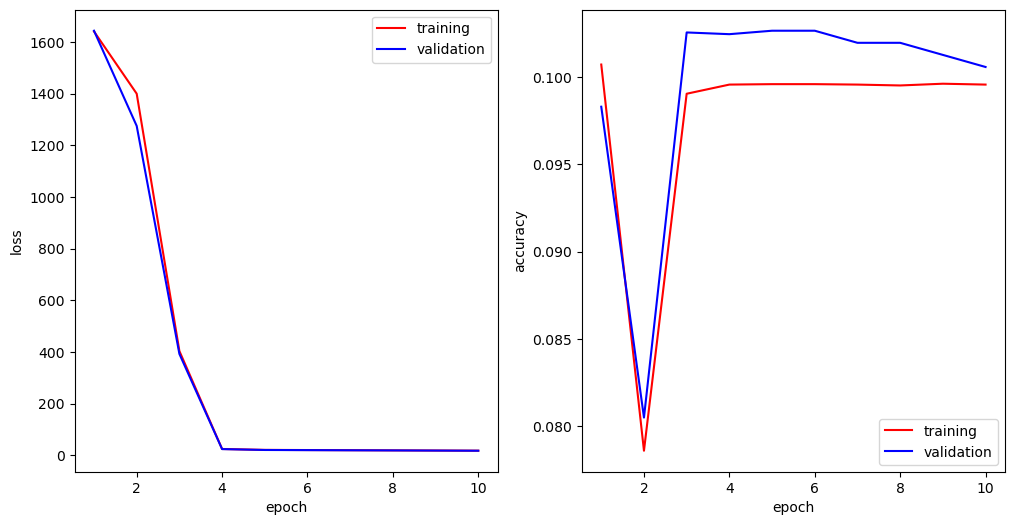

Fold #1
client 1 : 8709 samples
client 2 : 4275 samples
client 3 : 294 samples
client 4 : 1696 samples
client 5 : 5200 samples
client 6 : 8069 samples
client 7 : 11474 samples
client 8 : 283 samples

>>> Round 1 ...
client 1 : Loss = 0.9800, Accuracy = 0.6927
client 2 : Loss = 0.4888, Accuracy = 0.8196
client 3 : Loss = 0.1025, Accuracy = 0.9642
client 4 : Loss = 0.5163, Accuracy = 0.8181
client 5 : Loss = 0.5446, Accuracy = 0.8143
client 6 : Loss = 0.7684, Accuracy = 0.7032
client 7 : Loss = 0.9068, Accuracy = 0.7351
client 8 : Loss = 0.2666, Accuracy = 0.8900

Server :
    - training loss = 2063.0376
    - training accuracy = 0.1000
    - validation loss = 1976.2656
    - validation accuracy = 0.0996
        
>>> Round 2 ...
client 1 : Loss = 52.4221, Accuracy = 0.0020
client 2 : Loss = 17.7863, Accuracy = 0.0179
client 3 : Loss = 908.5497, Accuracy = 0.0192
client 4 : Loss = 114.9897, Accuracy = 0.0000
client 5 : Loss = 20.9490, Accuracy = 0.0873
client 6 : Loss = 54.4794, Accuracy 

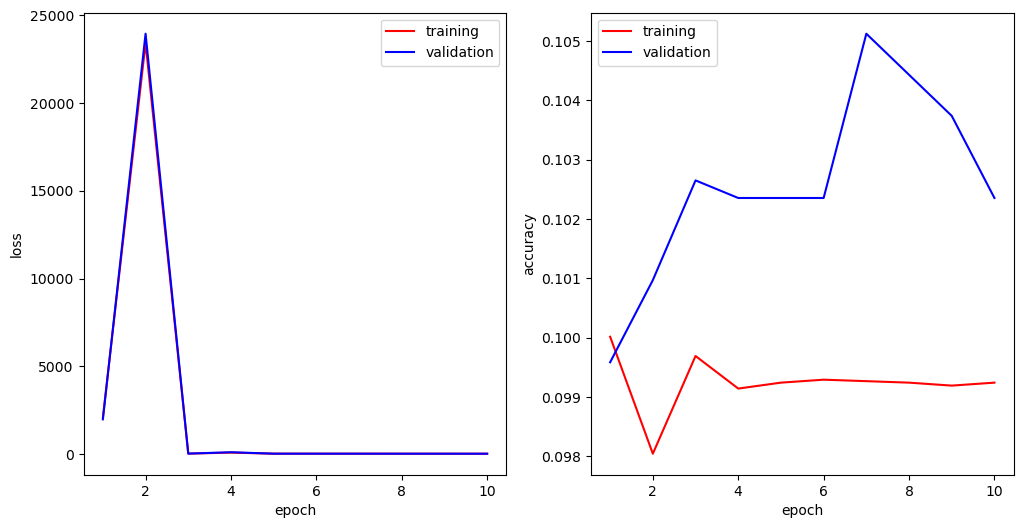

Fold #2
client 1 : 8637 samples
client 2 : 4278 samples
client 3 : 288 samples
client 4 : 1691 samples
client 5 : 5173 samples
client 6 : 8094 samples
client 7 : 11556 samples
client 8 : 283 samples

>>> Round 1 ...
client 1 : Loss = 0.8051, Accuracy = 0.7438
client 2 : Loss = 0.6630, Accuracy = 0.7967
client 3 : Loss = 0.0753, Accuracy = 0.9818
client 4 : Loss = 0.4382, Accuracy = 0.8453
client 5 : Loss = 0.5644, Accuracy = 0.8023
client 6 : Loss = 0.8134, Accuracy = 0.6990
client 7 : Loss = 0.6964, Accuracy = 0.7661
client 8 : Loss = 0.3821, Accuracy = 0.8628

Server :
    - training loss = 2573.0037
    - training accuracy = 0.1005
    - validation loss = 2606.2471
    - validation accuracy = 0.0977
        
>>> Round 2 ...
client 1 : Loss = 64.6836, Accuracy = 0.0038
client 2 : Loss = 25.3247, Accuracy = 0.0148
client 3 : Loss = 1005.4746, Accuracy = 0.0208
client 4 : Loss = 57.9794, Accuracy = 0.0022
client 5 : Loss = 37.6158, Accuracy = 0.0918
client 6 : Loss = 57.1869, Accuracy 

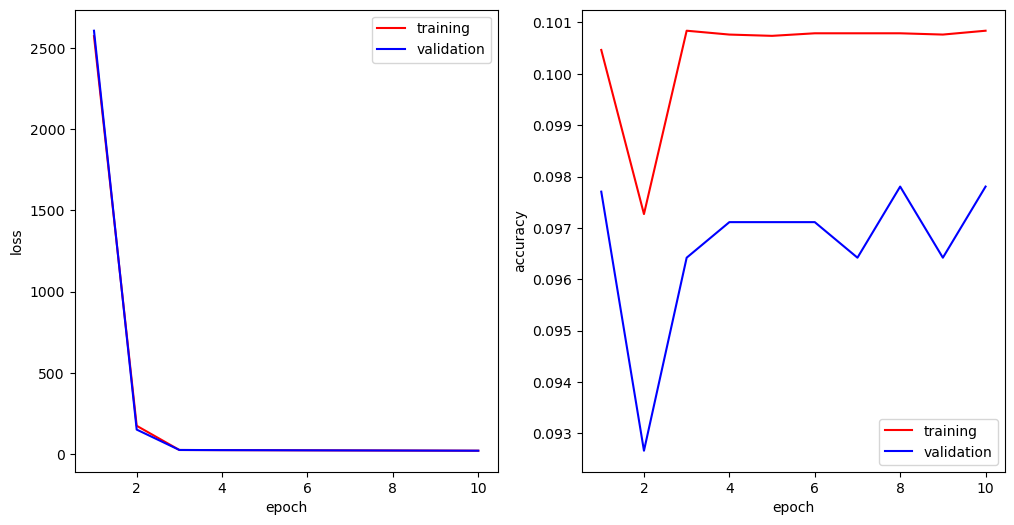

Fold #3
client 1 : 8642 samples
client 2 : 4271 samples
client 3 : 291 samples
client 4 : 1700 samples
client 5 : 5231 samples
client 6 : 8044 samples
client 7 : 11538 samples
client 8 : 283 samples

>>> Round 1 ...
client 1 : Loss = 0.8540, Accuracy = 0.7336
client 2 : Loss = 0.4802, Accuracy = 0.8226
client 3 : Loss = 0.0964, Accuracy = 0.9644
client 4 : Loss = 0.4567, Accuracy = 0.8447
client 5 : Loss = 0.5500, Accuracy = 0.8090
client 6 : Loss = 0.7427, Accuracy = 0.7121
client 7 : Loss = 0.7817, Accuracy = 0.7384
client 8 : Loss = 0.2995, Accuracy = 0.8822

Server :
    - training loss = 3387.4048
    - training accuracy = 0.0991
    - validation loss = 3364.3022
    - validation accuracy = 0.1045
        
>>> Round 2 ...
client 1 : Loss = 50.2750, Accuracy = 0.0015
client 2 : Loss = 56.9622, Accuracy = 0.0280
client 3 : Loss = 1977.8669, Accuracy = 0.0295
client 4 : Loss = 62.2245, Accuracy = 0.0017
client 5 : Loss = 48.9320, Accuracy = 0.0896
client 6 : Loss = 53.0946, Accuracy 

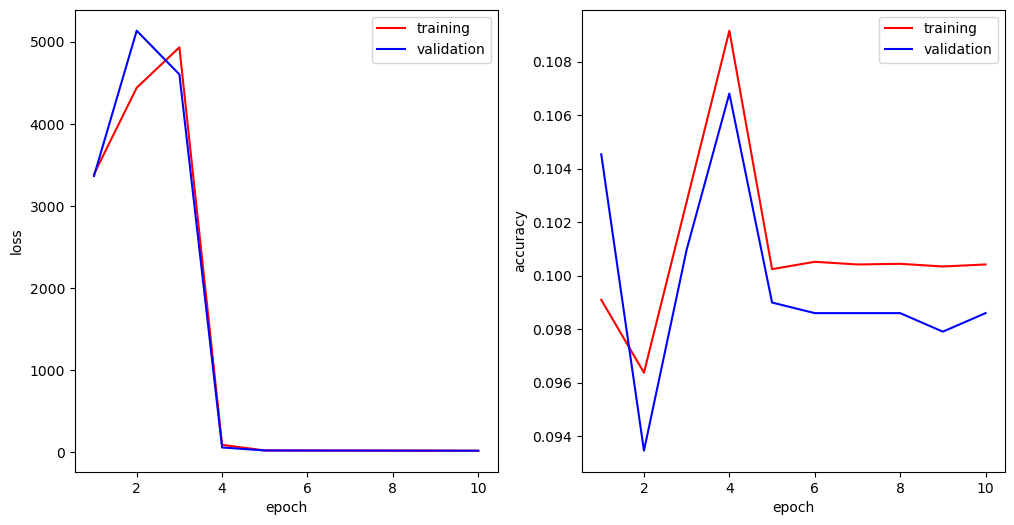

Fold #4
client 1 : 8631 samples
client 2 : 4294 samples
client 3 : 288 samples
client 4 : 1705 samples
client 5 : 5204 samples
client 6 : 8043 samples
client 7 : 11550 samples
client 8 : 285 samples

>>> Round 1 ...
client 1 : Loss = 0.8254, Accuracy = 0.7272
client 2 : Loss = 0.5495, Accuracy = 0.8094
client 3 : Loss = 0.1714, Accuracy = 0.9583
client 4 : Loss = 0.4414, Accuracy = 0.8370
client 5 : Loss = 0.6386, Accuracy = 0.7954
client 6 : Loss = 0.7382, Accuracy = 0.7240
client 7 : Loss = 0.8131, Accuracy = 0.7190
client 8 : Loss = 0.3259, Accuracy = 0.8900

Server :
    - training loss = 2233.6182
    - training accuracy = 0.0997
    - validation loss = 2316.5164
    - validation accuracy = 0.1013
        
>>> Round 2 ...
client 1 : Loss = 52.0080, Accuracy = 0.0029
client 2 : Loss = 30.5541, Accuracy = 0.0211
client 3 : Loss = 1302.8423, Accuracy = 0.0208
client 4 : Loss = 76.6688, Accuracy = 0.0000
client 5 : Loss = 24.0374, Accuracy = 0.0889
client 6 : Loss = 60.4040, Accuracy 

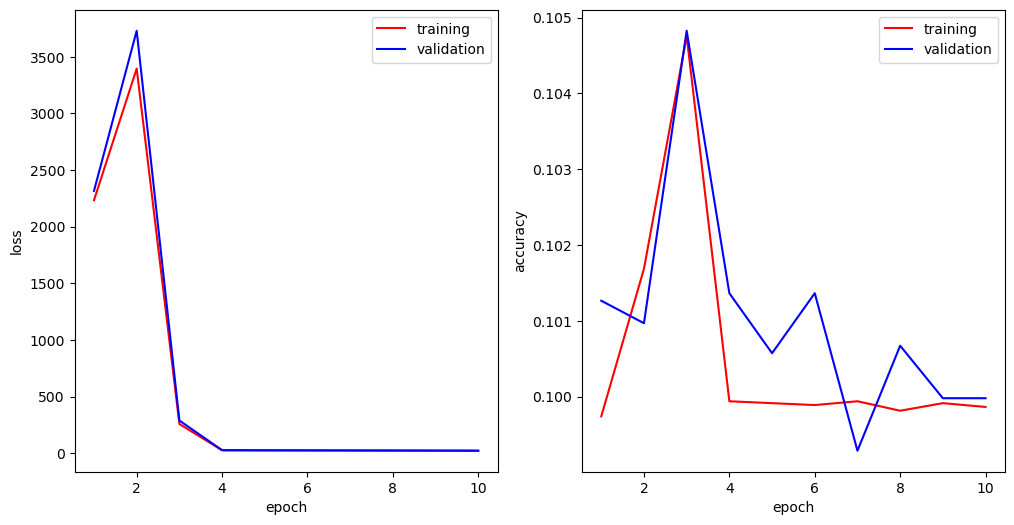

Fold #0
client 1 : 8643 samples
client 2 : 4261 samples
client 3 : 290 samples
client 4 : 1696 samples
client 5 : 5220 samples
client 6 : 8142 samples
client 7 : 11467 samples
client 8 : 281 samples

>>> Round 1 ...
client 1 : Loss = 0.7819, Accuracy = 0.7295
client 2 : Loss = 0.4530, Accuracy = 0.8315
client 3 : Loss = 0.0337, Accuracy = 0.9896
client 4 : Loss = 0.4467, Accuracy = 0.8477
client 5 : Loss = 0.5122, Accuracy = 0.8202
client 6 : Loss = 0.6617, Accuracy = 0.7328
client 7 : Loss = 0.5214, Accuracy = 0.8153
client 8 : Loss = 0.4874, Accuracy = 0.8106

Server :
    - training loss = 11.5077
    - training accuracy = 0.1007
    - validation loss = 11.5612
    - validation accuracy = 0.0976
        
>>> Round 2 ...
client 1 : Loss = 0.8244, Accuracy = 0.6914
client 2 : Loss = 0.6306, Accuracy = 0.7515
client 3 : Loss = 1.7418, Accuracy = 0.3580
client 4 : Loss = 0.6867, Accuracy = 0.7282
client 5 : Loss = 0.6813, Accuracy = 0.7692
client 6 : Loss = 0.7600, Accuracy = 0.6936
cli

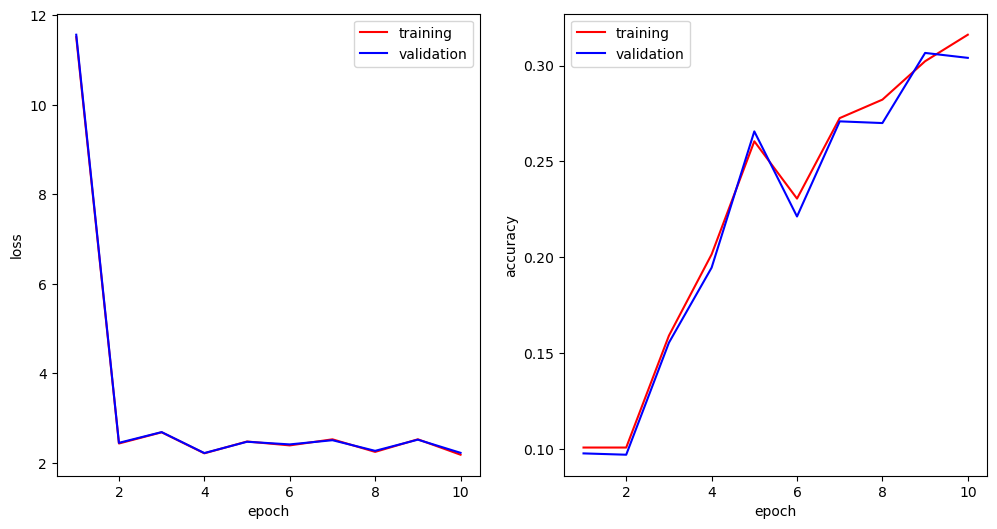

Fold #1
client 1 : 8709 samples
client 2 : 4275 samples
client 3 : 294 samples
client 4 : 1696 samples
client 5 : 5200 samples
client 6 : 8069 samples
client 7 : 11474 samples
client 8 : 283 samples

>>> Round 1 ...
client 1 : Loss = 0.8108, Accuracy = 0.7305
client 2 : Loss = 0.5006, Accuracy = 0.8025
client 3 : Loss = 0.0735, Accuracy = 0.9818
client 4 : Loss = 0.4717, Accuracy = 0.8404
client 5 : Loss = 0.5249, Accuracy = 0.8187
client 6 : Loss = 0.6577, Accuracy = 0.7440
client 7 : Loss = 0.5451, Accuracy = 0.8059
client 8 : Loss = 0.2080, Accuracy = 0.9310

Server :
    - training loss = 11.9474
    - training accuracy = 0.1000
    - validation loss = 11.8730
    - validation accuracy = 0.0996
        
>>> Round 2 ...
client 1 : Loss = 0.8432, Accuracy = 0.6740
client 2 : Loss = 0.5985, Accuracy = 0.7402
client 3 : Loss = 2.1058, Accuracy = 0.7906
client 4 : Loss = 0.7637, Accuracy = 0.7204
client 5 : Loss = 0.6895, Accuracy = 0.7576
client 6 : Loss = 0.7595, Accuracy = 0.6954
cli

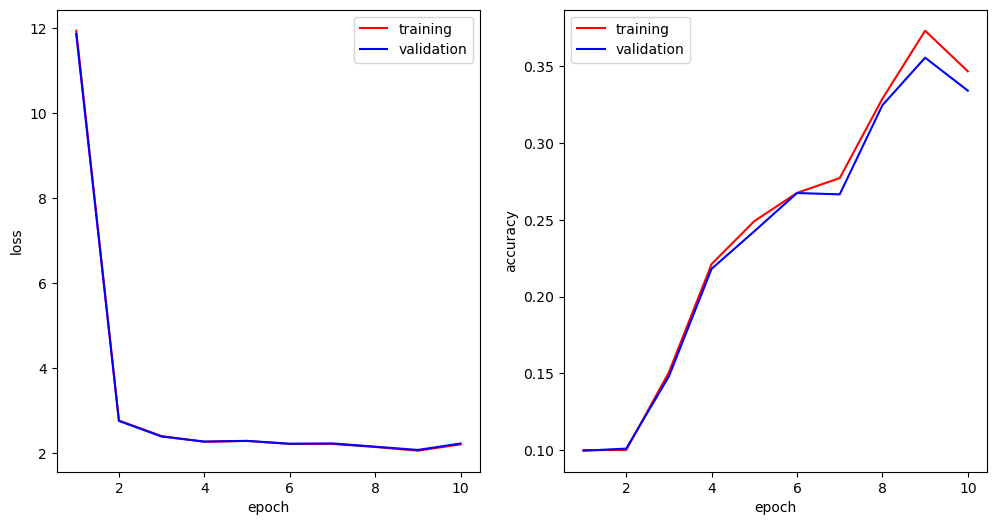

Fold #2
client 1 : 8637 samples
client 2 : 4278 samples
client 3 : 288 samples
client 4 : 1691 samples
client 5 : 5173 samples
client 6 : 8094 samples
client 7 : 11556 samples
client 8 : 283 samples

>>> Round 1 ...
client 1 : Loss = 0.7344, Accuracy = 0.7524
client 2 : Loss = 0.4757, Accuracy = 0.8130
client 3 : Loss = 0.1637, Accuracy = 0.9583
client 4 : Loss = 0.5261, Accuracy = 0.8169
client 5 : Loss = 0.4807, Accuracy = 0.8199
client 6 : Loss = 0.6782, Accuracy = 0.7273
client 7 : Loss = 0.5217, Accuracy = 0.8108
client 8 : Loss = 0.3725, Accuracy = 0.8244

Server :
    - training loss = 12.7085
    - training accuracy = 0.1005
    - validation loss = 12.8962
    - validation accuracy = 0.0970
        
>>> Round 2 ...
client 1 : Loss = 0.8321, Accuracy = 0.6800
client 2 : Loss = 0.6463, Accuracy = 0.7357
client 3 : Loss = 1.7415, Accuracy = 0.4089
client 4 : Loss = 0.7164, Accuracy = 0.7294
client 5 : Loss = 0.7276, Accuracy = 0.7463
client 6 : Loss = 0.8398, Accuracy = 0.6560
cli

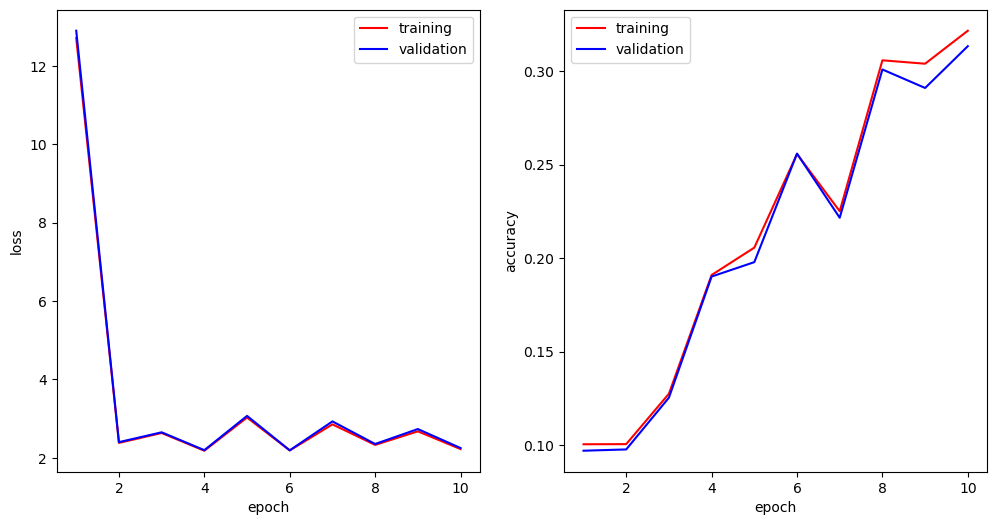

Fold #3
client 1 : 8642 samples
client 2 : 4271 samples
client 3 : 291 samples
client 4 : 1700 samples
client 5 : 5231 samples
client 6 : 8044 samples
client 7 : 11538 samples
client 8 : 283 samples

>>> Round 1 ...
client 1 : Loss = 0.7298, Accuracy = 0.7477
client 2 : Loss = 0.4777, Accuracy = 0.8118
client 3 : Loss = 0.0844, Accuracy = 0.9766
client 4 : Loss = 0.4848, Accuracy = 0.8229
client 5 : Loss = 0.6027, Accuracy = 0.7830
client 6 : Loss = 0.6539, Accuracy = 0.7454
client 7 : Loss = 0.6405, Accuracy = 0.7682
client 8 : Loss = 0.2708, Accuracy = 0.8991

Server :
    - training loss = 10.5923
    - training accuracy = 0.0991
    - validation loss = 10.5515
    - validation accuracy = 0.1045
        
>>> Round 2 ...
client 1 : Loss = 0.8691, Accuracy = 0.6429
client 2 : Loss = 0.5478, Accuracy = 0.7834
client 3 : Loss = 1.6030, Accuracy = 0.6184
client 4 : Loss = 0.6363, Accuracy = 0.7617
client 5 : Loss = 0.7659, Accuracy = 0.7455
client 6 : Loss = 0.7759, Accuracy = 0.6778
cli

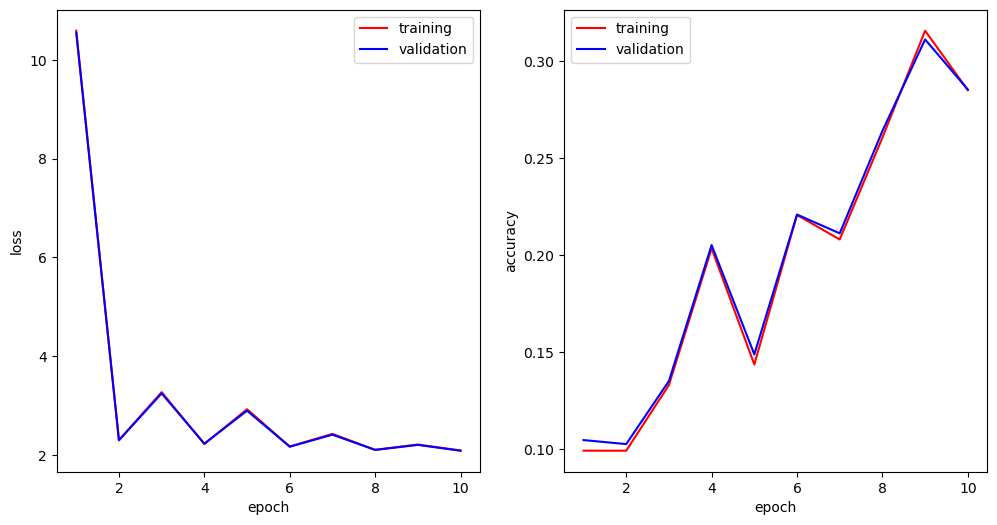

Fold #4
client 1 : 8631 samples
client 2 : 4294 samples
client 3 : 288 samples
client 4 : 1705 samples
client 5 : 5204 samples
client 6 : 8043 samples
client 7 : 11550 samples
client 8 : 285 samples

>>> Round 1 ...
client 1 : Loss = 0.7507, Accuracy = 0.7414
client 2 : Loss = 0.5092, Accuracy = 0.8035
client 3 : Loss = 0.0994, Accuracy = 0.9740
client 4 : Loss = 0.3978, Accuracy = 0.8623
client 5 : Loss = 0.5254, Accuracy = 0.8175
client 6 : Loss = 0.6850, Accuracy = 0.7331
client 7 : Loss = 0.5968, Accuracy = 0.7846
client 8 : Loss = 0.4204, Accuracy = 0.8279

Server :
    - training loss = 8.6324
    - training accuracy = 0.0997
    - validation loss = 8.6656
    - validation accuracy = 0.1006
        
>>> Round 2 ...
client 1 : Loss = 0.7841, Accuracy = 0.6952
client 2 : Loss = 0.5746, Accuracy = 0.7646
client 3 : Loss = 2.0581, Accuracy = 0.8203
client 4 : Loss = 0.5374, Accuracy = 0.8244
client 5 : Loss = 0.7179, Accuracy = 0.7468
client 6 : Loss = 0.8051, Accuracy = 0.6673
clien

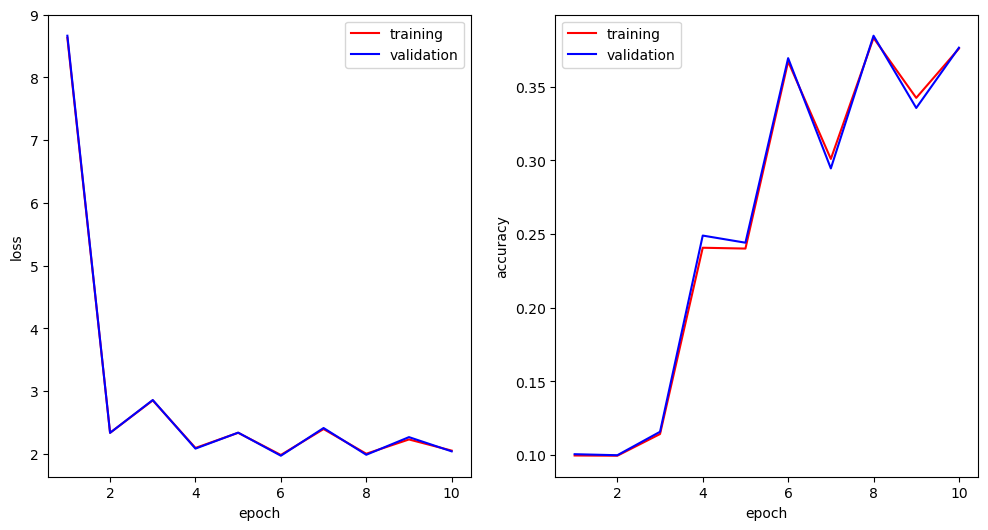

RESULTS
beta 1 = 0.999, beta 2 = 0.500 : Accuracy = 0.10000000149011612
beta 1 = 0.999, beta 2 = 0.950 : Accuracy = 0.09986154735088348
beta 1 = 0.999, beta 2 = 0.999 : Accuracy = 0.32266610860824585

CPU times: user 2h 28min 34s, sys: 18.9 s, total: 2h 28min 53s
Wall time: 2h 29min 31s


In [ ]:
%%time
#Continue broken process
n_splits = 5
rounds = 10
batch_size = 128
epochs = 5
lr = 5e-3
optimizer = optim.Adam
#In the original setting, it was already B1=0.9, B2=0.999
betas_1 = [0.999]
betas_2 = [0.5,0.95, 0.999]

results = []
for beta_1 in betas_1:
    for beta_2 in betas_2:
        res = run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr, betas=(beta_1, beta_2))
        results.append((beta_1, beta_2 ,res))
    
print("="*25)
print(f"RESULTS")
print("="*25)
for beta_1, beta_2, res in results:
    print(f"beta 1 = {beta_1:.3f}, beta 2 = {beta_2:.3f} : Accuracy = {res}")
print()


### Summary: None of the tried values outperformed default betas of (0.9, 0.999)

### In the end, best results are achieved using lr = 0.005, betas = (0.9, 0.999)